In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 40000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.9*abs_residual + 0.1*chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:13, 29.20it/s]

Adam:   6%|▌         | 23/400 [00:00<00:02, 128.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 176.05it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 156.01it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 159.70it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 157.40it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 174.49it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 182.96it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 190.07it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 186.51it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:00, 199.03it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 199.03it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 190.61it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 193.00it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 199.90it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 199.03it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 190.92it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 194.31it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 194.83it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 193.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.76it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.04it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 195.37it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 196.11it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 203.16it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 189.49it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 190.40it/s]

Adam:  45%|████▌     | 181/400 [00:00<00:01, 194.24it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 182.23it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 183.93it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 182.17it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 166.17it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 172.39it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 178.89it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 155.27it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 156.01it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 163.05it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 168.31it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 168.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.40it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 156.04it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 160.04it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 170.31it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 128.38it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 125.33it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 147.19it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 145.71it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 157.43it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 163.20it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 158.90it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 164.31it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 141.45it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:01, 140.45it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 140.57it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 144.98it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 143.33it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 143.82it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 153.67it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 153.39it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 153.37it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 141.83it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 140.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 147.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.32it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.40it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.19it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 161.57it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.18it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 162.38it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.59it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 174.62it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 155.42it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 160.42it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.37it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 163.50it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 164.03it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 158.54it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 161.22it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 149.26it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 150.40it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 160.99it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 153.91it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 160.68it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 163.19it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 160.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.97it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 139.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 144.93it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 163.66it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 160.78it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 135.59it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 128.24it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 132.10it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 134.08it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 133.09it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 134.77it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 144.14it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 148.40it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 153.22it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 151.81it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 148.20it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 138.48it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 146.22it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 145.11it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 158.02it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 166.15it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 160.80it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 153.23it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 142.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 145.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.99it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 129.55it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 150.14it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 153.41it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 157.54it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 165.18it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 158.48it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 150.79it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 144.88it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 148.78it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 152.47it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 157.01it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 176.51it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 179.98it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 178.15it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 166.45it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 163.87it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 164.50it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 151.00it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 142.31it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 157.40it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 151.76it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 140.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.92it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 166.06it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 170.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 133.86it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 141.18it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 148.41it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 132.86it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 143.47it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 160.87it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 160.35it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 161.33it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 171.97it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 142.34it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 137.53it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 145.12it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 156.17it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 159.05it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 169.37it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 168.46it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 165.15it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 160.12it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 157.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.00it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 152.65it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 160.45it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 130.46it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 145.43it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 166.96it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 165.84it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 166.01it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 164.45it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 158.61it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 161.34it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 173.50it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 181.26it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 173.28it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 165.69it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 166.26it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 174.30it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 183.13it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 166.60it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 161.81it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 158.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.19it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 110.56it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 120.81it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 118.52it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 141.71it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 141.93it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 142.10it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 149.15it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 147.89it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 161.65it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 157.89it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 170.69it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 182.47it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 184.29it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 177.49it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 168.65it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 155.34it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 153.86it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 139.55it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 143.82it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 147.17it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 146.01it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 160.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 211.26it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 203.33it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:01, 203.11it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 198.37it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 178.38it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 170.61it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.74it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 154.09it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 150.56it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 157.62it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 147.77it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 151.53it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 154.14it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 149.50it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 153.87it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 153.92it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 161.94it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 140.12it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 133.20it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 133.23it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 134.96it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 149.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 153.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.67it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 89.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 110.45it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 142.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 126.58it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 109.45it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 119.69it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 113.64it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 120.18it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 114.82it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 109.70it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 125.03it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 131.55it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 132.65it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 129.56it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 131.64it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 143.36it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:00, 156.03it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 127.84it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 129.67it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 131.01it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 145.14it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 127.51it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 123.27it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 132.04it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 137.40it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 128.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.83it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.03it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 121.14it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 136.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 134.83it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 119.52it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 121.79it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 123.41it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:01, 137.77it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 148.67it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 153.58it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 155.08it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 150.99it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 125.99it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 113.76it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 134.03it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 143.02it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 153.58it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 139.97it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 134.26it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 136.62it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 138.01it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 143.27it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 128.09it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 120.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 134.72it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 123.36it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 124.74it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 122.43it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 130.21it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 128.71it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 126.46it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 121.50it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 111.15it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 110.91it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 129.66it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 128.23it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 141.86it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 123.47it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 128.91it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 134.89it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 128.51it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 129.25it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 142.26it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 134.14it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 125.93it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 130.79it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 123.09it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 109.77it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 112.09it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 112.00it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 111.42it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.86it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 124.54it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 126.61it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 109.40it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 111.42it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 109.01it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 109.02it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 112.28it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 107.84it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 93.89it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:03, 85.53it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 95.67it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 100.91it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 104.64it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 97.99it/s] 

Adam:  49%|████▉     | 197/400 [00:01<00:01, 102.17it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 98.80it/s] 

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 92.69it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 109.09it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 110.26it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 106.69it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 107.32it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 111.70it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:01, 99.99it/s] 

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 86.47it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 96.00it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 109.20it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 105.30it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 105.76it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 97.87it/s] 

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 96.97it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 94.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.51it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 84.95it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 97.28it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 91.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 96.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 109.48it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 96.62it/s] 

Adam:  24%|██▍       | 95/400 [00:00<00:02, 104.68it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 117.94it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 120.78it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 102.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 96.06it/s] 

Adam:  41%|████      | 164/400 [00:01<00:02, 107.26it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 99.38it/s] 

Adam:  47%|████▋     | 187/400 [00:01<00:02, 98.56it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 87.99it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.89it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 87.76it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 86.79it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 90.66it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 99.34it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 105.34it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 95.92it/s] 

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 91.03it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.26it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 97.53it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 103.18it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 100.62it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 109.93it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 115.75it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 107.30it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 93.76it/s] 

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 93.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.98it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.06it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.04it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 91.69it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 90.78it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 82.61it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.68it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 78.83it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 96.88it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 107.99it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 118.58it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 124.12it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 111.97it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 109.94it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 114.15it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 114.43it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 115.85it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 102.95it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 102.97it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.42it/s] 

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 92.16it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 103.67it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 105.83it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 99.58it/s] 

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 97.94it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 92.63it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.84it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 107.67it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 95.49it/s] 

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 96.59it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 100.12it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 103.23it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 100.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.31it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.18it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 93.79it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 105.20it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 98.81it/s] 

Adam:  18%|█▊        | 70/400 [00:00<00:03, 103.22it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 114.13it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 111.11it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 110.60it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 114.44it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 111.21it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 108.59it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 105.57it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 96.56it/s] 

Adam:  44%|████▍     | 177/400 [00:01<00:02, 92.07it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 92.13it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 96.45it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.77it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 85.82it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.92it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 86.61it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 84.75it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 78.79it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 80.25it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 91.92it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 106.66it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 115.29it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 94.96it/s] 

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 91.82it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 91.13it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 82.47it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 80.19it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 80.76it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.02it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 79.86it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 83.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.78it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.48it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 82.52it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.25it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 82.02it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.69it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 79.78it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.71it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 91.02it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 91.70it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.87it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.31it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 75.94it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 75.85it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 76.73it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 73.83it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.87it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.99it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.10it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.31it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 92.36it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 102.38it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 95.36it/s] 

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 88.15it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.47it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 80.60it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 87.20it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 89.08it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 85.32it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 91.18it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 91.25it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 91.83it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.66it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.35it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 82.25it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 88.63it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 82.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.82it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.01it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.91it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 66.05it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.11it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.60it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 89.08it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 97.61it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 95.41it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 86.39it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 91.83it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 84.51it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.40it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 88.43it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.14it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.00it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.62it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.07it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.11it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.84it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 70.44it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.90it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 93.69it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 97.40it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 96.81it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 103.18it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 99.63it/s] 

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 89.96it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 93.82it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 93.78it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 88.52it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.24it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 84.89it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 78.11it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 81.98it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.13it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.51it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 82.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.83it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.98it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 99.82it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 85.92it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 80.08it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 85.53it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 85.41it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.34it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 84.15it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.33it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 88.03it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.16it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.94it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 75.44it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.24it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.85it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 76.98it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.72it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.71it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.90it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.32it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 87.82it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.77it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 86.34it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 89.06it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 87.01it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 88.52it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 93.48it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.04it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 73.80it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.00it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 66.80it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 70.87it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 80.58it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.71it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.61it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.48it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.09it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.00it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 70.72it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 68.08it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 70.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.82it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.44it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.21it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.18it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.84it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 70.83it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 66.96it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.49it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 71.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 73.93it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.42it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 83.31it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.41it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 86.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 85.66it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 88.39it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 87.37it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.59it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.05it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 84.26it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.81it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.29it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 70.01it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 67.81it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 74.50it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 79.79it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 72.74it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.25it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.83it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.41it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.23it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.56it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 86.85it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 94.70it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 86.49it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 86.57it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.69it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 80.21it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.41it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 71.18it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.69it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 74.03it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 69.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.56it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.91it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.87it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.94it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 93.31it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 91.67it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.85it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 77.19it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.24it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.62it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.78it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.79it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.62it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.58it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 89.31it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 86.74it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 77.66it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 75.00it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.13it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 71.14it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.60it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.27it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 71.87it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.84it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 72.19it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 76.76it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.78it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.71it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 73.73it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.09it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 75.90it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 77.70it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.26it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 74.66it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 75.16it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.45it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.39it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.48it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.85it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.39it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.11it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 72.90it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.57it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 82.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.24it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.78it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.34it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 71.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.28it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.77it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.72it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 73.68it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 78.03it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.95it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.64it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.84it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.39it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.83it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 67.78it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.67it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 82.27it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 92.54it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 99.54it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 95.27it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 96.45it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 99.86it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 90.40it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.51it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.21it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 81.08it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.06it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.07it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.36it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.19it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.22it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 69.53it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 73.90it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 80.18it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.77it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 70.59it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 68.74it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.14it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 72.26it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 68.07it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 67.49it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 66.42it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.33it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 64.70it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.55it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 63.96it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 67.89it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.58it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.96it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.98it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 73.43it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.75it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.09it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 75.54it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.58it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.93it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.60it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 67.62it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 69.94it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 76.88it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 75.96it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.04it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.81it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 74.16it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 81.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.98it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.56it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.88it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 74.80it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 72.20it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 69.42it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.39it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 75.18it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.13it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.20it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 65.16it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 67.08it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 69.86it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 70.30it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 68.48it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.88it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.89it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.91it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.96it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 81.53it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 81.03it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 84.37it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 85.31it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 80.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.48it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.52it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.74it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 70.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.39it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.79it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.82it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 79.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.57it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.11it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.98it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.97it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.87it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.28it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.85it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.19it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 67.57it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 64.49it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 65.53it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.29it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.19it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.33it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.28it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 71.78it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.31it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.57it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.67it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 68.82it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 66.55it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 64.76it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.63it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 66.56it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 70.10it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 65.74it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 68.41it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 71.43it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.51it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.81it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 70.55it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.34it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.99it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.34it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.83it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 82.74it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 78.83it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 76.64it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.41it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.14it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.58it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.18it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.49it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 70.64it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 65.55it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.96it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.79it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 65.75it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.13it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 66.51it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.31it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 63.41it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 66.28it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 67.14it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 73.05it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.95it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.82it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 68.79it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 71.65it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.41it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 85.29it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 76.21it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 77.69it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.58it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.68it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.55it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.97it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 88.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.50it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.26it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 73.93it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 71.03it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 68.79it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.76it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.03it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.94it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.30it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.50it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 69.81it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 67.55it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 67.11it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 64.93it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 67.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.97it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.44it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.26it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 66.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.13it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 64.37it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.31it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 68.32it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.13it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.35it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.30it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.04it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 79.84it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.40it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 87.66it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 84.27it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.31it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.72it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 85.42it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.28it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.18it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 69.87it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.67it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.81it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.90it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.89it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 86.68it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.55it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.87it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.46it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 80.00it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 72.20it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.05it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.48it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.11it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.32it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.28it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.68it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 70.61it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.57it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 69.83it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 67.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.18it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.56it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.12it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 68.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.43it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 64.53it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 66.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.25it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.27it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.14it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.61it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.17it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.00it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 68.10it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 69.22it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.51it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 78.78it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.35it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.93it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.35it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 88.77it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 94.72it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 97.99it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 103.03it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 103.28it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 96.28it/s] 

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 89.33it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 90.02it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 93.75it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 88.18it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 95.85it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 88.70it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.22it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.64it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 72.10it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.14it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.14it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.17it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 82.94it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.13it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.72it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 74.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.15it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.90it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 90.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 79.91it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 71.77it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.14it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.89it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 71.09it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 64.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 64.66it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 65.68it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 66.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 63.85it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.21it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.18it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.61it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 69.12it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.37it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.02it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.90it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.20it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 70.83it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.13it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.08it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.48it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 76.09it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 79.45it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 74.16it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 70.72it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.25it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 72.85it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.55it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 72.42it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 76.44it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 74.68it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.79it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.51it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.39it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.26it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.20it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.13it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.25it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 71.39it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 73.64it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 75.14it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.88it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.82it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 56.20it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 62.96it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 63.73it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 67.17it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 67.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 67.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.74it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.18it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.80it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.73it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.04it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.95it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.94it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 66.71it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.31it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 75.25it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 76.42it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.71it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 69.18it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.28it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.24it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.75it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.40it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.00it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 79.13it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 76.88it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.22it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.99it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 71.49it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.54it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.79it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.02it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.40it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 76.31it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.50it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 73.30it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 68.85it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 66.82it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 64.42it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 62.88it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 64.37it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 62.43it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 63.22it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 62.80it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 60.76it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 67.89it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 76.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.74it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 67.22it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.70it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.91it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 68.08it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 63.31it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 65.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 66.10it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 69.09it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.43it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.00it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 87.49it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.98it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.55it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.19it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 70.55it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 69.00it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 68.20it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.52it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 71.72it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 68.55it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.52it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 63.66it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 65.02it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 64.78it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 65.38it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.08it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.93it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.76it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.98it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:02, 64.27it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 67.08it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 65.92it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 67.95it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 65.25it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 71.86it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 68.28it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 67.89it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.93it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 72.30it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.91it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 72.98it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 72.10it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 77.19it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 73.55it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.35it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.36it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.74it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 65.16it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 62.53it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 60.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 61.68it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.95it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 63.26it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 63.49it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 65.70it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.99it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.50it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 73.90it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.08it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 74.88it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.91it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 81.79it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 80.41it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.79it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.49it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.98it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.72it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.77it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.73it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.18it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 77.57it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 75.26it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.48it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 75.94it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.89it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 75.16it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 68.59it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 66.04it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 71.94it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.24it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 73.16it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.56it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.04it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.29it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.01it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 92.23it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 85.39it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 79.58it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 78.36it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.95it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 88.01it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 91.28it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 83.47it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 83.91it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 88.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.28it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 71.90it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 73.88it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.36it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.65it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 69.95it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.57it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.04it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.09it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 69.39it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.31it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.38it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.83it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 64.16it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.11it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 72.60it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.39it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.92it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:01, 87.09it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.00it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.37it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.02it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.03it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 70.78it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 69.99it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 72.43it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 68.30it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 70.51it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.37it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.40it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 65.90it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.97it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.66it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.51it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 76.76it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 69.93it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 64.01it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 65.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.69it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 62.31it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.39it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.98it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 63.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.00it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 68.34it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 75.53it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 85.89it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.22it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 85.38it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 90.58it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 92.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 91.89it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.10it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 83.88it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.45it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.83it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 72.47it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.49it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 68.44it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 72.31it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.64it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.64it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 79.01it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 87.50it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 92.93it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 91.05it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 86.49it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 88.40it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.63it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 76.98it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.98it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.33it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 71.90it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.10it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.72it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.67it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 70.40it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.76it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.32it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 80.90it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 77.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.84it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 94.35it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 96.73it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 93.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 87.43it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 89.44it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 90.30it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 85.90it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.80it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.30it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.59it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 92.23it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.99it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.81it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.53it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.57it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 80.69it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 74.90it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.14it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 66.11it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.28it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 70.75it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 68.62it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 70.54it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 65.46it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 63.21it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 67.32it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.10it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.59it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.71it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.82it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 85.40it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 89.81it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 77.62it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.57it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.53it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 75.91it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 68.22it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 73.72it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.54it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.44it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 69.47it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.51it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 73.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.73it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.36it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.67it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.85it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 84.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 85.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 82.63it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 72.73it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.17it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 64.41it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 65.97it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 68.35it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.73it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 87.83it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 85.75it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 84.11it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.12it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.28it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 72.91it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.87it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.82it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.69it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.40it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 82.64it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 74.27it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.62it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.71it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.13it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.03it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.90it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.50it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 70.34it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.04it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 84.89it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.81it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.43it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.48it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 65.99it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.91it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 72.21it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.41it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 80.85it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.22it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 65.82it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.73it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.70it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.83it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 71.22it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 68.53it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.72it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.88it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.65it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 65.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 62.12it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 63.46it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 67.14it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 64.27it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 64.41it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:04, 63.99it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 68.05it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 69.40it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.21it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.42it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.37it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.01it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.48it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.05it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 74.51it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 75.87it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.16it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 76.83it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 72.07it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.15it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.85it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.11it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 68.30it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 64.31it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 68.16it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 66.19it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 64.42it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.43it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.45it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.48it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 74.89it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 77.41it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 84.22it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 78.51it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 85.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.67it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.74it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 75.32it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.60it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.77it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 70.85it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.03it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.75it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.77it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.95it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.85it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.26it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 66.30it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 64.73it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 60.65it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 65.30it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 62.55it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 63.25it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 64.02it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 65.18it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.08it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.81it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.15it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.88it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.05it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 75.53it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 73.84it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 78.22it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 79.25it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.47it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.33it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 73.70it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.64it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 77.87it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.67it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 74.67it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 69.17it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 68.48it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 72.69it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.40it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.99it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.40it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 74.12it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 71.30it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 72.03it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 72.20it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 77.13it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 85.92it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 87.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.50it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.05it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.47it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 68.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.38it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 70.96it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.04it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.75it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 75.70it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.85it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.97it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.51it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.74it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.96it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.53it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.60it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 73.45it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 76.55it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.64it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.56it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.94it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 68.08it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 71.95it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.42it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.36it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 68.86it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 68.82it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.45it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.26it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.27it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.01it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.55it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.77it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.25it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 78.68it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 77.48it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 82.37it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 88.45it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 86.41it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 85.53it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 78.71it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.40it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 67.01it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 66.82it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 67.94it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.05it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 87.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.49it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 88.56it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 91.79it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 89.38it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 90.48it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 85.81it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.24it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.23it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.30it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.17it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.71it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.86it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.98it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 67.33it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 64.29it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 63.01it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 62.77it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 62.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 60.63it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:03, 60.78it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 65.15it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 61.74it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 59.12it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 70.28it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.08it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 71.66it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 70.09it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 72.43it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.81it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 74.30it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 80.01it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 86.41it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.58it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 70.76it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.18it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.56it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 69.14it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 71.98it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 75.29it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 76.29it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.16it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 74.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 83.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 82.23it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 86.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 83.01it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.53it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 72.02it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.45it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 81.94it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 82.59it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.86it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.40it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 68.83it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 67.92it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 74.44it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.58it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.87it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.63it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.17it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.97it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.83it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 88.83it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 90.30it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 88.30it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 84.45it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 87.44it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 90.47it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 89.10it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 91.13it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 86.51it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.14it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 83.90it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 83.73it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 86.62it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 89.53it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 92.71it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 95.70it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 86.30it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 92.06it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 81.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.01it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.47it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.67it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.62it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 78.99it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 87.86it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.97it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.93it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.92it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.51it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 84.93it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 82.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 86.19it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 89.85it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 87.59it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 83.92it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.35it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.23it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.85it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 66.45it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 65.98it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 64.40it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 69.17it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.04it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.07it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 72.81it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 71.31it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 70.21it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 67.83it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 66.86it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 64.72it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 64.47it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 61.86it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 67.97it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.28it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.18it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.89it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.11it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 71.69it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 77.22it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.14it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.86it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 69.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 63.69it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 65.58it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 63.02it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 61.08it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 64.43it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 69.67it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 68.70it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.53it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.63it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 66.23it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.29it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.36it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.44it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.83it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 70.50it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.53it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.68it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.72it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 87.93it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 84.85it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.00it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.87it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 83.18it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 84.12it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 83.32it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.90it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.42it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.21it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.39it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.77it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 75.22it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 81.77it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 80.62it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 83.64it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.54it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.29it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.34it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.70it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 74.64it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 75.12it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.67it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.89it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.23it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.95it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.18it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.83it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.96it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.16it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.41it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.83it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 71.25it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 73.01it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.69it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.18it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 87.35it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 85.27it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.73it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.20it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.76it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.69it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.31it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 71.32it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 69.71it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.79it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 68.00it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 67.76it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 72.13it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.65it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.61it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 82.02it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 85.40it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.03it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.60it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.84it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.93it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 83.60it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.51it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.53it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.03it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.50it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.88it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 86.25it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 89.27it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 91.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.39it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.16it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.12it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.92it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.69it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 67.38it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 67.02it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 72.70it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.30it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 64.37it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 63.08it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 63.51it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 66.53it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 64.43it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 67.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 69.11it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 69.71it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 65.98it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 63.46it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 70.73it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 66.76it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.92it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 67.93it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 63.98it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 64.28it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 65.03it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 70.79it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.74it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.66it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.95it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.02it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 71.38it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 68.15it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 67.68it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 64.09it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 60.76it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 60.87it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 62.75it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 60.32it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 60.94it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 60.75it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:01, 60.58it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 70.04it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 77.04it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 78.96it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 86.07it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 83.15it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 82.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.16it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.08it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 61.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 70.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.05it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 66.11it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.12it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 69.35it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.85it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.24it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 71.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 74.06it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.22it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 70.19it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.26it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 68.15it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 77.79it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 80.09it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.99it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.51it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.06it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.00it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.07it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 64.00it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 65.41it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 62.88it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.49it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.73it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.77it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.19it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.70it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 81.59it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.32it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 81.19it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 88.31it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 87.78it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.78it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 87.24it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 84.83it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.29it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.42it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 75.22it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 69.75it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.91it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.43it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.67it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.28it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 65.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 66.24it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 66.44it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 72.18it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.03it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 67.89it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.15it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.20it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 87.18it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.56it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.95it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.00it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.31it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 65.86it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 65.57it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.07it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 66.78it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 66.47it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.03it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.72it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 69.61it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 67.89it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 67.42it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 65.48it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.34it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 65.54it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 68.87it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 79.75it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.41it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.40it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 70.17it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 65.75it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.48it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 70.47it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.80it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.56it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.50it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 76.89it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 74.23it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 82.08it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 82.80it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 85.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.50it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.48it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 71.08it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.43it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.90it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.23it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.30it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.95it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 70.08it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 70.98it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 66.56it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 66.55it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 68.14it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.46it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 65.56it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 66.30it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 72.22it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.14it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 75.80it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 80.34it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 76.37it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.07it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.48it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.37it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.11it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.57it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 72.03it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.02it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 70.28it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.78it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.91it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 78.34it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 77.56it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 75.16it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.51it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.41it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 73.91it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.96it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.50it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 70.84it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 72.14it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 73.30it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 77.46it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 79.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.35it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 101.37it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 84.39it/s] 

Adam:  10%|█         | 40/400 [00:00<00:04, 74.43it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 68.94it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 67.33it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 63.90it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 61.82it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 63.85it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 65.19it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.64it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.10it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.77it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.01it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 64.15it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 63.09it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 63.57it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 66.13it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.24it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 83.38it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.42it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.92it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.50it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.25it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.12it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:01, 91.14it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 89.74it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 87.66it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.24it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.54it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.08it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.00it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.05it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.84it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 71.93it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 66.14it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 66.77it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 72.29it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.04it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 74.13it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.32it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 68.43it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 69.66it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 72.34it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 79.86it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.47it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 80.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 71.00it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.08it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 63.23it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 69.40it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.58it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.43it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.08it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.17it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 72.28it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 69.64it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.17it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.70it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.26it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.29it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.49it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 71.25it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 71.65it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.50it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.31it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.74it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.77it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 76.73it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.47it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.83it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.06it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.24it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.21it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.82it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.81it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.50it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.68it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.16it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 70.35it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 65.80it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.30it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 74.16it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 68.45it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 66.28it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.45it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 71.53it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 73.24it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.68it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.65it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.28it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 90.33it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.34it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.84it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.08it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.19it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 72.02it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.82it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.76it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.04it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.15it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.13it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 83.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.89it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 77.91it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.51it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.26it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.00it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.30it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.50it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.81it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.42it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 86.68it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.77it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 73.92it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.28it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.14it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 72.07it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.13it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.91it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.51it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.95it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 67.08it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 71.90it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 69.39it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 66.69it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 68.50it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 88.04it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 89.31it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 87.19it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 85.07it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:06, 65.21it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.31it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.76it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.43it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.55it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.26it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 71.03it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.32it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.58it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.04it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.05it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.09it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 76.72it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.98it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.16it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.77it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 67.26it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.96it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 65.13it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.59it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 67.63it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 63.67it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 66.00it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 69.46it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 74.71it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 78.77it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.20it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.32it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.83it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.57it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.43it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.67it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 81.04it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.26it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.36it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 69.46it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 65.51it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.57it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 76.64it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.53it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 70.30it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 65.79it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.60it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 70.54it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 74.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.90it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.92it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 63.56it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 62.53it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.04it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.38it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 69.09it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.09it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 69.97it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.72it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 69.85it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.27it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.80it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.59it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.92it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.91it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.41it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 76.94it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 77.10it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.06it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.09it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.24it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.62it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.68it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.04it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.84it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 74.06it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 70.64it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.33it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.83it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.22it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 72.18it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.66it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 74.69it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 73.56it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 79.44it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.85it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.95it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 74.62it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.02it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 71.83it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.71it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 76.77it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 80.14it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 80.12it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.82it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.71it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.61it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.94it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.43it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.85it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 68.22it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 65.33it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 63.38it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 61.29it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 61.37it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 67.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 68.97it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.24it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.96it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 78.84it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 70.35it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.58it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.65it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.41it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.36it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 86.16it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.73it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 73.24it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 70.36it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.21it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.42it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.45it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.15it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.96it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.95it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.54it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 76.74it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 78.99it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 78.77it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.56it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.65it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.47it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.20it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 68.94it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 66.49it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 74.04it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 73.98it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 74.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.72it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.83it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.67it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 71.96it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.61it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.49it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 69.23it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 71.42it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.91it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 68.78it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 66.10it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 73.91it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.23it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 66.45it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 66.09it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 64.51it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 65.89it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 66.04it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 66.43it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 70.76it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 69.29it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 68.97it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.98it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.15it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.58it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.46it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 69.98it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 66.11it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.21it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.93it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.48it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.59it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.78it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.36it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 70.90it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 71.74it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 66.00it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 66.14it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 65.87it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 68.34it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 70.61it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 67.79it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 65.09it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 63.48it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 61.12it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 61.83it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 62.53it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 61.97it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 63.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.13it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.61it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 67.50it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.97it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 64.55it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.34it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 70.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.28it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.87it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 79.06it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.09it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.41it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.01it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.87it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.38it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.19it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.15it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 77.10it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.19it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 72.64it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 70.23it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 73.04it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.44it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 64.79it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 65.46it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 69.63it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 67.77it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 63.12it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 63.66it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 64.18it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.20it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 62.48it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 61.91it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 67.73it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.32it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 75.14it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 76.48it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.27it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 64.56it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 64.49it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.79it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 62.51it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 63.38it/s]

Adam:  88%|████████▊ | 350/400 [00:05<00:00, 64.09it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 69.35it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 70.51it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 71.76it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.83it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.24it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.07it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.04it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 71.94it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.04it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 63.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 62.50it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 67.02it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 62.55it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 64.04it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 68.98it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 69.51it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 65.43it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 65.74it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 66.81it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.38it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 74.04it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.74it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 68.74it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 68.47it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.11it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 66.15it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.37it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 68.44it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 64.17it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:03, 62.75it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:03, 60.26it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 68.22it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 66.38it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.42it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.45it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 67.77it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 64.51it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 70.31it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 73.44it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 74.48it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 77.49it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 81.16it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.12it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.19it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.33it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 67.04it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 65.10it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 63.10it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 68.29it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 70.83it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 71.03it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 65.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.61it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.25it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.89it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.57it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.16it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.59it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 66.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.76it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.88it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.91it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.42it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.95it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 65.59it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 63.89it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.10it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 68.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.26it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 78.28it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.62it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.88it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.57it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.43it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.16it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.56it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.88it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 71.83it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.05it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 64.89it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.20it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.50it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.41it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.35it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 86.30it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 85.38it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 84.52it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 81.07it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 79.77it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.92it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 66.99it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 64.67it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 65.93it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 72.19it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 78.77it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 78.64it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 75.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.48it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.91it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 63.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 68.31it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.07it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.66it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 65.51it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.97it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.71it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.59it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 63.96it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 68.03it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 69.51it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 70.16it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 72.47it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 73.23it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.98it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 74.97it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.14it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.89it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.07it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 66.01it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 68.71it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 67.05it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 66.89it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.14it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 78.45it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.54it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 83.70it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.54it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 66.11it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 68.75it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.64it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 65.84it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.54it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 72.17it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 77.27it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.02it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.34it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 77.54it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 72.45it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 69.63it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 62.85it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 66.53it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 63.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.42it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.92it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.44it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 72.87it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 66.89it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 64.47it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 63.96it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 61.38it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 60.58it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 69.57it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.06it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.46it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 64.68it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.71it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 70.61it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 70.79it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.18it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.54it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.44it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 66.93it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 67.68it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 68.00it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 64.80it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 68.51it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 74.00it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.24it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 65.62it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 63.29it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.84it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.75it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 84.48it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 90.15it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 92.24it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 91.01it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 90.39it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 89.48it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 86.75it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.63it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.68it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 74.93it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 73.02it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 74.39it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.66it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.70it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.97it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.69it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.27it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.02it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 87.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.07it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.03it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.35it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.61it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 68.62it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 66.79it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.15it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.35it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.43it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.11it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 86.57it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.67it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 91.43it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 92.38it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 90.41it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 84.78it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.38it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 83.39it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.75it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 68.02it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.42it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.47it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.17it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.02it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.82it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.11it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.05it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.21it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.48it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 68.98it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 68.40it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.19it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 76.79it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.02it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 75.79it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.47it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.38it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.80it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.48it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.07it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.14it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 65.42it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.55it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.30it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 87.62it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 86.96it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.25it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.36it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.84it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.18it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.79it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 68.43it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.64it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.67it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.82it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.02it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.10it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.47it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.05it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 77.81it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 74.01it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.76it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.35it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 67.96it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 68.16it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.67it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.14it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 64.64it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 63.67it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 64.23it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 65.10it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 67.11it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.02it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.22it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.50it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.82it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.87it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 77.14it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 84.71it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 95.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 93.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.71it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.42it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 57.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 60.58it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 58.83it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 60.12it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 72.69it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.24it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 75.82it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 85.45it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 86.73it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.69it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.47it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 70.03it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.27it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.04it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 65.21it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 63.13it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 63.76it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 61.35it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 61.81it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 65.51it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.24it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 71.63it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.94it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.52it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 84.47it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 86.96it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 91.97it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 91.51it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 87.34it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 90.63it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 85.95it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.41it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 75.19it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 73.04it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 71.05it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 69.12it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 65.10it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:01, 62.45it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 61.92it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 63.31it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.74it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 70.61it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 66.04it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 64.07it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 69.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.61it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.12it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 59.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 67.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.81it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.72it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.72it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 66.90it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 63.98it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 63.61it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.60it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.69it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.58it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.90it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 65.97it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.51it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 62.43it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 60.55it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 67.63it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.63it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.13it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 67.69it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.42it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 64.40it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 62.52it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 60.98it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 66.73it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 70.78it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.22it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.48it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 65.46it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 64.91it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 72.86it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.67it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 72.98it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 68.14it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 64.77it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 70.98it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.29it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.11it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 65.44it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 67.28it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.36it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 70.36it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 78.48it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 78.51it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 74.41it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 69.45it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 74.06it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.65it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.72it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 64.49it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 68.55it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 65.71it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.12it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 65.80it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 62.21it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 63.33it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 58.98it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 59.04it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.02it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 66.51it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 63.23it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 65.42it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 62.01it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 63.13it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 69.00it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 68.66it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 65.54it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 62.98it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 62.80it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 66.90it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.98it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.63it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.74it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 78.39it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 72.57it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 71.82it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 72.71it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 67.98it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.34it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 63.85it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 62.70it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 66.71it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 76.24it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 79.83it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 74.09it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 71.63it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.32it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.39it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.64it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.33it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 73.65it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 79.37it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 80.20it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 78.06it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.75it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 69.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.81it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.21it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.88it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.95it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 74.72it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 71.41it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 66.36it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 71.07it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.44it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.14it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.87it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 83.27it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.52it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.63it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 75.33it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 76.14it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 75.47it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.44it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.91it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.88it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 74.05it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.40it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.55it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 74.22it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 70.19it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.20it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 70.11it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.43it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.41it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 71.09it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.88it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.39it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 75.59it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 77.37it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.50it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 71.33it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 67.97it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 67.60it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 69.91it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.83it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 67.40it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 62.96it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 61.69it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 60.91it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 61.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.17it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.38it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.13it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 85.96it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 87.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.48it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.96it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.38it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.84it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.20it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.12it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.11it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.49it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 68.60it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.57it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 72.74it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.34it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.87it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.38it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 72.70it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 68.49it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.17it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.91it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 70.10it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.04it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 68.64it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 63.93it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.56it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 66.66it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.77it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 64.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.12it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.97it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 66.32it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.57it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 69.94it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.45it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.93it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 64.79it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 64.65it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 67.27it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 64.87it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 65.82it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 64.79it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 63.28it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 63.35it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 67.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.46it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 55.24it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 68.71it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.74it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 76.77it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.09it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.12it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 69.77it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 67.30it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 62.29it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 64.96it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 63.91it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 62.20it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 65.07it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.06it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 68.44it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 68.54it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 64.66it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 63.71it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 64.59it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 70.59it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.17it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.54it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.11it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 74.07it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 74.95it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 71.86it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 72.30it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.08it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.22it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 69.83it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 67.79it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.26it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 70.52it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 66.60it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 66.87it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 66.76it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 66.67it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.89it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 68.66it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 65.37it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 64.26it/s]

Adam:  88%|████████▊ | 350/400 [00:05<00:00, 65.60it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 67.45it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 68.12it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 65.03it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 64.04it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.46it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 74.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.47it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 95.23it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 82.39it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 64.31it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 63.58it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:05, 61.56it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 61.15it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 64.47it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 61.46it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:05, 60.33it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 65.50it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 67.94it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 67.96it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 72.70it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 72.08it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.29it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.05it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 66.75it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 64.22it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 63.57it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 69.51it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 71.11it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 66.42it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 68.32it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 69.99it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.15it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.40it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.49it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.93it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 69.35it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.97it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 76.85it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 87.45it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 86.07it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 85.49it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.73it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.85it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.41it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 68.76it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.26it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 71.50it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 68.82it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 69.38it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 70.65it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.85it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.66it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 65.20it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 65.27it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.24it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.61it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 70.56it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.65it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.89it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.59it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 68.11it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.35it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.08it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 66.86it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 63.06it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 63.91it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 62.05it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 61.36it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 61.85it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.34it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 69.28it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 64.80it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 64.32it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 67.41it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.34it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 84.15it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 79.85it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 81.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.64it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 76.46it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.29it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.29it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 74.99it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.48it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 68.78it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 66.44it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 65.81it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 64.34it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 70.71it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.36it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 76.18it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.60it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 72.22it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 72.52it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 74.47it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.45it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.75it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 71.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.66it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.98it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.57it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 63.76it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.47it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 69.34it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.05it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 71.18it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.94it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 69.57it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.72it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.39it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 70.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.33it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 65.11it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 71.03it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 76.60it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.91it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.03it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.01it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.84it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.17it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.59it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 77.61it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.10it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.70it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.85it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 65.80it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 64.50it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.52it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.04it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.41it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.47it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 65.10it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 69.99it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.78it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 66.22it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 67.16it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.00it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.38it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 72.95it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 67.20it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 64.54it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 63.49it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 63.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.85it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.93it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.76it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.12it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 78.10it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.45it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.87it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.43it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 84.16it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 82.90it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.16it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 73.19it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 72.35it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 69.19it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.39it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.01it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.55it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.96it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.89it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.34it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.43it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.94it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 82.80it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.35it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.12it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.81it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.95it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.29it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.37it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 74.34it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 67.31it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.86it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 85.95it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.14it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.02it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.66it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 67.99it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 65.99it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 64.07it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 69.23it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 69.95it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 64.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.08it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 66.20it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 68.95it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 66.65it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 64.51it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 64.49it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 59.96it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 64.10it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.31it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.50it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.13it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.55it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.57it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.57it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.81it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 78.91it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 80.03it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.91it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.55it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 78.75it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.84it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.68it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.49it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 77.72it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 80.44it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.35it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.40it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 77.30it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.36it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.29it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.60it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.83it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.84it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 77.39it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.49it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.63it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.39it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.66it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.88it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.62it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 65.75it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 65.97it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 69.37it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.01it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.68it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.12it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.47it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.93it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:05, 65.14it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 65.28it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.66it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.71it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.45it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 82.18it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.36it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 87.57it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 89.66it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 84.31it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.85it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 81.07it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 82.15it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.34it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.28it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.95it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 69.94it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 68.85it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 64.10it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 65.59it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.35it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 67.82it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 67.72it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 72.16it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.19it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.75it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.71it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.38it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.27it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.58it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.94it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.77it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.35it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 65.18it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 61.57it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 61.94it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 64.81it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 67.33it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 68.19it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 68.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.47it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.75it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.91it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.76it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 68.76it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.00it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.34it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.35it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 69.54it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.98it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.54it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.55it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.59it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.21it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.71it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.76it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 68.65it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.32it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 65.34it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 66.25it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.47it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.04it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 65.83it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.12it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 66.31it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 64.37it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 67.04it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 62.38it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 59.75it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 58.58it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 58.19it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 58.10it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 59.62it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.43it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 76.16it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 76.58it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 75.57it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 78.27it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 73.81it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 74.39it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.77it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 71.17it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.71it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 71.07it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 72.23it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 68.91it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 67.13it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.98it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.15it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.96it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.20it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.79it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.05it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.75it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.01it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 77.69it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.89it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.95it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.33it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.06it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.22it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.56it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 65.81it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 68.63it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 65.61it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 71.38it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 72.03it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.56it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 82.85it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 82.56it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.46it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.13it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 85.41it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.83it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.66it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 84.91it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 86.44it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 86.07it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 86.27it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.44it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.89it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 77.73it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.85it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.40it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.03it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 69.54it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.81it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.71it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 70.00it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 67.88it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.04it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 67.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.40it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.44it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.37it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 74.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.09it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.55it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.58it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 74.03it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.56it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.05it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 65.39it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 65.97it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 64.96it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 65.38it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 66.21it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 63.46it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 62.07it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:04, 62.11it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 62.86it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 61.10it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.48it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.55it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.42it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.69it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.76it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 77.62it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 81.54it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 80.11it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.51it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 82.55it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.07it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.84it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.76it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.80it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 74.83it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.87it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 67.07it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 65.87it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.06it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 74.07it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.40it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.88it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 67.97it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 64.96it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 67.65it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 69.98it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.16it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 76.87it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.02it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.05it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.76it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 66.36it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 65.29it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 68.46it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 66.86it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.58it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.69it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 70.89it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.34it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.95it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.17it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.73it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 79.86it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.62it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.21it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.84it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 72.21it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 70.55it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.93it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.85it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.63it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 75.09it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.82it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 63.48it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 61.27it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.40it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 67.93it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 70.07it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 75.83it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 76.46it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 74.47it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 69.42it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 64.99it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 63.85it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 67.43it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.70it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.01it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 82.47it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 76.79it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.31it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 68.72it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.18it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.30it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 73.58it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.04it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.42it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.77it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.24it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.73it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.15it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 64.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 63.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.47it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 66.82it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 71.58it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.13it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.02it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 64.47it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 63.20it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 62.26it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.86it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.22it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.21it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 69.00it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 66.01it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 62.35it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 63.70it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 66.20it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.98it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.48it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.80it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.75it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 80.33it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 80.95it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 82.95it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 80.08it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 81.48it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.93it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.47it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.29it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 68.77it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 67.26it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 67.55it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 64.97it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 66.91it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 74.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.55it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 70.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.08it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 65.61it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.34it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.47it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 81.31it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 83.60it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.27it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.53it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 70.42it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 65.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 62.90it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 62.95it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 61.72it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.07it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 63.81it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 66.58it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.57it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 65.81it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.72it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 64.02it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 63.44it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 63.00it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 66.34it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 70.85it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.88it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 66.65it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 63.95it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 65.34it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.62it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.22it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 73.31it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 67.77it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 72.43it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 68.36it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.40it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 66.97it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 63.57it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 63.64it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 62.82it/s]

Adam:  88%|████████▊ | 350/400 [00:05<00:00, 66.67it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 69.39it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 74.06it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 74.09it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 69.26it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.92it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 64.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.60it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.61it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 96.15it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.51it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.65it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.75it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 80.29it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.48it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 80.26it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.33it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.15it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.10it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 69.22it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 65.64it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:04, 63.51it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 67.31it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 69.08it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.47it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 63.33it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 64.87it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.91it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.25it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.39it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.20it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.17it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 74.63it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 73.92it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.76it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.09it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.71it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.07it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.76it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.62it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 71.78it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 75.75it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.48it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.07it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.68it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 75.03it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.07it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.11it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 70.26it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.71it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 76.30it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.94it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.81it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.66it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.11it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 73.40it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.76it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 67.17it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.96it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.13it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 64.54it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 64.39it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.21it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 63.72it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 66.25it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 71.20it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 75.16it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 73.90it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.63it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 79.99it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 74.29it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.02it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.09it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 69.29it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.93it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 74.99it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 78.93it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.04it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 86.33it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 84.03it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.93it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.94it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 66.31it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 62.69it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 61.46it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 65.39it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 65.76it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 63.73it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 60.80it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 64.62it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 68.58it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.80it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 74.00it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 73.31it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 67.64it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 63.58it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 62.24it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 61.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 62.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.27it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.65it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.00it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.07it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.49it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.50it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.84it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.92it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.32it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.39it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.31it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.39it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 66.79it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 65.75it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 71.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.66it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 71.55it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 65.38it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.71it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.30it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 73.40it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 68.74it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 71.58it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.13it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 72.07it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.95it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 77.62it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.84it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.24it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 72.07it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.61it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.36it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.72it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 73.18it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 72.46it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.37it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 71.72it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.11it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.06it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 70.33it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.45it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 74.82it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 79.54it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 84.53it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 85.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.27it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.91it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.17it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 68.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 65.47it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 65.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 64.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.82it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 61.13it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 59.73it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 66.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.80it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.05it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 68.47it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.54it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.40it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.73it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 73.12it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 70.95it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 66.86it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 66.68it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 64.00it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 61.82it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.13it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 64.90it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 65.36it/s]

Adam:  51%|█████     | 204/400 [00:03<00:03, 63.45it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 69.58it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 67.83it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 65.08it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 61.80it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 60.43it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 62.68it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 66.28it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 68.98it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 71.24it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 75.52it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 80.12it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 70.83it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.34it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.46it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.82it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.66it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 69.69it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 71.22it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 73.27it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 74.75it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.24it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 79.37it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 73.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 73.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.17it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.90it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 64.31it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 65.77it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 70.70it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 68.67it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 63.88it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 60.56it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 63.69it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.39it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 67.69it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 68.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.31it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 67.48it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 75.25it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.61it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 63.94it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 63.42it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 62.01it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 66.37it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.66it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.36it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 70.09it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 75.25it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 78.24it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.70it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.59it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.88it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.28it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.10it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 66.65it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 66.10it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 64.32it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 61.78it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 67.85it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 65.90it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.57it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 74.02it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.68it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 68.70it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 63.51it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 63.55it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 66.39it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.46it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 71.65it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 72.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.45it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.93it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 66.99it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 64.18it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 63.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 66.14it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.74it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 64.99it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 71.80it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.91it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.25it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.92it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.20it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.92it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 64.41it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 62.23it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 63.28it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:04, 63.60it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:04, 61.51it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 66.34it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 65.97it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 66.73it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 64.06it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 61.35it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 60.84it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 61.60it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 64.09it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 64.79it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.92it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 73.62it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 72.80it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 66.78it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 65.97it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 69.03it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 68.80it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 66.45it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 64.65it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 65.00it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 65.11it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.48it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.77it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.29it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.51it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 79.35it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 75.07it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 78.97it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 77.09it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 69.72it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.10it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 76.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.31it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.52it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.66it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 71.93it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 75.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 71.78it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.63it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.65it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.48it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.69it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.71it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 68.02it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 67.10it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 63.34it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.25it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 75.29it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 70.39it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 71.64it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.09it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.39it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.15it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.63it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.10it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 69.27it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 68.95it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 67.33it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.89it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 64.23it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 70.93it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.85it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.79it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 71.03it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 77.31it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 71.99it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 80.65it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.00it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 73.11it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.45it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 68.19it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.72it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 77.79it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 73.18it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 67.80it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 64.05it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 65.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 68.42it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 66.22it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.08it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 69.63it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 68.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.21it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.37it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 69.13it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 65.27it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 62.49it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 60.96it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 63.76it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 63.15it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 60.47it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 62.08it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 61.07it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 63.37it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 65.14it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.67it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 70.70it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.14it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.32it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.04it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 64.54it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:03, 61.92it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:03, 61.34it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:03, 61.27it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 60.86it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 59.92it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 60.11it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 64.37it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 68.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.01it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 67.95it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 66.57it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 69.72it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 72.36it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 66.83it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 67.08it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 69.91it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.31it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.03it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 85.85it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 83.30it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 76.04it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 75.09it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 79.96it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 82.02it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 86.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.98it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.96it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.00it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 89.79it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 90.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 92.64it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.72it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 81.47it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 84.41it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.94it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.14it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 74.21it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 69.96it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 69.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.24it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 67.55it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 66.49it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 63.04it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.64it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.19it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.35it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 65.68it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.00it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 68.12it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 65.53it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 69.25it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.58it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 64.48it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 62.04it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 62.77it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 66.88it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 68.46it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 64.40it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 61.34it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 63.15it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 60.03it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 60.69it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 61.76it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 61.78it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.78it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 85.52it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 94.57it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 97.08it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 84.74it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 80.40it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.72it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 101.63it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 88.17it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 88.76it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 88.12it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.39it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 87.64it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.44it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.80it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.34it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 68.41it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 71.06it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 74.93it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.13it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.35it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.32it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.28it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.57it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.50it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.85it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 69.56it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 66.87it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 64.05it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 65.37it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 62.72it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 65.55it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.77it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.54it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 66.30it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.43it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 64.22it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 60.52it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 61.78it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 62.04it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 63.65it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 66.65it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.77it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.36it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 67.49it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 67.40it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.34it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 73.44it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 76.10it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.16it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.85it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.53it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 70.05it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 77.99it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.89it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 66.96it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.90it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 68.17it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 67.01it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 62.36it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 60.97it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 62.08it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 62.96it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 62.75it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 62.20it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.93it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 64.99it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 61.98it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 65.89it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 68.30it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 79.12it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.43it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.33it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.31it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.12it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.33it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 73.27it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 74.46it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.86it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.29it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.39it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.17it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.85it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.70it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 88.63it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:00, 99.12it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:00, 95.37it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 93.65it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.50it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.27it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.56it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.78it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 65.85it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 64.93it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.24it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.18it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.15it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 63.41it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 63.06it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 62.50it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 65.60it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 70.09it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 68.68it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.61it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.76it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.07it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 72.92it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.10it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.49it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.26it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 79.28it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 78.42it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 70.69it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 70.41it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.96it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 71.13it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.50it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.30it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.51it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 72.27it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 74.20it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.38it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 76.93it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.22it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.61it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.24it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.53it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 68.89it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 71.73it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 69.39it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 71.68it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.80it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.55it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 72.69it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.55it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.65it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 72.17it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 72.76it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.38it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.50it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.62it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.65it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.87it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 70.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.36it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.73it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.39it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 71.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 66.83it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.25it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.96it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.36it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.31it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:02, 86.27it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 84.55it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.77it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 82.77it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 85.77it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 91.81it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 88.90it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.44it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 79.98it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 89.38it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 92.47it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 88.39it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 80.21it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.44it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 73.76it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.33it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 77.18it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 77.22it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 75.99it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 69.88it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.89it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 73.31it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.13it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.22it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.21it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.67it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 83.21it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.46it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.03it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 74.53it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 72.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.77it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.80it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.05it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 77.29it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.40it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.30it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.62it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 69.34it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 72.92it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.95it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.18it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.59it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.03it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 67.67it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 64.36it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 63.88it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 66.00it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.12it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 66.80it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 73.07it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.74it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 69.64it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.29it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.28it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 68.00it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 70.72it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.90it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.93it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 73.14it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 69.39it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 76.37it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 70.44it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 66.01it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 63.38it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 64.69it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 72.58it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 79.88it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 82.46it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 81.08it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 81.92it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 74.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.96it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.99it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 88.16it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 83.42it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.73it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.53it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 71.12it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.59it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.24it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.39it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.02it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.38it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 71.01it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.11it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.14it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 71.84it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.77it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 72.56it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.80it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 68.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.02it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.85it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 73.16it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.48it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.76it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.80it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.72it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 73.48it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.62it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 66.69it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.39it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 70.43it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 71.56it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.88it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.75it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.00it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 68.65it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.96it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 72.85it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.70it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.78it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.39it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 70.91it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 73.09it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 71.39it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 68.79it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 68.92it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 67.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.06it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.87it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 72.17it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.90it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.55it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 77.02it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 82.93it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 74.59it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.92it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.37it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.64it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.89it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.64it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.99it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.22it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.38it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.66it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.73it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.21it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.86it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 65.73it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.84it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.30it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 80.91it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 81.16it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.10it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.31it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.93it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.17it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.35it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 72.32it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 67.53it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 72.38it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.70it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.42it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.10it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.48it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 68.81it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 67.54it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 66.19it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.00it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 72.60it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 73.99it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 68.96it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 65.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 78.03it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 68.99it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.92it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.98it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.29it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 69.27it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.21it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.62it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 76.53it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.88it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.26it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.80it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.59it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.78it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 76.95it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.64it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.31it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.24it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.92it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.47it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.79it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 73.41it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 74.97it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.73it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.80it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.05it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 76.75it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 69.01it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.53it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 71.37it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.77it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.31it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.08it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.64it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 73.87it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 80.55it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 77.12it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.79it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.94it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 75.08it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.83it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.58it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.28it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 74.11it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 76.68it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.78it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.98it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 69.21it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 65.76it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 65.48it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 66.72it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 71.18it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 78.65it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.21it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 93.77it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 104.82it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 92.70it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.01it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 71.17it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 69.85it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.19it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.62it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.28it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 95.38it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 100.77it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 97.06it/s] 

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 96.68it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 88.06it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 86.53it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 83.83it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 82.52it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.20it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.72it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 85.65it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.24it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 74.63it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.11it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.41it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.24it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 65.79it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 65.16it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 62.38it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 62.32it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 66.73it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 65.86it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 63.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.40it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.34it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.32it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 89.62it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 95.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.89it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 97.70it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 90.28it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 79.49it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.71it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.58it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.19it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.90it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 67.24it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.77it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 76.29it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.98it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 77.07it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.78it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.46it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 84.48it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.29it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 72.54it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.13it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.16it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 70.76it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.55it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.09it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.62it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 68.74it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 67.68it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 67.43it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 70.80it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.57it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 84.05it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 81.43it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.55it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.93it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.10it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.10it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 74.33it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.75it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 80.07it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.75it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.29it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.07it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.10it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 73.77it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 70.94it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.37it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.74it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 70.99it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 69.55it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.09it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 86.60it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.58it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 76.14it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 71.70it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 65.19it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 67.78it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 73.16it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 70.24it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 71.18it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.53it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.47it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 75.53it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.16it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.27it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 68.56it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 64.69it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 63.70it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 63.91it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 64.74it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 63.77it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 64.92it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 65.06it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 65.61it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 65.46it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 64.27it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 74.22it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.62it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.83it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.89it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.21it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.66it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 72.28it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.32it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 75.32it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 79.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.73it/s]

Training time: 507.4683
当前为第1次循环，种子为0
Error y : 5.690108e-03
MAE: 4.800963e-04
MSE: 3.957368e-06
Chaos: 3.497809e+01
Residual: 4.403797e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<01:29,  4.47it/s]

Adam:   2%|▎         | 10/400 [00:00<00:10, 37.59it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 59.05it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 62.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 67.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 78.61it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 77.16it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 72.89it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.37it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 75.06it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.44it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.58it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.96it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.94it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.76it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.93it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 69.12it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.72it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.85it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 75.68it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.72it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.74it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.20it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 68.86it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 65.18it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 66.66it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 76.51it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.07it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 83.58it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 85.06it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.33it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.20it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 92.31it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 81.28it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.48it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 74.92it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.72it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.42it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.37it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 87.33it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 89.66it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 81.76it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.47it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 68.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.60it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 80.83it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.79it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.61it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.39it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.50it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 66.45it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.16it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 63.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.32it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.06it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.72it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 84.38it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.76it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 84.97it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 75.10it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.47it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 81.14it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 81.58it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.97it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.00it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.83it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.78it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 72.40it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 70.27it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 69.43it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.57it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.08it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 66.24it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 69.89it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.27it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.66it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 66.04it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 67.56it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.22it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 74.71it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.40it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.36it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 86.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 86.80it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.33it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.00it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 83.80it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 93.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.08it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 84.20it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 96.22it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 98.33it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 84.42it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.47it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.28it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 71.96it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 71.29it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 70.61it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.49it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.79it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.62it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.14it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.72it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.29it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.09it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 86.99it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 87.05it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 94.25it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.72it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.51it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.91it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.19it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 79.21it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.64it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.94it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.93it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.62it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.22it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 66.24it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 72.15it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.47it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 75.00it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.58it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.58it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 87.33it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 91.84it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 88.33it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 93.13it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 93.79it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 93.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.74it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 74.74it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.43it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 87.09it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 84.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.70it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.61it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 70.40it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 74.71it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.39it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.44it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.26it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.97it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.94it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.15it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.38it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 82.11it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.29it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.86it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.66it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.25it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.71it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.40it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 94.09it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 94.74it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 96.12it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 87.33it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 85.68it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.35it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 74.05it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.53it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 76.47it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 81.63it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.81it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 68.93it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.83it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.03it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.13it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.12it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 71.55it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 78.87it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.87it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 72.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.07it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 74.44it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.39it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.66it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 85.66it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.59it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.33it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.08it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.98it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.68it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.47it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.87it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 70.98it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 74.78it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.53it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 76.40it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 73.14it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 79.92it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 90.12it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.88it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.70it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.67it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 83.10it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.83it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.29it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.01it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.31it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 68.45it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.04it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 70.56it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.73it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.30it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 70.32it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 71.47it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.90it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 74.51it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.58it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.26it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 66.37it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.69it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 75.69it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.41it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.87it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.16it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.03it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.57it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.11it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.47it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.33it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 62.54it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 66.47it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.44it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.03it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.87it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.27it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 67.84it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 83.26it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 75.41it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 81.28it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 82.83it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 80.19it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.81it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 83.67it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.60it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 81.33it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.15it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 82.41it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.82it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.90it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 77.28it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.14it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.48it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.78it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 69.39it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 71.64it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 80.93it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.61it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.05it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.01it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 84.49it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 81.44it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.88it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.49it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 69.54it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.55it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.87it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.04it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.62it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.90it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.57it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.67it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 69.55it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 69.07it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 65.36it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 64.28it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 63.72it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 62.25it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.79it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.32it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.72it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 66.30it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 77.65it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.99it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 75.81it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.78it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.36it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 69.06it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 69.87it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 68.04it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 71.95it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 78.76it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 71.30it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.84it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.15it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 68.80it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.20it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 86.44it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 89.11it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 91.90it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 80.64it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 85.18it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.91it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.16it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 75.99it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.72it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 75.20it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 76.75it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 75.84it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.08it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.17it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.03it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 66.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.99it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.83it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.25it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.73it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.01it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 88.00it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 89.49it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.78it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 87.44it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.40it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.78it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.97it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 71.19it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.70it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.94it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.78it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.74it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 73.14it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.65it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 77.01it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.06it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.04it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 68.83it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 62.82it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 62.18it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 65.27it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 72.91it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.32it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.14it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.61it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 72.71it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 67.63it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 69.40it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.64it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 73.36it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 73.27it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 75.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.29it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.99it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 88.84it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 72.96it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 68.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.04it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 66.97it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 70.76it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.81it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.35it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 75.09it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 85.70it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 92.72it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 92.03it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 86.28it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 92.47it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 92.87it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 94.90it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 97.80it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 103.06it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 107.50it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 104.94it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 102.40it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 95.70it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 92.94it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 92.91it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 96.48it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.97it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.59it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.50it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 87.35it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 85.09it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 91.44it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 92.82it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.21it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.41it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 72.39it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 69.50it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 67.40it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 72.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.38it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 92.27it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.31it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 80.18it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.68it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.04it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 72.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 68.15it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.86it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.77it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.53it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 95.46it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 95.13it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 92.21it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 94.37it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 84.00it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.63it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.95it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.93it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.19it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 71.41it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.19it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.76it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 71.79it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 75.14it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.93it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 71.90it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 66.31it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 63.97it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.87it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 70.50it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.47it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.51it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 74.74it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 69.69it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 68.90it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 64.99it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 65.62it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 62.68it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 69.22it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.25it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 70.99it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 75.99it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 83.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.34it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 73.47it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.93it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.12it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.85it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 67.86it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.77it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.25it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 65.13it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.51it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.42it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 87.18it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 96.17it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 85.83it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 75.49it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.78it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.69it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 67.08it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.51it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.62it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.16it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.50it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 85.78it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:01, 91.77it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 81.34it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 80.40it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 79.20it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 84.12it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.07it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.85it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.58it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 86.81it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 92.82it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 97.29it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 93.65it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 87.09it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 85.55it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 85.53it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 83.94it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 85.31it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 84.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.17it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 88.37it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 88.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 73.76it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.93it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.63it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.02it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.60it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.66it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 83.15it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.28it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 86.00it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 85.34it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 85.40it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 84.87it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 88.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 90.79it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 82.25it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 74.04it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 67.64it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 67.32it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 69.21it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 64.11it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 63.40it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 66.59it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 63.12it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 66.39it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.26it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.00it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.40it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.28it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 77.58it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 80.35it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 87.83it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 93.24it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 90.32it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 91.81it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 98.77it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 96.50it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 85.26it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 77.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.75it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.24it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 92.92it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 88.76it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 85.24it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.43it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 69.78it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 70.22it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.97it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 66.02it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.21it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.14it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.61it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.41it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.38it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.96it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.86it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 71.94it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.27it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 74.40it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 68.72it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.48it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 65.44it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:03, 62.92it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 63.06it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 71.24it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 67.99it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.20it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.74it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 66.30it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.36it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.68it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 88.00it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.09it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 84.75it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 73.08it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.50it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 68.94it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.82it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.59it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 68.39it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.42it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.95it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 77.70it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.88it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.64it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.52it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 84.71it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 87.33it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.42it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.99it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 93.22it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 89.21it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 91.91it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 84.04it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.94it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 71.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.66it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.65it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 76.10it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.19it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 71.37it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.68it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 62.54it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 61.68it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 71.24it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.51it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.34it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.26it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.40it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 66.43it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 65.87it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 68.88it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.07it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 68.40it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 70.09it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.80it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 71.39it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 79.20it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.96it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 70.44it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 68.04it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.16it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.63it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.26it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 85.72it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 79.84it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.48it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 70.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.80it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 57.58it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 60.53it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 82.64it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 89.40it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 84.80it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 77.58it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.75it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.93it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.97it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.09it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.59it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.00it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 88.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.59it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.00it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.87it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.09it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.51it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 67.00it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 66.03it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.57it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 65.74it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 64.35it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 64.41it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 65.52it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 64.74it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 63.53it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 64.00it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 63.55it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.13it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 89.03it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.89it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 87.99it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 79.75it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.52it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 86.20it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 91.18it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 91.88it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 90.72it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 86.85it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 85.58it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 86.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.04it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 84.86it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 87.95it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 94.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 87.90it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.70it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.27it/s]

Adam:  20%|██        | 82/400 [00:00<00:04, 78.08it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.68it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.12it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 68.67it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.64it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.82it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 84.68it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 83.84it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.76it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.81it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.86it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 75.90it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.83it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.28it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.89it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.85it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.28it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.07it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 87.39it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 86.33it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.95it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.43it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 69.36it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.17it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 64.91it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 62.90it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 66.87it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 64.77it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 68.43it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 74.39it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.62it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.95it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.61it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 72.42it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 69.56it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 69.41it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.00it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.17it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.10it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 96.73it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 88.64it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 83.94it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.21it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.87it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.98it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 77.90it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.16it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.26it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.56it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.13it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 68.33it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.22it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.01it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 69.13it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.36it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 65.08it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 70.22it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.49it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 85.20it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.30it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 73.49it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.14it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.53it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.85it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.45it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.27it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.89it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.58it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 81.39it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.64it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.34it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.43it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.01it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.25it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 69.93it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 68.61it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 72.83it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 76.61it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 71.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.28it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.77it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 75.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.86it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 70.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 64.16it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 63.04it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 61.65it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.90it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.23it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.62it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 85.61it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.80it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.82it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.72it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.42it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 72.31it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.73it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 81.30it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.66it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.89it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 67.20it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 63.29it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:03, 62.20it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 66.57it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 67.32it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.84it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 63.35it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 61.02it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 58.45it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 67.85it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.40it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.96it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 70.48it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 71.23it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 78.72it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 84.18it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 87.43it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 90.71it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.95it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 87.96it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 86.99it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 92.04it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 91.61it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 86.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.07it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.83it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 76.45it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 80.91it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.60it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 87.17it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 96.74it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 97.68it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.69it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.99it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 69.30it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.84it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.35it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.40it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.04it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.12it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.58it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 76.21it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.00it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.95it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.28it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 68.64it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 67.07it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 70.42it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 71.24it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 85.31it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.69it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 86.08it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 92.16it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.99it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 84.38it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.08it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 74.96it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.72it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.19it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.38it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 86.73it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.45it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 80.70it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.87it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 83.91it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 74.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.45it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.39it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.95it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 67.98it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 71.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 67.00it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.80it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.99it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.03it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.35it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 79.32it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 72.87it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 70.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.21it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 69.03it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.47it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:02, 86.23it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 87.07it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 86.75it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 88.38it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 94.14it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 92.86it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.23it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 89.87it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 93.94it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 95.90it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.71it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.65it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.41it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.79it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 89.94it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 79.12it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 86.30it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 84.89it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 88.20it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 83.38it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.05it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 70.07it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 68.66it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 67.56it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 64.53it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.94it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.32it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 85.84it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.87it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.07it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.82it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.54it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 94.85it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 85.58it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 86.39it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 89.66it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 89.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 95.36it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 95.14it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 92.59it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 89.32it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 91.08it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 86.36it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.13it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 87.49it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.47it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 70.88it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 68.72it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 66.74it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.59it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 68.13it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.64it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.74it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 82.69it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 88.96it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 86.76it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.35it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 83.08it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.14it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.03it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 87.50it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 92.25it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 92.27it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 97.05it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 100.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.97it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.68it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.05it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.90it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.14it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.75it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.01it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.63it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 84.77it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 89.79it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 88.74it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.67it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.64it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 69.40it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.26it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 68.20it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 68.41it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 75.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 82.92it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 89.42it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.46it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 90.77it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.87it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.70it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 81.37it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 89.82it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.23it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 83.62it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 84.43it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 77.88it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 82.96it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 87.05it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 82.14it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 87.97it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.58it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.36it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.48it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.71it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.24it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 69.32it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 74.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.38it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 58.33it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.75it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 73.45it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.90it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 70.17it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.47it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.39it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 67.85it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.07it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.77it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 70.58it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 69.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 67.90it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 67.25it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.68it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.29it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 79.26it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.23it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 85.29it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 91.51it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 88.60it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 87.71it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 85.54it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.21it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 82.43it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 87.63it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 89.68it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 102.39it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 89.82it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 89.03it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 78.70it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 70.58it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 67.67it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 71.32it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.00it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.49it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.53it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.63it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 68.93it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.09it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.89it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.55it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 60.98it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 67.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.01it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.19it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.62it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.77it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 91.28it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.77it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.02it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.98it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.26it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 88.40it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 96.15it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 92.31it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 80.72it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.15it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 68.87it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.79it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 69.18it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 70.92it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 75.12it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.36it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 69.48it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.92it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 89.35it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 92.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 96.17it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 96.50it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 98.41it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 95.11it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 83.24it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.09it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.58it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.16it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.47it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 71.28it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 72.48it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.88it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.98it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 79.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.37it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.42it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 89.21it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 92.75it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 92.46it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.73it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 84.49it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 91.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 87.47it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.76it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.15it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 71.59it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.28it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.58it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.56it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 83.39it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 84.30it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 85.56it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.51it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 93.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.75it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.37it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.41it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 78.47it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 76.46it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.81it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 85.07it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.39it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.43it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.50it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 71.34it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 66.77it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 71.25it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.99it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 88.86it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 95.92it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 82.78it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 75.14it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.90it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 75.51it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 76.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.94it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.70it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 97.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 103.30it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 93.38it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.35it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 73.81it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.93it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.40it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.28it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.70it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.98it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.23it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 71.72it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 67.83it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.09it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.33it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.99it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 82.34it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.06it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 82.72it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 83.05it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 88.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 88.34it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.46it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.44it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.07it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.27it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 70.19it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.70it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 85.00it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 93.48it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 99.37it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 100.85it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 92.41it/s] 

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.27it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 71.41it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 76.26it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 78.86it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.46it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.14it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.28it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 64.75it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 74.44it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 70.49it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.16it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 69.33it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.43it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 68.75it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.22it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.18it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 68.28it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.33it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.66it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.67it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.82it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.86it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.72it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.07it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.17it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 88.65it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.33it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.70it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.24it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 83.18it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.80it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.85it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 83.98it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 84.37it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.36it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.62it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 89.89it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 96.49it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 94.02it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.14it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.87it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.85it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.46it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.62it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.19it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 80.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.73it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 81.25it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 80.79it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 92.52it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 98.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 102.12it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 99.45it/s] 

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.92it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.60it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.77it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.42it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.40it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 78.16it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 81.06it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 85.34it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 85.72it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 76.13it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.73it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.28it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 72.58it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.60it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 76.51it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 78.13it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.23it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.70it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 67.73it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.83it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 70.98it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 69.02it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 67.43it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.60it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.46it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 88.77it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 91.56it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.61it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 77.10it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 84.97it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 84.89it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 85.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.79it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.18it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 98.59it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 98.35it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 88.59it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 93.14it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 91.51it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 91.85it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.04it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.06it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.59it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.98it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.32it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 83.92it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 90.63it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 91.60it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 90.87it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.92it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.13it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.70it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.67it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 69.33it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 80.69it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 73.61it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 68.32it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.22it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 63.46it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.12it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 67.59it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 65.98it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 63.95it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 62.95it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 66.27it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 63.03it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.86it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 81.16it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 81.03it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.46it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.97it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 88.04it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 84.04it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 85.76it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.13it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 88.41it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 85.35it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.52it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.58it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 76.23it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 69.94it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 69.87it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.56it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.09it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.96it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 80.26it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.64it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.06it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.35it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 85.83it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 83.42it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.22it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.76it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.96it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 86.74it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.72it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.67it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.93it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.80it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.61it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.59it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 83.22it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.81it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 90.55it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 79.04it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 83.13it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 82.85it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.57it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 88.38it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.49it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 86.11it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.46it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 85.23it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 87.53it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 78.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.49it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.90it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.03it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.90it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 89.68it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 99.12it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 102.96it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 90.25it/s] 

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.83it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.71it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.59it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.26it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 92.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 86.64it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 84.19it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 77.08it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.32it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 74.50it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.51it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.06it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.91it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.32it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 69.87it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 75.25it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.48it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.74it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 67.57it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 69.08it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.22it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.52it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 84.61it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 85.98it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.36it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 74.36it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.41it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.25it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 63.94it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 61.91it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 68.91it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 74.08it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.34it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 69.97it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 67.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.59it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.12it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.65it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.06it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.90it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.05it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.12it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.93it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 86.59it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 92.45it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.61it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 85.39it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 88.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.16it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.85it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 76.93it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 78.08it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.25it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.14it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.99it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.94it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.93it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.07it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.29it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 87.51it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 85.30it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 86.19it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 84.17it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 88.24it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 87.42it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 89.51it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 85.74it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 80.35it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 87.52it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 91.57it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 87.27it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.48it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 82.93it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 89.33it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 96.92it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 94.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.46it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.26it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.92it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.66it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 81.75it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.90it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.51it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 73.57it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.47it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.19it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.29it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.09it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.98it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.51it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.87it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 84.68it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 85.03it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 84.61it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.83it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 90.24it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.61it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 74.67it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 78.05it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.36it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 88.60it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 83.74it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.44it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 84.04it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.93it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.85it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.77it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 80.61it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.97it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.06it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.43it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.10it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.88it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.44it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.21it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 83.00it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 92.48it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 100.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.72it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.20it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.07it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.82it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.47it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.44it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 89.36it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.41it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.97it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 92.32it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 89.00it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.83it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.06it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.03it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.07it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 79.41it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 84.09it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.61it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.41it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 74.94it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.81it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.65it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 71.30it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 69.37it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 66.85it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 66.56it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.46it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 82.41it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.05it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.79it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.65it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 83.65it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 93.40it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 87.53it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.12it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 84.97it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.22it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.65it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.31it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 83.74it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 80.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.25it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.23it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.41it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.70it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.83it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.20it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.40it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 84.60it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 94.63it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 93.76it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 100.25it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 101.81it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 100.16it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 88.25it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 89.77it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 81.76it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 84.82it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 83.46it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.40it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.04it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.75it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 70.50it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.22it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.40it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 72.94it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.42it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.85it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.70it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 66.48it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 65.37it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.18it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 75.78it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.80it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.05it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.46it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 90.19it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 85.01it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 86.24it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 77.56it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.01it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.43it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 88.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 104.90it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 86.80it/s] 

Adam:  11%|█         | 44/400 [00:00<00:04, 78.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 69.70it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.59it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 65.13it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 65.61it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.98it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 63.85it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 64.57it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 73.71it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.57it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.31it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.07it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.99it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 76.93it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.19it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 73.23it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.76it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.61it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.68it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.45it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 87.05it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 97.77it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 95.46it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 98.93it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 96.93it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.01it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.25it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.65it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.77it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.05it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 94.52it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 92.00it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 86.72it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 94.51it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 88.42it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 86.35it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 91.81it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 85.41it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.11it/s]

Adam:   4%|▍         | 17/400 [00:00<00:06, 61.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.36it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.22it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.40it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.34it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.92it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.86it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 75.45it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.91it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 84.20it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.03it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.41it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.13it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 73.55it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.07it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.36it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.63it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.42it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 75.83it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 68.37it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 65.16it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 62.69it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 67.99it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.96it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.02it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 67.02it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 64.51it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 67.24it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.44it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 61.60it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 64.94it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 71.51it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 77.44it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 91.22it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 96.08it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 95.09it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 94.66it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.73it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 80.84it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.72it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 94.88it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 82.34it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 69.40it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 72.23it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 70.78it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 70.67it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 70.47it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 69.45it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.96it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.35it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.71it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.68it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 91.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 95.76it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 87.82it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.59it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.78it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 85.15it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.80it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.90it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.42it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 72.88it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 73.60it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 72.62it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 73.93it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.46it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.83it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.80it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.46it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.54it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 69.36it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.15it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 73.42it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.44it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.33it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.91it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.64it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 73.07it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 69.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 76.47it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.19it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 84.71it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.11it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 56.76it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 64.96it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 79.29it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.24it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 67.57it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 66.88it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 67.46it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 69.76it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.73it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.79it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.63it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 69.43it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.26it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 67.90it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 67.56it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 80.54it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.14it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 71.37it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 71.16it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.44it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.58it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.08it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.76it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 71.74it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 76.19it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.70it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 70.38it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 70.09it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 66.38it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 68.93it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.93it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 75.68it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 79.67it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 81.19it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 85.26it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.28it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 83.02it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.90it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.38it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 72.86it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 80.40it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.14it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 84.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.67it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.96it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 74.12it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 83.68it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.51it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.03it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.98it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.68it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.85it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.76it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.69it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 70.38it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.98it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.15it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 63.90it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 63.17it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 69.74it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.76it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 71.17it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 72.33it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 81.44it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 85.42it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 90.37it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 95.24it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 92.80it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 86.80it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 95.22it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 95.76it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 99.20it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 95.02it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 94.22it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.77it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.96it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.27it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.72it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.27it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 73.21it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 69.56it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 69.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.66it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.82it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.39it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.27it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.89it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.77it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.07it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 79.89it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 74.38it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.71it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.24it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.76it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.32it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.19it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.07it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.88it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.40it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 85.21it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.75it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 81.30it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.22it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.92it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 71.50it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.07it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.69it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 82.93it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 81.10it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.50it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 77.37it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.72it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 70.07it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 70.56it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 65.54it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 67.56it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 66.55it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 67.70it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 64.04it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.01it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.85it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.29it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.91it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 79.27it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 78.25it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 80.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.19it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.62it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 116.82it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 120.52it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 111.84it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 98.87it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:03, 91.27it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 88.61it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 85.66it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.81it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.11it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.99it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.27it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 74.20it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 87.84it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 90.74it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 94.02it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 95.54it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 96.54it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.65it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.51it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 87.16it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 85.62it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 82.34it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 84.16it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.95it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.34it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 77.35it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.45it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 78.38it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 86.53it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 91.98it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 96.44it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 103.24it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 101.00it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 84.56it/s] 

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 89.77it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 91.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.11it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.82it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 88.43it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 93.03it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 85.91it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 83.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 81.56it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 85.03it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.56it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.32it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.80it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.27it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 86.80it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 85.48it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 83.75it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 76.06it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 80.17it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.96it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 91.22it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 92.23it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 93.24it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 89.72it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.71it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 90.04it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 74.78it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.07it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.89it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 67.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 65.47it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.49it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 74.12it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.67it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 82.15it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.22it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 68.48it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.47it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 64.02it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 62.76it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 60.08it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 59.90it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 59.80it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 71.70it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.17it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.36it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 85.70it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 94.59it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 101.95it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 101.76it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 95.17it/s] 

Adam:  20%|██        | 81/400 [00:00<00:03, 80.72it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.36it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.75it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 82.97it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 88.83it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 96.38it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 95.72it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 83.89it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 84.55it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:03, 75.46it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.67it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.38it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.85it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.55it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 81.33it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.31it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.04it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 78.39it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.79it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.82it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 67.22it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 64.79it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 63.24it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 62.88it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 69.28it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 64.14it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.71it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.25it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.93it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 88.20it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 88.40it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 84.80it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 71.77it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 71.32it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 69.69it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:46,  2.39it/s]

Adam:   1%|▏         | 5/400 [00:00<00:33, 11.95it/s]

Adam:   3%|▎         | 11/400 [00:00<00:16, 24.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:12, 30.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:11, 32.43it/s]

Adam:   7%|▋         | 27/400 [00:00<00:09, 39.10it/s]

Adam:   8%|▊         | 34/400 [00:01<00:08, 45.36it/s]

Adam:  10%|█         | 41/400 [00:01<00:07, 48.49it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:06, 50.50it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:06, 56.82it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:05, 59.52it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 62.93it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.23it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.23it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.89it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:03, 82.55it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:03, 80.13it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 78.21it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 76.66it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 80.62it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.54it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.19it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 82.69it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 86.06it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:02, 85.76it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 76.68it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 82.51it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 85.49it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 79.20it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 76.72it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.31it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 72.15it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:02, 66.82it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 67.20it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 70.00it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 66.14it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 65.21it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.73it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.26it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.50it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:01, 66.12it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:00, 69.26it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 75.69it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 78.17it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 74.72it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 69.25it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.49it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 75.34it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.04it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.01it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 64.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.66it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.20it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 70.96it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.29it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 75.18it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.08it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 85.28it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 94.79it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.92it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 94.19it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.60it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.14it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 84.09it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.42it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.08it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.70it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.26it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 88.53it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.74it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.21it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 79.54it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 82.18it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 86.76it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 87.69it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.61it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.77it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.44it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.52it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.46it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 77.53it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.44it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.50it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.76it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 68.87it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 67.38it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 65.03it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.42it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 68.22it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 68.50it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 73.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.75it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.82it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 89.11it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 76.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.14it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.70it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.43it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 85.58it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.11it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 84.14it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.98it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.02it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.78it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.87it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 70.84it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 65.45it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.98it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 64.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.64it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.59it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 73.93it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 87.51it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 94.60it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 100.13it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 97.42it/s] 

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 94.53it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 85.21it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 83.02it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.20it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 85.07it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 87.74it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 87.81it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 95.72it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 94.86it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 89.06it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 86.75it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 89.61it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 86.53it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.23it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 72.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.02it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.26it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 88.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 79.49it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.94it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 67.79it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:05, 65.61it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.47it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.16it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.03it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 89.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.88it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.60it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.75it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.26it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 85.24it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 89.90it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 86.22it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 90.57it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.98it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.36it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 83.91it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.37it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 79.07it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.42it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.25it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.14it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 83.28it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.52it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.73it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.66it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 83.39it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 81.87it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.19it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.00it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.43it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.51it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.72it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.33it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 72.96it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 72.92it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.11it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 98.54it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 93.74it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 94.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 87.11it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.82it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.18it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 76.98it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.20it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.09it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.19it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.26it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.82it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.12it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 95.08it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 91.51it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 85.54it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 77.19it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 69.77it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.17it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.71it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.94it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.83it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.21it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 75.45it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 77.96it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.89it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 69.46it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.95it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.56it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 65.98it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 69.94it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 68.86it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 67.26it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.60it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.09it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.35it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 82.67it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 89.81it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 85.15it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.68it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.54it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.99it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 69.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.27it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.47it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 91.01it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 93.80it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 90.77it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 84.12it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.61it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.33it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.95it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.77it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.51it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.75it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.51it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.58it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 84.09it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.32it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 82.57it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 92.72it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 81.36it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.31it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.50it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 83.48it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 82.96it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 72.84it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 68.43it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.15it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.97it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.76it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 70.30it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.27it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 70.34it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.60it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 74.70it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 70.94it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 74.61it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 67.56it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 64.34it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 62.44it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 60.23it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 57.99it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 59.57it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 60.03it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 67.78it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 70.07it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.57it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.83it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.56it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.93it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 72.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.49it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.34it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 82.73it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.59it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 75.05it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 68.97it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.82it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.72it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.06it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.95it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.99it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.81it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.56it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.24it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.09it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.46it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.14it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.32it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 68.26it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 72.34it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 81.76it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 86.13it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 88.78it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 93.85it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 95.61it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.85it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.19it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 87.92it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 92.28it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 91.77it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.46it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 86.25it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 93.31it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 92.60it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 94.03it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 81.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.36it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.42it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.71it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.73it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 76.16it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.79it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.17it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.46it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 65.89it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 74.50it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.35it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 82.01it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 84.51it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.47it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.80it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.11it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.20it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 70.22it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.44it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.02it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.33it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 85.88it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 95.28it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 96.30it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 88.47it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 84.92it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 86.63it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 91.61it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 95.40it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 88.30it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.23it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.24it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.09it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.38it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.81it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.38it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.36it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.02it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.94it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.21it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.87it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 81.24it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 85.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.84it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 87.16it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.63it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.77it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 71.10it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.40it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 77.73it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.69it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.16it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.31it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.13it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.59it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.74it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.91it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 84.58it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 85.80it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 88.55it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.69it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 83.58it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 85.61it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.06it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 72.17it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 67.71it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.42it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.73it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.12it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.85it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.00it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.82it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 85.88it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.14it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 91.02it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 90.03it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.24it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.86it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.52it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 84.81it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 81.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.16it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.02it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.39it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.45it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.40it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 86.83it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 89.32it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.00it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 86.40it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 91.16it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 95.20it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.83it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 71.66it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.34it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 70.49it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 75.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.56it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 83.24it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 86.23it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 86.90it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 85.98it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.85it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.14it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.24it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 76.99it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 75.31it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.60it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.68it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 67.77it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.38it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 69.18it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.59it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 69.29it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 65.58it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 62.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 63.29it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 59.07it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 60.48it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 59.74it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 56.62it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 62.37it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 69.61it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 66.15it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 66.17it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 62.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.61it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.47it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.66it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.19it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 63.92it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 62.23it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 64.33it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 62.95it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 73.31it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.80it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.71it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 63.15it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.16it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.96it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 72.08it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 73.92it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.68it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 73.44it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 69.67it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 71.04it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.55it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.66it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.88it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.63it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.61it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 74.38it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 77.37it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 68.55it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.52it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.02it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 75.25it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.43it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.75it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.50it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 73.91it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.68it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.75it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 69.75it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.43it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.23it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 70.24it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 64.44it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 69.87it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 82.37it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 76.68it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 69.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.70it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 81.25it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.33it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.53it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.82it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 67.37it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 74.96it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.18it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.46it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.70it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.83it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 71.53it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.90it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.60it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.11it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 72.69it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.22it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.45it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.85it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 89.20it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 93.81it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 94.88it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.86it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 83.51it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.69it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.40it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.76it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.45it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 71.26it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.93it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 86.92it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 91.87it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 88.35it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 94.22it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 84.95it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 85.81it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 89.52it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 85.28it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 76.99it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.87it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 76.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.55it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.02it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.30it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.81it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 66.67it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 71.39it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.81it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.20it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.31it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.69it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 70.46it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.26it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.07it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.50it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 87.31it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 90.28it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 93.05it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 96.67it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 96.99it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.79it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.25it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.31it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.94it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.20it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.50it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 79.16it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 76.04it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.70it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.88it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.55it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.33it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.80it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 74.82it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 68.35it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 70.02it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 67.08it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 63.73it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 62.45it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 68.37it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.09it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.22it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 85.06it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 91.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 88.59it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.51it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.66it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.90it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.87it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.46it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 87.83it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 90.23it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 89.19it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 88.17it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.18it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 85.67it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.66it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.42it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.29it/s]

Adam:  41%|████      | 164/400 [00:01<00:03, 77.10it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 80.33it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.84it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.27it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.13it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.07it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.48it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.41it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 76.08it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.56it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.55it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 67.77it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.78it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 71.19it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.79it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 84.24it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 84.27it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 81.46it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 81.15it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 81.23it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.59it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 71.81it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.94it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 75.37it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.23it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 71.77it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 65.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.87it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.43it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 84.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.91it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.00it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.11it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 69.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 63.94it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 65.34it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 67.70it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.32it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 81.68it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.45it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.47it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.65it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 67.82it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.28it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 86.81it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.65it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.11it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.37it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.23it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.75it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 85.01it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 83.63it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.43it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.02it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.16it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.66it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.44it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.04it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.24it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.30it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 70.41it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.08it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.59it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 74.70it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.21it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.68it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.35it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.02it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 73.03it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 70.28it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.75it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 67.78it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.53it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.28it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.27it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 66.63it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 88.59it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 91.11it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.40it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.78it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 85.05it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.34it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 87.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 95.56it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 99.95it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.67it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 89.20it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 89.60it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.79it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 82.18it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.35it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.37it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 68.77it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 71.36it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.54it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.90it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.67it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 73.78it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.03it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.74it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 68.81it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 63.97it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 67.81it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 66.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 63.39it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.23it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 70.52it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 67.67it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 65.05it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 70.91it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.85it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.85it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 85.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.49it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 70.23it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.64it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 60.72it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.21it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.97it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 64.11it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 70.06it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 71.10it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 70.23it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 63.22it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 63.02it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 73.90it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.82it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.71it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.04it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.51it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 75.94it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 81.30it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 81.86it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.41it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.79it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.49it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.26it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.42it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 66.01it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.84it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 78.09it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.80it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 74.35it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.53it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 70.24it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.42it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 67.55it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 72.39it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 76.75it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 80.30it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.76it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.93it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.51it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.63it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.28it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.22it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 63.83it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 75.95it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 77.94it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 87.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.99it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 65.43it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.97it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.78it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.33it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 89.45it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 93.74it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 102.43it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 99.65it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 95.53it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.47it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 85.48it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 90.54it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 89.55it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 92.35it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.71it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.44it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 69.68it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.55it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 69.49it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.19it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 88.90it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 83.28it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.83it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.49it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 68.67it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.72it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 70.24it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 68.79it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 73.56it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 82.87it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 89.60it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 81.80it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.68it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 90.21it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 91.34it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.50it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.33it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 76.32it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.22it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 85.54it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 94.84it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 102.53it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 104.78it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 97.75it/s] 

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.40it/s]

Adam:  21%|██        | 84/400 [00:00<00:04, 75.89it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.73it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 84.09it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.24it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 83.13it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.21it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 73.89it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.95it/s]

Adam:  41%|████      | 164/400 [00:01<00:03, 72.96it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.12it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.01it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.10it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 71.16it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.69it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 69.26it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 68.62it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 68.59it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 67.15it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.60it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.67it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 87.76it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.51it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.66it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.68it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 70.68it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.20it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.84it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.19it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 82.21it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 83.79it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.82it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.57it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 84.22it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 78.04it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.63it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.07it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.97it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 58.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:06, 56.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 65.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.10it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 61.83it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 62.90it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 63.53it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.96it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.09it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.06it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.57it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.92it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.52it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.12it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 70.52it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 72.18it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 68.23it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 75.51it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 84.20it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.45it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.42it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.82it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 72.20it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 75.28it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 73.12it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.30it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 67.63it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 67.46it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.24it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.19it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.67it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 80.62it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 84.57it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 81.46it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.49it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.87it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.05it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.86it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.27it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 72.10it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 69.78it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 73.87it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.40it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 74.28it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 79.64it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 80.68it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 86.98it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.80it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 87.43it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.83it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 83.58it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.27it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.07it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.16it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.03it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 90.17it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 83.78it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.13it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 79.12it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 81.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 86.98it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 90.18it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.81it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.61it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 74.77it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.47it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 87.14it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 91.02it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 79.69it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.33it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.72it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.15it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 68.91it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 66.02it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 68.93it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 71.64it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 68.64it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.53it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.05it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.05it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 74.42it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.13it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 75.38it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 73.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.32it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.57it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 63.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 73.74it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 71.68it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.59it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.86it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.06it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 83.38it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 91.42it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 92.91it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 91.59it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 92.17it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 83.00it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.48it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 85.20it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 89.92it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.98it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 79.35it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.16it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.55it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.54it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.30it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.67it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 88.94it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 86.17it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.02it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.20it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.79it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.78it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.71it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 73.63it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 74.96it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 73.48it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 73.34it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 65.07it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 63.45it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 65.50it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 62.12it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.27it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.21it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 66.93it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 61.97it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.08it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.58it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 89.33it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 91.32it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 91.57it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 87.61it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 84.95it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.24it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.54it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.86it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.09it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.92it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.88it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.46it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 64.45it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:04, 61.82it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 66.09it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 69.82it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 67.15it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 67.31it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 64.60it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 65.97it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.37it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.03it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 87.55it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:01, 87.65it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.79it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.75it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.03it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.02it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 71.57it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.49it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 67.19it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 64.04it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 62.00it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 69.42it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 65.54it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 63.16it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 66.09it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.34it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.60it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.73it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 74.87it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 76.80it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 82.52it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 82.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 85.93it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 68.20it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 65.76it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 70.31it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.21it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 70.47it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 65.48it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 69.91it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 68.72it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.70it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.63it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.73it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.17it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.94it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.78it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.21it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.75it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 69.33it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 66.79it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 64.60it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.92it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.63it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.33it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 64.66it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 65.51it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.33it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.09it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 92.48it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 94.42it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:00, 92.82it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 82.02it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.83it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.57it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 83.47it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.67it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.55it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.18it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.54it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 79.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.07it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.75it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 73.45it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.13it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.75it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.79it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.71it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.98it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.53it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.48it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 67.53it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 65.81it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 71.20it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.81it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 79.17it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 72.35it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 72.48it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.24it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 70.08it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.19it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.29it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 90.74it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 92.92it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 85.92it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 86.88it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.19it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.47it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 66.48it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 65.23it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 63.06it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 73.99it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 80.02it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 81.30it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.87it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 82.19it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 80.38it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.57it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.68it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 86.20it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 89.74it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 87.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.57it/s]

Adam:   3%|▎         | 13/400 [00:00<00:07, 54.60it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.07it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.18it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 69.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 67.71it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.03it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 65.51it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.05it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 69.81it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 67.89it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.87it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.39it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.89it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 69.29it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.54it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 69.50it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 68.28it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 75.04it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.45it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.94it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.26it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.64it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.08it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 71.56it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.23it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 80.48it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 83.04it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 86.40it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 87.38it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.12it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.28it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 82.61it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 74.68it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 74.60it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.40it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.45it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 73.18it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 74.30it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.88it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 73.35it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 69.49it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 71.37it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 69.28it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 74.37it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.65it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.09it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 92.16it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 89.89it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 97.98it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 92.68it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 86.27it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.65it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.06it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 81.99it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 91.79it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 84.05it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 74.28it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.23it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 71.85it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 70.98it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 71.06it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.49it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.72it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.08it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.40it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.57it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 81.12it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 82.82it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 80.05it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 89.16it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 91.98it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.31it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.69it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.39it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.37it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 74.42it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 72.94it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.76it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.87it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.86it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 70.66it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.79it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.35it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.35it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 72.30it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 74.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.65it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.13it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.55it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.19it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 88.08it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 78.04it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.10it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 80.94it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 86.79it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 94.41it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 96.94it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 88.09it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 84.22it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 81.14it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.35it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.79it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 75.01it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.96it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.78it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.36it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.55it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 76.94it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.51it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 83.60it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.65it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 86.67it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.96it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 86.13it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 81.05it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 72.75it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 71.95it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 66.25it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 63.46it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.87it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.84it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.50it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.20it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.43it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 79.67it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.18it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.81it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.97it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 69.66it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 76.53it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 84.37it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 85.20it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 83.02it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.01it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 82.91it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.75it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.34it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.26it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.59it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.57it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.20it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.06it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.64it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 84.47it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.46it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.39it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 72.93it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.79it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 65.93it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 69.30it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.02it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.94it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.50it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.59it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.20it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 69.95it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 65.44it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 63.46it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 75.99it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.53it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.56it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.94it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.65it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.96it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 67.09it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 66.02it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 69.82it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 64.71it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 63.26it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 66.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.88it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.25it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 79.29it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 90.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 89.27it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 86.53it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.03it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 75.19it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.05it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.48it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.10it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 84.04it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 83.82it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.54it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 93.54it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 96.90it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 92.19it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 83.11it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.30it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 68.42it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 71.49it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.16it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 81.52it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 74.84it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.72it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.65it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 81.35it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.73it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.97it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 68.37it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 64.39it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 62.63it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 71.46it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.12it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.67it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.43it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.80it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 92.41it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.66it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 84.50it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 85.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.55it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.42it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.34it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.34it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.44it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.45it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.88it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.62it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 69.05it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.48it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 74.07it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 84.80it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 85.59it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 89.13it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 84.06it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.43it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 84.90it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.79it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.44it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 71.36it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.54it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.44it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.76it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.01it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.21it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.96it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.95it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.11it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 83.92it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.64it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 80.32it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 79.16it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 73.82it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.69it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.42it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.94it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.11it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 70.16it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 74.38it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.59it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 67.36it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 64.04it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 68.95it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 67.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.55it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.78it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 89.62it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 87.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.74it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 88.19it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 86.18it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 85.98it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.73it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.48it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 82.99it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.06it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.40it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 73.28it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 70.56it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 72.66it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 72.27it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.93it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 67.97it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 64.95it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 62.00it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.24it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 81.96it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.46it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.46it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.15it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.17it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.72it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 80.43it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 71.76it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 72.64it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 67.92it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 64.91it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 73.84it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 71.28it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 66.36it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.81it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.13it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.53it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.37it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.74it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 74.10it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 71.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.94it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 57.91it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 65.77it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.54it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 65.54it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 63.02it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.43it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 65.16it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 67.44it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 72.99it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.42it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.27it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.44it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 73.37it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 69.99it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 65.77it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 66.38it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 68.96it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 67.58it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.67it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 71.91it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 68.61it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.23it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.73it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 71.19it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 69.80it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 70.00it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 74.42it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.39it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.12it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 66.49it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 71.24it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.89it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.47it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 74.16it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 70.86it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 69.95it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 80.18it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 77.12it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.25it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.65it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.18it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.76it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 71.68it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 70.22it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 78.88it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 78.44it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.74it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.12it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 89.34it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 84.57it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 86.51it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 89.64it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.28it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 85.89it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 86.90it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.22it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.03it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 72.28it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.18it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 65.92it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:04, 63.48it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 68.65it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 69.01it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 67.79it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 66.36it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 68.09it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 66.24it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.65it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.77it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 66.58it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 70.05it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.89it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.23it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.08it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.26it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.17it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.32it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.39it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 78.35it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 84.94it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.40it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.63it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.54it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 82.67it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.21it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.83it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.81it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 81.58it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 81.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.94it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.57it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.98it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 67.75it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.21it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 86.40it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 88.80it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.90it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 81.18it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.03it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 67.72it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 64.53it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 64.65it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 64.55it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 66.33it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 65.28it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 67.48it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 68.71it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 62.88it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 61.45it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.99it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.37it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 81.27it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.91it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 67.86it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 69.49it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 73.72it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.93it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.49it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.83it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.54it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.55it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.39it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 77.56it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 73.89it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.47it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.94it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.94it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.96it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 78.78it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.02it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.33it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 83.09it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 81.31it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.28it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.61it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.14it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.52it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.50it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 64.19it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 64.98it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 62.47it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 60.12it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 60.38it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 62.39it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 61.89it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 68.30it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 69.09it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 69.33it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.27it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 74.63it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 79.73it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 83.50it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 89.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.08it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 86.09it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.97it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.49it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.27it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.56it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.89it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.78it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.49it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.27it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 84.58it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.67it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 92.77it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 92.38it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 85.06it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.40it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 73.79it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.61it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.94it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.64it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 77.29it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.23it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 85.64it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 77.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.04it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 92.14it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.12it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.49it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.05it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.53it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.34it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 72.50it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 70.75it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.67it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.68it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.41it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.24it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 88.20it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 88.32it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 88.50it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 82.52it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 72.92it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.10it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.86it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.30it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.41it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.95it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 70.51it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 64.52it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 66.48it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 63.79it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.04it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 69.88it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 68.41it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:02, 59.62it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.47it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 75.15it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 83.18it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 81.65it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.14it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 71.88it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.76it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.79it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 69.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.81it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 72.38it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 68.06it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.29it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.77it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 76.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.33it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 69.72it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.25it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 86.96it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 86.04it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 88.12it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 90.29it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 87.29it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 81.01it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.76it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.17it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 66.36it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 67.40it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.27it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.43it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.30it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 73.60it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 75.15it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.72it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.17it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 75.27it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.67it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.15it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.22it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.19it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 66.04it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 63.38it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 69.41it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 66.42it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 65.14it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 67.43it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 67.79it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 64.87it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.38it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 67.12it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 69.95it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 66.53it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.19it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.44it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.99it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 77.32it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 75.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.54it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.63it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.83it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 78.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 75.23it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.62it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.85it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.60it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 83.06it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.69it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.74it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.30it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 74.97it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 72.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.28it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 74.69it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 78.85it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 80.98it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.86it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 82.78it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.85it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.54it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 88.64it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.73it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 76.27it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 70.61it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.82it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 70.98it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 66.05it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.20it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.01it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.20it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 68.14it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 65.33it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 64.85it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 67.93it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.36it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 63.46it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 62.00it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.26it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.95it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.97it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.55it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 75.13it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 77.71it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 70.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 67.38it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 72.24it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.63it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 70.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 67.87it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.77it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 73.24it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.63it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.70it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.85it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.49it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 70.37it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 68.67it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.93it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 68.12it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.51it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 62.41it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 65.97it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 66.97it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 65.87it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.51it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 61.79it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 62.86it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 59.01it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 59.20it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 63.36it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.51it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 85.77it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.55it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.89it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.56it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.92it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 72.75it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 70.88it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 78.22it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 76.16it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.03it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.99it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 67.86it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 68.18it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 67.41it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 67.82it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 69.96it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.05it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 66.54it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.59it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.79it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 61.12it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 73.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.25it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.76it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 86.44it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.12it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 73.23it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 74.78it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 70.39it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.48it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 68.25it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.81it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.06it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.13it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 79.95it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.78it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.53it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 69.26it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.39it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 66.21it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.74it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.25it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 83.51it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 83.72it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.15it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.20it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.04it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 69.73it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.81it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.81it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 72.49it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 72.97it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.56it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.78it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.93it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.05it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.45it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.17it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.51it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 77.29it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.73it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 73.36it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.75it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 71.65it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 73.50it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.22it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 83.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 82.07it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 86.79it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.56it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 66.48it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 63.27it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 60.69it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 62.68it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 67.07it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 71.73it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 65.42it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 67.54it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.05it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.37it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 72.41it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.84it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.00it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.86it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 70.70it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.13it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 67.66it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.97it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.64it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.71it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.77it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.69it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.87it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 67.80it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 74.09it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 73.45it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.79it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.83it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.44it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.31it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 78.89it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.31it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 79.04it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 77.71it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 78.28it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.94it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 74.60it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.41it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.31it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 64.48it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.02it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 63.27it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 61.62it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 66.12it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.74it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 64.96it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 64.72it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 65.03it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 68.61it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.83it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 84.76it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 83.79it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 87.71it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 88.67it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 85.07it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.02it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 68.45it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 65.90it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:03, 62.34it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 63.53it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.86it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 64.94it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 64.47it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.84it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 72.97it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.82it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.10it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.50it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 77.72it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 71.19it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 66.85it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 69.16it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.28it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.14it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.72it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 71.43it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 71.33it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 66.03it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 67.91it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 68.87it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 64.34it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 66.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.65it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.24it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.41it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.92it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 70.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.43it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.84it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.04it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 67.14it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 70.20it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 69.82it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 67.61it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.86it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 67.42it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 67.60it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 70.66it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 66.73it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 67.26it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.18it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 70.79it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.51it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.54it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 67.33it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.96it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.21it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 78.54it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.89it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 71.95it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.88it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 71.64it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 69.42it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.22it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.57it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 76.54it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 74.32it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 78.53it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.84it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.57it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.25it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.37it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 65.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 68.50it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 73.17it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 85.91it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 92.09it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 86.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.35it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.12it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.22it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 83.25it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.86it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 74.49it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.40it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 69.44it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.08it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.25it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.02it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.97it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.83it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 73.19it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 79.86it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.74it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.30it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 83.42it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.67it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.50it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 70.07it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 70.50it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.78it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 68.55it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 67.98it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.15it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.84it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.44it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 84.06it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.61it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 72.15it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 67.07it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 64.40it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 67.99it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 65.86it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.43it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.59it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 83.29it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 84.08it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.29it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.02it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.16it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.08it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.05it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.06it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 68.19it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 63.52it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 62.59it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 64.00it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 68.28it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 79.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 88.52it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 87.44it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.95it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.03it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 72.89it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 73.55it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.73it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 67.08it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 65.87it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 68.86it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.07it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 86.68it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 85.43it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.64it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.53it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 76.05it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 75.16it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.65it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.71it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 71.30it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.76it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.22it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.01it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 69.47it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 69.38it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 71.63it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 75.94it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 87.34it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.29it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 83.70it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 82.07it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.42it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 74.98it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 69.98it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 68.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.14it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.11it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.68it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.30it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.91it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 76.34it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.06it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.63it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.87it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.33it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 70.99it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.36it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.76it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 68.26it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 68.09it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 68.28it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 75.08it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.09it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.93it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.62it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.84it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 66.04it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 74.06it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.20it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.40it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 63.93it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.97it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.93it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.35it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.69it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.18it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 83.03it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 84.62it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.13it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 68.61it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 67.81it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.17it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 68.40it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 65.19it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 70.79it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 73.40it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.06it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.73it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 65.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.78it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 82.65it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.63it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.96it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.39it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.09it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 75.18it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 68.12it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 65.67it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 64.43it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 64.32it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.45it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 71.20it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 65.65it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 62.63it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.27it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.85it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 71.06it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 71.30it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.22it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.47it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 81.19it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 80.94it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 82.57it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.80it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.24it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.88it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.08it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.72it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 77.62it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 85.85it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:00, 91.34it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 87.00it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 81.46it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 87.05it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.12it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.41it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 68.84it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 66.76it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 71.73it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 70.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.50it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.01it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.00it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 88.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.93it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 69.53it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 69.05it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.19it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 71.62it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 69.01it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.24it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.21it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.06it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.44it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.75it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.75it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.22it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.52it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 83.87it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 75.08it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.25it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 72.78it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.25it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.82it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.51it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.87it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 78.44it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.75it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.50it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.29it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 81.94it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 83.46it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 73.42it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 72.38it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.91it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.46it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.94it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 70.23it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 67.93it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 64.00it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 63.64it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 63.75it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 60.62it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 68.21it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 66.45it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 63.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.64it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.39it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 80.57it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 84.22it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 84.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 80.89it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.77it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.59it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 77.22it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.83it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 68.53it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 66.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.51it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 67.58it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 73.05it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.36it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.27it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 80.45it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.74it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.99it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 80.68it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.32it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.88it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.10it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 68.89it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.16it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.80it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.39it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.61it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 73.10it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 66.35it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.49it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.60it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.90it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.46it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.81it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 83.75it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 79.88it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.72it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.71it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 81.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.36it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.21it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 84.74it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 81.79it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 73.93it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.75it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 70.90it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 67.27it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 69.41it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 69.25it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 66.14it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 63.51it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 60.36it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 60.88it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 58.99it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 57.02it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 60.71it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 67.54it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.31it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.25it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 69.87it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.72it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 64.82it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 62.99it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 68.63it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 70.81it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 69.09it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.11it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 67.81it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.89it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.34it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 70.24it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 67.48it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 67.00it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 64.38it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 68.54it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 74.09it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 80.43it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 84.95it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.71it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.53it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.38it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 79.21it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 70.58it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 70.97it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 78.37it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 85.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.48it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.72it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 92.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 84.61it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 81.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.28it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 66.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 66.25it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 61.92it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 63.88it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 65.49it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 70.48it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.97it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 68.33it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.01it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 74.67it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 69.59it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 65.20it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 65.49it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.94it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.04it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.73it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 74.34it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.03it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 70.98it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.48it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.98it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.44it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.12it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.41it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.19it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 69.62it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 66.69it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.30it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.05it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 62.55it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 61.12it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 62.62it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 64.77it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 66.03it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 62.91it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 67.40it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 63.43it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 63.92it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 60.52it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 62.98it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 59.34it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 57.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.70it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.40it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 71.08it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.35it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.47it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 73.70it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 84.77it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.30it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.43it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.88it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.67it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.10it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 68.40it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.48it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 82.30it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 79.08it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.54it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 74.29it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.87it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 64.08it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 65.36it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 67.94it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 75.99it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.91it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.82it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.00it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 74.97it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.55it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.36it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.86it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 68.40it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 75.76it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 79.21it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 82.83it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 84.87it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.88it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.19it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.73it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.44it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.76it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 78.06it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 82.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.46it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 52.78it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.83it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 61.97it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 61.31it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 57.85it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 58.05it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.32it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:04, 74.47it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 76.00it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.79it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.82it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.63it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.31it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 74.88it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 70.83it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 64.17it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 65.29it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:04, 59.17it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 59.58it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 65.93it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 72.05it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 69.57it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.21it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.78it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.60it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 89.12it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:01, 90.31it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 87.93it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 82.53it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.79it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 79.50it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.08it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 86.93it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 87.52it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 78.67it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 85.18it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 88.78it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 94.89it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 87.23it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.64it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.37it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.69it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 75.49it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.66it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.40it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.18it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.78it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.04it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.02it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.30it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.17it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.08it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.64it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 84.75it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 90.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 95.69it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 89.94it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 92.23it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 99.81it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 92.88it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 87.67it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:01, 103.38it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 109.09it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 109.17it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 111.09it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 96.05it/s] 

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 80.21it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 73.19it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 66.96it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 66.89it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 65.09it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 68.32it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 69.43it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 80.79it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 79.06it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.19it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.06it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.97it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.66it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.30it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.63it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 71.70it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 79.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.74it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 80.87it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.01it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 78.71it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.01it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 64.64it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:05, 61.92it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 63.30it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 61.96it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 69.14it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.50it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.26it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 81.78it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 89.21it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 94.98it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 93.06it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 88.62it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 85.83it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 89.30it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.05it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 84.70it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 85.84it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 74.26it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 72.09it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 67.45it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 64.65it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 63.92it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 65.34it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 68.85it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 73.21it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.65it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.27it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.47it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 86.58it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 85.10it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 85.25it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 93.38it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 95.21it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 95.31it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 86.84it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.33it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 85.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.66it/s]

Training time: 526.4506
当前为第2次循环，种子为1
Error y : 6.116485e-03
MAE: 5.189489e-04
MSE: 4.572491e-06
Chaos: 5.620315e+00
Residual: 4.549362e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:01<07:18,  1.10s/it]

Adam:   2%|▏         | 8/400 [00:01<00:44,  8.83it/s]

Adam:   5%|▍         | 19/400 [00:01<00:16, 22.87it/s]

Adam:   6%|▋         | 26/400 [00:01<00:12, 30.70it/s]

Adam:   9%|▉         | 36/400 [00:01<00:08, 43.93it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:07, 49.88it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:06, 54.81it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:05, 66.04it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 68.10it/s]

Adam:  20%|██        | 81/400 [00:02<00:04, 67.37it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:04, 65.51it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:04, 65.95it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:04, 68.11it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:03, 74.68it/s]

Adam:  31%|███       | 123/400 [00:02<00:04, 67.47it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:04, 65.44it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 68.76it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:03, 74.68it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:03, 69.33it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 68.82it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 69.25it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:02, 76.87it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:02, 79.97it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 84.86it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 92.42it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:02, 78.96it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:02, 79.73it/s]

Adam:  60%|██████    | 242/400 [00:04<00:02, 78.35it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 72.16it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:01, 71.00it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 67.91it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 70.31it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 68.87it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 73.12it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 81.74it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 86.74it/s]

Adam:  80%|████████  | 322/400 [00:05<00:00, 83.37it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 77.08it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 77.46it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 76.82it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 78.94it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 82.03it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 85.48it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 92.18it/s]

Adam:  99%|█████████▉| 396/400 [00:06<00:00, 82.04it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 63.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.10it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.51it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.07it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 83.12it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.84it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 74.00it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.56it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.46it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.99it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 88.03it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 92.22it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 96.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.52it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 92.69it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 95.45it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 90.93it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 89.68it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.07it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 71.75it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 71.39it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.95it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 82.52it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 87.77it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.02it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.24it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.66it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.67it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 72.85it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 69.31it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 71.99it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.87it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.21it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.64it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.89it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.43it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.06it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 71.58it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 66.60it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 73.93it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.52it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 74.80it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.63it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 79.51it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 89.64it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 94.04it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 96.66it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 100.88it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 97.51it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:02, 96.88it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 98.85it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 91.78it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 80.15it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.96it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 71.24it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.21it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 65.86it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.63it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 82.86it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 91.48it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 98.85it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 109.58it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 112.55it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 113.46it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 107.53it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 111.53it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 114.26it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 115.13it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 107.38it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 106.68it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 112.36it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 108.59it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 104.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.37it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.04it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.06it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.54it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 92.35it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 87.71it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.81it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 79.62it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 77.97it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.64it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.31it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.19it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.34it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.68it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.05it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.48it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 81.90it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.34it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.38it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 84.27it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.52it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.13it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.27it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.71it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.13it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.36it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.59it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.77it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 73.50it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.21it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 73.04it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 71.01it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 70.12it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.51it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 66.65it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 67.73it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 69.39it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 66.16it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 73.95it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.32it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 70.82it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 69.14it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.26it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.37it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.73it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.79it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 69.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 72.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 70.48it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 69.02it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 65.75it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 65.19it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.56it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 62.40it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 62.18it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 62.46it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 64.82it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 65.87it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.68it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 73.08it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 70.62it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.75it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 70.41it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.36it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 66.62it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 67.51it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.65it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.50it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 81.78it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 83.83it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 78.44it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.27it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.58it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.29it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.67it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 85.30it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 84.24it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 85.54it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 76.53it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.89it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.40it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 68.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 68.86it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 65.63it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.25it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.44it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 80.73it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 86.95it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 82.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.64it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.15it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.48it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 72.24it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.60it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.86it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 70.50it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.47it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 65.67it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.16it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 73.85it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.42it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.08it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.34it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 69.17it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 74.30it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.67it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.11it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 71.67it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.50it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 74.13it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.21it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 68.05it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 70.47it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 80.91it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 85.84it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.57it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.32it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.79it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.59it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.66it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 84.31it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 83.56it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 86.09it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 86.23it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 84.07it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 83.59it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 82.19it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.55it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 81.51it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.66it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 84.30it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 95.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.14it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.63it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 66.64it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 72.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 65.66it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.63it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.72it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 70.10it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.92it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 70.64it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 65.99it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 69.38it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 68.50it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.00it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.06it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.51it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 70.12it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 67.46it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 63.49it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.53it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.79it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 88.19it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 87.41it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.38it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.41it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 78.84it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 72.35it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 82.94it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.26it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.68it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.40it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 75.59it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.57it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 68.97it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 69.33it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 72.77it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.43it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.64it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 87.39it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.10it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.12it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 72.08it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 69.15it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 79.36it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 78.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.94it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 74.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.82it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 81.94it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.09it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 70.96it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.82it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.08it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 88.15it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 83.54it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 94.10it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.65it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.11it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 73.90it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.23it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 82.85it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.02it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.82it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 84.09it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.06it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.89it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.60it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.26it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 81.19it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 89.81it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.49it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.76it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.33it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.14it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.76it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.73it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 79.47it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 72.46it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.46it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.72it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 71.34it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.07it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.64it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 74.77it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 74.45it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 77.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.73it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.04it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 78.21it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.44it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.92it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.52it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 88.39it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 86.70it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.50it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.18it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.81it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.56it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 64.74it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.05it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.43it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.76it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.08it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 75.19it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 83.73it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 91.20it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.01it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.43it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 92.55it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 94.14it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 88.94it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.31it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 82.84it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.75it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.35it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.53it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.70it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.36it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 85.26it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 93.79it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 99.80it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 100.65it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 98.51it/s] 

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 88.88it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.86it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 83.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.43it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.82it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.71it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 90.80it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.03it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 88.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 97.09it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 90.55it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 95.01it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 93.42it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 90.39it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.38it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.85it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 81.33it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 78.21it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 72.84it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.63it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.71it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 89.94it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 87.39it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.87it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.43it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.78it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 92.11it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 82.82it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 86.49it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.92it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.68it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 87.62it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 89.38it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 97.06it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 100.14it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 96.51it/s] 

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 93.25it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 91.82it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 85.16it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.78it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.41it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 85.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.52it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.24it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.55it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 89.96it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.59it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.00it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 93.19it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.79it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.42it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.39it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 68.01it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.57it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 80.49it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.05it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 84.04it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.82it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.51it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 84.53it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 90.75it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.22it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 80.07it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.90it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.63it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.05it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.77it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.67it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 83.71it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.66it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 83.15it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.92it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.54it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.16it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 73.95it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 74.04it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.55it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 63.95it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 60.49it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 59.46it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 61.25it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.20it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 75.64it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 81.53it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 84.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.79it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.75it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 81.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 90.78it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.38it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.64it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 89.68it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.65it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 85.12it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 84.91it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 83.51it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 90.38it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 95.39it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 90.95it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 91.16it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 91.08it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 82.31it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 83.98it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.18it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 70.53it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.52it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.34it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 75.21it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 75.75it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.78it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 79.95it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 80.70it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.47it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.85it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 79.82it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 87.22it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 88.60it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 93.53it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.21it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.46it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 85.20it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.50it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.40it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.16it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 81.42it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.60it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 68.44it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 63.32it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 62.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 67.26it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 72.91it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 72.78it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.99it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.75it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.38it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.72it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.52it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.19it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.54it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 66.06it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 66.79it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 71.10it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 69.76it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 74.81it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.47it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 64.39it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 62.72it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 60.96it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:03, 60.89it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 59.65it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 65.95it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.57it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.80it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 83.12it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 90.46it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 84.72it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.53it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 77.66it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 77.91it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.25it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.20it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.86it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 71.27it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.68it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 66.87it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 68.78it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.57it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.35it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.79it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.67it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.99it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 82.93it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 85.20it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.22it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.02it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.86it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 72.48it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.20it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.11it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.17it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 83.40it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 84.12it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.09it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 86.50it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 90.39it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 85.20it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.55it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.40it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.14it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.46it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.65it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.51it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.94it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 76.54it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.76it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 65.95it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.47it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.39it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.55it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 84.61it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.27it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 80.40it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 73.65it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 83.94it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 87.61it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 84.04it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.70it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.05it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 84.05it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.52it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 87.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.54it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.43it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 73.82it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.23it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 68.77it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 66.43it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.89it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 66.27it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 66.45it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 64.79it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.86it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.73it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 81.53it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 72.69it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 68.13it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.79it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.84it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.42it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 68.78it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.39it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.18it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.13it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.97it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 67.14it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 65.95it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 68.42it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 73.73it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.86it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.60it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.08it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.11it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 70.32it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 76.72it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 75.23it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 85.37it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 91.93it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 87.61it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.71it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.56it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 69.34it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.58it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 75.40it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 77.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.22it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.27it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.69it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 67.29it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.49it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 69.89it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 73.64it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.84it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.00it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.03it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.82it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.64it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 79.67it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 87.61it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.80it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 79.80it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 95.79it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 91.93it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 90.68it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 106.13it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 100.15it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 88.11it/s] 

Adam:  60%|██████    | 241/400 [00:02<00:01, 91.90it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 96.43it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 102.09it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 103.94it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 93.10it/s] 

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.68it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 82.48it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 82.86it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 73.71it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.40it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 66.74it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 66.55it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 65.33it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 65.91it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.17it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.13it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 83.94it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 77.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.34it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.99it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.92it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 89.47it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 99.14it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 99.02it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 91.34it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.13it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.49it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 90.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 89.92it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.95it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 69.72it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 66.88it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 65.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.64it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 63.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.77it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.41it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 67.05it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 64.78it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.52it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 73.91it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 78.29it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.65it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 75.83it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.09it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 72.09it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.86it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.87it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.21it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.58it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:00, 89.83it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.68it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.87it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.27it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.55it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.47it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 76.31it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.33it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 70.43it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.68it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 69.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 96.34it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 71.12it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 77.01it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 68.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.13it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 63.48it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 71.75it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 68.82it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.78it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 66.38it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.78it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 66.35it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 63.88it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 62.57it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 62.40it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 71.72it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 78.04it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 83.21it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.78it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.37it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 88.42it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.63it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.82it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.04it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.99it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 70.97it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 67.26it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 64.71it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 62.31it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 61.85it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 68.08it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 66.20it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 67.74it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 63.66it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 67.80it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.27it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 73.59it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 68.32it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.23it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.17it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.49it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 72.52it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 80.33it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.36it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 72.79it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.61it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.51it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 96.79it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 98.64it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.88it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 98.68it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 96.22it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 92.98it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.06it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.97it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.01it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 70.49it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.38it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 83.21it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 83.78it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 82.32it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 80.16it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.21it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.78it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.95it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.87it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.97it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 99.77it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 100.42it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 101.81it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 92.24it/s] 

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 100.09it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 89.50it/s] 

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 92.79it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 87.25it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 78.96it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 81.39it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 84.68it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 89.77it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 87.84it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 86.43it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 81.35it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 85.14it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 79.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.17it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.30it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 92.23it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 100.43it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 103.17it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 106.87it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 120.06it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 102.14it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 101.32it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 85.93it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.77it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 89.04it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.99it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 76.98it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 76.33it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 82.07it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.83it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.48it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.78it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.25it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 87.67it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 88.66it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 84.05it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 90.64it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 82.08it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 75.85it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.98it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.65it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 88.07it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 79.71it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 83.62it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 87.69it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.84it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 70.96it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 67.03it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 67.35it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 63.99it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 69.52it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 74.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.09it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.54it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.48it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.42it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.36it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 69.09it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 70.98it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 69.19it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 69.72it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.57it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 65.48it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.82it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.61it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.64it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.64it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 74.23it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 77.12it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 88.71it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 88.24it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.84it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.54it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.43it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.24it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.64it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.92it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.45it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 69.39it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.96it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 76.94it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.93it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.45it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 79.19it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 77.74it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 79.65it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.65it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.60it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.45it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.43it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.42it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.35it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 85.16it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 82.34it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 85.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.93it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.31it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 83.56it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 90.70it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 92.53it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 84.18it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.49it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.18it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.14it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 70.88it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.46it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.03it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 70.22it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.75it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 75.07it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.01it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.51it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.17it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.56it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 90.92it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.34it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 88.55it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 81.88it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.06it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 84.96it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.73it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.23it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 94.58it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 90.20it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 86.27it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 78.23it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 83.42it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.43it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 90.25it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.57it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 88.58it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 89.63it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 81.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.71it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.13it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.24it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.50it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.91it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 85.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.82it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 72.61it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 73.68it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 69.27it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 64.51it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.43it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.02it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.16it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.19it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.64it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.64it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 78.32it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.46it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.39it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.18it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.22it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 69.01it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.56it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.80it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.97it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.57it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 86.50it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 89.26it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 87.48it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.91it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 72.69it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 80.70it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 75.11it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.93it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.47it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.56it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.32it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.39it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 68.30it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 73.58it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 82.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 83.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.15it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.19it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.92it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 68.21it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.07it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 66.62it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.16it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 79.94it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.62it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.29it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.24it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.34it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 84.82it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 85.62it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.40it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.35it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.76it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 89.38it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 90.41it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 96.77it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 105.08it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 108.21it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 99.66it/s] 

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 90.84it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 81.51it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 73.59it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.42it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.64it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.38it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 84.28it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 76.60it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.24it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.15it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.06it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.04it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.36it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.56it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.04it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 77.77it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 72.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 92.03it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 94.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 94.19it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 93.02it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.50it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.67it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 77.99it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.57it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 73.45it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.21it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.48it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.28it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.55it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 77.12it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.51it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.32it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.62it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 72.99it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.11it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 71.20it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.02it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.87it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 82.61it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.91it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.23it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.23it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.33it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.48it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.57it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.77it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 68.58it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.65it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.11it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 75.81it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.91it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.92it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 85.43it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 84.24it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.93it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.21it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 83.17it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 84.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.65it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.76it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.67it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.98it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.10it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.69it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.21it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 67.10it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 68.39it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.35it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.72it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.61it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.52it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 71.36it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.85it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 75.36it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.73it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.51it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.99it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.67it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.24it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.39it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 88.06it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 94.89it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 92.65it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 95.75it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 88.42it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.75it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.78it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.69it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.86it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.36it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 75.57it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 77.25it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 78.81it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.72it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.70it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 83.49it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.90it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 80.55it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.57it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.99it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.07it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 93.08it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 97.97it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 100.62it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 82.83it/s] 

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.71it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 81.00it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 85.83it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.60it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.61it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 94.10it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 90.04it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 93.03it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.59it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 74.58it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.53it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.36it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 69.05it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.70it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.33it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 86.86it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.66it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 74.38it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 72.64it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.46it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.14it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 72.32it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.63it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 68.94it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 67.39it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 64.86it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 62.65it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 67.15it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.30it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.51it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.92it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 65.91it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 65.67it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 68.59it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 63.27it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 61.78it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 59.92it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 66.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.62it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.55it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 83.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 82.09it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.55it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 71.49it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.93it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.81it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.60it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.71it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 84.89it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.72it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.23it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.38it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 89.57it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 93.17it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.00it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.60it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.91it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 76.58it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.81it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.84it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.84it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.14it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 82.27it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 82.25it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 88.82it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.08it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.80it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 77.76it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.76it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.73it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.10it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.79it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 71.73it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 70.10it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 65.76it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 73.19it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.72it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 70.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.28it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.26it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 76.53it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.30it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.38it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.99it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.97it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 88.72it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 91.68it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 87.36it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 90.42it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 89.22it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.40it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.10it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 80.49it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 80.10it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.28it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 73.72it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 70.04it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 68.55it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 66.06it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 67.96it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.85it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 68.44it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.46it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.44it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.78it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.21it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 89.59it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 90.07it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 86.19it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 94.76it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.36it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.53it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.21it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.76it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.11it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.24it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.44it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.61it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 85.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.91it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.17it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 103.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 97.00it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 95.39it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 85.76it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.48it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 88.28it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 89.82it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 92.96it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.50it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 73.96it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.37it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.59it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.92it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.17it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.27it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.78it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 71.00it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.22it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 83.08it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 84.08it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 84.60it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 82.65it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 88.83it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 97.02it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.02it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.57it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 73.61it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 74.95it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 72.18it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.45it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.74it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 68.37it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 65.17it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.04it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 81.77it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.87it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 75.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.64it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 76.25it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 69.92it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.11it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.89it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 84.65it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 71.60it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 71.83it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 72.44it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.55it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.88it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 73.63it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.65it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.48it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 86.47it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 78.92it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 73.32it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.79it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.33it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.32it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.95it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 90.42it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 99.16it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 98.59it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 100.19it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 92.15it/s] 

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 85.30it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.61it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 84.18it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 73.36it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 69.92it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 70.63it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 68.74it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.48it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.28it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.58it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 83.67it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 86.22it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.83it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 96.48it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 88.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.33it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.34it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 62.14it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 64.06it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 65.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.80it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 73.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.52it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.86it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 71.95it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.35it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.48it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 67.55it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.84it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.98it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 83.58it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 73.15it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 67.76it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 67.80it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 70.72it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.39it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.65it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 83.79it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 84.77it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 94.09it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 94.35it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 87.16it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.89it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.55it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.60it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.05it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.32it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.74it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 78.71it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.41it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 84.02it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 84.49it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.49it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.05it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 77.84it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.50it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 69.99it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 70.33it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 68.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 106.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 100.49it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 99.35it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 98.94it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 95.34it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.31it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 85.00it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.65it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.87it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 66.27it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.59it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.68it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 87.73it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.94it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 70.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.27it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.18it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.90it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.97it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 85.83it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.87it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.03it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 71.18it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.06it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.24it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.11it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.50it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 85.79it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 88.70it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.46it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.24it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 70.94it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.90it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.47it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.93it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.82it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 73.18it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 74.08it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 82.56it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 92.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.66it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.01it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.97it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 74.33it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.01it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 87.35it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 88.21it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 86.89it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.50it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.94it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.18it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.10it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.39it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.92it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 66.69it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.48it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 63.60it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 64.78it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 63.72it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 63.99it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 64.10it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 64.98it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 62.21it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 61.64it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 68.68it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.19it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.73it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 67.53it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 67.12it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.58it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.85it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.82it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 80.31it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 90.64it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 88.27it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 86.47it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.00it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.80it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.35it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.43it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.75it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 75.32it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 77.61it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 77.97it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.91it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 93.40it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 92.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.58it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.55it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.86it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.01it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.68it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.62it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.20it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.32it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 83.86it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.24it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.00it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.76it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.49it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 69.48it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 71.58it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.20it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 64.97it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.45it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.52it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.02it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.70it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.35it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.26it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.50it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.27it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.92it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.02it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 68.25it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 70.41it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.23it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.54it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.65it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 88.18it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 78.84it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.28it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.44it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.48it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 82.48it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.32it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.30it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.30it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.51it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.82it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 69.06it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.76it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.73it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 73.62it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.02it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 85.49it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 94.79it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 99.41it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 97.17it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 95.80it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 96.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 87.45it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.68it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.40it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.32it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 72.00it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.19it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 81.55it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 76.77it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.91it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.28it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.97it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.95it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.59it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 76.07it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.87it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 77.90it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.35it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 83.30it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.20it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 71.31it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.01it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 86.31it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 88.66it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 95.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 76.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 86.15it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 94.28it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 96.58it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 88.04it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.06it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.21it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 93.93it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 96.95it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 99.89it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 95.50it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 92.31it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 93.91it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 93.36it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.10it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 87.96it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 86.86it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 73.15it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 70.60it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 72.80it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 70.17it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:02, 67.67it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 65.43it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 68.58it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 73.18it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.20it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.32it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 83.66it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 87.62it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 81.74it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.64it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.56it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.00it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.91it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 83.62it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 73.55it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 78.68it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 75.06it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 70.04it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.62it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.29it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 67.24it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 68.12it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.64it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.18it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 69.24it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.49it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 68.13it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.55it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 86.17it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.10it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.32it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 84.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 84.99it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.82it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 87.25it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.70it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.20it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 89.84it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 93.94it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 83.83it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.75it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.77it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.75it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.37it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.11it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.68it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 68.23it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 65.26it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 63.42it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 60.47it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 58.85it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:01, 58.63it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 59.59it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 57.44it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 62.90it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 65.28it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 65.79it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 79.38it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 79.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.66it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.73it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 63.03it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 59.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 57.92it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 58.24it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.16it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.20it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 79.48it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 87.10it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 88.44it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 88.00it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.45it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.55it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.89it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.62it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.13it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 80.19it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.63it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 87.29it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 79.47it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.00it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.35it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 83.00it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 86.08it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.56it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 82.44it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 82.80it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.19it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.90it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.31it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.15it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 90.37it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.45it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 87.84it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 86.01it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 96.91it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 101.32it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 101.40it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 98.08it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 87.34it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 86.52it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 79.17it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.88it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 85.17it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 75.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.25it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.06it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.50it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.74it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.54it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.01it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 71.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 73.55it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.75it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.78it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.72it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.98it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 79.68it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.82it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 89.38it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 86.42it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 87.60it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 82.27it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.67it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.55it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.73it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 97.49it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 95.95it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 92.38it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 89.19it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.48it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.52it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.90it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 74.42it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 78.33it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.98it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 90.27it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 85.69it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 85.39it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.86it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 73.29it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 79.66it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 88.99it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.47it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.50it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 100.51it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 88.85it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:03, 89.65it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 89.76it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.80it/s]

Adam:  21%|██        | 83/400 [00:00<00:04, 75.41it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.47it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.22it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.07it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 84.03it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.83it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.14it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 88.62it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 93.87it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 94.22it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 91.98it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 84.22it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 87.15it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 86.13it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.89it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 81.40it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 91.35it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 96.10it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 98.67it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 101.64it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 103.37it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 103.98it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 108.28it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 95.85it/s] 

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 93.03it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 84.89it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 78.21it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.23it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 87.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 84.11it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 76.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.10it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.88it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 86.32it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 91.75it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.67it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.61it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.45it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.92it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.30it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.68it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 77.55it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.04it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 81.01it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.50it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.06it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.53it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 68.76it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.33it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 68.01it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 75.13it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 67.98it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 71.96it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 73.91it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.48it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.99it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.97it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.74it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.66it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.12it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.47it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 84.79it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.53it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 74.31it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.45it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.29it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.83it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.72it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.44it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 67.57it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 74.82it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.96it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.83it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 71.02it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.93it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.07it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 85.66it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.11it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.97it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.13it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.24it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.67it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 73.52it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.42it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.99it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.54it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 69.17it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.80it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.92it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 80.73it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.79it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.41it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.00it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 65.75it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 66.41it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 64.00it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 70.71it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 69.73it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.47it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 82.57it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 91.57it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 95.35it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.06it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 72.93it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 73.45it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 72.92it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.90it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.50it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.02it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.99it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 74.55it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 83.22it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 77.73it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.24it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 104.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 78.74it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.50it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 91.00it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 93.51it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.72it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.39it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.04it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.68it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.38it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.05it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.87it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 80.58it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.22it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 71.89it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.79it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 72.84it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.15it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.69it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 76.13it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 74.33it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.16it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 73.91it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.52it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 69.80it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.99it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.90it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.81it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.08it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.24it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 84.03it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.10it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.47it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.63it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.25it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.20it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.99it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 71.85it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.35it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 75.03it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 78.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.43it/s]

Adam:   5%|▍         | 19/400 [00:00<00:03, 95.74it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 98.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 98.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 101.93it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 97.80it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:03, 92.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 94.46it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 82.22it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 86.87it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.11it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 74.81it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.14it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.17it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 73.89it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.48it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 81.46it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 75.47it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.26it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.52it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 69.48it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.01it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 81.04it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.23it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 78.82it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.24it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.88it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 65.02it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.41it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.44it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.26it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 86.28it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 84.87it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 87.52it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 92.23it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.83it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 86.88it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 87.22it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.27it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.59it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 75.98it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.92it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.31it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.29it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.03it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.08it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.06it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.09it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.72it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.80it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 68.99it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 67.84it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.68it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.82it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.76it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.14it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.38it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.14it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 88.41it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 87.49it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 85.54it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.29it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.45it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 81.21it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 85.40it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 83.66it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 89.20it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 82.91it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.80it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.59it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.94it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 84.52it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 82.60it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 82.54it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 81.65it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 88.71it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 93.47it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 94.06it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 89.66it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 79.91it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 72.82it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 71.77it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 73.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.82it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.45it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 92.60it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 90.34it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 88.61it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 84.46it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 87.59it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.43it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 71.99it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 83.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 83.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.42it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.37it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.53it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.14it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 73.74it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 74.76it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.40it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.82it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.86it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 79.30it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.29it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 85.17it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 82.57it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 82.38it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.17it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.58it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.81it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 85.18it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.09it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.95it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 90.25it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 96.64it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 102.04it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 97.78it/s] 

Adam:  90%|█████████ | 360/400 [00:04<00:00, 85.85it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 83.80it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.29it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 71.74it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 80.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.90it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.51it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.38it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 73.33it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.88it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.18it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 68.12it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.56it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.08it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 65.80it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 64.11it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.30it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.60it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.68it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.65it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.07it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 81.61it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 79.65it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.27it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.93it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.37it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 69.80it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.45it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.38it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.95it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 72.91it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.45it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.71it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.47it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.24it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.61it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.01it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.04it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.85it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 78.82it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 77.94it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 82.23it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.60it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.35it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.53it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 70.73it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.70it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 66.82it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 67.58it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 77.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 115.70it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 84.95it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.85it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 64.74it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.18it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 69.74it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:03, 81.75it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.63it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 72.62it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.78it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 66.96it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 66.62it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 68.51it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.34it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.91it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 85.13it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 86.02it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 83.27it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.21it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.46it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.93it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 87.50it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 86.87it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 79.66it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 83.38it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 90.51it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 85.53it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.60it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.83it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.81it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 73.07it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 72.85it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.64it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.05it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 85.90it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 91.63it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 92.05it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.67it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 83.12it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.89it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.75it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.92it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.28it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.14it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 69.12it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.90it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 81.69it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.53it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.10it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 81.96it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 80.69it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.49it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.90it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.62it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 71.78it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 80.75it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 85.65it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 86.36it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.70it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 85.74it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 91.03it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 92.64it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 95.86it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 101.73it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 96.03it/s] 

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 86.05it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.17it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.79it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 79.30it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 73.45it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.23it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.97it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.37it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 70.17it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 72.29it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.70it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.00it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 68.92it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 66.10it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 66.69it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 69.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.19it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 112.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 109.88it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 96.84it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:03, 93.38it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.56it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:04, 76.75it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.01it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.92it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.33it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 73.27it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.95it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 70.76it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 83.77it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 91.90it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 91.47it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 90.50it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.86it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.33it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 75.74it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 72.95it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.20it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 83.50it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 92.30it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 86.48it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 78.18it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.38it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 77.73it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 71.75it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 69.90it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 72.35it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.54it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 71.26it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 78.14it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.52it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.72it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.53it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 83.46it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.40it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 84.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.99it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.64it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 104.94it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.63it/s] 

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.28it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.78it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 73.77it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.77it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.50it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.42it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.85it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 85.10it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.62it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.05it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.87it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.66it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 83.43it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.72it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.10it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.87it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.10it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.78it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.56it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.05it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 86.24it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 85.61it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 85.55it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.60it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.10it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.92it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 87.41it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 96.03it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 89.76it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.85it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 74.88it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.45it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.86it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 88.29it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 92.40it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 100.57it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 93.82it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.78it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 70.80it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.58it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 61.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 62.89it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 72.90it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.07it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.99it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 81.76it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.76it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.05it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 84.18it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.13it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.51it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.25it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.32it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 73.78it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.44it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 68.34it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.94it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 71.73it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.06it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.42it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 68.23it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.42it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 86.84it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 87.45it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.09it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.27it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.32it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.31it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 93.39it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.13it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.12it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.68it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 72.30it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.88it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.98it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.31it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 73.77it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.99it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.66it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.66it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 84.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.48it/s] 

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.20it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 61.85it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 68.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 67.66it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.25it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.32it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.02it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 77.03it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.40it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 85.25it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 91.85it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 92.72it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 90.45it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 91.59it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 85.35it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 86.19it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 91.42it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 101.35it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.05it/s] 

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.57it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.95it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 86.26it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 83.19it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.35it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.90it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.01it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 67.21it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 67.02it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.12it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 64.87it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 73.17it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.04it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 84.03it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 86.95it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.85it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.42it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 86.89it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 91.71it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 92.51it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.24it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 79.55it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.44it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.77it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.21it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 70.79it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.86it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.49it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.39it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 80.51it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 83.84it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.93it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.75it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.98it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 77.78it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.11it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 85.61it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.14it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.29it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.38it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.45it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.75it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.30it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.68it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 65.66it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 64.52it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.10it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 68.06it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 68.02it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 70.90it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 72.84it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.60it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 63.62it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.61it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.35it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 67.60it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.06it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 85.58it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 83.17it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 83.35it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.13it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 64.03it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.85it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.30it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.03it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 71.16it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.40it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.10it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 84.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.36it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.42it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.28it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.19it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.41it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.46it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 72.75it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.29it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 67.20it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.37it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.37it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.77it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 73.88it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.24it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.65it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.87it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.78it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 74.74it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.93it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.87it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.22it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.54it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.84it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.91it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 75.84it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 70.42it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 73.84it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 79.89it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.03it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.88it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.57it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 67.25it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 67.60it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 77.25it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 75.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.94it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.70it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.62it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.13it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.48it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 70.45it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 67.04it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.24it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.34it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.28it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.78it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.06it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.12it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 66.61it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 72.71it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.82it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.40it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.05it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.81it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.96it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 62.77it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 62.53it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 67.79it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 73.79it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 75.36it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 81.14it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.37it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.77it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 85.77it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 91.49it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 92.52it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 88.29it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 86.42it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 86.62it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 85.62it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.43it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.50it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.45it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.45it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 66.81it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 63.49it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 62.31it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 71.14it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.37it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.86it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 74.26it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.44it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 80.98it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 87.57it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.80it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 91.89it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.36it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.58it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.76it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.99it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.72it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.87it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 85.58it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.31it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.25it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.09it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.86it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 72.24it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.54it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.01it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 82.70it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.34it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 72.22it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 69.90it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.24it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.54it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.82it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 65.07it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 65.67it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 62.98it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 66.13it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 77.55it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.01it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.97it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.84it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.30it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 68.42it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 74.35it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.72it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 83.08it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 85.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.58it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.69it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 90.55it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 89.08it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.95it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 86.09it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 89.36it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 83.23it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.90it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.55it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.35it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.35it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.45it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 70.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 67.06it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.60it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 68.11it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 66.75it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.07it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 74.12it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.36it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.55it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 67.05it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 64.72it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 72.09it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 70.10it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 69.25it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.09it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 64.00it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 66.62it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.39it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 69.70it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.05it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 66.66it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 68.09it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 76.16it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 87.51it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.86it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.10it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 73.75it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 69.99it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.49it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.44it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 67.54it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 66.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.79it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.93it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 61.35it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 67.89it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 78.03it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 83.13it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 83.35it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.99it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.53it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 84.73it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.42it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.52it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.76it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.24it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.43it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.39it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.89it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.24it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 75.50it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 71.83it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.56it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 69.93it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.37it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 85.96it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.85it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 68.84it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 65.54it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.93it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 68.31it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 69.78it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 82.68it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.64it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.95it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 68.95it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.66it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.10it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.51it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.29it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.60it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.19it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 72.78it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 82.39it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.12it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.97it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.18it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 59.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 58.23it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 57.19it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 56.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 59.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 60.00it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:04, 71.35it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 75.37it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 84.40it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.18it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 82.88it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.76it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 70.09it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 65.64it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.61it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 73.60it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 76.13it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.95it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 64.87it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.28it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.53it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.30it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 68.79it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 72.04it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 73.75it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 75.37it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 81.74it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.19it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.70it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 86.38it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 85.26it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 91.07it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 81.65it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 89.04it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 88.73it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.98it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 85.51it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 84.81it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.59it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.63it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 71.84it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 73.78it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 69.26it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 65.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.39it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.34it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.67it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.79it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.87it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 84.17it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 85.14it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.92it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 90.19it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 92.57it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.24it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.57it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.86it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 69.54it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.99it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 79.72it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.02it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.31it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 91.25it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 92.40it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 85.87it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.23it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 70.18it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.59it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 71.78it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.65it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 66.50it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 65.80it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.06it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.18it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 77.65it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 80.94it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.11it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 73.41it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.72it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 70.90it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 65.20it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.77it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.36it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 82.97it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 75.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.92it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.37it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 94.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 90.15it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 88.78it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 90.04it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 88.46it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 80.91it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.70it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.61it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.88it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.18it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.41it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.00it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 67.85it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 69.90it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 70.42it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.39it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.01it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.47it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.10it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 73.94it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 84.73it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 88.89it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.37it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 83.98it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.10it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 70.02it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 67.44it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.84it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 68.90it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.27it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 70.79it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.57it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.05it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.79it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.46it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 83.04it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 82.78it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 82.76it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.09it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 82.76it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 79.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.71it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.20it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 66.24it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.48it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.45it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.81it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.58it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.51it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.36it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.90it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.18it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.92it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 82.74it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 87.36it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 87.87it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 91.77it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 84.94it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.78it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.62it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.67it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.14it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.69it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.64it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.82it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.71it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.14it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 66.53it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.96it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.90it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 69.03it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 70.51it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 75.48it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 75.79it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 68.91it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 68.87it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 67.80it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 66.08it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.54it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.68it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 63.79it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 70.55it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 75.48it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 74.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.68it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 76.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.94it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 80.12it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.81it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.34it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.52it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.60it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.77it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.34it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.99it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.62it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.57it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.63it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 70.70it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.07it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 76.99it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.62it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.39it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 80.73it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.27it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 68.56it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 65.98it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 63.54it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 67.71it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.16it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.79it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.20it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 87.12it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 87.95it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 86.38it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 82.90it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.46it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.59it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.05it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 64.91it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.99it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.50it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 85.26it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 83.27it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.55it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 88.16it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 98.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 94.31it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 91.10it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 100.76it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.80it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:03, 87.55it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 88.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 92.69it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 89.58it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 86.43it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.44it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.51it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.12it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:03, 75.61it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.68it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.35it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.49it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.57it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 77.33it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.49it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.59it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 78.02it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 80.87it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 84.63it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.26it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.92it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.99it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.00it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 73.30it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 71.83it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 67.48it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.37it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.75it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.20it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.09it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.73it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.13it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 67.82it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 62.88it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 68.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.16it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 99.78it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 103.74it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 100.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 92.23it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.37it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.84it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 80.39it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.22it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.75it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.43it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.11it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.62it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.95it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.64it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 82.42it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.15it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.30it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 68.69it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 65.43it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 64.24it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 62.15it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 69.61it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.82it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 77.91it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.75it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.16it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.27it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.47it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.67it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.54it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.94it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 70.74it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 68.98it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.72it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.47it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 80.06it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.57it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 85.35it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 91.36it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 94.81it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 94.11it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 92.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.60it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.89it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 68.32it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.10it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 70.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 65.00it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 64.85it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 65.81it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 66.00it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 66.57it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 66.99it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 63.49it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 62.24it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.50it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.59it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.99it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.70it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:02, 83.94it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.81it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.25it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.40it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 71.37it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 68.25it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.18it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.68it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 69.66it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 74.17it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.77it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.26it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.34it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 69.91it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 71.96it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 72.19it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 65.52it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 62.37it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 73.87it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 71.66it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.77it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.34it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.85it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 73.33it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.00it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 72.42it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 67.49it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 67.82it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 68.47it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 68.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.79it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 82.56it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 77.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.12it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.11it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.83it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 71.42it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.79it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.45it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.34it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.38it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 73.16it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.04it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 69.24it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 67.43it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.33it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 83.01it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.36it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 84.38it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 85.30it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.17it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.19it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 89.40it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 97.30it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.40it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 77.90it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.47it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.88it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 73.39it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 72.87it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 72.35it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 72.60it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 77.52it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 77.31it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.72it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.05it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.92it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 68.54it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.26it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 74.26it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.50it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 74.12it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 67.81it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.79it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.70it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 69.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.61it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 61.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 72.55it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 81.72it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 89.26it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 85.87it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.77it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.68it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.65it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 67.44it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 63.09it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 65.95it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 74.19it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.61it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.12it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.06it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.16it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 71.84it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 69.01it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.38it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 72.96it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.23it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 92.32it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 95.90it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 100.67it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 102.66it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 98.36it/s] 

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 94.41it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 89.24it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 89.39it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 93.11it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 95.68it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.13it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 83.06it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 75.19it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.37it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 71.94it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 72.61it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 75.76it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 74.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.36it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.22it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.83it/s]

Adam:   9%|▉         | 36/400 [00:00<00:06, 57.71it/s]

Adam:  10%|█         | 42/400 [00:00<00:06, 57.28it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:06, 56.68it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 57.94it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 68.03it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 69.44it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.38it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 67.67it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.93it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.37it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.77it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.50it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 75.72it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.04it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.03it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 66.39it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.84it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.00it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.34it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.66it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.25it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 72.74it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 70.87it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 71.32it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.37it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 69.69it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 70.97it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 66.97it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 63.59it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 68.93it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 69.60it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 78.93it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 73.42it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 81.73it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 82.34it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.59it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 79.59it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.44it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 77.48it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 70.22it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 68.95it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 64.65it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 61.87it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 65.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.78it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.88it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 69.15it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 82.46it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 91.36it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 94.81it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 93.40it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 90.37it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.84it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.15it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 74.25it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 77.54it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.24it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.15it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.22it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.65it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.18it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.02it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 66.17it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.64it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 76.97it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 72.86it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 71.16it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.03it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 67.07it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 66.66it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.47it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 71.23it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.90it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.90it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 68.45it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.77it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 66.78it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 68.34it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 63.96it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 71.64it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.67it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.42it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.63it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.53it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 93.39it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 99.16it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 93.19it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 92.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.91it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.04it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 64.81it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.24it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 77.09it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 81.95it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 85.59it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.14it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.36it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.82it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 85.31it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 90.84it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 100.78it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 94.80it/s] 

Adam:  42%|████▏     | 169/400 [00:02<00:02, 95.57it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 101.22it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 102.85it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 103.32it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 100.31it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 98.80it/s] 

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 89.73it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 87.66it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 76.64it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.87it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.12it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 72.47it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 73.58it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.63it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.22it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 81.15it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 80.81it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.32it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.33it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.42it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.31it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.54it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 68.91it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 71.55it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 77.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.53it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.17it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 67.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 69.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.87it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 73.47it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.58it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.14it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 72.72it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.64it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.18it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 66.75it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.21it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.84it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 71.81it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.55it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 69.17it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.88it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.56it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.63it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.81it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 76.47it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 79.53it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 76.21it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.64it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.38it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 66.36it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 66.04it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.61it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 66.67it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 73.04it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 78.44it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.07it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 80.97it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 87.40it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.97it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.80it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.98it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 69.34it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 70.19it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.58it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.15it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 93.13it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 97.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 91.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 90.91it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 90.67it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 78.20it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.25it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.63it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 66.68it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 63.77it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 63.00it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 60.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 58.39it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 60.05it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 66.84it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.80it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 69.14it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 68.70it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 70.12it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 72.31it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.58it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.65it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.13it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 70.25it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.17it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.35it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.23it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.56it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.59it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.99it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.53it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 68.93it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 73.25it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 71.41it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 65.52it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 62.26it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 63.51it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 66.62it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 68.27it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 66.77it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 71.62it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 81.03it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 87.07it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 85.03it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.89it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 101.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 82.70it/s] 

Adam:  10%|█         | 41/400 [00:00<00:04, 76.39it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 74.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.93it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.15it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.04it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 86.13it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.35it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.61it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.71it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.80it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 88.24it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 87.04it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 82.99it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 73.19it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 73.28it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.87it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.88it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 86.26it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 86.52it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 83.00it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 87.41it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 85.28it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.64it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.44it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.40it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.16it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 74.64it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 84.60it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.93it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 88.74it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 95.28it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 96.55it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 89.34it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.58it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.30it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.29it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 75.16it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.77it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.44it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.00it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.37it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.87it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.19it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.58it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.45it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 83.43it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.47it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.29it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 73.27it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.97it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.55it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.11it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.51it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.45it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 75.83it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.19it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 65.19it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 66.80it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 69.10it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 74.02it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 80.75it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.49it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.83it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 70.06it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.51it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.86it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.98it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.18it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.86it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.11it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.26it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 73.63it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 69.33it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.92it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 83.00it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.86it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 73.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 81.83it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 75.95it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.87it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 82.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.24it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.04it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.85it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.95it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 86.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 89.21it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 86.81it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.88it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 77.96it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.14it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 69.58it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.07it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 85.26it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 90.45it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.26it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 86.43it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 87.33it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.73it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.82it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.58it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 73.15it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.20it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 76.14it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.61it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.45it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.90it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.14it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.20it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 83.92it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.01it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 86.42it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 86.05it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 86.87it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.73it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 71.78it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 70.99it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.24it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 68.50it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 72.48it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 76.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.62it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 98.23it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.85it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 82.37it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.54it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.50it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.35it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.83it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.83it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.91it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.37it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 65.15it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 63.32it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 59.83it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 59.31it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 61.95it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 63.73it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 64.78it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 63.78it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.04it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 67.01it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.64it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 63.75it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 63.08it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 61.53it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 66.33it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 68.75it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.64it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 63.69it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.40it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 70.04it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.94it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.67it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.38it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 77.85it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 76.67it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.08it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 67.56it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.23it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 85.42it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 91.79it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 84.36it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.77it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 81.61it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.64it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 78.82it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 79.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.86it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.18it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.86it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.51it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.95it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.08it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.45it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.71it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 64.20it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.03it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.95it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.14it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.79it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.91it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.57it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 68.09it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.58it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 64.93it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.12it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.04it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.57it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 68.70it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 68.71it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 68.46it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 65.97it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 62.34it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 59.84it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 66.46it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.03it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.51it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.63it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.02it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 72.55it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 67.83it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 67.27it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 64.70it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 65.59it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.74it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.33it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.45it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.30it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 75.39it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 75.55it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.03it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 73.86it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 69.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.06it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.01it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.16it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.92it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.89it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 89.13it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.34it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.14it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.53it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.05it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.51it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 65.39it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 63.69it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.53it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.78it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 71.21it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 75.34it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.16it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.00it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.44it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.01it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.87it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 72.66it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 72.80it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 76.62it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.94it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.32it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.98it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.78it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 65.72it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 66.48it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.45it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 73.66it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.00it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 81.05it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 88.50it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 93.95it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 86.89it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 85.85it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 85.38it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 81.29it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 76.21it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 68.10it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 67.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.40it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.28it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.99it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 72.81it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 74.71it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.80it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 82.19it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.28it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.82it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.23it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 65.77it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 63.90it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 69.42it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.11it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 69.27it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 65.58it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 63.92it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 62.94it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.25it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 74.96it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.12it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.62it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.30it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 75.68it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 84.01it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.33it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.70it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.89it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 65.97it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 62.93it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.01it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.62it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.05it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 68.14it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 65.60it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 63.89it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 61.74it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 65.04it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.20it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 78.05it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 77.51it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 73.31it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 67.59it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 63.68it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.67it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.15it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 62.73it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 63.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.56it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 65.83it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.87it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 79.79it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:03, 84.09it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.37it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 85.39it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.47it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.29it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.30it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 70.29it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 72.82it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.13it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 74.84it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.17it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.20it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.73it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.04it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 81.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 85.89it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.65it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 89.60it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 87.07it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 88.61it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 90.01it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 87.29it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.38it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.65it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.01it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.20it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 64.52it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 63.66it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 63.40it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.20it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.69it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 68.13it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 62.84it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 64.40it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 69.47it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.71it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.51it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.29it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 86.60it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 81.59it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.38it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 71.47it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.36it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.27it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.25it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.66it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.50it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 74.09it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 70.51it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.77it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.09it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 72.71it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 72.65it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 66.96it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 71.86it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.74it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.81it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 68.18it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.04it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 63.31it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 63.33it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.52it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.49it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.65it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.48it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.41it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.00it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.00it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.01it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 87.71it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 87.38it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.43it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.62it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 83.77it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 87.67it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 91.95it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.81it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 76.13it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 71.80it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.62it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.79it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.11it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.54it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 66.91it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.15it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.34it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.33it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 67.54it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.83it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.40it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.26it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 69.84it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.46it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.16it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.01it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.14it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 68.29it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 65.83it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.09it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 61.39it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 59.78it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 58.78it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 63.94it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.47it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 74.43it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 71.28it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 76.78it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.60it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 74.84it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 68.70it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.67it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 69.26it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 69.04it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 70.61it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 72.58it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 68.82it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 65.15it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 67.80it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 69.60it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 65.69it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 66.43it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 65.97it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 73.99it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 79.32it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 87.98it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 86.26it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 82.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.05it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.00it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.50it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.02it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.67it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.66it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.43it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.23it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 65.99it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 65.69it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.76it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 68.48it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 67.64it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 67.62it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 65.25it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:04, 65.14it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 69.13it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 67.98it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 70.88it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 67.64it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.74it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.82it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 85.32it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 85.19it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 84.63it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 76.48it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.94it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.74it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 78.22it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 82.33it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.11it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 71.27it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.67it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 67.46it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 63.78it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 70.04it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 66.99it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 63.41it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 62.65it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.49it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.10it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.85it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 83.14it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 82.69it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 83.68it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 86.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.61it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 58.15it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.55it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 62.52it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.82it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.88it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 76.96it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.04it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 72.96it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.56it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.98it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 71.37it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.12it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.78it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 73.28it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.97it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.31it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.20it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 82.68it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.79it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.14it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.25it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.99it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.24it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.22it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.41it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.06it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.42it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.22it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.24it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.52it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.99it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 70.66it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 71.13it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.67it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.22it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 72.14it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.50it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.78it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 67.32it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 69.65it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 72.98it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 74.79it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.08it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.62it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.37it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.24it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.16it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 85.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 85.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 83.71it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.23it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.28it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.34it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 67.78it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 68.51it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.12it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.48it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.20it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 67.08it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 74.21it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.85it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 65.56it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 67.39it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 67.19it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.71it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 76.66it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 71.65it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 69.43it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 64.65it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.07it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.96it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 74.77it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 87.84it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 87.59it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 82.60it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 83.20it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 84.21it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 71.92it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.32it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 67.08it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 67.21it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.72it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.10it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 74.97it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.17it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.32it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 79.30it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 92.55it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 96.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.33it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.92it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 83.46it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 91.97it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 96.06it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 104.42it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 110.88it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 92.37it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 94.10it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 95.53it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 88.00it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 94.99it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 101.17it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 97.75it/s] 

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 87.71it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.60it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 86.40it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 99.96it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 110.06it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 100.70it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 105.21it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 103.24it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 88.62it/s] 

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.01it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 74.67it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 69.23it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 67.72it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 65.05it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 67.13it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 66.92it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 69.78it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 66.49it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 71.31it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 72.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.82it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.22it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.87it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 61.04it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 64.58it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 64.38it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 65.14it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 62.57it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 64.46it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.85it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 71.57it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 69.87it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.12it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.84it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 70.75it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 72.66it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 77.39it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.37it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.13it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.12it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.42it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.34it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 74.14it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.12it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 84.08it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:01, 87.66it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 88.18it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 87.60it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 86.06it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 83.23it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.70it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.52it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 68.81it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 65.95it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 67.71it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 69.04it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 68.79it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.57it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.35it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.22it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.93it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 68.57it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 74.15it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 83.18it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 83.76it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 73.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.31it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.51it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 68.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.24it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.56it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.11it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 80.11it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.41it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.09it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.79it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.76it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.09it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.45it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.39it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.86it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 75.65it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.51it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.73it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 73.99it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.58it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.10it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 64.55it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 68.33it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 74.54it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.66it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.02it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.96it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.31it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.33it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.65it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.77it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.18it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 76.01it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 80.87it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.59it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 72.73it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.45it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.25it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 68.50it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.25it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.55it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 73.13it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.07it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 70.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.53it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 56.45it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.67it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.35it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 65.06it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 66.81it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 72.43it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 69.71it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 77.01it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 82.79it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.17it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.81it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 74.63it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 67.82it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 67.55it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 67.09it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 67.81it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.48it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 69.24it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.53it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 61.67it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 59.75it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 60.55it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:03, 59.88it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 61.04it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.87it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 78.88it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.99it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.61it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.94it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.51it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.37it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 89.60it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 87.86it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 83.65it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 83.72it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.17it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 74.73it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 73.98it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 80.55it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 84.33it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 88.02it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 84.86it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.80it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.79it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.28it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.25it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.10it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.03it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.16it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.77it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.43it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.73it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 71.76it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.66it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.10it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.29it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 72.33it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.46it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.69it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.88it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.83it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 69.27it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.65it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.02it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.71it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 71.13it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.69it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 85.17it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 84.05it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 84.01it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.14it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.58it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.15it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.57it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 75.51it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.54it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.68it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.32it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 68.61it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 69.82it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.10it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 76.70it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 79.56it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.59it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 68.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.78it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.18it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 80.35it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 72.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.16it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.95it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.60it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.93it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.84it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.96it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.58it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 67.17it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 65.62it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 68.66it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 67.57it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 65.35it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.31it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.37it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 67.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.19it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.18it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.25it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 71.83it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 72.30it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 70.36it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 69.33it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 66.69it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 67.71it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 64.22it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 60.47it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:02, 57.73it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 64.11it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 72.69it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 77.35it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 70.35it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.23it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 73.33it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.04it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.51it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.86it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 75.87it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 69.43it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 66.63it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 63.25it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 63.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.53it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.58it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.03it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.97it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 69.13it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 70.69it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 75.22it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 71.06it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.82it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.74it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.58it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.45it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.62it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.69it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.85it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 72.12it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 72.44it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.03it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.21it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.89it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.51it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.88it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 67.45it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 70.19it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 77.62it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.75it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.46it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 84.04it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 81.63it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.79it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 64.10it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 62.30it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 65.08it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.21it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.97it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.33it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 70.59it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.04it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 84.39it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 84.22it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 85.43it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 83.54it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 80.02it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 86.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.60it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.22it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 91.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 97.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 92.71it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.80it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 71.91it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.17it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.30it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.34it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 70.48it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.41it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.12it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.53it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.14it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 77.64it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.79it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 82.58it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 75.29it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 69.85it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.24it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 70.39it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.48it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.83it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.80it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.94it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 68.66it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 68.51it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 69.10it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.62it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.88it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 67.57it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.43it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 71.49it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 67.51it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 74.29it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.21it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.00it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 85.39it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.63it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 84.00it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 92.31it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 90.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.76it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.67it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.93it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.75it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.36it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.74it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.44it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.54it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.04it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.19it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.88it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.53it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 74.11it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 76.72it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.39it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.96it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 70.35it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.61it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 61.45it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 59.93it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 66.12it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.58it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 69.92it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.67it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.50it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 78.35it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.47it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 77.60it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 82.60it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 83.82it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.64it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.27it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 70.05it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 66.94it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.19it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 67.27it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 69.58it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 68.78it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.31it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.88it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.82it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.87it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 73.24it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 73.10it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.91it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.52it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.22it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.49it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 65.04it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.13it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.03it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 70.65it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.77it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.12it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.07it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.62it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.71it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.74it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 70.91it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 70.34it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.65it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 74.58it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 78.30it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 72.17it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 71.10it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.29it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.36it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 86.03it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.42it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 78.11it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.03it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.20it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.66it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.48it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.69it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.88it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.89it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 73.06it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.62it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.78it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.04it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.96it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.44it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.31it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.95it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.34it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 81.29it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 73.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.46it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.30it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 87.49it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 87.15it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.27it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.90it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 70.56it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 69.34it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.18it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 69.27it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.78it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.22it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.60it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.78it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.39it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 70.32it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 69.86it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.58it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.12it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.96it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 69.28it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 69.53it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.18it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.28it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.01it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.39it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.13it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.95it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.46it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.74it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.01it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 70.46it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 65.52it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 67.09it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 69.41it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 68.14it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 67.31it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.18it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 71.87it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.05it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.74it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 75.59it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.38it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.68it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.11it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.29it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.12it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 81.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 86.97it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 92.60it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.17it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 87.38it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.31it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 73.88it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 79.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 85.24it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.96it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 84.19it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 88.68it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 82.98it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.80it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 93.55it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 93.59it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.25it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 87.04it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 88.82it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.35it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 88.75it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 91.43it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 86.65it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.61it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.71it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 79.03it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.96it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 70.10it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 71.68it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.29it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.77it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.77it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.57it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.08it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.47it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.52it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 77.41it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.87it/s]

Training time: 523.5906
当前为第3次循环，种子为12
Error y : 5.485640e-03
MAE: 4.949493e-04
MSE: 3.678170e-06
Chaos: 3.391151e+01
Residual: 5.165559e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:32, 12.10it/s]

Adam:   1%|          | 4/400 [00:00<00:42,  9.37it/s]

Adam:   3%|▎         | 13/400 [00:00<00:12, 31.94it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 47.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 53.70it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 61.19it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 70.81it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:05, 67.03it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 79.73it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:03, 82.44it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.92it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.90it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.59it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.60it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.76it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.68it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:02, 89.03it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 95.83it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 100.02it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 84.40it/s] 

Adam:  47%|████▋     | 189/400 [00:02<00:02, 83.78it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.17it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.35it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.75it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 77.15it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.12it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 85.11it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 85.33it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.92it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.24it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.70it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.40it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 73.20it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 69.02it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.66it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 69.57it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.71it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.97it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.30it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 74.81it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.07it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 76.24it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 81.15it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.59it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.84it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.37it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 93.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.04it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.58it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 71.32it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.04it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.68it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 70.99it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 65.91it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.27it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 70.74it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.10it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.51it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 78.42it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.27it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.13it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.74it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.43it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 92.37it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 93.70it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 84.27it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 83.17it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 87.76it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 85.62it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 74.89it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.50it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.33it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 69.20it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 67.95it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 69.57it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 81.58it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.94it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.54it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.55it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.92it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.14it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 73.93it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 69.62it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 67.68it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.42it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.47it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.61it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 89.70it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 98.87it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 84.67it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 84.38it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.65it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.85it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.12it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.17it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.41it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.85it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 69.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 69.79it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.04it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.93it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.01it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.03it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.56it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 91.48it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.87it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 75.17it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 78.86it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.63it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.08it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.65it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.63it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.30it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.78it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.40it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.44it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 71.24it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.26it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.02it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 86.58it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 93.91it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 88.78it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 91.01it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 79.18it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 72.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.64it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.98it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 77.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.55it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 88.66it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 93.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 89.24it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 95.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 100.20it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 87.70it/s] 

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.44it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.59it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.83it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 88.23it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 94.97it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 87.27it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 93.40it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 95.77it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 88.16it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 90.53it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 94.40it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 89.56it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 85.55it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.79it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 73.44it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 74.42it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.01it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.94it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 73.72it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 74.03it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 80.87it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 75.87it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 69.27it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.24it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 80.55it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.22it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 80.89it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 79.79it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 79.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.66it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 90.65it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 86.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 84.55it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.33it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.52it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 79.14it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 87.64it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.60it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.35it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.27it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 69.02it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.31it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.62it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.68it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 81.38it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.16it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.06it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.79it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 69.27it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 67.52it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.52it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.90it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 82.72it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 87.04it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.38it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.89it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.85it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.19it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.40it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.48it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 70.66it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 70.08it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.29it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 81.94it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.81it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.88it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 69.48it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.67it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.82it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.61it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.67it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.15it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.85it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 85.17it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 88.17it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 92.67it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 96.71it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 92.11it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 79.59it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.99it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.97it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.58it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.77it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.35it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 73.73it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 82.54it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 92.20it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 91.55it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 85.77it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.33it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.86it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.33it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 85.58it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 89.34it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.52it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 88.95it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 83.61it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.87it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 85.04it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.31it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.14it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 73.01it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.61it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 69.88it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 77.27it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.84it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 71.84it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.14it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.65it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 91.58it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 86.21it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 89.03it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.42it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.69it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.33it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.44it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.78it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.06it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 80.57it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 80.66it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 90.14it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.93it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 86.65it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 94.41it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 87.86it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 82.24it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.58it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 77.86it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.75it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.93it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.16it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 88.24it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 81.49it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.12it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.79it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 82.59it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.54it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 77.71it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.80it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.55it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 74.85it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 69.35it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 79.25it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 72.21it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 71.80it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.36it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.27it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.12it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 75.05it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 86.53it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.88it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.85it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 74.43it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 82.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.38it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.37it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.91it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.29it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.26it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.40it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.81it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 84.27it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 92.82it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 96.92it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.31it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 83.21it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.25it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 78.27it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.59it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.42it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.42it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 89.60it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 95.83it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 96.64it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 90.56it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 85.05it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.44it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.26it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.87it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.70it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.01it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.35it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.92it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.25it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 80.22it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 74.86it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.78it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.38it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.12it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 81.87it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 79.31it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 77.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.81it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.05it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.72it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 63.88it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 64.86it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.90it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.83it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.29it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.22it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.93it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 80.85it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 88.81it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 91.18it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.98it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.05it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 87.02it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 87.01it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 98.21it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 99.50it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 94.54it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.85it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 85.67it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.82it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 75.54it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.72it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.12it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.46it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.98it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.57it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 93.57it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 104.04it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 107.83it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 102.95it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 100.94it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 88.73it/s] 

Adam:  91%|█████████ | 363/400 [00:04<00:00, 81.37it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 85.19it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.90it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.56it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 97.67it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 87.10it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 90.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.27it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 97.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 87.18it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 88.39it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 84.86it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.39it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.84it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.41it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.84it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.77it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 79.67it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 87.58it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 88.78it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 84.82it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.31it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.34it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.56it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.86it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 68.97it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 71.49it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 68.54it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 74.87it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.07it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.70it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 71.35it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 70.23it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 72.41it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.87it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.19it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.34it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.66it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.05it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.09it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 84.25it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 85.26it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 88.01it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 77.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.19it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 94.52it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 96.01it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 91.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.67it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 83.78it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.70it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.22it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.48it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.83it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 82.21it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.91it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 84.43it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.84it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 80.34it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 81.61it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 88.74it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 96.13it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 98.03it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 90.39it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.90it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 91.45it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 90.71it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 77.83it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.47it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.25it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.78it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.86it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.49it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 83.67it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 90.61it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 79.04it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.01it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 81.41it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 83.18it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 84.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.35it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 74.34it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 70.03it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 74.77it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 71.36it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.64it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.06it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.35it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.58it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 84.73it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 87.79it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.84it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.18it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 70.92it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.90it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 71.47it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.88it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.42it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.45it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.63it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 93.46it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 96.62it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 88.37it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.30it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.64it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 88.77it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.95it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.58it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.46it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 85.04it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 81.50it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.17it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.07it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 88.25it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 88.41it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.46it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 70.57it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 69.79it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.14it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 62.15it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 65.16it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 73.97it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.29it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 69.76it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 67.30it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.93it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 86.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 86.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.58it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.15it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 58.83it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 57.58it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 61.48it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 63.98it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 68.71it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 80.80it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 73.91it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 82.81it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 82.65it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.89it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.43it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.16it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.47it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 67.63it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 69.28it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.23it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 65.54it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 68.25it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.57it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 64.92it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.18it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 65.88it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.61it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 68.44it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 68.65it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 70.85it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 68.33it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.12it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.62it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 68.88it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.34it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.64it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.99it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 75.95it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 81.70it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 72.63it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.69it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.25it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.03it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.56it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.27it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 79.75it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 86.02it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 80.88it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 79.51it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.14it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.56it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.99it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.56it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.92it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 65.17it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.17it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.37it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 82.88it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 82.19it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.39it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.47it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.16it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.42it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 63.83it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 64.96it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.66it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.75it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.39it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.94it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 80.29it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.27it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.67it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.35it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.23it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 85.30it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 88.50it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 87.80it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.19it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 89.35it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 97.48it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 101.81it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 89.29it/s] 

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 82.03it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.76it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 85.54it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.33it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.33it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.48it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 68.05it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 72.22it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.80it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.04it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.49it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.82it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 87.85it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.38it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.62it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 71.81it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.36it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.01it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.97it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.45it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.50it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.25it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.22it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 68.33it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 67.68it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.38it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 71.86it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.49it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.08it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.96it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.49it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.63it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.95it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 70.18it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 70.61it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.35it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 90.28it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 92.78it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 90.53it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.11it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.63it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 76.55it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 82.25it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 86.57it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.47it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 90.84it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 89.60it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 89.70it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 92.41it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 82.90it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.33it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.24it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.45it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 86.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.02it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 86.82it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.19it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 90.39it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 91.22it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.38it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.71it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 88.33it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 85.48it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 86.96it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 90.76it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 80.33it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 90.37it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 92.91it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.04it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 91.30it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 88.51it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 99.84it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 101.51it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 95.67it/s] 

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 84.07it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.55it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.43it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.07it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 76.10it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 71.95it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 73.30it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 73.79it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.58it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.98it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 91.71it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 99.27it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 94.36it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 91.72it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.52it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.29it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.02it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 88.32it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 91.49it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.57it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 90.64it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 86.71it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.45it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 87.11it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 88.90it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.57it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.53it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 90.84it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 92.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.84it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.07it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.21it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.03it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 72.64it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 72.31it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 76.68it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 78.10it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 80.63it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 85.97it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 89.21it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 83.71it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.44it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.33it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.91it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 73.61it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.80it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.17it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 91.94it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 90.46it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.53it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 88.74it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 87.35it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 90.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.80it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 86.51it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 87.47it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 93.35it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 98.10it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 100.37it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 98.99it/s] 

Adam:  25%|██▍       | 99/400 [00:01<00:03, 96.06it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 99.91it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 93.12it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 87.47it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.43it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 78.97it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 84.05it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 81.67it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.21it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.49it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.37it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.19it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.55it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 82.87it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.48it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 84.10it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 82.96it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 88.57it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.38it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.82it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 81.27it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.69it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 75.82it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 73.02it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 69.12it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 68.10it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 69.45it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.67it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.84it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.71it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 77.20it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 75.86it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 73.15it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 72.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.93it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.28it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 77.03it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.91it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 85.09it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 83.07it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.40it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 81.53it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 89.60it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 93.82it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.21it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 84.01it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.90it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.60it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.24it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 81.70it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.77it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.57it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 71.78it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 73.46it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.97it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.02it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.03it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 83.39it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 80.89it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 84.85it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 84.69it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 88.85it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 87.47it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.56it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 83.22it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.11it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 75.90it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 73.59it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 69.78it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.11it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.90it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.53it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.89it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 82.03it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 86.27it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 88.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.62it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.48it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.48it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 92.45it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 93.95it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 104.71it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 96.78it/s] 

Adam:  21%|██        | 84/400 [00:00<00:04, 78.44it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.65it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.13it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 65.67it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 63.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 62.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 66.25it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 67.26it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 64.03it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 64.43it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 65.87it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.01it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.12it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.80it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.27it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.85it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.78it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.58it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:01, 87.37it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 90.16it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.66it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 88.06it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 89.51it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.41it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.58it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 83.70it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 82.95it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 80.65it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.99it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.38it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.63it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.38it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 65.42it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 63.54it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 73.10it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 67.84it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.88it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.44it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 107.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 106.95it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 97.07it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 86.77it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 91.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 85.02it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.24it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.53it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 86.63it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 97.70it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 88.41it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 91.13it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 105.67it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:01, 107.25it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 93.75it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 98.81it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.87it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 92.39it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 93.38it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 99.59it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 100.62it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 96.11it/s] 

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 84.18it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 94.33it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 86.28it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 81.53it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 77.39it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 82.84it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 95.05it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 94.22it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 94.17it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 85.65it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 89.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.70it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.30it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 88.85it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 92.22it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 91.72it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 91.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 95.21it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 92.85it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.89it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 72.58it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.90it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 75.69it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.06it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.11it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.71it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.32it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 75.91it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.72it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 65.61it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.19it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.20it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 64.99it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.29it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.62it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 77.58it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.33it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.19it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.02it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 87.37it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 94.09it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 98.20it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 100.45it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 98.29it/s] 

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 101.07it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 84.48it/s] 

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 88.04it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 86.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 88.80it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 87.69it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 80.95it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 75.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.65it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.86it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.29it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.86it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 70.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.97it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.30it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 67.46it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 65.06it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 68.89it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 65.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.05it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.77it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.51it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 90.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 82.21it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 86.01it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 91.59it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 83.32it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 86.29it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 92.03it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 79.07it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.04it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 72.27it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 68.37it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 64.44it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 71.80it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.07it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.38it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.47it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.93it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.63it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.48it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 70.63it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 66.18it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.92it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 62.98it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 69.63it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 75.74it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 67.82it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.97it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.26it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.24it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.56it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.03it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.51it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 65.29it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 71.34it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.34it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 62.77it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.91it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.35it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.79it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.68it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.60it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 68.20it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 84.77it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 83.41it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 81.57it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.04it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 70.38it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 74.89it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.78it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.76it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.61it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 84.45it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 90.53it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 92.24it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 92.13it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 95.01it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.48it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.55it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 82.06it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.13it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 75.48it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 69.26it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 68.21it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.66it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.23it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 69.22it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.74it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.71it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 84.02it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 91.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.97it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 81.70it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 86.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 88.43it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 83.06it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.19it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 68.67it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 67.37it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.43it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 71.92it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 70.54it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.34it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.11it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 63.53it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 61.77it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 61.84it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 62.18it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 68.92it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.87it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.95it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.16it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.86it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 85.39it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.73it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 82.53it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:01, 84.58it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 85.24it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.64it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 74.57it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.68it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.72it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 66.53it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.06it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 74.93it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 72.89it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 71.63it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 69.34it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 69.24it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.00it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 70.97it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.27it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.76it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 76.94it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 80.02it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 73.21it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 68.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.78it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.89it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.76it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 70.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 64.77it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 63.36it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 60.73it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 60.55it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.92it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 70.04it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.21it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.14it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 70.55it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.59it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.24it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 83.31it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 87.94it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 85.73it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 87.75it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.50it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.53it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.37it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 69.36it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 67.51it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 66.20it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.12it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 66.67it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 64.77it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 64.84it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 65.41it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 66.00it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 71.03it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 77.91it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 81.12it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 85.38it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 85.37it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 86.79it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 92.85it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 99.74it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 106.72it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 104.53it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 98.64it/s] 

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 95.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.54it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.47it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.50it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 62.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 68.74it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.37it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.27it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.65it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 72.95it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.95it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.93it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.52it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.15it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 82.28it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.12it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.67it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.04it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 86.35it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.02it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.65it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.26it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.92it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.32it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.11it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 67.88it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 66.11it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 67.45it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 67.98it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 72.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 72.83it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.57it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.46it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.11it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.08it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 83.72it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 80.80it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.33it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.85it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.74it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.92it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.18it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.49it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 74.95it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 77.27it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.01it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.07it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.27it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.99it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.97it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.74it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.41it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.49it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 79.98it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 84.43it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 82.98it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.56it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.65it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.78it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.14it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 74.94it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.48it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.63it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 87.43it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.32it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 85.75it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 90.41it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 90.93it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 92.15it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 91.03it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.73it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.43it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.74it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.46it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.60it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.45it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 70.56it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 69.38it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 65.91it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 63.65it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 61.47it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 61.74it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 60.93it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 69.59it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.69it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.81it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 90.81it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 82.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.93it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.27it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.01it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 78.37it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.62it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.80it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.11it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 69.03it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 64.85it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 68.88it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.16it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.60it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.37it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 69.00it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:04, 65.33it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 70.26it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 79.01it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.05it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.12it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 85.27it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.28it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.36it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.28it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 84.14it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 79.59it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 90.05it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.78it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 82.33it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 85.10it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.09it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.84it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.26it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 73.81it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.00it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 69.76it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.58it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 65.37it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.81it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.70it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.84it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 68.43it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 70.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.39it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 58.96it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 65.90it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.84it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.71it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.80it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 83.37it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 80.61it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.53it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.86it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.74it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.79it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.40it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 70.14it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.58it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.15it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 81.25it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.82it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.68it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.46it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 71.12it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 67.01it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 65.32it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 65.34it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 68.19it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 75.87it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 80.95it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.65it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.87it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.63it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.04it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 87.35it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 90.79it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:00, 92.21it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.22it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.57it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.80it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.22it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 62.24it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 68.06it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.37it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 86.29it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.20it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.68it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 62.22it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 58.51it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 62.13it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.11it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 68.90it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.10it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 67.88it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.03it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 68.48it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 71.42it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.58it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.09it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 67.74it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 65.94it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 62.10it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 62.37it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 62.25it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 62.45it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 62.68it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.33it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.29it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.78it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 71.50it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 68.94it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 64.28it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 64.76it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.94it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 81.28it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 82.11it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 86.73it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 89.58it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 76.01it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 66.94it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 63.45it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 65.61it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 70.36it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.08it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.04it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 86.85it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.91it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 74.35it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 73.76it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 78.74it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 82.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.59it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.70it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 75.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.15it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.43it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.25it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 73.85it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.23it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 87.66it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 82.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.55it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.54it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 87.34it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.55it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 80.40it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.91it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.81it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.06it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.00it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.46it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 71.89it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.38it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.09it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 70.55it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.47it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.30it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 68.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.31it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 68.35it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.49it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.76it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.11it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.61it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 74.40it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.07it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.05it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.17it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 80.58it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.85it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 73.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.58it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 66.55it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.57it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 79.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.29it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 67.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.40it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.68it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.18it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.79it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.10it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.76it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.39it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 67.66it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 69.31it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.49it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 65.61it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.48it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.34it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 86.61it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 90.87it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 90.88it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 91.28it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 94.50it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 94.22it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 85.31it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.63it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 80.17it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.96it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.44it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 69.78it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.62it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.60it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.54it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 74.58it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 73.25it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 79.81it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 89.10it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.72it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.49it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.59it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.30it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 73.21it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.93it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.29it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.03it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.42it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.60it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.43it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 87.38it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 88.98it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 95.09it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 101.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.94it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.60it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.74it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 83.55it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.79it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.41it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 67.96it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 70.42it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 70.29it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.50it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.25it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.53it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.24it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.87it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 84.77it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 90.03it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 82.79it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 88.08it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.46it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.57it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.47it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 82.13it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 82.75it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 73.36it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 67.99it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.74it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 73.47it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 68.13it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.05it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 69.96it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 65.77it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 63.33it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 62.25it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 63.17it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 67.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.66it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.21it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 60.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 59.97it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 65.07it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 87.14it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 88.68it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 91.06it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 94.74it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 96.02it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 91.11it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 85.70it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.92it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.01it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.68it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.33it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.08it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 67.13it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.88it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 64.27it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.59it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.20it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.90it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 71.93it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.26it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.46it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 63.07it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 61.08it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 61.91it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 59.85it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 62.42it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 63.74it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 62.49it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 69.33it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 68.84it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.27it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.95it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 69.47it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 71.00it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.68it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.52it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 93.36it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 96.20it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 83.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.69it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.73it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.48it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 65.58it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 62.90it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 65.62it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.05it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.40it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.72it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 81.71it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.36it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.15it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.04it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.49it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.62it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 69.82it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 68.37it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 65.44it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.31it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.41it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 67.55it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 67.74it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.55it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 73.22it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.78it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 64.50it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.13it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.40it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.15it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 71.99it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.89it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.02it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 85.37it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 90.10it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.87it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.64it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.41it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.10it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 75.06it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.35it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 79.63it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 84.86it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 88.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.55it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.41it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 82.86it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 83.24it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 68.45it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 70.55it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 69.06it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.18it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.46it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 71.68it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.09it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.62it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 91.00it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 87.90it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.96it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.75it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.67it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.20it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 70.03it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 70.89it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.73it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.52it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.73it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.80it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 86.85it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 85.98it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 85.28it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 78.88it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 71.55it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.28it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 70.37it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 73.84it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.35it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.27it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 84.65it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 89.86it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 94.19it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 91.37it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 87.56it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.78it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 74.69it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 76.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.51it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.25it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.66it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.34it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 64.67it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 63.00it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 64.47it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.94it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.81it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.86it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.64it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.61it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.32it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.54it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 70.63it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 76.32it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 81.31it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 87.74it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.22it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.48it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.35it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.42it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.49it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 76.24it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.52it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.63it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 73.41it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 73.97it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.67it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.34it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.44it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.02it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 70.35it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 70.54it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 64.87it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 62.15it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 66.32it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 67.13it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 64.30it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 68.32it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 73.00it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 76.41it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 79.06it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 76.58it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.80it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.13it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.82it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.58it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.02it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.76it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.78it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 91.40it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.73it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 90.04it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 87.07it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.91it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.89it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.74it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 71.79it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.81it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.37it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 66.54it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.91it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.14it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 65.98it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:03, 63.50it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 65.18it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 65.95it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 74.01it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 71.10it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.98it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.51it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 87.00it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.54it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.50it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.45it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 81.41it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 81.99it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.58it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 82.48it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.70it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 82.10it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.39it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 71.82it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 68.93it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 66.93it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 67.24it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 71.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.30it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 84.85it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 77.47it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 74.04it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 76.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.00it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.25it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.88it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.92it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.34it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 66.44it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 65.73it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 71.78it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.50it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.06it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 71.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 69.78it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.62it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 72.09it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.31it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 84.58it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.14it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 76.99it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 77.53it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 83.29it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 75.91it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.70it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 65.61it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.36it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.71it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 78.92it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 82.51it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 89.47it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 83.18it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.65it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 83.17it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.85it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.12it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 87.05it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.64it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.35it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 73.86it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 75.09it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.31it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 88.84it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.82it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 72.98it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 78.58it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.62it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.62it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.28it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.22it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 84.33it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 91.66it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 93.84it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 98.63it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 95.92it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.90it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.20it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 79.26it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 77.57it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.43it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.93it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.77it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 74.89it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 73.77it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 80.55it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.41it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.98it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 79.35it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.50it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.14it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.01it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.13it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 84.23it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 87.30it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.32it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 72.84it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.30it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 67.57it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 67.78it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 66.23it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 66.03it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 64.36it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 67.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.14it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 78.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.48it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 87.39it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.15it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.78it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.59it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 75.26it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.29it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 79.72it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.67it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.45it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.57it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 72.00it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 68.93it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.28it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.72it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 66.72it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.28it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.58it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.22it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 80.63it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 78.69it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 71.94it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 72.22it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.70it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.36it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.40it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 82.62it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.93it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.01it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.18it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 78.97it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 81.44it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 87.29it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 93.12it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 93.66it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 99.65it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 94.71it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 89.32it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 83.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 77.58it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 75.98it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 88.47it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 76.79it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 82.04it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.50it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.37it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.88it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.41it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.79it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 72.01it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.78it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 72.54it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 67.02it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 64.66it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 68.06it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.69it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.68it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.17it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.44it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.92it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 68.42it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 67.84it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 66.40it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 71.16it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.62it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 66.49it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.86it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.12it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.36it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.45it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.99it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.05it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 81.40it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 83.32it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.40it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 69.58it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.41it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.33it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 65.08it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 63.02it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 61.92it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 68.94it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.13it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 67.95it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 68.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.62it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.43it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.29it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 97.44it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 100.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 98.55it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 88.97it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.99it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.11it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.32it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.02it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.09it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 71.34it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.27it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 72.90it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 72.09it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.54it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.24it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 67.01it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 64.83it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.02it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.72it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.08it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 70.66it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 71.94it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 77.47it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.34it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.68it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.66it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 77.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.93it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.24it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 69.19it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 71.83it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.30it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.81it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 82.40it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.38it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.07it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.56it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.22it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 83.51it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 90.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:56,  2.26it/s]

Adam:   1%|          | 4/400 [00:00<00:47,  8.40it/s]

Adam:   3%|▎         | 11/400 [00:00<00:16, 22.91it/s]

Adam:   5%|▌         | 21/400 [00:00<00:09, 41.80it/s]

Adam:   7%|▋         | 27/400 [00:00<00:09, 41.14it/s]

Adam:   8%|▊         | 33/400 [00:01<00:09, 40.47it/s]

Adam:  10%|▉         | 38/400 [00:01<00:08, 42.37it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:06, 53.65it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:05, 58.92it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:05, 61.42it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 59.02it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 63.93it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.77it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 71.09it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:04, 67.27it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:04, 66.00it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:04, 63.68it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 74.70it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 70.23it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 72.75it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 73.41it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.50it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:02, 79.98it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:02, 82.76it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:02, 82.19it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 77.98it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 80.68it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 77.60it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 78.17it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 80.09it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 85.42it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 84.87it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:01, 79.81it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 80.21it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 89.40it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 88.43it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.49it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.38it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.79it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 83.07it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:00, 82.26it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 79.50it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 82.57it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 77.01it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 75.88it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 80.02it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.97it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.91it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 76.33it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.19it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.79it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 84.25it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.13it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 77.38it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.34it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.08it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.76it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.43it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.96it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 84.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.91it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 87.36it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 91.26it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 84.65it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.00it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.30it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.34it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 85.32it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 74.15it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 70.70it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.32it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.83it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 68.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.06it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 66.71it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 66.84it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.77it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 73.41it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.37it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.26it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.45it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.79it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.82it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.48it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 81.64it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.48it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 77.04it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 70.16it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 65.64it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 61.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 79.76it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 88.23it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 77.31it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.23it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 80.71it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.55it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.91it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.30it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 69.69it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.86it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.22it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 79.68it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 87.39it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 86.16it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.67it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 72.92it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.08it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 64.40it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 64.75it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.04it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.68it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 69.38it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 66.08it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 70.45it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 69.22it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.50it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 78.33it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 83.01it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 89.54it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 86.53it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 84.43it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 81.62it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.04it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 78.65it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.39it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.05it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.61it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 83.24it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 85.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.97it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 74.57it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.16it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.47it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 65.30it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 62.04it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.11it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.17it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.76it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.19it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.22it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 69.88it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.05it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.85it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.92it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 80.78it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.22it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.78it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.93it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.90it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 76.01it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.71it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 84.86it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 81.71it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.75it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.32it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.59it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.79it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.66it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 81.12it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.89it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 67.22it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 64.55it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 67.58it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 70.41it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.02it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.39it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.08it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.61it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 65.77it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 63.77it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.20it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.46it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.39it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 71.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.97it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 88.29it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.98it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.63it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 73.45it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.02it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.94it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 70.45it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 72.32it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.54it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.72it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.37it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.85it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 70.67it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.64it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.35it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.66it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 90.37it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 96.65it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.64it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 87.57it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.33it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.00it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.25it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.14it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.75it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.98it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.19it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.07it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.09it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.84it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.48it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.92it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 66.74it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.96it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 69.50it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.10it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.55it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.55it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.67it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 95.03it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.90it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.50it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.41it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.36it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.06it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 64.95it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.33it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.95it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 69.51it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 71.81it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.84it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 77.94it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 82.81it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 86.59it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 94.72it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.20it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.78it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.52it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 73.06it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.57it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.95it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.87it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 69.33it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.36it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.29it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.22it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.85it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 77.58it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.74it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 76.97it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.59it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.14it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 84.07it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.09it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.65it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.92it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.89it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.22it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.50it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.78it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 69.23it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 75.88it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 79.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.46it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.24it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 84.61it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 84.09it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.12it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.04it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 80.31it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.28it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 73.02it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 70.37it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 65.77it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 64.14it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.38it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.27it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 64.88it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.27it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 67.98it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.13it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 67.36it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 66.43it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 65.10it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 66.21it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 68.28it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.94it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.02it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.74it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 83.98it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 75.00it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 80.23it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 87.36it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 84.08it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 83.33it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.52it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.65it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 69.70it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 69.13it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 67.75it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 64.17it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.82it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.07it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.87it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 63.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 61.16it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 62.82it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.38it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.59it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 82.84it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 77.15it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.46it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.13it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 74.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.85it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.78it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.28it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.83it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 81.65it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 79.17it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.08it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.33it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 82.96it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.49it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.32it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 85.50it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.30it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 74.27it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.39it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.41it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 65.67it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 69.58it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.28it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.31it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 88.57it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 93.21it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 81.68it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 91.24it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 79.29it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 70.86it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 65.20it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 66.25it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 68.33it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 70.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.45it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.85it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 84.64it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 93.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 93.67it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 83.14it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.57it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.52it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 71.12it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 82.20it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.88it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 74.07it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.39it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.78it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 71.61it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.74it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.34it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 67.55it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 64.99it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 62.83it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.16it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.34it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 80.72it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 85.01it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.77it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.26it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 70.86it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.27it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 69.06it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.77it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.58it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.32it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 65.30it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 63.97it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 66.79it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 70.01it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 68.68it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.76it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 70.93it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.99it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 75.58it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 70.53it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 72.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.21it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.86it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 87.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 84.71it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 77.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 76.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 83.32it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 88.23it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 86.49it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.81it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 93.15it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 94.38it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 90.50it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.58it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 89.53it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 88.74it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 86.33it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.91it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 87.58it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.15it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.75it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.83it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.92it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.91it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 73.26it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 66.61it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 63.94it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 68.49it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.21it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 70.04it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 73.31it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.48it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 80.10it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.54it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 84.35it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.95it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.20it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.42it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 69.89it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 76.31it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 75.22it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 81.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.44it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 89.32it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 89.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 86.29it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 84.33it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.65it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.44it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 79.88it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.50it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 67.97it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.64it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.80it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 73.70it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 71.98it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 66.15it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.65it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 63.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 61.69it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 65.03it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.10it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 69.24it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.55it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 73.44it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 74.58it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 82.27it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.65it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 69.41it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 67.90it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 67.46it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.71it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 68.29it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 72.11it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 77.83it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.53it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.81it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 70.93it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 76.95it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.71it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.50it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 90.41it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 97.46it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 84.61it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.14it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.97it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.51it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 64.40it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.39it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.04it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 92.25it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 88.25it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.72it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.01it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.31it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 69.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 65.10it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 64.47it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:04, 62.15it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:04, 60.24it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 63.41it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.69it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.99it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.22it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.46it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.25it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 71.92it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.42it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 81.99it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 83.43it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 84.63it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 88.19it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.99it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.01it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.56it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 82.25it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.53it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 84.63it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.05it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 90.21it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 85.70it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 86.14it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 87.62it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.23it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 83.17it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.63it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 75.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.50it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 61.77it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 60.59it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 63.53it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 59.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 58.94it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 57.79it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 62.57it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.44it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 74.82it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 76.52it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.71it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.37it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 83.60it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.64it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.51it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 71.67it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 68.68it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.51it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.00it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.06it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 70.03it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.92it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.92it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 69.23it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 76.81it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.35it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 71.16it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 65.91it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 62.30it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 65.24it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.50it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.10it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 82.23it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.43it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 80.67it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.72it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.32it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.21it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 73.38it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.27it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 73.09it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 67.54it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 67.70it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.71it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 65.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.61it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.89it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 64.48it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 75.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 72.60it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.30it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.42it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.19it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 73.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.84it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.97it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 85.31it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 91.40it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 89.46it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.78it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.48it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.26it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.97it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.82it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.44it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.73it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 88.62it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.04it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 80.39it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.00it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 71.53it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.78it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.98it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 71.94it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.71it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 68.64it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 70.26it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 70.33it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.70it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.09it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.99it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.87it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 71.14it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.83it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.86it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.61it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 69.46it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.56it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 66.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.70it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 92.79it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 101.73it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.61it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:04, 71.65it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.20it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 69.21it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.27it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 66.78it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 64.01it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 61.16it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.52it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.04it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.22it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 73.60it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.06it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 85.85it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.11it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.30it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 81.28it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 73.85it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 67.68it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.31it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 76.30it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.89it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.69it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 66.22it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.68it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.40it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 65.89it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 66.56it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 73.64it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 72.10it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 72.25it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.30it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 86.74it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.87it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 84.74it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 89.45it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 88.11it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 83.65it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 72.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.32it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 68.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.02it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 61.59it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 64.57it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.03it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.01it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 85.48it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 93.14it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 97.71it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 103.07it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 96.76it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.60it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.46it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 74.22it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 81.44it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 85.37it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.96it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.53it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.95it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 98.04it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 98.16it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 88.73it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 90.94it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 99.72it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 101.45it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 94.75it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.98it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.36it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 82.51it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 80.21it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 78.37it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.37it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.78it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.16it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 67.04it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 65.58it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 66.65it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 67.61it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 67.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.55it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.11it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 90.34it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 86.38it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 89.85it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 92.50it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 84.52it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 88.69it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 95.56it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 97.93it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 95.17it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 98.64it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 92.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 83.76it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 77.32it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:03, 75.38it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.18it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.99it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.49it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 85.11it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.41it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.44it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.86it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 77.32it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.58it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 69.38it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 70.76it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 67.30it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 63.98it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 68.36it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 71.98it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 71.31it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 73.18it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.89it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 66.18it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 62.92it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 60.82it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 63.04it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 72.13it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 79.00it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.17it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.57it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.14it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 65.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 69.37it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 69.10it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.34it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 74.64it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.66it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 74.45it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.69it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.20it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 68.51it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.01it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.36it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.44it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.34it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 78.97it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 84.77it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 84.06it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 90.85it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 93.23it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.58it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.92it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.32it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 78.28it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 81.16it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.99it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.15it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.02it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.28it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.65it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.46it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.37it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 80.09it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.10it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.09it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.00it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 81.25it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 86.37it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 81.18it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 75.63it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.17it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.97it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.19it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.99it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 89.81it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.41it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.85it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.08it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.27it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 74.69it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.58it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 63.74it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 60.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 58.54it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 57.66it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 60.42it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.33it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 75.89it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 84.64it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 82.64it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 89.78it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 95.20it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 89.63it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.53it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 81.20it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 80.01it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.45it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.12it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 82.38it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.83it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.47it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.36it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 67.99it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 65.38it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 64.27it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 63.77it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 64.87it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 67.59it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.18it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.18it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.52it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.47it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 82.44it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 78.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 105.63it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 75.78it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:05, 73.39it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.60it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 87.66it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 90.88it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 85.31it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 74.98it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.88it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.19it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 72.14it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.44it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 72.09it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.52it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.39it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 73.84it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 75.19it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 75.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 81.80it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 89.59it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.84it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.25it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 70.82it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 66.13it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 66.95it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 66.12it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.67it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 79.01it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.59it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.05it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 82.48it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 85.62it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.39it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.10it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.35it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 72.39it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.55it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.91it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.59it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.73it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.88it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 77.99it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 69.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.01it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.90it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.89it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.24it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 63.10it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 60.19it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.41it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 67.97it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 62.93it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 62.36it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 60.89it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 62.23it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.79it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.90it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 73.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.33it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 80.61it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 85.82it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 86.93it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.32it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 82.47it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 85.62it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 86.43it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 88.65it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 85.63it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 86.09it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.10it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 71.94it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.24it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.48it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.33it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 83.20it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 83.25it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 76.00it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.33it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.70it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.36it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.38it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.90it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 69.30it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.97it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 71.57it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.47it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 77.96it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.98it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.84it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 81.58it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.37it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.39it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.71it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 85.34it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 87.69it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 93.11it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 88.63it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 83.71it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.51it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.19it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.89it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 70.95it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 73.96it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.72it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.98it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.68it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.05it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 64.26it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 65.00it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.01it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.19it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.41it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 83.07it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 89.95it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 96.48it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 101.08it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 97.73it/s] 

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 103.67it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 93.90it/s] 

Adam:  81%|████████  | 323/400 [00:03<00:00, 85.85it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 80.98it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.42it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 84.77it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.50it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.57it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 75.54it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 77.21it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 70.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.74it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.35it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.16it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.43it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.99it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.82it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.21it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.05it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 92.22it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 96.17it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 104.19it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 104.32it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 102.10it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 95.46it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 94.18it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 97.48it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 99.99it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 96.20it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.61it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.83it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.80it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.13it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 75.79it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 76.03it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 77.45it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.35it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.51it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.92it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.08it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.63it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 66.74it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 72.54it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.25it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 81.35it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.14it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.31it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.77it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.75it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 74.38it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 76.22it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 84.00it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 84.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.09it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.39it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 57.57it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 58.36it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 64.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 67.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 65.63it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 64.42it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 68.15it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 70.98it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 73.26it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.99it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.74it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 89.48it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 94.84it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 81.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.66it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 68.00it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 68.85it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.21it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.71it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 71.97it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 67.98it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.59it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 71.81it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 75.11it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 77.86it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.39it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 70.43it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 69.98it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.00it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 72.31it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.48it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.73it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 78.27it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.45it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 69.60it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 70.47it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 66.08it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 67.68it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 64.77it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 73.30it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 70.82it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 65.66it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 66.65it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 64.57it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 64.51it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 63.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.27it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.62it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 73.42it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.86it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 78.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 77.94it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.09it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 74.06it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 80.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.11it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.62it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.66it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.45it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 69.58it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 73.50it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.62it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 74.13it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.59it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 68.31it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.51it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.67it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.39it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 86.22it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.26it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.86it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 82.88it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 84.58it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 82.70it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 82.72it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.68it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.82it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 89.13it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 90.21it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.93it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.60it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.06it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.39it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.76it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.17it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 70.37it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 68.53it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 73.32it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 72.82it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 68.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.39it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.02it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.01it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.37it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 86.23it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 87.86it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 88.27it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.51it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 86.08it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.10it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 69.38it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 68.01it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.35it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 73.86it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 72.14it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.52it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.87it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.61it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.76it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.15it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.96it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.41it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.83it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 72.92it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.94it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.47it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.43it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.43it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.08it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.59it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.93it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 76.50it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 73.18it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 75.82it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.61it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 73.27it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 68.32it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 65.89it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 65.32it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 66.89it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.82it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 78.27it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.74it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.08it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.43it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 72.49it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.56it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 69.55it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 66.28it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.38it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 76.56it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 88.20it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.73it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.47it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 84.00it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 91.90it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 93.02it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 93.83it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 93.65it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 86.90it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 77.31it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 82.04it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 84.18it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.15it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 73.98it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 79.06it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.20it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.93it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 70.87it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 72.43it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 67.15it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 65.32it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 68.86it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.22it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 66.12it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.29it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 65.29it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 63.90it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 63.16it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 62.69it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 68.39it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 71.79it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 74.36it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 70.47it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 66.79it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 67.55it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 68.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 71.84it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 66.41it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 65.68it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.74it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.10it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.75it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 68.53it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 65.72it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 63.70it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 64.23it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 65.17it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 68.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 69.14it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 65.15it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 64.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.15it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 68.02it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 69.03it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.91it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.07it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.01it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.17it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.93it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.93it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 80.21it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 79.15it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 85.13it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 86.29it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.48it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.11it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 68.81it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 66.40it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 61.57it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 63.64it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.94it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 72.20it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 68.75it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 65.61it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 62.40it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 65.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.42it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 69.98it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 69.22it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 64.88it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 62.59it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 66.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.76it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 83.96it/s] 

Adam:  10%|█         | 41/400 [00:00<00:04, 74.05it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.08it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 85.36it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 85.69it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 91.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 94.89it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 97.30it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 92.68it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 80.40it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.48it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.59it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 82.33it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 89.20it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 94.70it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 82.01it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 75.69it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.43it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.71it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 68.43it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 64.65it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 67.45it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.46it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.53it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.25it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.18it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.86it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 79.36it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 77.16it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.89it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.63it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 81.30it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 89.23it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.28it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 82.50it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 76.32it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.01it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 72.62it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 75.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.78it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.62it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 102.96it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 89.97it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.22it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.28it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.90it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 69.31it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.17it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.32it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.69it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.90it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 71.07it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 68.89it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 66.90it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.04it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.28it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.29it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.26it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.10it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 74.99it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.04it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.56it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.45it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 68.07it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.22it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 72.81it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.79it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 69.03it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 67.68it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 73.31it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.02it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.62it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.09it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.84it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.45it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.36it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 70.65it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.72it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.04it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 76.47it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.99it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 77.39it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 96.65it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 91.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 81.41it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 85.68it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.47it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 71.53it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 68.15it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 64.99it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 62.64it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 63.53it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 62.33it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 61.30it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 59.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 60.36it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 64.96it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 71.04it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.10it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 72.44it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 72.50it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.08it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 77.70it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.70it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.87it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 76.71it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 80.33it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.20it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.06it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.82it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.31it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.81it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.57it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 68.44it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 64.95it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 73.84it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 81.96it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.39it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 69.66it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 66.21it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 74.55it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.50it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 78.01it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 80.83it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 73.02it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 70.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.21it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.67it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.43it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.36it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.11it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 82.58it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 79.76it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 79.40it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.13it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 73.68it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.63it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 71.37it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 66.62it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 61.89it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 65.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.54it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.21it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.61it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 67.92it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 64.50it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 66.25it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 63.39it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 65.02it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 67.99it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 67.50it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 62.93it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.22it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 74.15it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 85.35it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.49it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.57it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 79.64it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 84.79it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 85.97it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.87it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.72it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.87it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.67it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 72.92it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 74.29it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 70.12it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 71.16it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 67.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.96it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 93.78it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 86.83it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 85.31it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.88it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.25it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 86.50it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 90.05it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 87.81it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 87.86it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.14it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.11it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 68.04it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 65.81it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 63.98it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 65.00it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 64.69it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 63.25it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.94it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.38it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.16it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.33it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 71.39it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 71.41it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 74.37it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.59it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 72.34it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.78it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.49it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.52it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 67.90it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 71.19it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.01it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.14it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.72it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.66it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.02it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 75.09it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.98it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.36it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.10it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 69.83it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 69.85it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.55it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 73.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.33it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.99it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.82it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.32it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 61.89it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 60.52it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 62.11it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 65.09it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 62.13it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 60.88it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.13it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 61.70it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 59.81it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 58.36it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 61.30it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 65.12it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:04, 62.14it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 63.23it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 67.62it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.68it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 70.54it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 72.97it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.08it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.56it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 86.84it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 83.58it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 78.57it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 73.66it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.44it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.20it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 76.24it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.10it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.53it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.35it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 76.18it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 69.40it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 75.63it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 79.32it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.29it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.23it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.20it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.50it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 81.55it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 83.64it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 77.29it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 77.99it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.33it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 96.83it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 90.26it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 92.74it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 94.30it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 96.67it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.90it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 73.19it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 68.58it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.75it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.90it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.44it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.39it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 85.33it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 83.79it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 80.33it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.11it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.90it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.89it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.98it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.81it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.33it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.71it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 70.54it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 65.74it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 65.72it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 71.18it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 67.53it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.09it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.32it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.20it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.72it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 88.05it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 83.25it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.20it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.17it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.57it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.42it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.59it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 81.11it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 81.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.10it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 63.95it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.90it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.25it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 76.11it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.39it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 63.44it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 69.80it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 69.44it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 71.48it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.82it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 73.94it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 71.86it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.83it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.22it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 74.07it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 75.07it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 78.42it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.69it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.14it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 73.03it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.62it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.13it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.40it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 66.53it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 70.98it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.40it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.01it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.25it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.71it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.07it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.78it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.28it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 72.80it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.78it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 65.92it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 65.69it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 68.87it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 69.46it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 69.28it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 68.30it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.27it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 72.01it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 70.11it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 67.44it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 77.43it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 80.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 96.47it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 79.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 80.67it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 87.05it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 84.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 88.55it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.72it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.61it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.28it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 71.48it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 68.06it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 63.87it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.07it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 68.91it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 65.28it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 71.04it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 71.19it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.80it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.82it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.32it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.43it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.15it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.02it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 69.75it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.29it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.65it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.77it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 84.54it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.63it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.07it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.74it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 71.49it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.37it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 70.34it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 70.54it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 78.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 74.54it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.43it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 65.52it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 68.09it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.77it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 66.21it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 62.95it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 63.67it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 61.75it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 68.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 106.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.72it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 81.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.61it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.35it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.28it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 83.05it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 87.36it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.71it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.66it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 69.63it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.78it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.58it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.54it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.61it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.47it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.03it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.97it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.71it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.28it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.45it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.60it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 73.00it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.10it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.14it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.92it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 87.06it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 90.22it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 87.57it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 86.36it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 86.33it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 85.68it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 85.23it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.22it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.94it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.72it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.91it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 85.40it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.28it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 85.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.08it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.84it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.98it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 68.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 73.38it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 71.30it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 72.90it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.10it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 72.31it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 70.98it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.78it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 87.78it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 86.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 88.38it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 87.12it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.50it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 68.95it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.33it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.33it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.99it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 73.03it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.75it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 90.17it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 84.71it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 89.81it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 97.99it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 90.58it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.04it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.30it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.89it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.88it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 87.05it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.98it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.80it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.81it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.18it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 69.49it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 67.01it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.38it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.10it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 69.41it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 66.11it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 64.32it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 68.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.65it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.15it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.55it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 66.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.88it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.19it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 74.74it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.10it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 69.84it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.24it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 69.53it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 69.37it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.79it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.31it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.66it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 81.18it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 75.36it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.09it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 89.97it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 86.60it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.18it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.57it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.97it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 76.84it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 75.52it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.38it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 83.54it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.53it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.64it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.91it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.84it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.65it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 75.78it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 73.09it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.54it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.51it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.47it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.23it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 97.95it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 92.95it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 86.88it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 79.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.57it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 70.19it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 70.06it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.46it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.69it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.90it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.77it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.54it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.60it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.10it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.36it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.95it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.40it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.75it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.57it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.08it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.43it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 92.98it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 86.52it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 90.47it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 93.45it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 94.06it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 100.15it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 102.05it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 101.36it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 104.66it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 97.81it/s] 

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.32it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.39it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.66it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 84.98it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 84.92it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 86.42it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 83.68it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 83.68it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 86.61it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 85.69it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 86.28it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 86.36it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 81.18it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 79.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.28it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.45it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 93.88it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 89.73it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.35it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.80it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 80.40it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.06it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.41it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.17it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.45it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.43it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.66it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.15it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.61it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 72.52it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 69.04it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.00it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 66.03it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 67.99it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 72.84it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.14it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 67.86it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.66it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 67.97it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 64.49it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 63.99it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 61.60it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 68.80it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.04it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 69.75it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 66.64it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.94it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.93it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 84.23it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 79.79it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.16it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.62it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.10it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.41it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.48it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.36it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 89.00it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 88.49it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 79.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.79it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.34it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 72.12it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.72it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.72it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 66.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.48it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 65.55it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.16it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 79.01it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 87.01it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 87.26it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.66it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.16it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.47it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.27it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 86.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.69it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.62it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 84.48it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 89.63it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 94.58it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.78it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.38it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.44it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 74.30it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.82it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.62it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.35it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 75.89it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 70.33it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 73.51it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.77it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 84.04it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 84.91it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 90.74it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 91.97it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 86.10it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 90.37it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 88.46it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.08it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.82it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.05it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.39it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 66.36it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.10it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 82.82it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.26it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 69.12it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 66.28it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 69.07it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.69it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.02it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.80it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 84.07it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.64it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.80it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 82.95it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 79.52it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.83it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.77it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.90it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.14it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.39it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.15it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 81.11it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.99it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 84.15it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 83.77it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 83.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 84.68it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.79it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 88.39it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 91.53it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 89.57it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 82.66it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.07it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.66it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 69.86it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.12it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.87it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 70.83it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 68.29it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 75.27it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.22it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.90it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 73.46it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.22it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 69.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 70.08it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.76it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 70.23it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 71.31it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.30it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.99it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.94it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.17it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.32it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 67.70it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 63.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.72it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 76.11it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 85.60it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 86.03it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 84.38it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.99it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 81.00it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 87.99it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.68it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 88.35it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.79it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.53it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.53it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.70it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.57it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.88it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.68it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.92it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 79.33it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.92it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 70.10it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 67.06it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.50it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 65.90it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 63.22it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 62.74it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 61.38it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 61.60it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 64.24it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 61.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.67it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.19it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 77.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 83.49it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.89it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.15it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 72.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.62it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 75.22it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.13it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.93it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.40it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 74.83it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 87.90it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 87.93it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 83.82it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.28it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.23it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 70.52it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 71.63it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.51it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 74.81it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 71.07it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 72.75it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.67it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.61it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.97it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.68it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.51it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 72.21it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 69.92it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.09it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 73.42it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 74.54it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.11it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.79it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.92it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.79it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 84.56it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 86.90it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 84.03it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 79.88it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.68it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.73it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.67it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 61.03it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 70.28it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 75.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 70.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.86it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.80it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 70.75it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.84it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.28it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.77it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.41it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.05it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.87it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 65.66it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 66.62it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 64.89it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 67.63it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 67.74it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 67.61it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.87it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 63.99it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.15it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.38it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 74.15it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 73.43it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.08it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.74it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 66.32it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 72.58it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 71.84it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.68it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 71.07it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 72.18it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.89it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 84.35it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 81.46it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.30it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.81it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.58it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.63it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 70.23it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 66.89it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 72.61it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 70.57it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.55it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 73.68it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 73.26it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.37it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.34it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 67.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 69.44it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.96it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.66it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 72.56it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.06it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 69.04it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.43it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.42it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 68.33it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.20it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 78.28it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.85it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.19it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.75it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.19it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 67.49it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 64.94it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 64.48it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 65.87it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 74.36it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 72.45it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 69.79it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 65.20it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 62.52it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.53it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.65it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.84it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 69.04it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 65.95it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.39it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.44it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 70.65it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 70.29it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.93it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.10it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 66.94it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 67.38it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.84it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 68.67it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 75.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.49it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.85it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.12it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.38it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.50it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 68.24it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.78it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 84.82it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.41it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.15it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.73it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 79.15it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 76.34it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 73.87it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.15it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 73.83it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 80.48it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.61it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.35it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.11it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.39it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.13it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.36it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.24it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 79.07it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.42it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 70.59it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 74.26it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.02it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.06it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.99it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.36it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 78.35it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 82.48it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 87.20it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 89.11it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.31it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.07it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.44it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.22it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.72it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 78.29it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.20it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.16it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.78it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 69.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 69.29it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 67.55it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 65.17it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.35it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.17it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.95it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.14it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.08it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.70it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 68.65it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 66.55it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 76.64it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 72.49it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.88it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 82.71it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 87.52it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.90it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 74.36it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 69.36it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.92it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.28it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 68.68it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 72.74it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.96it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.07it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.30it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.56it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 65.88it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 66.84it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 75.09it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.77it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 87.46it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 90.14it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 85.37it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 84.86it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.85it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 81.54it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 78.54it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.48it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.18it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.65it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.61it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.16it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.67it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.53it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.54it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 69.87it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.08it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 67.59it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.04it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.53it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.94it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 61.58it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 67.47it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 72.65it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.53it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.46it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 68.46it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 71.04it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.24it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.36it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.34it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 76.51it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 78.47it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.29it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.24it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.90it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 85.22it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.24it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.51it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.58it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 69.18it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.35it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.05it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.40it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 70.87it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 72.28it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.19it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 68.59it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 70.79it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 65.19it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 61.38it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 68.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.23it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.55it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.31it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 76.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.52it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 80.45it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.93it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.58it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.63it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.73it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.80it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 70.32it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 66.59it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 70.78it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 71.58it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 71.18it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.91it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 67.44it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 71.92it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.95it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.91it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.20it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 86.80it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 92.63it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 89.44it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 90.12it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 94.19it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 90.11it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 94.61it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 89.08it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 90.13it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 89.40it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 88.28it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.95it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.17it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.26it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.32it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.81it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.78it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 75.72it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 74.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.19it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.90it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.17it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.85it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.14it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.04it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.46it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 78.04it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.32it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 83.37it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.05it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.03it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 79.71it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.32it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 85.53it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.77it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 87.23it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 86.16it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 90.23it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 85.72it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.09it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.50it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.71it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.42it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 69.10it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 69.19it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.50it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 64.55it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 63.10it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 65.98it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 65.88it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.94it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 65.81it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 65.31it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.89it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.68it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 81.31it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 83.40it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.90it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 94.11it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 93.44it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 87.18it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 82.65it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.89it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 56.15it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.72it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 83.40it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.64it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.18it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.22it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.50it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 64.45it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 63.49it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.54it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 78.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 81.17it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.17it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.45it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.57it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.68it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.06it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.87it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 66.64it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.19it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.73it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.67it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 85.60it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 72.59it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.72it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 82.94it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.61it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 85.86it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 91.96it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 93.63it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 89.55it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 78.06it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 78.77it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 86.81it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 91.95it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 92.97it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 89.49it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 93.45it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.08it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.06it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.18it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 74.12it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.85it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.08it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.62it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.99it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.00it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.95it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.22it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 66.75it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.05it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 81.98it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 87.95it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 83.76it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.87it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.67it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.05it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.36it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.69it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.05it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 70.97it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.70it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.80it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 79.48it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.95it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 74.12it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 73.90it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 67.57it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.63it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.88it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.94it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 74.24it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.61it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 84.12it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.64it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.18it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.85it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.02it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.37it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 71.32it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 70.70it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.93it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.46it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.35it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 88.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 82.80it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.56it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.61it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 83.71it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.27it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 85.51it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 86.98it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 91.15it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.25it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.27it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.96it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 82.94it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 84.00it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 85.21it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 84.45it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.20it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.07it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.68it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.84it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 84.95it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 77.94it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.54it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.45it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.99it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.15it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 83.81it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.64it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 90.89it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 77.57it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.78it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 71.47it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.43it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.88it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 66.57it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 65.22it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 68.48it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 66.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.56it/s]

Training time: 526.2418
当前为第4次循环，种子为33
Error y : 5.743726e-03
MAE: 5.014259e-04
MSE: 4.032666e-06
Chaos: 6.807212e-01
Residual: 4.193156e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<04:51,  1.37it/s]

Adam:   3%|▎         | 12/400 [00:00<00:20, 19.10it/s]

Adam:   6%|▌         | 23/400 [00:00<00:10, 36.14it/s]

Adam:   9%|▉         | 35/400 [00:01<00:06, 53.35it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:05, 67.92it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:04, 72.72it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 79.41it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 86.92it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 97.54it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 108.18it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 114.78it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 109.67it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:02, 98.46it/s] 

Adam:  39%|███▉      | 156/400 [00:02<00:02, 92.48it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 86.81it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 92.03it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 94.64it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 97.08it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 106.53it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 107.05it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 89.56it/s] 

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.78it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.39it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.49it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.27it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 92.12it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 98.28it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 102.29it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 93.99it/s] 

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 88.89it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 85.54it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 84.97it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 94.57it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 95.37it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 87.19it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 77.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.85it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.23it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.18it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 103.25it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 85.05it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:03, 85.31it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 88.22it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 96.68it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 97.25it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 92.96it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.38it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 87.00it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 85.52it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 86.19it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 80.60it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 78.14it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 87.50it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 93.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 93.65it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 96.24it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.29it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 84.49it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 78.93it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 83.65it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 82.48it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.04it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.69it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.03it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.86it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.93it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 74.88it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 77.91it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 73.05it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 77.47it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.01it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.46it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 85.05it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 86.44it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 93.73it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 91.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.94it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 62.32it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.98it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 60.87it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 60.86it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.42it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.63it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 85.98it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 86.14it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.60it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.91it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.11it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.21it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.01it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.13it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.47it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 71.04it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 80.56it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.71it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 74.62it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.56it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 73.89it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.34it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 72.57it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.93it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 84.42it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 81.59it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.52it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.45it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 82.26it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.24it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.93it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.03it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.35it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 75.65it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 69.89it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.24it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.83it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.03it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.82it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 69.54it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.80it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 83.12it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 86.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 84.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.64it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.18it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 61.45it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 67.48it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.74it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.17it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 71.48it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 66.60it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 64.43it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 65.84it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 66.06it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.34it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.26it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.62it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.92it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.69it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 68.94it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 66.82it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 64.48it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 67.44it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.12it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.40it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 89.77it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 89.62it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.64it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:01, 97.66it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 92.45it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 93.84it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.96it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.55it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 96.59it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 88.93it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 102.05it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 103.22it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 110.41it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 103.12it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 86.70it/s] 

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.16it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 75.74it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 72.32it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 73.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.26it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.34it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 80.10it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 77.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 77.89it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 83.57it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.92it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 84.61it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 86.98it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.92it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 71.03it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.27it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.55it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.91it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.81it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.91it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 75.00it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.22it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.12it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.88it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.42it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.85it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.50it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 89.93it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 89.85it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 87.06it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.26it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.23it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 81.87it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.09it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 87.56it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 86.66it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 81.80it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.01it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 74.97it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.19it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 74.71it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.40it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 69.88it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.76it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 69.43it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.13it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 73.73it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.73it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.43it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 88.15it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 89.45it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 85.29it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 82.93it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 86.94it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 83.85it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.44it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.82it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 79.50it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.19it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.82it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 84.63it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 85.12it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 84.64it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.04it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.38it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.54it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.70it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.73it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 74.91it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 73.91it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.89it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.78it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.42it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.23it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.41it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.66it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 69.24it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 68.62it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 66.07it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 69.26it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 66.50it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 68.83it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.20it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.10it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.88it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.80it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 69.91it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.74it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 70.90it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 68.78it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 71.71it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.55it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 67.34it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.08it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.29it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.52it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.65it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 95.12it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 90.40it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.14it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 82.68it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.83it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.15it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.76it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.96it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 78.08it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.36it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.17it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 87.48it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 90.78it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 92.84it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.66it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 88.11it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 86.63it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 83.08it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 73.97it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.88it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 83.80it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.66it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.93it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.69it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 69.98it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.20it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.21it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 89.16it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 87.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 118.68it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 99.37it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 93.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 92.85it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 84.56it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 91.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.50it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.49it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.80it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.17it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 82.51it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 86.53it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 84.46it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 90.55it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 91.14it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 91.65it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 88.49it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.77it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.21it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.46it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.32it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 72.03it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.62it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 83.10it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 88.50it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 89.45it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.76it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 84.00it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.20it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 84.79it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 85.08it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 79.50it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.80it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.44it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 72.55it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.04it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.37it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.58it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 75.14it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 73.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 116.41it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 98.49it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 92.57it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 110.84it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 114.46it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 108.75it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 104.22it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:03, 96.83it/s] 

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.01it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.61it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.70it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.85it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 70.86it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 73.88it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 80.02it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.36it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.09it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 90.00it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 92.10it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 88.53it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.02it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 76.67it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 84.99it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.39it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 94.72it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 97.35it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 98.97it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 82.25it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 85.52it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 94.04it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 94.51it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 90.09it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.64it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 88.28it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 85.71it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 90.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.92it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.93it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.98it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 89.25it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.62it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.05it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.44it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.56it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.58it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 93.44it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 94.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 88.28it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 93.51it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 93.96it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 85.37it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 93.86it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 96.37it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 99.88it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.30it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 84.16it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 77.76it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 84.26it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 93.09it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 92.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 81.55it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.40it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 84.78it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 91.06it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 86.79it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 89.63it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 87.84it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 85.89it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 87.92it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 93.46it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 92.09it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 90.02it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 92.73it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 95.71it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.17it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 112.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.92it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:03, 88.96it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.14it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.41it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.24it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.15it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.42it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 82.04it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.15it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 84.05it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.33it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.84it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.59it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 82.16it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 84.86it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.75it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 71.36it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.50it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.86it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.50it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 71.76it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 71.19it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.73it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 68.08it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 64.56it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.58it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 68.49it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.37it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.70it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 74.88it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 70.46it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 67.95it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 75.80it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 83.76it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 86.34it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 84.75it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 84.29it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.62it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 72.07it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.66it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.20it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.34it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.26it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 71.20it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.90it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.43it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.00it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.36it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 65.53it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 62.71it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.03it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 78.02it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 85.13it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 89.10it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 87.71it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.27it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.49it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 84.66it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 84.67it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.24it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.18it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.22it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 70.69it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.78it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.15it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 68.10it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.84it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.33it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.81it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 71.74it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 67.20it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 66.35it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 78.21it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 86.39it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 85.62it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 82.55it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.27it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.38it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 88.40it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 96.98it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 95.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.50it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 95.70it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 83.22it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.32it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.67it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 81.50it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 83.71it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 91.52it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 86.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 88.27it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 86.48it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 90.58it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 89.27it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 85.59it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 88.08it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.43it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.63it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 86.30it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 84.35it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.61it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 77.64it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 69.04it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 64.29it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 63.78it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 65.00it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.96it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.95it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 85.26it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.98it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 72.46it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 80.93it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 88.93it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 89.72it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.11it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 82.10it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 83.87it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 82.80it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 84.80it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 86.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.29it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 102.92it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 97.77it/s] 

Adam:  14%|█▍        | 58/400 [00:00<00:03, 103.40it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 103.18it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 88.22it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 83.99it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.46it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.09it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.16it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.16it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.07it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.61it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 66.06it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 64.23it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 62.28it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 68.17it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 63.05it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.48it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.68it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 68.25it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 69.30it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 68.67it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 65.43it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 66.32it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 64.66it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 63.01it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 62.76it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 69.47it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.55it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 76.05it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 81.19it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 77.14it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.38it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.98it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 82.65it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.93it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 82.37it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.71it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 85.27it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 86.94it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 79.82it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.02it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.77it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.37it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 73.37it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.45it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.22it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.27it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.14it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 71.01it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.35it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.29it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.43it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.66it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.92it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.19it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.05it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 68.88it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 68.26it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.87it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.13it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 82.48it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 86.35it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.19it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 86.77it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 75.41it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.70it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.02it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.37it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.52it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 78.86it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.81it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.20it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.46it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.98it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 86.84it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 83.65it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.40it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.02it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.01it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.79it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 81.13it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 85.23it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 81.36it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 72.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.52it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 63.99it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 61.82it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 58.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 61.57it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 59.97it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.32it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 66.21it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 65.80it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.38it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.63it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.45it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.94it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.68it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 87.04it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 83.76it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 87.98it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 94.92it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 90.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 82.43it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.52it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.91it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.94it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.51it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 82.40it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.22it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.07it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.48it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.04it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 89.21it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.50it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 98.35it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 98.22it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 97.43it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 100.13it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 95.42it/s] 

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 98.24it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 102.86it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 104.90it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 99.51it/s] 

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 104.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.24it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.03it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 105.01it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 120.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 113.36it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 99.41it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 102.15it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 93.42it/s] 

Adam:  26%|██▋       | 105/400 [00:01<00:02, 99.67it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 98.83it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 95.09it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 96.55it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 91.73it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 92.72it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 103.34it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 86.06it/s] 

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.39it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 90.68it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 100.14it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 106.54it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 94.01it/s] 

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 92.29it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 93.12it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 88.81it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.67it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 84.07it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 94.80it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 99.50it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 110.01it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 108.87it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 90.03it/s] 

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 83.53it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 92.48it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 87.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.93it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.18it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.20it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.46it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.94it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.92it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.94it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.91it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 67.34it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.30it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 72.67it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.54it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.57it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 66.71it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 64.32it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 67.25it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 67.93it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 65.30it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.83it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.36it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 71.19it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.48it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 68.91it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.55it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 68.18it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 66.73it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 66.97it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 71.79it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 68.53it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 63.89it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 64.21it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 62.42it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.51it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 71.05it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 66.82it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 64.82it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 75.01it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.38it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.52it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.58it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.88it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 72.42it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.09it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 82.55it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 77.43it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 81.72it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 81.45it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 82.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.83it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 85.00it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.54it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 67.64it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.18it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 63.73it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.82it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 80.07it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 87.99it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.97it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 70.14it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 69.18it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 72.52it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.97it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.47it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 89.60it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 91.19it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.37it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 82.28it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.90it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 83.71it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.71it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.82it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.03it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.77it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 79.78it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.06it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 77.10it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.02it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 93.62it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 93.79it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 91.90it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 92.72it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 84.49it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 85.80it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.34it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.95it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 69.36it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 73.57it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 73.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.91it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.84it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.21it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.37it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.63it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.19it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.06it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.15it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 85.98it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 85.12it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 86.83it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 90.16it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 85.09it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.48it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 83.23it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 89.22it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 80.46it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.50it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.10it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.91it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 72.34it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.09it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.03it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.16it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 75.38it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.57it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.25it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.94it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.43it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.07it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.57it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 70.81it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 74.99it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 86.69it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 89.81it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 77.26it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 71.22it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 69.79it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 82.07it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 84.99it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.29it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 86.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.82it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.66it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.49it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.67it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 67.05it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 74.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.89it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 87.70it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 91.98it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 95.88it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.23it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 97.31it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 84.53it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.16it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.22it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 87.30it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 88.89it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 79.63it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.49it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.09it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 81.78it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.13it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.09it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 71.64it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 73.60it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.02it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.76it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 90.42it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 88.73it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 84.18it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 83.23it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.70it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.10it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 78.45it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 88.89it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.68it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.77it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.28it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.76it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 68.63it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 70.72it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 72.46it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 67.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.44it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.72it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.71it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.54it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 72.28it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 65.51it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 62.96it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 62.20it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 62.77it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 63.82it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 63.46it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.27it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.06it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.82it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.04it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 67.21it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 70.07it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 70.12it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.54it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.84it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.07it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.76it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.50it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 86.48it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 73.90it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 69.27it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 80.47it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 86.75it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 91.66it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 84.54it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.68it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.25it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.36it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.80it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.43it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.51it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.97it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.85it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.39it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 66.50it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 64.08it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 63.44it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 63.22it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 76.80it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 83.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.45it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.88it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 95.49it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 105.98it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 101.14it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 100.69it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 93.38it/s] 

Adam:  24%|██▍       | 95/400 [00:01<00:03, 90.91it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.85it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.46it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.37it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.16it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 63.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:04, 63.70it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 72.29it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.82it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.10it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.56it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.33it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 65.95it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.52it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.63it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.65it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 77.24it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.76it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 74.52it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.84it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 86.64it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 93.10it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 97.89it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 100.76it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 91.01it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 89.48it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 94.69it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 101.53it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 99.66it/s] 

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.19it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 78.37it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 80.98it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 86.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.76it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 55.81it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 59.98it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 61.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.90it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 73.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.24it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.11it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 85.44it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 91.67it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 96.33it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 99.84it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.41it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 94.56it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.97it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.95it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 71.04it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.84it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.46it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.82it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.34it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.94it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.35it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.98it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 83.43it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 96.00it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 96.11it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.94it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.76it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.19it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 66.12it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 69.82it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 67.08it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 71.12it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 76.77it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.94it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 81.73it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 91.78it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.55it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 81.08it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 72.37it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 73.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.52it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.56it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.95it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.51it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 87.02it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 87.16it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 95.82it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 92.59it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.90it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.49it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.09it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.63it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.35it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.34it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 74.32it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.91it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 64.26it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 62.30it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 62.49it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 68.66it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.89it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 87.88it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 88.32it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 87.66it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.45it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.05it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 85.22it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.80it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.74it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 69.70it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 70.65it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 69.80it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 67.53it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 69.13it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.18it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 85.30it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.34it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.49it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 67.03it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 70.03it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 81.61it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 93.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.24it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.43it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.91it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.04it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.65it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.70it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.77it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.91it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 70.15it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.72it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.46it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 68.29it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 70.28it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.27it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.43it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 75.37it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.25it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.93it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 73.88it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.68it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.85it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.29it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 92.29it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 96.52it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 86.86it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.19it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.99it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 68.88it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 69.19it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.98it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 84.86it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 85.93it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 85.06it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 79.76it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 84.15it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.82it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 89.03it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 90.71it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 92.20it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 81.53it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.94it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.54it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.53it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.77it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.05it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.35it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 83.39it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 89.84it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.67it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.74it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.12it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 67.01it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.28it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.25it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.07it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.58it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.53it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 68.75it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 62.36it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 64.08it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 64.45it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.67it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 75.30it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 74.48it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 68.47it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 65.30it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 65.87it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 66.05it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.46it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.10it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.97it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 85.35it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 85.25it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.87it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 70.03it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 69.79it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.23it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.25it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.85it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.89it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 67.81it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 70.50it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 66.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.81it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.16it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.34it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 73.19it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.29it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.20it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.62it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.72it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.85it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 82.75it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 85.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.46it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 85.86it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.54it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 80.28it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 74.52it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.51it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 74.62it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.28it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 71.62it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.13it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 70.39it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 66.01it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 64.95it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 68.56it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.99it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 86.41it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 92.00it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 86.46it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.89it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 80.50it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.47it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 81.00it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.93it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.23it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 73.18it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.47it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.70it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.00it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.48it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.12it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.53it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 58.97it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 64.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.67it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 79.36it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 80.93it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 86.66it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 80.93it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.31it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 81.46it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.82it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.12it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.76it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.67it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 66.78it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 68.85it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 75.72it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.65it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.92it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 69.45it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.25it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.99it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.65it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.80it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.75it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.95it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 67.76it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.62it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 66.88it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 64.44it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 61.48it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:02, 60.24it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.77it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 78.23it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 79.09it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 79.25it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.43it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.58it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.84it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.92it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.16it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 75.88it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.98it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 82.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 88.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.55it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.99it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 63.67it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.55it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.04it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 65.14it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 75.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.62it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.90it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 75.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 83.33it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.59it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.06it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.13it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.82it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 70.75it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.05it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.74it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 67.96it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.81it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.80it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.50it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.32it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 87.97it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.73it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.15it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.81it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.85it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 84.75it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.42it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.94it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.20it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 86.09it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 88.75it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 90.00it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.10it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.44it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.15it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 86.12it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.05it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 78.27it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 82.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.36it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 57.63it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 59.18it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.33it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.23it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 79.89it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 83.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 91.22it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 93.57it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 83.70it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.21it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 73.91it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.22it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.09it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 82.90it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 86.11it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.17it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 86.30it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 85.31it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.31it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 86.42it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.86it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.34it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.25it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.64it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 82.14it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 85.60it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.01it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 96.71it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 100.19it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 99.19it/s] 

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 88.47it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.08it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 73.65it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 67.00it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 63.08it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 63.17it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 76.94it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 80.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.35it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.08it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.60it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.03it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 71.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.04it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.41it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.81it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 95.46it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.53it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.47it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 90.54it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 93.10it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.13it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.27it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 67.09it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 65.38it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 64.09it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 61.88it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 61.36it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 65.41it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 65.26it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 61.72it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 70.90it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 70.42it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.76it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.21it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.71it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.95it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.55it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.41it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.51it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 89.55it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 76.32it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.58it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.96it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 68.07it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.60it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.98it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 80.76it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 90.75it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 89.39it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.88it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.14it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.76it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 70.82it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.91it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.42it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.50it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.51it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.99it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.03it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 84.56it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.55it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 71.58it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 75.41it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 75.63it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.56it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.77it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 71.46it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.45it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 63.96it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 64.86it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 65.05it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 67.79it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.65it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.91it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 89.16it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 84.24it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.27it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.44it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.45it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 84.37it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 83.96it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 85.03it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.34it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 78.20it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.33it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.00it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.86it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.76it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 71.85it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 78.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.33it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 57.37it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 60.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 58.88it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 60.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 60.07it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 61.23it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 60.24it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.39it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.14it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 71.86it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.02it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 67.17it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.26it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.67it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 83.93it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 89.13it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 91.56it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 89.01it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 80.41it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.53it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.09it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.28it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 64.04it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 62.21it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 62.00it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.30it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.13it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.24it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 84.76it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 89.01it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 79.63it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 73.87it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 74.81it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 74.37it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 69.69it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 68.07it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.20it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.01it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 73.48it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 77.79it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 77.88it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 78.01it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.27it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.57it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 64.31it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.06it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 63.09it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.02it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.92it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 85.06it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 75.53it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 69.78it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.39it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.12it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.81it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 72.69it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 68.53it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.04it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 64.06it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:04, 62.07it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 63.69it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 66.55it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.21it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.94it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.27it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.64it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 89.21it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 84.75it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:01, 89.04it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 83.87it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.30it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.18it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.06it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.88it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 68.47it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.08it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 89.31it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 88.64it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 83.67it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.96it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 70.02it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 66.84it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 67.32it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.50it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 75.13it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 75.22it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 81.22it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.03it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 68.09it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 69.33it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 64.50it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 63.71it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 65.09it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 70.70it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.58it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 84.69it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 92.21it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 87.94it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 86.00it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.32it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.65it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 78.96it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.96it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.62it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.56it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 67.48it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 69.69it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 74.65it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 71.59it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.91it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 68.26it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.24it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.66it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.87it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.09it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 67.14it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 67.67it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 69.67it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 79.46it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 86.94it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.32it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.86it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.96it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 74.30it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.70it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.23it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 72.23it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 70.54it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.19it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 68.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 67.90it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 78.79it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 92.52it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 89.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 80.53it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.94it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.23it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.83it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.13it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.96it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.72it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.68it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 88.64it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 96.28it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 95.17it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 94.54it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 86.97it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 90.06it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 94.67it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 98.81it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 90.56it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.99it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.41it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 76.96it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 80.09it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 82.44it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 88.97it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 89.09it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 81.61it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 74.94it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 75.75it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 79.75it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 76.86it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 71.53it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 70.03it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.11it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.16it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 71.35it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 74.77it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.04it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 81.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.61it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 77.22it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.48it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.54it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 83.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 91.17it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 90.76it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 92.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 92.45it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.07it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 91.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 86.25it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 82.38it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.05it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 83.72it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.27it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.04it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 71.01it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.97it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.48it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 79.95it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 85.76it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.50it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 77.71it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.50it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.55it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.75it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 89.76it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 95.75it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 90.19it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 82.67it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 85.50it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.29it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.62it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.31it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 75.51it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 68.95it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 70.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.37it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 105.60it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 91.96it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.11it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.01it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.77it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 71.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.02it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.12it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.87it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 70.83it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 65.87it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 64.86it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.26it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 80.06it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.80it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.93it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.35it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.38it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.04it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.00it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 69.90it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.09it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.09it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.73it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.51it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.71it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 67.55it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.40it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 66.21it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 65.49it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 65.65it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 63.79it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 69.70it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 77.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.25it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 65.36it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:01, 61.93it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 58.55it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 60.85it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 69.73it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 70.27it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.40it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.96it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 67.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.91it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.19it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.91it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 62.04it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 59.21it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 60.79it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 64.39it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 65.17it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 68.69it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.06it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.34it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.78it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.40it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.73it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 73.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.86it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.13it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 71.64it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.77it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 75.70it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.61it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.02it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 82.61it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.69it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 86.04it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 86.50it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 75.26it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.85it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.52it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 69.06it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.04it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.75it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 66.86it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 69.10it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.91it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 84.43it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 89.91it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 91.96it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.28it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 74.13it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 71.27it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 68.28it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 65.99it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.46it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.88it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.10it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 76.81it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.58it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.39it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.96it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.16it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 84.35it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.28it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 75.71it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.04it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.98it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.91it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.26it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.59it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.05it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.19it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 85.45it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 80.10it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.68it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.07it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 68.71it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 67.21it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 64.09it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 64.80it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.52it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 66.56it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.53it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.14it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 69.59it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.51it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 68.24it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 65.49it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 68.57it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.35it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 77.90it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.29it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 66.63it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 64.12it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.69it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.20it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 70.45it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 68.44it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 74.41it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 77.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.40it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.69it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 60.97it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 64.08it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.23it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 66.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 63.04it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 67.64it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 76.05it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 81.50it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 90.72it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 92.02it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 97.59it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 99.28it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 100.63it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 94.37it/s] 

Adam:  40%|███▉      | 158/400 [00:01<00:02, 88.91it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.38it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.48it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.98it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.64it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 74.88it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 70.28it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 69.95it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 69.92it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.44it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 64.78it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 69.17it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.32it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 70.53it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.63it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 71.93it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.46it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 80.94it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.34it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.45it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 82.25it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.15it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.25it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.03it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 74.11it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 66.80it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 64.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.13it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 72.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.61it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 70.77it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.95it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.83it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 68.72it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 69.33it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 68.29it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.16it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 73.87it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 68.29it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 65.49it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 63.25it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 62.90it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 68.32it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.55it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.43it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.68it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.39it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.48it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 76.42it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 73.38it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 82.24it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.52it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.93it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.86it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 83.63it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 84.84it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.44it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 78.80it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 77.24it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 82.64it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 84.59it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.43it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.08it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 82.69it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 80.18it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 79.96it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.81it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 70.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.85it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.75it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 66.88it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.19it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.90it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 65.69it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 69.55it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 74.76it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 67.19it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.83it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.42it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.16it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 71.32it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.37it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 68.71it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 73.98it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 85.03it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 83.80it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 92.24it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 90.33it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 85.08it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 89.47it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 88.31it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 81.92it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 83.24it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 86.20it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 87.44it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 83.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.58it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.49it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.57it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 71.20it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 72.40it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.54it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.07it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.20it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 71.74it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.86it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.68it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 69.49it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 64.04it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 65.31it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 70.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.42it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.84it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 71.25it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.48it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.95it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 78.05it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 79.75it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.47it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 89.05it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 89.27it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.56it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 90.78it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 97.44it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 96.42it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 98.03it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 91.22it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 80.98it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.21it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.30it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 70.93it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 69.51it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 71.79it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.28it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 67.04it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 66.07it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 63.46it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.62it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.52it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 66.91it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 64.16it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 62.87it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 62.87it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 60.81it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.68it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.37it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.95it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.60it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.38it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 83.43it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 80.71it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 72.91it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.76it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.68it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 88.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.19it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 85.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.61it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 81.41it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.47it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.62it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.59it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 83.04it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.50it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.52it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 76.76it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 73.03it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.80it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.70it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 74.70it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.02it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 68.73it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.70it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.58it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.35it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 69.37it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 67.62it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.25it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.72it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.85it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.59it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.32it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.67it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.88it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 91.25it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 96.36it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 87.70it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.69it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.82it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 73.66it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 68.35it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.63it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 65.77it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 72.96it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 75.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.32it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 90.94it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.70it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.27it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 66.42it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 66.87it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.30it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 65.30it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 67.07it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 68.17it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 64.62it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 67.17it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 65.71it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.81it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 69.49it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 68.59it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 71.18it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 78.13it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 82.58it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.81it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 75.57it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.22it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.64it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 81.22it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 85.61it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 90.95it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.17it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 74.85it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.28it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 65.42it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 64.44it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 63.44it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 63.88it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 64.44it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 64.01it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 63.21it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 69.03it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 73.99it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 69.87it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 69.39it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 69.04it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 70.03it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 75.04it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 73.20it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 67.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.22it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.95it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.94it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 81.81it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.71it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.46it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 71.06it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.99it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 88.37it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.86it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 83.23it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 86.90it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.87it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.31it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 74.65it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 71.76it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.62it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.61it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.71it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.96it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.14it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.45it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.39it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 90.31it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 86.09it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.87it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.23it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 82.98it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.80it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 79.13it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 86.78it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 76.54it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.08it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.15it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.41it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 74.05it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.89it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 65.47it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 62.42it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 61.24it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 65.54it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.53it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.01it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 69.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.34it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 73.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.69it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.38it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 79.80it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.59it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.56it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.95it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.11it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 69.00it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 66.37it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.44it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 72.17it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 84.03it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.29it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.72it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 71.31it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.21it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 91.84it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 92.09it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 93.22it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 94.65it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 90.47it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 83.11it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 84.18it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 86.56it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 81.89it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.06it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 73.46it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 74.12it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.24it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.14it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.13it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.99it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.70it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 71.47it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.03it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 75.63it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 75.43it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 72.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.71it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 61.06it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.95it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 62.77it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.36it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 68.10it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.49it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.97it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 69.23it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 68.36it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.93it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.92it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.26it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.30it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 69.54it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 74.99it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.71it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.27it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.44it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.02it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.61it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.65it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 68.70it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 67.28it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 74.64it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.67it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.58it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.41it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 80.67it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 87.67it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 96.11it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 97.21it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 87.52it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 79.83it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.37it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.46it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.37it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 69.26it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.41it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.65it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 66.55it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 65.87it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 66.49it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 63.19it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 66.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.94it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 58.49it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.19it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 89.89it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.49it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.85it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.54it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.94it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.18it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.80it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.13it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.54it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.56it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.18it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.60it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.85it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.59it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.85it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.53it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.50it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 69.81it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.78it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.45it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 72.16it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.21it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 72.63it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.53it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 70.99it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.89it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 67.19it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 69.68it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.59it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.10it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 77.70it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 77.63it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 71.69it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.37it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 66.96it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 65.59it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 66.60it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 65.92it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 66.25it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 63.73it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 64.81it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 69.08it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 63.74it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 66.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.68it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 68.36it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.34it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 93.47it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 88.49it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.02it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.04it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 70.39it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.35it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.90it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.55it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.94it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 73.30it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.55it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 67.95it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 69.80it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.83it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.30it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 74.86it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.27it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 64.85it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 65.59it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.54it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 72.57it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.49it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.97it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.37it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.03it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 68.59it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 65.04it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 68.22it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.59it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 66.77it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 68.45it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 73.96it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.81it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.02it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.40it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 90.33it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.00it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.16it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 80.98it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 81.52it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.81it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 63.97it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 64.83it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 71.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.92it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.10it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.98it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 78.05it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 71.92it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.06it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.77it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 68.87it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.15it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.40it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 74.24it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 66.84it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 66.28it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.05it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 65.91it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 61.49it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 59.69it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 61.56it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 66.21it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 75.39it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 75.05it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.63it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.68it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.05it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.09it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 80.83it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 82.46it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 85.63it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 87.27it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 86.83it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 91.71it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 88.20it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.79it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 70.98it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 72.58it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 71.94it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.92it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.60it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.73it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 63.95it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.81it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.47it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.31it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 67.71it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 68.04it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.07it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.06it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 61.69it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.81it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.92it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 84.43it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.80it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 77.91it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.55it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.80it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.50it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.34it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 88.52it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.76it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 86.62it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 95.69it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 85.29it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 81.71it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 88.55it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 94.58it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 97.29it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 96.71it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.87it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 90.07it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 87.10it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 83.67it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.35it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.36it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 66.54it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 64.19it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 61.46it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 63.68it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 63.78it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 61.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 60.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.90it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.79it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.58it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.01it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.61it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.82it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.43it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 79.44it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.80it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.69it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.76it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.98it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.43it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.78it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.55it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 75.11it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.78it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.89it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.28it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 69.13it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.27it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.90it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.02it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.60it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 81.41it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.72it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.05it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 70.73it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 73.03it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.24it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 72.14it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 81.72it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 85.69it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 84.79it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 90.93it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 91.28it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 86.89it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 82.74it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.66it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.38it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 73.71it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 69.65it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 64.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.29it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.90it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.35it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.97it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 71.45it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.08it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.01it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 82.38it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.23it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.32it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.66it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.23it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 64.50it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 66.97it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 66.18it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.21it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.68it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.99it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.59it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.16it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.08it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.08it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.61it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.95it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.69it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 84.00it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 83.31it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.11it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.41it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 65.89it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 66.49it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 63.97it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 61.05it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 65.30it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 72.49it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 77.63it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 85.11it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 85.38it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 82.55it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 86.18it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.45it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.68it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 79.19it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 78.75it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.34it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 67.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.68it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.77it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 93.66it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 96.43it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 97.29it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.24it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 87.82it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 91.30it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.69it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.03it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 71.53it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 69.16it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 66.28it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 64.45it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 67.35it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.07it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.83it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 66.54it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 67.78it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 67.28it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 71.69it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 78.16it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.52it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 67.03it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 67.87it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 67.93it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 66.91it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 70.23it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.80it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.68it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 85.83it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 92.77it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 89.29it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 87.79it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.05it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.63it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.39it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 74.38it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.67it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.38it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 66.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.10it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.00it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.56it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.69it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.20it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.73it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.89it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 68.24it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.69it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 73.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.59it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 69.92it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.93it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.48it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.74it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.76it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.82it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 64.79it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 69.21it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.38it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 76.86it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.20it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 70.68it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 71.18it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 71.96it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.28it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 66.62it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.70it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.83it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.61it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 63.29it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 65.01it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 68.73it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 74.07it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 75.22it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.59it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.78it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 71.50it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.13it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 84.02it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 86.42it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 85.22it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 84.58it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.88it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.24it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 66.10it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.73it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 75.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.93it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.99it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.71it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.10it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 76.04it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.12it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.97it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.29it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 66.43it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 65.97it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 63.69it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 65.32it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 65.64it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 64.22it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 63.98it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.26it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.30it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 73.94it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.55it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 71.47it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 76.19it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 80.90it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 88.54it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 88.02it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 83.93it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.68it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.50it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.12it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 73.09it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 75.75it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.36it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 72.00it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.40it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 63.79it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.61it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 57.60it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 57.97it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 68.83it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 64.60it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 61.62it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 59.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.29it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.23it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 75.14it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 79.58it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 83.93it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.49it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 68.73it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 67.70it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.85it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.97it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.25it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 75.08it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 69.90it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.42it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.93it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.67it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 78.95it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 74.05it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 69.78it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 66.78it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 72.14it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.10it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.90it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 70.52it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.45it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 72.80it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 74.10it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 75.26it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.19it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 69.35it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 71.67it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.21it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.74it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.41it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 73.43it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 80.24it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 84.24it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 85.67it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 84.77it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.43it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.92it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.75it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.16it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 69.55it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 65.48it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 70.71it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.72it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.78it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.98it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 70.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 82.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 91.01it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 92.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.56it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 87.00it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 86.07it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.83it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.72it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.79it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 82.53it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.25it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.20it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 70.20it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 73.81it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.97it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 74.27it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.39it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.40it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 78.92it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.57it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 72.71it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 67.99it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 64.45it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.16it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.16it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 66.67it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 64.53it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.47it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.03it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.77it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 64.97it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 70.16it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 79.90it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 81.56it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 91.86it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 93.57it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.95it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.55it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 69.43it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 69.66it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 67.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.96it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.09it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 89.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 95.42it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 80.71it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.64it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.86it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 86.89it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.99it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.04it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.88it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 86.16it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 86.89it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 85.35it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.48it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 87.30it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 89.08it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.99it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 85.84it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.70it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.85it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 77.25it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.54it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 86.00it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.10it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 83.23it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.75it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.50it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.27it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.98it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 70.83it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 66.78it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 69.43it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 71.76it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.72it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 83.26it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 92.22it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 99.71it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 101.47it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 96.95it/s] 

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 89.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.79it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.91it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 60.21it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 59.91it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 64.68it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.16it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.06it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.24it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.33it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.26it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 84.38it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.87it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.36it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.12it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 71.72it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 77.71it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.30it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 84.56it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.88it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 88.90it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 94.81it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 84.77it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.73it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 83.63it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 89.86it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 85.20it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 87.71it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 87.01it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 88.67it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.34it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 86.72it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 89.77it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 78.29it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.40it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.96it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 72.31it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 72.19it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.31it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 70.51it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 76.46it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.53it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.60it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.66it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.89it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.19it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 87.89it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 81.73it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 73.90it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 70.43it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.25it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.60it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.58it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.41it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.48it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.55it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.45it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.45it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 88.78it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 87.07it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 87.44it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 82.78it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.85it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.87it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 82.30it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.69it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 80.06it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.98it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.44it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.86it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.87it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.77it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.91it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 80.53it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 73.97it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.04it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.85it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 88.29it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 91.15it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 93.75it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.53it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 77.09it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 82.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.94it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.40it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 103.75it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 104.26it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 94.64it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 91.35it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 87.49it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:04, 77.94it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.32it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.71it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.29it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.61it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.78it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.80it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 84.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 79.00it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 70.16it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 71.80it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.62it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.13it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.92it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 81.61it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.85it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.41it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 80.09it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.80it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.87it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 68.02it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.00it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.39it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 66.30it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 64.41it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 73.35it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 78.49it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.84it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.49it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.00it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.24it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 73.23it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.94it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 82.62it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 71.59it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 67.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.18it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.79it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.59it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.82it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.37it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 81.91it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 77.43it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.86it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 82.96it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 93.97it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 86.27it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.84it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.80it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.56it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.87it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.70it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 72.99it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.70it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.47it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.90it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 74.16it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 70.82it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.37it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 66.89it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 63.22it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.24it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.12it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.84it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.67it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 68.08it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 71.56it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 68.76it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.18it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.24it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.12it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 68.73it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.77it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.23it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 73.91it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 74.14it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 75.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.02it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 80.90it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.27it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 76.44it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.06it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 68.85it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 72.85it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.47it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 76.82it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.20it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.60it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 69.23it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.98it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 85.41it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.98it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 88.70it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.84it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 72.38it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.21it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 70.77it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 74.04it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 71.13it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.05it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 76.47it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 84.60it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 85.88it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.67it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 85.64it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 88.22it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.98it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 100.57it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 105.25it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 104.87it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 86.39it/s] 

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.36it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.43it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.52it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 74.07it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 73.02it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 69.19it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.09it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.70it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.69it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.53it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 76.22it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 68.44it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 65.05it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.17it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 74.61it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.52it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 85.95it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.46it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.11it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.63it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.77it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.78it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.55it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.89it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.95it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.25it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.72it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.37it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.77it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.39it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 72.02it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.20it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 66.78it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.76it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.79it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.43it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 79.24it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.60it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.02it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.99it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.07it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.92it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.48it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.46it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.00it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.14it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.93it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.29it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.35it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.19it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.36it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 74.59it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 88.53it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 94.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 99.63it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 97.66it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 92.05it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 89.00it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.08it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.70it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.41it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.57it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 70.83it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 75.30it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.83it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 67.06it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.69it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.36it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 71.43it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 67.03it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.87it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.00it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 86.35it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 87.56it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 87.14it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 85.91it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.61it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 74.11it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 73.56it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.32it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.73it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.03it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.83it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.72it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.13it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 71.87it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.44it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 81.78it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.68it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 76.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.29it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 72.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.03it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.84it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.41it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 91.09it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 95.05it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 94.60it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.12it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 94.45it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 93.29it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.87it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.39it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.57it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 81.18it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 83.16it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.18it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.12it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.20it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.82it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 85.50it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 91.44it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 91.52it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 92.60it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 88.25it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.26it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 81.72it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 73.82it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.43it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.46it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 72.75it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 82.44it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 81.75it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.24it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.54it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.94it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.81it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 71.90it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 72.54it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 73.72it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 71.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 77.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.13it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 71.74it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 67.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 77.66it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 70.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.11it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.19it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 81.58it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 83.23it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 91.99it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 95.99it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 86.11it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.98it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.96it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.96it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 69.53it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 63.54it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 61.60it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 66.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.41it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 67.70it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 64.40it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 68.39it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.85it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 80.93it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 83.19it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.95it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 73.32it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 74.45it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 67.12it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 66.91it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.79it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.34it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 77.19it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 84.52it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 89.45it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.47it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 84.84it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.55it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.65it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.53it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 76.51it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 70.34it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 85.05it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 74.42it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 71.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.03it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.00it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.79it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.79it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 79.12it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 85.36it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 86.30it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 89.79it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 92.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 84.22it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.40it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.63it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 85.27it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.31it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 70.15it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.66it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.88it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.66it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 82.04it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 84.90it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.61it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 88.40it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.14it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.69it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.09it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.42it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.70it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 79.05it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.13it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 83.75it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 86.83it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.45it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 70.61it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.29it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.50it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.79it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 78.22it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 71.38it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 73.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.82it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.21it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 72.55it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.99it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.30it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.11it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 90.41it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 88.50it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.51it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.35it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 74.32it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 70.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.16it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 66.65it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 70.62it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 68.56it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.72it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.61it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.02it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.69it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.22it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.58it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.28it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 88.74it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 82.86it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 84.27it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 86.76it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 78.93it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.82it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.53it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.00it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.67it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 79.28it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 76.48it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.39it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.51it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.80it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.30it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.38it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.66it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.43it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.34it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 78.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.25it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.62it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 68.50it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 69.95it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 89.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 85.97it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.78it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.60it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.02it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 83.78it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.69it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.50it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.50it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 64.86it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.61it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.27it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.50it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.12it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.28it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 68.94it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.98it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.54it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.33it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 74.35it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 77.19it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 81.06it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.30it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.38it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.58it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.44it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.68it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.75it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 71.25it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 71.05it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.67it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.99it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 67.38it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 64.75it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 61.79it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 66.36it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 62.31it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 66.45it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 73.58it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 82.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 61.61it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 61.42it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.90it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.14it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 69.31it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.41it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 68.62it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.27it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 69.82it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.01it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.35it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.07it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.95it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.50it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.04it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 72.56it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 68.52it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 76.20it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 86.13it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 92.04it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 93.24it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 87.60it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.22it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 78.25it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.49it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.37it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.12it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.14it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.37it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.99it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 80.62it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 74.93it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 81.99it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 88.91it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 89.66it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 93.76it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 99.16it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 96.74it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 83.39it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 86.21it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 88.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 67.50it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 65.67it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 66.11it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.16it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.61it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 77.83it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 80.53it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 85.86it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.32it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.28it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.71it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 67.85it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 70.89it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 65.73it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:04, 64.48it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 72.21it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.90it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 67.04it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.98it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.28it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.99it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.66it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.55it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 77.25it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.77it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.68it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.96it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.72it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.47it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.96it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.84it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 73.13it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 75.48it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 76.39it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.56it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.07it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.33it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.36it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.46it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 67.41it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 74.85it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 78.05it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 84.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 65.88it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 73.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.02it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.53it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.12it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 68.20it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 65.49it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.95it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.61it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.94it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.61it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 65.44it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 68.42it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 66.79it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 62.52it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 63.42it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 77.53it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 88.75it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 84.39it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.63it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.79it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.51it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.99it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.43it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 85.17it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.63it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.57it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.55it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.79it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.76it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.98it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.56it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.28it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.23it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 75.01it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.75it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.95it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.27it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 64.48it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 65.55it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 65.93it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 64.47it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 75.18it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 84.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.32it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 55.18it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 72.34it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 78.06it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 91.34it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 91.60it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.83it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.81it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.57it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.60it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.57it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 67.74it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.43it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 67.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.98it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.26it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.83it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 68.94it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 63.26it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 62.44it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.43it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.77it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.47it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.35it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 76.54it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 79.92it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 89.65it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 96.42it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 94.96it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.79it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.67it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 68.83it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 75.91it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.69it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.35it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.19it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.91it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 74.00it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.40it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 85.86it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.12it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 93.28it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.65it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 88.35it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.56it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.86it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 75.08it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.32it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.11it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.03it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 82.38it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.31it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.34it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.89it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.32it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.43it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 71.37it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.49it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.22it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 77.13it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 85.91it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 90.40it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 87.57it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 89.43it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.26it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 68.68it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 68.88it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.45it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 77.72it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.41it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 86.14it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.08it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 81.25it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.60it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.67it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 72.09it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.16it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 81.12it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 83.15it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.29it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 75.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.46it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.24it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.64it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 77.02it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 77.03it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.06it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 73.65it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.16it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.46it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.49it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 69.98it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 69.70it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.86it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.16it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.23it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 89.22it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.03it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.96it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.94it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 86.14it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.28it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.14it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 87.00it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 86.57it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 85.31it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 83.11it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 86.03it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.49it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 85.58it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.12it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.86it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.91it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 76.97it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 85.60it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.85it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 73.39it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.67it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 67.53it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 65.82it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.89it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.70it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.99it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.69it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.61it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.26it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.54it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 82.38it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.25it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 66.80it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.12it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.00it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 85.42it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.18it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.70it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 85.98it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.82it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.80it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.12it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.52it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.71it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.95it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.40it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 68.60it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.75it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 64.83it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 64.31it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.95it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.93it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.57it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.99it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.20it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.63it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.04it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.42it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.85it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 83.55it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.76it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.51it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.60it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 74.53it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.16it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 70.72it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 69.20it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 71.66it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.63it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 83.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.54it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.37it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 63.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 60.98it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 71.32it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.44it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 66.36it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 68.65it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 65.25it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.16it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.81it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.37it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.90it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.68it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 73.44it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 66.88it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 64.89it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.16it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 72.35it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.63it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.37it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.62it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 90.38it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 86.54it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:01, 86.95it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 81.75it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.52it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 68.23it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 67.51it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 68.67it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.19it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 72.05it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 71.42it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 72.78it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.37it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 70.99it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.89it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.86it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.13it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 66.90it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 69.00it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 65.67it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 68.87it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 70.16it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 71.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.39it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 73.31it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.73it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 77.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.42it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 70.53it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 75.48it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.24it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.58it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.60it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 74.56it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.76it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.49it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.66it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 78.37it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.41it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 69.08it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 66.98it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 66.03it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.54it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 68.50it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 70.47it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 72.93it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 70.95it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.98it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.48it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 66.74it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 64.89it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 64.62it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.67it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.09it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 83.79it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 80.24it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.35it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.55it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.67it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 73.19it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.55it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 69.19it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 69.12it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 66.63it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 61.82it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 65.10it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 66.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.59it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 75.75it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.48it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 66.34it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 62.30it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 68.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.32it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 77.41it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.35it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.21it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.50it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.70it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.11it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.95it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.01it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.61it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 79.40it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 83.27it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 84.08it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.82it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.43it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 88.64it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 87.97it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.12it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.94it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.34it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 81.18it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 88.63it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 92.61it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 91.96it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 87.01it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.94it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 80.75it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 78.93it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 80.26it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.94it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 82.06it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.94it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.72it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.17it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 74.25it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 68.59it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 71.99it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 65.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.43it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 64.30it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.58it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 60.97it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.55it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.69it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.56it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.58it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 70.84it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 71.45it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.71it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.94it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.92it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 71.41it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 70.63it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.77it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.71it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 67.89it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 72.77it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.63it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.19it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.77it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.26it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.08it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.72it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.11it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 75.50it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 80.78it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 78.42it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.64it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 73.25it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.98it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.07it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.57it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.21it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 71.18it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 65.73it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 66.65it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 64.74it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 65.18it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 70.11it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.34it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.68it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.06it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 85.98it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 81.21it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 82.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.09it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 75.95it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 71.19it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.64it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 86.48it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 86.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 88.15it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 81.37it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.57it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 66.77it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 64.21it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.23it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.45it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.55it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.79it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 72.74it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 70.60it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 65.93it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.41it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 75.90it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.64it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.86it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.09it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.63it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 70.30it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.74it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.38it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 74.12it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 85.41it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.22it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.22it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 95.89it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 100.39it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 99.73it/s] 

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 88.22it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 91.85it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.57it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.95it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 87.86it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 84.14it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 84.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.35it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.11it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 82.10it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.69it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 73.46it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.27it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.39it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.76it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.60it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 85.16it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 80.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 72.64it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 70.77it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.42it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.07it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.85it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.18it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.37it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.09it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.00it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.87it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 76.49it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 83.32it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.84it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.18it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 89.35it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 90.95it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.37it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 86.08it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 75.51it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.90it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 66.05it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.28it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 65.44it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.04it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.09it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 71.18it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 73.51it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 87.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.37it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.69it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 63.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 68.97it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 78.05it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.05it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.18it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 80.89it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 75.37it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.46it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.88it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.22it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.96it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.05it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.82it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 71.57it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.63it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.93it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.73it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.96it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.78it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.89it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.33it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.90it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 68.18it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 73.37it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.83it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.21it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 66.42it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 63.24it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 64.67it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 69.91it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.30it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.76it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 74.08it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 75.97it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.34it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.35it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 85.30it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.13it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 69.58it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 73.52it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 74.05it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 67.41it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 71.87it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.98it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.36it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.20it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.95it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 72.24it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.79it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.62it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 82.80it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 77.96it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 83.63it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.66it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 73.23it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.23it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 82.49it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.68it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 70.86it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 71.59it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.91it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 83.16it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.45it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.56it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 69.23it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 66.78it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 68.10it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 65.91it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 66.78it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.27it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 63.57it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 66.84it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.98it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.25it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 86.42it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.16it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 85.60it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 86.21it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 83.10it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.36it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 84.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 88.83it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 90.38it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 92.49it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 92.59it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 93.84it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 97.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.18it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.60it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.59it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.93it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.13it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 68.02it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 64.27it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.23it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.62it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 85.27it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 85.03it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 83.78it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 87.00it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 86.78it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 92.51it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 88.87it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 82.71it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.69it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 86.22it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.97it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.71it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 73.50it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 69.69it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.76it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 73.23it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 70.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 66.51it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.02it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.29it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 66.94it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 64.36it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 60.81it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 63.03it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.12it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.11it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 68.99it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 66.84it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 72.14it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.25it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 73.22it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 79.90it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.76it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.10it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.24it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.90it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 69.49it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 67.16it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 74.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 80.17it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 76.47it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 74.92it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.63it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.89it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.66it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.07it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.89it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 71.44it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.08it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.63it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.90it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.50it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.09it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 76.20it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 71.60it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 66.62it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 64.75it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.80it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.42it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.62it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 90.60it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.52it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.55it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.74it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.78it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.89it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 73.79it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.32it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.63it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.94it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 82.34it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 80.24it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.77it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.67it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.43it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.20it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 66.53it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 64.76it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 62.00it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 67.56it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.95it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 80.83it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.47it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.45it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.41it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 73.88it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.13it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.94it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.81it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.09it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.66it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.82it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 71.09it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 67.53it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 70.42it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 71.79it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 73.65it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.26it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.14it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.25it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 72.98it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.99it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.50it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.54it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 81.50it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 78.14it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 81.30it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.98it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 74.10it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 71.03it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 69.06it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.18it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 74.25it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.74it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 68.64it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 67.60it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.76it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.91it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.48it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 83.82it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 88.66it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 87.09it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.09it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.23it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 76.56it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.44it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.96it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 69.52it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.14it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.04it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 85.78it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 89.15it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 93.74it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 87.94it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 84.17it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.75it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.05it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 76.37it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 81.06it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 86.55it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 88.30it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.29it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.89it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.94it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.49it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.67it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.69it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 71.60it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 72.22it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.87it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.27it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 66.07it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 63.97it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 61.62it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 67.91it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 66.85it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 71.68it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.62it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.51it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.08it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 87.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 80.50it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.30it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.65it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 86.39it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.97it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 74.57it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.11it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 72.64it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 69.97it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 66.97it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.48it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.14it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 71.90it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 71.46it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 73.73it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 69.19it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.93it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.09it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.82it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 70.49it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.28it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.57it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.06it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 73.03it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 76.54it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 72.91it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.91it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.89it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.98it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 84.66it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 79.49it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.90it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.58it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.75it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.23it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.53it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.09it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 75.82it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.86it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.06it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 80.10it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.17it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 73.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 67.27it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 85.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 88.25it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 88.61it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 87.14it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 78.40it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.61it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 68.40it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.44it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 63.39it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 68.69it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.05it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.89it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 71.70it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.10it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 63.85it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 66.35it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.67it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 71.89it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.47it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.64it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 77.89it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 73.15it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 67.82it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 70.52it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 67.57it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 67.15it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.91it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.22it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 64.51it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 65.64it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 67.13it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 68.49it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 64.23it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 62.13it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 61.98it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 61.96it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 60.76it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 60.89it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 68.07it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 70.30it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 74.91it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 77.21it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 73.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.23it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.48it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 77.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.22it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.86it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.50it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.17it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.46it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.16it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 71.93it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.15it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.95it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 67.81it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 71.54it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 68.12it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.51it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.36it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.33it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.73it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.69it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 71.98it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 68.73it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 75.60it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 76.60it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.15it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.58it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 82.71it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.85it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.20it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.67it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.88it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 81.37it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.91it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 77.67it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.27it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.57it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.77it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.54it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.08it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.05it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 84.18it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.16it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.50it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.96it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.22it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.18it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.13it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 83.69it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 88.31it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 82.85it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.72it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 69.98it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.23it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.98it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.65it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 76.47it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.53it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.96it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.25it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 85.88it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 88.94it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 86.41it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 86.57it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 86.57it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.69it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 76.58it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.16it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.70it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 82.53it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 83.21it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 92.07it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.06it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 87.27it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 85.29it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.45it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.04it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.17it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.07it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 83.17it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 86.57it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 82.87it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 83.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.83it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.59it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.35it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.28it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.07it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 82.84it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 82.85it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.09it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 76.01it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.32it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.05it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 74.88it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.33it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.60it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.59it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.02it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.78it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.50it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 85.64it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 93.92it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 101.44it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 105.74it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 100.28it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 88.85it/s] 

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.59it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.15it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.15it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.15it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.42it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 65.45it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 72.28it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 65.83it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.52it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 67.19it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 67.73it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.81it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.39it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 69.22it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 70.83it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 68.72it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 72.89it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.79it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.20it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.04it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 84.00it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 71.63it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 69.26it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.99it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 68.41it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 71.32it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.34it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 90.44it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 88.05it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 86.79it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 92.24it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 93.25it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 84.69it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 80.73it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.94it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.71it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.44it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 84.26it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.75it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.95it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 84.21it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 88.38it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 85.70it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.66it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 80.63it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 88.18it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 85.79it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 81.41it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 81.72it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 85.64it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.67it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.77it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.42it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.42it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.36it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 74.84it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 69.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.96it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.65it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.74it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.04it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.40it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.34it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.82it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 65.62it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.02it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 72.98it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.81it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.39it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.79it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.72it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.61it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 84.01it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.24it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 71.80it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 67.96it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.89it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.43it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 64.28it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 63.30it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 61.49it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 65.49it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.58it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.76it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 86.53it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 94.25it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.69it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.53it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 86.66it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 82.00it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.75it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 85.75it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 83.54it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.91it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 88.22it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 92.24it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 92.53it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 85.86it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.94it/s]

Training time: 524.4306
当前为第5次循环，种子为123
Error y : 5.011286e-03
MAE: 4.231802e-04
MSE: 3.069354e-06
Chaos: 9.763990e+00
Residual: 4.052194e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.55it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.43it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.43it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.26it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 85.07it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 88.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 88.42it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.26it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 88.10it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.03it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.83it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.53it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 78.28it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 84.78it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 89.79it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 90.28it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 95.70it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 94.04it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 93.21it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 86.70it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.16it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 87.83it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 93.68it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 94.32it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 94.63it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 88.74it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 81.37it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.51it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.18it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.07it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.79it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 98.94it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 99.35it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 89.22it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 85.66it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 86.05it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.59it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.33it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 95.98it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 101.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.09it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.51it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 95.87it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:03, 97.41it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 81.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 80.03it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.84it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 84.69it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 82.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.15it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 79.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 88.79it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 99.39it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 107.67it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 91.07it/s] 

Adam:  44%|████▍     | 175/400 [00:01<00:02, 79.54it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.57it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 72.85it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.71it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 68.78it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 65.20it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 64.08it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 64.99it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 72.81it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.42it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.53it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.71it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.48it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.58it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.81it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.34it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 82.38it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 83.29it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 84.60it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 89.17it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.17it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.15it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.67it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 81.65it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.55it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 80.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.81it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.92it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 107.45it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 81.70it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.09it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.73it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 84.13it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.85it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.39it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 87.60it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 82.93it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 91.69it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 93.88it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 88.40it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.79it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 80.31it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.71it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 74.30it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.15it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 83.51it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.27it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 78.12it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 77.23it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.74it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.48it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.06it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.47it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 67.20it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 72.26it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.68it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 77.61it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 75.57it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 84.30it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 73.18it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.11it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.45it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 68.39it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 66.82it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 68.32it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 68.01it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 67.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.80it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 75.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.83it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.20it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.38it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.78it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 83.23it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.77it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.36it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.77it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 95.07it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 88.89it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 85.40it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 85.28it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 89.16it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 86.99it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 88.26it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 85.89it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.18it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.07it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.56it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 76.09it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.57it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 77.57it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.59it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 87.73it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 95.34it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 106.08it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 105.85it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 102.91it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 100.80it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 100.45it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 92.95it/s] 

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.80it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 89.65it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.91it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.78it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 77.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.16it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.30it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 87.81it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.53it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.37it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 85.29it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 87.24it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 86.38it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 89.15it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 89.05it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.19it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 89.06it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 103.19it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 94.68it/s] 

Adam:  43%|████▎     | 171/400 [00:01<00:02, 104.62it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 107.09it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 112.03it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 118.02it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 106.24it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 100.86it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 94.00it/s] 

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 87.22it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 85.23it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.96it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.23it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.18it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.58it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 93.87it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 103.79it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 106.62it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 91.01it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 97.89it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 97.83it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 99.96it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 88.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.11it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 93.90it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 98.55it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 94.45it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 91.14it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.31it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 72.49it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 73.07it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 66.96it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.20it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.61it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.11it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 85.17it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.78it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 76.04it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.89it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 70.22it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.70it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.28it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.09it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.17it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.78it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.08it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.07it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 69.84it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 70.53it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.65it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.99it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.15it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.06it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.50it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.74it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.67it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 77.43it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 76.16it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.95it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.71it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 85.10it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.42it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 68.61it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 67.38it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 73.00it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 76.08it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 85.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.65it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 61.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 62.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 61.75it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 72.11it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.02it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.70it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.94it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.27it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.25it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.38it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.39it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 87.38it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.92it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:02, 82.97it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 73.08it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.75it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 88.09it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 91.73it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.04it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.24it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.71it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 76.64it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 70.06it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 70.12it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.57it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.99it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.80it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.05it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.71it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 83.39it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.89it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.98it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.86it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 68.18it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.53it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.17it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 63.88it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 67.35it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 73.16it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 67.01it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 64.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.71it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.23it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 69.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.31it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 68.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 71.68it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 67.94it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 65.43it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 63.97it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 63.56it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.06it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 68.62it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 68.44it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 83.52it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 88.35it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.41it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 78.04it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 83.63it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.76it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 86.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.86it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.74it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.82it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 71.49it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 70.39it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 82.10it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 86.09it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.84it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 92.05it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 92.08it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.40it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.08it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 84.94it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 80.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.45it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.64it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 83.51it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.27it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.61it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 71.55it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.63it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 77.18it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.16it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 69.09it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 74.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.76it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 75.74it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 86.47it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 86.95it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 86.41it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.41it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 84.81it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 91.43it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 95.60it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.67it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.70it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 82.95it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 88.27it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 93.89it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.00it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.57it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.57it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 82.13it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 79.94it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 74.56it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.58it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 68.47it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 68.39it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.33it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.75it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 89.43it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 81.76it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 74.63it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 75.82it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.19it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.41it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 68.87it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.06it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.80it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 84.16it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.46it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.31it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 83.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.19it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.15it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.39it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 70.36it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 64.63it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 64.93it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 69.07it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 75.03it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.04it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 72.85it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 77.63it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.53it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.12it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.27it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.68it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.00it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.57it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.86it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.23it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.83it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.68it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.62it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 69.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.15it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 78.10it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 77.09it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.62it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 83.48it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 84.57it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 86.68it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.56it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 72.96it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 73.76it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 76.17it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 80.83it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 73.76it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.25it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.63it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 85.09it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.33it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.31it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 74.79it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 68.09it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 65.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 65.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.47it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 56.07it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.59it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.38it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.06it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 64.91it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.11it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 66.91it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 64.80it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.67it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.56it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.58it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.59it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 74.81it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.28it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.41it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.03it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 75.88it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 78.90it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.70it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.86it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.01it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.87it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.51it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 90.60it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.53it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 77.85it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.96it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 72.79it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.88it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.24it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.38it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.06it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 74.31it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 72.96it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.85it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 69.19it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.13it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.78it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.29it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.26it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 87.37it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 90.30it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 81.85it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.59it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 78.16it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 89.40it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 102.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 91.81it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:03, 104.00it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 112.49it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 115.83it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 100.43it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 97.55it/s] 

Adam:  33%|███▎      | 132/400 [00:01<00:02, 97.75it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 105.96it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 99.06it/s] 

Adam:  42%|████▏     | 167/400 [00:01<00:02, 90.83it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 94.56it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 81.14it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 90.35it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 98.83it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 85.29it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 84.56it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 89.92it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 94.66it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 84.15it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 85.34it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.02it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.19it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 68.32it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 75.50it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 71.78it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:01, 70.49it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 75.91it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 73.60it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.13it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.79it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.92it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 71.03it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 71.09it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 69.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.68it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.54it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 77.20it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.96it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.34it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.55it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 68.49it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.31it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 69.06it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.02it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.38it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.61it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 74.72it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.90it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.61it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.69it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.19it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.85it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 80.43it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.15it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.76it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 70.08it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 72.07it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.27it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.19it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.50it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.20it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 67.42it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 62.73it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 65.87it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 72.14it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.75it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.57it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.94it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 82.27it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 78.71it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 81.74it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.22it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 85.03it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 86.00it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 82.34it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.12it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.77it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 77.17it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 81.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.15it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.74it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.00it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.73it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 69.87it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 69.95it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 68.74it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.72it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.48it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.09it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.27it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 86.34it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 83.30it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 80.47it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.57it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.70it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.02it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 82.91it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 86.93it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.32it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 84.98it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 91.47it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 87.09it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 80.10it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.03it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.85it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 69.43it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 66.60it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 65.64it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 65.84it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 69.20it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.60it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.85it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.12it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.67it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.78it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.46it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.05it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.63it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.62it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 75.50it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 72.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.62it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.12it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.13it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 81.57it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.05it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.49it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.26it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.18it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.25it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 77.79it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.80it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.10it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 69.72it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.35it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 80.23it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.14it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.52it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 83.41it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 87.47it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 91.50it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 94.66it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 102.87it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 93.14it/s] 

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 95.18it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 95.82it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 94.25it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 95.13it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 82.13it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.85it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.62it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 72.79it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.56it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 72.12it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 70.13it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.51it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.97it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 86.30it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 87.15it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 84.96it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.60it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 80.49it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 72.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.94it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.00it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 86.86it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 93.97it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.81it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 89.19it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 89.00it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 83.62it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.04it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.30it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.07it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 69.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.55it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 85.01it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.59it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 77.91it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.13it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 75.75it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.71it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.00it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 69.92it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.40it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 67.59it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 64.90it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 69.93it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.15it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.56it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.98it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.82it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 78.61it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 69.91it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 67.92it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 66.38it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 67.22it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.59it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 68.25it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 67.40it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.50it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.94it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.65it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 86.85it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 94.74it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 103.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.63it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.95it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.58it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 69.82it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 88.71it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 101.53it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 96.01it/s] 

Adam:  18%|█▊        | 70/400 [00:00<00:03, 102.76it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 101.94it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 99.90it/s] 

Adam:  26%|██▌       | 103/400 [00:01<00:02, 101.09it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 94.06it/s] 

Adam:  31%|███▏      | 125/400 [00:01<00:02, 97.36it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 95.96it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.63it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 84.20it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 94.27it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 82.64it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.54it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 85.95it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 93.35it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.64it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 88.81it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.61it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 95.01it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 82.09it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 83.73it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 87.34it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.92it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.58it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 86.09it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 89.71it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 87.58it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 90.89it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 87.29it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 79.59it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.44it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.02it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 78.77it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 81.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.15it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 95.44it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 95.44it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 92.32it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.60it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.63it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.31it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 75.38it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.68it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 89.67it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.40it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.17it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.29it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 72.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 73.62it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 69.61it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 65.55it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.73it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.59it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.93it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 94.67it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 92.33it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 95.86it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 93.03it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 97.02it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 97.28it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 92.14it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.32it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.77it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.90it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 77.40it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 80.46it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 89.68it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 94.80it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 98.64it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 98.06it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 98.68it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 93.83it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 82.06it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 75.95it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.93it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 88.87it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 86.37it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.26it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.60it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.91it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 72.70it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.49it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.88it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.72it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 82.93it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.78it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 68.20it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 72.38it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 71.17it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 70.45it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 82.01it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 89.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 88.50it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 80.46it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.78it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.94it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 74.74it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.86it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.84it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.53it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 86.11it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.37it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.08it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.92it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 72.76it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 67.10it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 65.81it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.85it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.64it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.84it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.50it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 69.87it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.01it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.83it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.37it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 85.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 74.26it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 76.16it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 79.45it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.61it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 70.75it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.81it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.82it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.89it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 72.88it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 75.55it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.68it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.81it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.39it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 73.29it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 69.28it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 73.62it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 68.70it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 67.47it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 67.07it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 65.42it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 71.95it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.20it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 83.46it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 89.99it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 88.26it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 90.89it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.68it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.43it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.26it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 89.43it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 88.40it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 94.54it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 88.28it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.27it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.13it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 69.75it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 70.36it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.66it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 78.91it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 92.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.19it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 72.73it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 74.68it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 93.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 95.12it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.64it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 79.64it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.12it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 84.70it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 92.76it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 101.65it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.57it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 114.60it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 104.72it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 94.69it/s] 

Adam:  47%|████▋     | 187/400 [00:02<00:02, 86.50it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.17it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.30it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.33it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.01it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.10it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 71.84it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 75.06it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 75.50it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 77.43it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.96it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.18it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.89it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 65.90it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 71.76it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 85.62it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 88.65it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 93.08it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 92.67it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 96.72it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 88.76it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.22it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 86.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.47it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 106.29it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 106.69it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 102.94it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 106.89it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 98.62it/s] 

Adam:  22%|██▏       | 87/400 [00:00<00:03, 95.98it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 94.50it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 95.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 97.36it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 91.67it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.92it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.63it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 86.02it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 78.96it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:03, 73.49it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.55it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.94it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.87it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 73.71it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 68.88it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 68.87it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 64.18it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 63.87it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 62.53it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 64.98it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 72.89it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.16it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 85.19it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 90.28it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.23it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 76.14it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 73.51it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 71.72it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.51it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 73.21it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.21it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.72it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 68.15it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 78.75it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 86.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.02it/s]

Adam:   5%|▍         | 19/400 [00:00<00:03, 97.11it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.72it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 84.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 86.91it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 80.38it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.49it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.32it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.64it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.99it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 84.74it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 93.19it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.48it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.01it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.66it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 63.79it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.77it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.31it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.80it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.47it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 68.92it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 73.38it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 81.78it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 88.06it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 86.05it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.07it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 72.22it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 65.61it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 64.12it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 62.15it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 59.45it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 66.57it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.20it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.72it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 72.42it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.54it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.57it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 65.35it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 69.60it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 67.85it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 65.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 60.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.00it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.51it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 59.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 63.31it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.50it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.48it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 74.81it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.44it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 67.27it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 63.28it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.63it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 70.10it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.14it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 80.25it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 84.54it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.17it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 76.33it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.01it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.01it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.54it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 84.60it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.31it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.10it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 94.85it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 79.45it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.53it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 70.12it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.92it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 85.00it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 84.01it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 89.67it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 97.50it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 85.36it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.29it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.35it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.83it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.87it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.81it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 66.44it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 71.01it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 66.65it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 67.14it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.99it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.61it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.22it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.39it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 82.79it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 91.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.12it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 90.99it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.91it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.02it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.86it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 71.93it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.71it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 71.14it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.95it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.56it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.45it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.69it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.46it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 93.25it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 90.53it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 86.60it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 82.89it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.88it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 73.73it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 72.64it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.67it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.41it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.10it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.84it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 85.09it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.15it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.99it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 85.35it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 79.31it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.97it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.68it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 74.68it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.64it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.18it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 81.18it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 72.27it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 68.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.69it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 88.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 92.31it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 96.33it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 100.70it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 102.49it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.05it/s] 

Adam:  20%|██        | 81/400 [00:00<00:03, 87.08it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.96it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.15it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 71.80it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 68.40it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 65.32it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.43it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.33it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 73.26it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.57it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 93.16it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 99.18it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 98.15it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 90.07it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.40it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.82it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.28it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 81.45it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.23it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.91it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.31it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.07it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 67.12it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 66.66it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.13it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 71.92it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.84it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.36it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 68.56it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.48it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.46it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 67.06it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 65.80it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 60.87it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 63.80it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.80it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 86.78it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 84.83it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.31it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 94.97it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 99.15it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 84.64it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.30it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.62it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.34it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 69.87it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.21it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.82it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.45it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 72.21it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 70.17it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.30it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 76.87it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.52it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 69.73it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 69.15it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 68.66it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 70.60it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.57it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.26it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 81.50it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.47it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.00it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 70.82it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.15it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 67.88it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 65.75it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 63.69it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.16it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 69.45it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.37it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.87it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.05it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 65.08it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 65.69it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.69it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.36it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 80.60it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 74.38it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.90it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 104.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 92.53it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 86.38it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 92.31it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 91.39it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 85.96it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 80.61it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.14it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 73.29it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.39it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 75.98it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.58it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.57it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.42it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 72.04it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 75.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.21it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 65.53it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.80it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.70it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 67.89it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 65.27it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 64.03it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.17it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 86.27it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 95.51it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 98.89it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 101.98it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 97.99it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 101.29it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 93.40it/s] 

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 85.50it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 89.97it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 87.27it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 89.94it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 85.37it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.89it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.44it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 72.78it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 67.68it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.63it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 91.31it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 86.45it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 85.10it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.68it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 69.85it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.55it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 65.41it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.77it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.37it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 90.39it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 86.70it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.74it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 83.64it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 85.21it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 94.68it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 101.15it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 100.51it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.75it/s] 

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.29it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 81.79it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 91.53it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 94.44it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.86it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.75it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.02it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.93it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 75.45it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 70.83it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 74.50it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 66.98it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 63.46it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 60.94it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 60.28it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 67.58it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 66.70it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 65.82it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 69.48it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 68.93it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 75.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.65it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.20it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.51it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 71.07it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 74.42it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 72.53it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 82.30it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.70it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.00it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.64it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 71.13it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.99it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 72.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.16it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 82.28it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 91.72it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 99.61it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 105.16it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 88.55it/s] 

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.25it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 88.44it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.89it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.54it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.37it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.63it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.93it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.86it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.27it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 86.18it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.92it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.37it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 82.84it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 81.62it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.32it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 85.70it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.45it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.03it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 72.84it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 75.31it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 74.25it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 68.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.61it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.60it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 104.31it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 105.21it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.49it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.68it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 69.75it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 72.19it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.72it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.11it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.59it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 89.04it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.73it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 88.00it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 77.67it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 75.42it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.86it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.21it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.50it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 70.31it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.00it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.05it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.61it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 75.85it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.17it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 85.04it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.09it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.64it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.26it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.21it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.07it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 68.86it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 67.22it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 67.39it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.89it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.02it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.37it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 80.81it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 86.80it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 91.57it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 91.28it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 88.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.10it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 76.48it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.39it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.93it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.64it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.23it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.05it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 94.40it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 93.32it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 88.44it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 91.62it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 83.00it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.09it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.28it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.72it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 75.09it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 74.04it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.56it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 63.60it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 64.32it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.75it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 64.77it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 65.94it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.15it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 74.61it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 86.98it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 84.32it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.81it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.24it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 70.93it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.44it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.84it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.33it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 73.44it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 71.20it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.09it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 82.48it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.11it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 84.17it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 86.26it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.85it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 87.31it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 83.14it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.37it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.63it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.09it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 76.90it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.40it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 86.97it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.39it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 82.02it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 97.53it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 104.79it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 94.96it/s] 

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.38it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.89it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.47it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.22it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 78.90it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.77it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.95it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.14it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.33it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.02it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.05it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.60it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 74.20it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.74it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.29it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.08it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.88it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.70it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 71.35it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.48it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 71.80it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.47it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 74.47it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.49it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 67.77it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 65.70it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 71.21it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 70.71it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 69.82it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 66.95it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 64.15it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 66.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.70it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.84it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 90.40it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 85.70it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 91.75it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 92.36it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 97.03it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 88.32it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.44it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 81.21it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.67it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.99it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.78it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.93it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 69.22it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 71.03it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 71.86it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.67it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.46it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.86it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.55it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.51it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.11it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.26it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 71.99it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 67.31it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 68.99it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.82it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 71.49it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.89it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.79it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 72.72it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.90it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.26it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 83.44it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 89.79it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 79.75it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.23it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.33it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.25it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 74.98it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.74it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.04it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.65it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.40it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.14it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.97it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.33it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.60it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.88it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.21it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.63it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 80.06it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.94it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.42it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.00it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.21it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.67it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 82.84it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 78.34it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.55it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.96it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.32it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.23it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 81.48it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 90.42it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 90.42it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 89.61it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 93.55it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 89.86it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.42it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 76.40it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.03it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 69.80it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.95it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.92it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 86.12it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 86.23it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 85.62it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.75it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.63it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 80.82it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 75.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.43it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 60.77it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 67.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.35it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.71it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.78it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.76it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.32it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 69.30it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 64.85it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 61.86it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 60.05it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 62.27it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 70.79it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.17it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.92it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:02, 84.48it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.97it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 72.26it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.48it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 69.04it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 68.90it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.16it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 64.61it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 62.52it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 63.80it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 68.02it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 78.81it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 84.37it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 92.97it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 94.43it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 85.44it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 75.34it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 71.60it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 71.51it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 70.95it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.90it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 75.81it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.56it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.22it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.93it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 75.59it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 81.52it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 85.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.82it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 86.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 82.54it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 80.62it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 80.26it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 84.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 92.63it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 93.80it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.99it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.80it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.00it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.10it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 80.56it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 77.67it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 77.39it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.06it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.19it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 94.90it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.93it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 91.32it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 100.18it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 99.09it/s] 

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 93.84it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 84.76it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 88.35it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.17it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 86.93it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 86.22it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.91it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 89.86it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 86.02it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 84.69it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.35it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.68it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.07it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.17it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.98it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 83.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.59it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 99.56it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.33it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 73.03it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.09it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 67.40it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.10it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 71.18it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.79it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.44it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.03it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.63it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.94it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.09it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.22it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 78.54it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 70.84it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 67.35it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.42it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 84.50it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.32it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 85.52it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 88.54it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 76.33it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.19it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.19it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.78it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.38it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.88it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 84.13it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 90.45it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 84.11it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.31it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 82.16it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 74.69it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.81it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.56it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 84.17it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.36it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 77.74it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.36it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.04it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 61.20it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.83it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.91it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 69.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 63.29it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 65.87it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.27it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.91it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.82it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 93.34it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.86it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.79it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.56it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.62it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.99it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.99it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.03it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.69it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 72.84it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 67.58it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 70.46it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 70.38it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.02it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.72it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.15it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.31it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.35it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.68it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 85.01it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 89.48it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 84.40it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.23it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.42it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.12it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.18it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 83.05it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.97it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 72.52it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.95it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 66.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.48it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.34it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.87it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 67.44it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.01it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 64.54it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 62.14it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 61.79it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 66.07it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 65.30it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.62it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.85it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.88it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.38it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 88.08it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 89.66it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 89.16it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 84.47it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.84it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 88.01it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 87.03it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.61it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.24it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 83.16it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 82.73it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.66it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.59it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 74.27it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.81it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 72.22it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 69.35it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.12it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.63it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 79.38it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 84.44it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.21it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 71.38it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.54it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.00it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 79.27it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.66it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 74.97it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 72.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.08it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 76.01it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.36it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 62.00it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 60.19it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 62.31it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.94it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 78.91it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.18it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 71.47it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 72.44it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.84it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 70.08it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.92it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 88.72it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.11it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 83.60it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 82.60it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 74.02it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.35it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 65.13it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 66.74it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 65.72it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 70.77it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 69.10it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 71.41it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.26it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.65it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 68.12it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 66.08it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 63.17it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:02, 61.30it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 60.92it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 61.95it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 61.38it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 68.02it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 66.74it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 74.07it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.57it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.50it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.00it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 78.97it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 76.18it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 77.20it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 83.55it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.34it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.48it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 89.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 90.96it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.77it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.92it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 85.79it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 91.35it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 89.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 86.81it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 90.31it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 98.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 89.26it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 83.43it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 87.55it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 84.17it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.86it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.30it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.84it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.27it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.78it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 79.72it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 83.30it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 80.35it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.20it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 79.66it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.27it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.19it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.95it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.87it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 65.13it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 68.47it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 71.33it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 65.42it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 65.15it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 67.09it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 82.11it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.76it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.16it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 72.59it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 68.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.29it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.71it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 96.95it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 91.76it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 97.10it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 97.22it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 87.55it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.40it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.36it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.91it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.01it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 85.55it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 89.14it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.83it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.91it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 76.34it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 89.26it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.81it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 95.20it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 96.32it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 94.11it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.75it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 90.43it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 93.49it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 98.93it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 94.49it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 94.07it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 96.28it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 88.91it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 89.63it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 92.88it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 90.69it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 81.56it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.99it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.60it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.10it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 72.30it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 68.80it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 69.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.64it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.59it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 91.70it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 93.36it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 84.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 82.96it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.64it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.01it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 75.76it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.20it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.41it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.58it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.51it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.99it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.60it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 84.80it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 88.88it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 85.70it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 86.04it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.95it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.15it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 84.70it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 91.74it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 89.95it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 84.51it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.75it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 68.59it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.94it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 68.88it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.39it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.81it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 85.77it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 88.21it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.91it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.76it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.59it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.84it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.79it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 86.57it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 80.46it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 74.05it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.68it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.98it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.80it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.44it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.15it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 80.58it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 85.88it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 86.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 88.78it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 87.35it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.10it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.47it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.23it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 81.91it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.59it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.85it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 68.03it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.14it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.18it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.83it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.76it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.38it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.80it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.05it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 78.16it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 76.73it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.11it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.99it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.17it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 90.06it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.47it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 83.55it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 88.70it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.08it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 84.34it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 90.60it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 87.65it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.24it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 74.62it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 75.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.56it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.72it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 80.76it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.66it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.69it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 66.07it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.64it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.33it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.49it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 67.41it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.73it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 71.77it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 65.02it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 66.03it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:04, 62.86it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.66it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.33it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 75.23it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 84.64it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.23it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.82it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 81.78it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.32it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 71.57it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.81it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.86it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.86it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 79.83it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 89.52it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 86.13it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 84.83it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.36it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.60it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 81.11it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.60it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 75.10it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.75it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 87.21it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.69it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.56it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 83.92it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.09it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.60it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 81.31it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 83.54it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 86.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.84it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.18it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 82.24it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.62it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.52it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 71.17it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.06it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 66.36it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 64.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 64.91it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.19it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.73it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.23it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.16it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.21it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.93it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.45it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.27it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.72it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 88.67it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 87.37it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 89.11it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 87.54it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 85.27it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 89.30it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.69it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.98it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 82.01it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 85.28it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.93it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.47it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 76.65it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 74.37it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.82it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.64it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 78.21it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 82.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.47it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 75.83it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 67.85it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 62.66it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 59.89it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 60.32it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.19it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.18it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 82.72it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.65it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.40it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.75it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 86.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.97it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.79it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.19it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 77.00it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.50it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 73.37it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.46it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.65it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.66it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.35it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.13it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 67.02it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 69.96it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 73.17it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.21it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.69it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.92it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:02, 64.88it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 62.94it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.47it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 74.23it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 74.34it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 71.50it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.28it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.93it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.20it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 71.72it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.31it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.15it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 82.80it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 89.46it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 89.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.96it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.68it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 96.46it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 78.90it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.84it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 86.77it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 89.06it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.84it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.36it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.08it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 87.58it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.22it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.03it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 86.21it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 85.60it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 88.20it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 91.11it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 91.06it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 85.72it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 87.88it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 90.65it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.00it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 81.16it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 85.11it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 78.67it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.06it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.75it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 73.56it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 77.66it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.41it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.70it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.96it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 81.31it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 87.05it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 92.55it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 92.30it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.15it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.42it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 82.99it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 81.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.97it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 86.84it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.73it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 69.67it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 67.35it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 70.36it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.45it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.11it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 66.94it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.21it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.36it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.26it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 67.16it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 65.23it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 75.24it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.73it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.18it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.47it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.28it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 76.98it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.66it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.40it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 82.26it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.90it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.98it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 68.33it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.77it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 67.36it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.94it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 72.54it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 70.34it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 70.61it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 75.61it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.28it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 67.13it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 64.01it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 72.08it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.52it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.10it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 81.60it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 78.24it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.49it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.39it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 67.53it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.36it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 68.66it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 70.32it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.03it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 92.67it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 86.68it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 82.77it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.90it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.31it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.84it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.80it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.81it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.19it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.65it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 81.57it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.93it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.48it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 65.59it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 65.87it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 68.83it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.96it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 69.53it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.33it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 80.00it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 81.78it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.62it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.59it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.63it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.78it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.79it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.57it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 95.08it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 85.11it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.28it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.90it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.06it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.01it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 67.90it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.58it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.91it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.95it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.49it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.94it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.82it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 70.37it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 76.10it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.42it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 71.59it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.37it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.13it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.83it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.18it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.68it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.24it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.26it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 70.23it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.87it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.76it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.23it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.45it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.11it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 85.89it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.57it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.34it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 77.23it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.26it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 66.81it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 67.49it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.71it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 71.99it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.65it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.76it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.98it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 70.28it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.27it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 71.97it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 66.54it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 68.55it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.67it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.71it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.27it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 78.88it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.74it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.16it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 81.91it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 74.65it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 85.42it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.58it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 87.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.62it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 76.31it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.82it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.24it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 85.14it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 94.12it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 96.26it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 86.55it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.83it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 73.63it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 73.09it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.58it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.21it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 83.26it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 90.10it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.32it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.24it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.36it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.59it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.54it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 85.20it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.09it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 79.23it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.91it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 89.09it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.86it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 79.24it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.97it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 83.74it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.80it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 68.72it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 71.47it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.64it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 68.63it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 68.17it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 66.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.99it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.34it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.32it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.18it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.35it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.11it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.03it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.71it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.63it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 82.51it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 78.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 71.24it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 68.65it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 66.42it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 64.44it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.94it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.49it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.46it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.63it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.89it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.22it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.17it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.72it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 84.11it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 82.19it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.98it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.41it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 65.86it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 64.38it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 63.93it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 72.06it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 73.19it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 84.77it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 86.19it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 82.33it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.56it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 84.24it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 90.02it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 84.47it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.23it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 76.40it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.03it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.38it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.83it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.95it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 89.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 90.41it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.42it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.12it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.92it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 83.61it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.11it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 84.14it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.33it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.56it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.86it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.19it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 72.86it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 78.14it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.73it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.48it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.32it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.47it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.15it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 66.76it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 67.22it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 68.04it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 63.49it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 61.40it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 60.83it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 67.06it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 62.17it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 60.82it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 60.29it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 65.04it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 78.61it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 87.02it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 89.63it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.63it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 80.44it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 82.55it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.42it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.04it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 70.98it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 69.73it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.76it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.30it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 83.73it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.25it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 71.82it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.88it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 81.99it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.36it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.93it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 85.91it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 83.88it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.05it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 83.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 87.18it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.05it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.43it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 76.53it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.07it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 73.14it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 69.73it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.81it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.42it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.40it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.74it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 84.29it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.83it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.21it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.98it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 75.56it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 81.78it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.96it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 72.58it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.47it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.26it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.25it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.55it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.88it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.58it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.11it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 71.32it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 71.82it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.51it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.71it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.47it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.39it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.23it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 65.92it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 66.62it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 70.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 70.20it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.42it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.80it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 68.83it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.78it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 73.92it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.72it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 83.29it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 81.98it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.26it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.54it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.67it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.23it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.74it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.35it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 81.56it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 75.91it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 76.90it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.57it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 76.41it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.84it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.18it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.32it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.56it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.50it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 75.22it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 67.12it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 63.64it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 71.42it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.55it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 78.28it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.32it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.75it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 77.89it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 75.01it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.37it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 60.20it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.05it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 57.33it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.76it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.96it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.29it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 65.90it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.77it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.20it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.41it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.95it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 69.46it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 70.84it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 68.61it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.02it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 68.60it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 65.62it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 66.81it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.18it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.15it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 72.03it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.32it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 70.09it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 81.94it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:01, 91.60it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 91.32it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 92.13it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 87.86it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.35it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 82.12it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 86.16it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 83.31it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 84.53it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 87.03it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.32it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 77.20it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.42it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 82.23it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.96it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.57it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 64.15it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 63.81it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 63.07it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 67.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.72it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.32it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.34it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.43it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 85.08it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.88it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.41it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.19it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.39it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.49it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 85.19it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.98it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.23it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 66.43it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 65.74it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 63.68it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.28it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 70.51it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.76it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.70it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 67.63it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.70it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 67.80it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 64.50it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 63.59it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 66.36it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.38it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.48it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 73.85it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.81it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 85.88it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.73it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 85.53it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 78.32it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 76.31it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.71it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 71.85it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.49it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.67it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 72.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.18it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.42it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 74.76it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 78.61it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.89it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.62it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.82it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 73.93it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 74.47it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.46it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.40it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 65.46it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.74it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.37it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 84.16it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 93.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 95.42it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.49it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.08it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.45it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 71.55it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 74.70it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 77.45it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.94it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.04it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.30it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.61it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 67.95it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 65.78it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 72.03it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.27it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.38it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.92it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.22it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 89.17it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.88it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.66it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.37it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 68.37it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.51it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 82.71it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.52it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.59it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 83.96it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.57it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.27it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.44it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 107.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.97it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 84.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 73.21it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 77.98it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 69.86it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.46it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 66.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 64.93it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 67.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 65.67it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 63.90it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 65.51it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 67.17it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 67.92it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 67.77it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 64.23it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 63.06it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 61.96it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.88it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.75it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 64.18it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 63.29it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 64.69it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.66it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.60it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.40it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.45it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 76.55it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.18it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 74.17it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 78.34it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 88.58it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 93.14it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 99.51it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 105.73it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 93.87it/s] 

Adam:  90%|█████████ | 362/400 [00:04<00:00, 91.92it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 86.24it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 75.18it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 73.16it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.95it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.11it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.93it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.12it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.83it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.33it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.93it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 82.20it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 82.52it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.71it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.95it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.15it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.28it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.83it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.72it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.98it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 70.60it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 75.10it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.89it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.60it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.44it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 65.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 65.31it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 65.25it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 62.82it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:03, 59.84it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 58.63it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 57.95it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 57.66it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 57.16it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 64.75it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 69.24it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.18it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.20it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 75.15it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 68.56it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 66.30it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 74.57it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.98it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 71.20it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.33it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.19it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 64.32it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 63.32it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 60.62it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 59.98it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 63.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.88it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.43it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.43it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.70it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 68.63it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 65.07it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.61it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.04it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.46it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.75it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.68it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.95it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.29it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.46it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 78.73it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 83.61it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.73it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.91it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.52it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 88.82it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 89.10it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.24it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.69it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.70it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 69.16it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 70.43it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.68it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 69.11it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.04it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.21it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 86.41it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 84.01it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 75.94it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.62it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.76it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.69it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.96it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.09it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 89.50it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 87.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.93it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 76.93it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 78.64it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.28it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 80.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 79.28it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.23it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.13it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 71.18it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 74.42it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 73.35it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 69.83it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.45it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 69.15it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 68.80it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 68.44it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 67.38it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.32it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 76.16it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 77.17it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.08it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.78it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 74.07it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.44it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 77.03it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.53it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.58it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 66.14it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 65.33it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.42it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 68.50it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 65.83it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.76it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 81.95it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 81.83it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.37it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 86.15it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 86.54it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 85.18it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 85.76it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 84.81it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 86.07it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 91.27it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 85.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.33it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.56it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 91.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 78.27it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.29it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.07it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 69.42it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 69.77it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 72.31it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 73.44it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.72it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.75it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.12it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.67it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 68.86it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.02it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.11it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 69.09it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.52it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 69.10it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.15it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.88it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 83.41it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 83.93it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.52it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 85.05it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 83.52it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.49it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 87.70it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 88.87it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.78it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.61it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.49it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.67it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.54it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.39it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 74.95it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.29it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.06it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.10it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 81.83it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 77.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.50it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 72.09it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.63it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.68it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.65it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.82it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 93.97it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 80.98it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.99it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.67it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.32it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.21it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 85.02it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.42it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 72.38it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.52it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 79.99it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 74.74it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.63it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.39it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.82it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.50it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.61it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 73.99it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.07it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.78it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.00it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.33it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 76.84it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.82it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 85.88it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.86it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 86.46it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.98it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 83.68it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.73it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.04it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 69.66it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 66.30it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 66.96it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 62.95it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 66.08it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 65.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 63.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.67it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.87it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.56it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.57it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.53it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.07it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 74.83it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 71.35it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.27it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 87.88it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.87it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 92.81it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 96.09it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 99.31it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 98.73it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 93.45it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 92.90it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.31it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 73.53it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.75it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.33it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 72.51it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 81.31it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 81.73it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 84.63it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 86.03it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 88.22it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 91.92it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.70it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.87it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 72.31it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 66.58it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:01, 74.38it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 73.83it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 70.60it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 66.23it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.51it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 71.96it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 70.44it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.91it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 75.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.21it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.37it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.94it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.45it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.84it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 85.23it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 86.53it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.69it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.23it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.29it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.93it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 73.19it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.41it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.07it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 72.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 70.34it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.25it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.81it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.74it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.02it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.83it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.13it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 70.95it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.25it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 68.73it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.16it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.74it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.05it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.72it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 65.62it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 71.21it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 74.91it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.34it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.46it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.33it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 66.99it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 74.88it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 79.64it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.51it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 70.96it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 69.13it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 65.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.99it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 68.34it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 71.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.15it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 80.11it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.62it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 67.07it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 64.36it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.73it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.49it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 84.01it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 92.92it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 88.05it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.69it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.10it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.26it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.78it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 80.96it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.57it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 82.65it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.06it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.98it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 66.35it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 65.74it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 68.58it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.35it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.05it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.68it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.88it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.38it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.86it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.15it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.96it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 68.65it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 63.78it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 61.63it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 65.82it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.70it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.03it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 67.28it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 66.82it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 70.18it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 79.23it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 77.47it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.53it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.18it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 81.04it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.58it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 89.00it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 90.13it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 90.53it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.90it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.64it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 74.81it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.74it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.84it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.97it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.59it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 83.83it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 80.59it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 73.57it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 74.90it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.25it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.12it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.22it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.53it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.13it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 74.45it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 74.63it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.31it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.76it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.76it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 88.20it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 87.57it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.31it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.92it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 72.54it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 69.51it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 66.07it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 63.31it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 68.85it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.92it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.45it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.21it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 73.05it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 70.65it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 72.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.53it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.44it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.02it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 66.28it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 66.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.26it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.28it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 72.37it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.01it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.89it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 64.83it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 63.84it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 65.49it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.05it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 67.95it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.12it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 77.07it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 72.17it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 67.03it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.76it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.19it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.67it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.92it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.77it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 91.59it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:01, 91.41it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 84.32it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 80.51it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.90it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.94it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.47it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.18it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 68.85it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 67.49it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 66.50it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 68.50it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 68.63it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 68.78it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 69.65it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.77it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 70.66it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.06it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 81.40it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 76.40it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.83it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.14it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 70.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.92it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 76.35it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.76it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 72.90it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 73.53it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.61it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 83.27it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 83.64it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 87.63it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.40it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.69it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.20it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 69.16it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.52it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.66it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.38it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 71.03it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 78.68it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 87.20it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 91.33it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.84it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.27it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.07it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 89.22it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 91.50it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 83.49it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.61it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.94it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 76.89it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.41it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.21it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.30it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 72.68it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.95it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.33it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.76it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.54it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.08it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.68it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.69it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 85.92it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 77.23it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.44it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.08it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 73.26it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 80.60it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 80.78it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.00it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.78it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.12it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.09it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.70it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 74.48it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 80.82it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.57it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 90.34it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.63it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 80.19it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 80.27it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.49it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.14it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.32it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.80it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.56it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.07it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 82.24it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 81.54it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 82.57it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 90.47it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 88.27it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 82.36it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.51it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 73.78it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 79.45it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 74.29it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.49it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 64.90it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 61.60it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 68.37it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.37it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.25it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 72.27it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.07it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 77.84it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.79it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 69.22it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 60.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 61.81it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 69.49it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.45it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 81.08it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 81.36it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.03it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 71.30it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.07it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.90it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 64.32it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 68.01it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 65.51it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 65.21it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.03it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.17it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.36it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.91it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 86.16it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.38it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 85.95it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 74.90it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 67.26it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 65.89it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 67.09it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 64.55it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 65.20it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 63.32it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.12it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 80.92it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 82.80it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:00, 91.29it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 82.39it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.44it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.15it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.27it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 64.78it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 63.46it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 69.92it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 68.59it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.31it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.02it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.19it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.45it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 86.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 89.13it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 85.39it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.93it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 70.48it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 68.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 65.23it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 70.82it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.19it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.27it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.26it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.03it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.86it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 67.70it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 67.24it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.22it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 81.56it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.64it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 88.37it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 83.87it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 86.62it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.23it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.30it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.41it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.56it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.15it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 80.56it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 72.57it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 70.29it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 73.89it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.30it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.07it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.69it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.55it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.97it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 70.80it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 67.39it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 66.44it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 66.76it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 64.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.03it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.40it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.19it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 64.18it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 62.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 61.57it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 60.08it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 59.84it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 63.77it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 63.37it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 61.06it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 64.44it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.43it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.61it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.42it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.14it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 86.24it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:02, 90.20it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.97it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 83.40it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.38it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.84it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 71.19it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 66.99it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 69.09it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 75.48it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 75.13it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.63it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.29it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.65it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.18it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.28it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 77.30it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.36it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 77.58it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 73.61it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 72.23it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.36it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.50it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 73.91it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.48it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.65it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 77.83it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 79.62it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 74.56it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 82.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.78it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.33it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.07it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.40it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 89.26it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.25it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.18it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 81.72it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.99it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.80it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.06it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.94it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.44it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.20it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.19it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.94it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 82.24it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 82.43it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.85it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.92it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.22it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 73.47it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.77it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.66it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.47it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 86.76it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 86.45it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 87.82it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.04it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.83it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 71.28it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 68.30it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.50it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 74.35it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 77.84it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 72.50it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 69.75it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 69.86it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.29it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 65.93it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 62.89it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 64.23it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 69.94it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 77.97it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 81.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.58it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.75it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.18it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.83it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.31it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 79.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.22it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.91it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.94it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.43it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 69.02it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 67.96it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.93it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 73.92it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 71.03it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.29it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.82it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 78.86it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 84.35it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.93it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 69.71it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.31it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.53it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.06it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 68.31it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 67.82it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 71.44it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 67.93it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.98it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 70.32it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.06it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.16it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.71it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.69it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 72.81it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 73.51it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 71.00it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 68.83it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.28it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.12it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 72.35it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.90it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.08it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 71.52it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 72.95it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 74.79it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 68.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 97.06it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 83.06it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 82.67it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.20it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.64it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.03it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.27it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 90.45it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 90.90it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 91.41it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 92.09it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.34it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.45it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.22it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 88.37it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 89.66it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.67it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.82it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.47it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.65it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 68.12it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.12it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 75.54it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 79.19it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 73.02it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 71.44it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.69it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 68.95it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.25it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 66.51it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 63.83it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 61.30it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 61.05it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 65.68it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.66it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 66.45it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.33it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.02it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.87it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.07it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 72.06it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.16it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 64.10it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 69.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.06it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.07it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.01it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 84.55it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.75it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.28it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.87it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.32it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.34it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.84it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.53it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 76.85it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.50it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.04it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 72.88it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 66.68it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 63.60it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 69.48it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 70.55it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.79it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.32it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.71it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.25it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 69.95it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 67.41it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 69.94it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.28it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 70.53it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.64it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.91it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 72.19it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.78it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 74.24it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 72.12it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 66.89it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 67.64it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.29it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 87.53it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 91.30it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 93.70it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 102.96it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 97.67it/s] 

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.59it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 110.77it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 97.52it/s] 

Adam:  15%|█▌        | 61/400 [00:00<00:03, 89.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.37it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 75.28it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.80it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.28it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.34it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.33it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.52it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.05it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.44it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.20it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.92it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.79it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.22it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.66it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.24it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.19it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.18it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.63it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.96it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.91it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.71it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 70.51it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.38it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 85.48it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 92.01it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 93.58it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 97.92it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 88.35it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 85.33it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 88.85it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.93it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.82it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.57it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 76.65it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 70.15it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 67.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.29it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 76.85it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 72.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.38it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.32it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 81.21it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 88.29it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 92.53it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 92.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 95.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 95.91it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.66it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 84.30it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.09it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 83.04it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.58it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.24it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 84.00it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.21it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.90it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 82.89it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 73.66it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 74.25it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 70.81it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 73.58it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.47it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 66.62it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.35it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 72.52it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.31it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.63it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 75.67it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 69.21it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.76it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 65.58it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 62.72it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 66.62it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 69.01it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 71.15it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 66.45it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 71.95it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.26it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.34it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.23it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.10it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.44it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 78.48it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.03it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.39it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.13it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.58it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.81it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 73.89it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 70.46it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 70.66it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.23it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 73.82it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.42it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.41it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 79.85it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.21it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.91it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.96it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.44it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 69.19it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 65.36it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 62.58it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 61.73it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 62.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 68.30it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 70.62it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.49it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.35it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 82.12it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 74.09it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.50it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.20it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.68it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.93it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.13it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.27it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.84it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 66.26it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 65.61it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 67.68it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 72.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.28it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.48it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.29it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.09it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.99it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 69.24it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.44it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 73.08it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.52it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.90it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 68.10it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 66.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 64.20it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 67.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 69.65it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.38it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 66.62it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 67.48it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 70.35it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 68.65it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 79.34it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.07it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.43it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.58it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 73.93it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 69.75it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.63it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.24it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 66.41it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 64.68it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 64.41it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.57it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.91it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 69.10it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 65.44it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 64.40it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 72.72it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.49it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.94it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 74.41it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.28it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.97it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 65.88it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 71.61it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.96it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.54it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.60it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.77it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.58it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 81.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.56it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.07it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 74.38it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.36it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 73.92it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.35it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.10it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 90.41it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 90.38it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 82.17it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 82.57it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.46it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 75.26it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 71.88it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.53it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.46it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 71.97it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 66.74it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 65.39it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 72.87it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.38it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.63it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.42it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.12it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.34it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.08it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 66.92it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 64.85it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.48it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 69.74it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 67.83it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.45it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 69.29it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 68.38it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.05it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 63.22it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 62.46it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 67.14it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.72it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 66.43it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 63.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 61.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.55it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.40it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 67.99it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 76.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 75.22it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 75.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.84it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.18it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 78.93it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.30it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.58it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.29it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.22it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 63.01it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 64.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 64.79it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.15it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 77.74it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.69it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.22it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 71.85it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.74it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.65it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.50it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.14it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.20it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 84.41it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 81.82it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 82.24it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 87.87it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.99it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 85.75it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 95.10it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 103.24it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 103.91it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 95.09it/s] 

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 101.05it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 88.58it/s] 

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 93.51it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 93.94it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 93.84it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 89.36it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 88.67it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.77it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 99.29it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 88.94it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 83.22it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 88.30it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 87.21it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 89.13it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 93.68it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 99.40it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 104.95it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 103.95it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 97.25it/s] 

Adam:  35%|███▍      | 139/400 [00:01<00:02, 87.78it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 86.26it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 76.91it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:03, 73.71it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 84.65it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 90.90it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 89.60it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 91.82it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 97.63it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 97.88it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 100.73it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 107.85it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 114.94it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 116.28it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 94.73it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.18it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 76.65it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 78.44it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 79.34it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 71.96it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 73.42it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.88it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 85.45it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.94it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 73.33it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 76.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.58it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 63.65it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.68it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 63.24it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 63.63it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 65.32it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.14it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 61.07it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 67.59it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.74it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.49it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.45it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 66.57it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 63.33it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 61.55it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.02it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 76.83it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:02, 85.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 88.36it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 84.09it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.16it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.73it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.77it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.35it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 65.18it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 68.48it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 65.90it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.16it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.09it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 67.60it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 69.28it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 67.88it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.43it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 74.67it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 83.99it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 90.22it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 86.87it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 85.42it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.60it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.46it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.10it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 76.19it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 74.86it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 70.24it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 65.67it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 63.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.06it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.83it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.75it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.31it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.44it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.53it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 65.51it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 63.81it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.12it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 68.93it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 69.62it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.70it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 73.54it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.73it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 73.34it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.53it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.50it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.46it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 83.16it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 84.07it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.37it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.48it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 72.20it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.51it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.29it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.61it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.93it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 92.59it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 93.67it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.72it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 81.69it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 81.16it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.12it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.75it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.50it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.42it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 68.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.40it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 76.25it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.39it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.55it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.64it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.98it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.13it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.89it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 83.82it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 82.40it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.72it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.95it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 68.54it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.27it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 72.85it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 82.00it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 76.40it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 69.82it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 66.85it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.25it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.20it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.13it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.68it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.16it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.74it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.84it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 80.30it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.08it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 80.24it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.86it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.02it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.44it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 69.20it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.26it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 76.47it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 82.21it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.38it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 81.07it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.95it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 68.97it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 68.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 68.38it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 68.48it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.07it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 73.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.29it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.51it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 99.49it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 98.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 91.84it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 86.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.57it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 69.22it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 74.89it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.74it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 66.58it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 64.00it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.58it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.07it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.28it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 71.03it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.88it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.98it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.88it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.21it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.78it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 87.28it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 89.12it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.47it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 82.01it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.71it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.70it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.56it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 87.87it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.90it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.23it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.53it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.35it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 79.80it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 86.75it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 84.47it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.23it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.95it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 83.44it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.69it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 81.93it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 76.01it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 75.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.47it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.86it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 89.33it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 83.04it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.77it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 86.42it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 84.65it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 82.44it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.96it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.37it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.95it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.77it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 71.02it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.75it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.20it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.06it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.45it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.26it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.63it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.66it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 90.46it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 94.20it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.23it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.64it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 70.88it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.27it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 63.39it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 64.22it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:02, 63.76it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:02, 60.56it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 62.72it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 69.98it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 80.98it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 83.09it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.99it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 71.38it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 69.61it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 74.28it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.77it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.89it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 73.01it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 74.08it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 68.95it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 70.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.59it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.89it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.22it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 67.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 65.75it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.10it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 64.60it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.72it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.03it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 65.78it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.46it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 71.71it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.54it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.68it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 88.93it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.29it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 76.06it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 76.71it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 76.61it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 76.68it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.13it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 65.99it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 63.41it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 66.18it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 65.19it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 70.99it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 70.87it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.19it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 65.84it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 65.10it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 60.97it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 61.58it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 66.05it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 62.86it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 62.81it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 67.28it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 69.74it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 71.59it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.29it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 77.88it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.21it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.41it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 68.20it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 69.81it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 81.84it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 86.92it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 79.49it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.66it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.78it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.13it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.95it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.14it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.56it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.97it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.61it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 84.42it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.02it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.42it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.32it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.33it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.32it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.89it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.97it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 71.46it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 66.82it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 64.08it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 61.92it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 58.77it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 64.04it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 66.88it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 65.93it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 68.75it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 65.89it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 62.98it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 66.91it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 67.35it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 69.12it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.77it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.54it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.46it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.82it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 82.08it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 77.97it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 82.63it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.84it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.07it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.33it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.40it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.01it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.41it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 79.04it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.62it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.87it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.31it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 60.13it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.14it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.56it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.47it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.65it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 69.09it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.34it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 66.14it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.87it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.31it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 64.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 65.27it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 65.92it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 66.74it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:03, 72.47it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 79.53it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 77.16it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.61it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.04it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.44it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 70.34it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.01it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.01it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.94it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 66.79it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 68.56it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 72.04it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.24it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.64it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.76it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.68it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 74.68it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 79.71it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 77.68it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 75.90it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 74.38it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.35it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.30it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 70.45it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.84it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 68.26it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.89it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 72.15it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 70.85it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 71.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.72it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.05it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.96it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 70.96it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 72.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.27it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 76.83it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.41it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 68.59it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 68.05it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 70.16it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.82it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 68.66it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 67.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 69.96it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 64.28it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 68.39it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.59it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 66.68it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 66.26it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.88it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 80.96it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.30it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 69.03it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 68.10it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.62it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.81it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.25it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.18it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 85.42it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 83.49it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.52it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 77.76it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 80.88it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 79.49it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 74.20it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.23it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 66.36it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 62.42it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 67.95it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 75.52it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.87it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 68.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 76.12it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.49it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.88it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.38it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 94.69it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 82.04it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.44it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.78it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 69.33it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.87it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.71it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.70it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 71.25it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 67.90it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.62it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.33it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.28it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.99it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 72.74it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 72.33it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 69.39it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.72it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.88it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.17it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.74it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 75.33it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.19it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.57it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.74it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.36it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.99it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 74.69it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 69.61it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 65.58it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 65.06it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.57it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 71.76it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 69.57it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.14it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 80.48it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 88.20it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.99it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.83it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 72.95it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.43it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.03it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.47it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 65.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.43it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 65.25it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.81it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.13it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.94it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 65.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.89it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.30it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 67.89it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 67.34it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 67.37it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.08it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 67.61it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.27it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.47it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.78it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.71it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 86.51it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 85.84it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 84.32it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 83.33it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.45it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.85it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.20it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 85.67it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 80.73it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 82.52it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.40it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 69.46it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 65.19it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.45it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 69.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.51it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 70.14it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.75it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 66.92it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 62.79it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 60.67it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 62.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.56it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.09it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.29it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.86it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 70.06it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.43it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 72.45it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.38it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.75it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 83.65it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.39it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.44it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.63it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.05it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.86it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 69.68it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.94it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.76it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 65.04it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 64.84it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 66.98it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 66.33it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 69.67it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 71.80it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 75.74it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.48it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.89it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.68it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.39it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 77.82it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.99it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 72.35it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 73.19it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 76.41it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.02it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.14it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.78it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.99it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.51it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 65.08it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 66.03it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 62.82it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 64.15it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 71.19it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.21it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.42it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.65it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.67it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.23it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.57it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.73it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.94it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.64it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.33it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.16it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.98it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.03it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.50it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.79it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 71.71it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.01it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.63it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.42it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.54it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.83it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 73.71it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 67.59it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 64.82it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.50it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.51it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.91it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.87it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.37it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.99it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.97it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.72it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 67.93it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 66.89it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 69.51it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 84.63it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 83.58it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.30it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.77it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.47it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 72.50it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 70.91it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 66.69it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 63.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.84it/s]

Training time: 524.8460
当前为第6次循环，种子为321
Error y : 5.567828e-03
MAE: 5.131667e-04
MSE: 3.789031e-06
Chaos: 1.794377e-04
Residual: 4.566169e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:47,  8.38it/s]

Adam:   0%|          | 2/400 [00:00<00:58,  6.84it/s]

Adam:   2%|▏         | 9/400 [00:00<00:13, 29.38it/s]

Adam:   4%|▍         | 15/400 [00:00<00:09, 38.57it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 54.93it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.58it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.98it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.39it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:05, 66.90it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 77.51it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 85.66it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.11it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.69it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.05it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 82.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.15it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.03it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 79.47it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 79.02it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 79.88it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.40it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 81.96it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 77.47it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.84it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 69.67it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 66.34it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 65.50it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 64.17it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 65.44it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 62.52it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 62.51it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 65.93it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 66.04it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.88it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 65.24it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 73.24it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 70.64it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 67.94it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 81.05it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.25it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.15it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.93it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 72.75it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 72.37it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 68.98it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 85.47it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 92.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.34it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 90.66it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 87.09it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 94.53it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 103.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 91.21it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:03, 92.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 78.68it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.30it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.96it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.61it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.87it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.38it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 71.36it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.30it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 75.49it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.78it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 67.64it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.43it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.66it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.08it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.67it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.73it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 72.06it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 76.34it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 72.97it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.98it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.52it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.75it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 70.53it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 69.39it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.42it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.03it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.99it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.13it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 86.05it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 85.60it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 86.29it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 85.43it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 86.08it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.40it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.49it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.61it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 83.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.32it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.25it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.87it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.05it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.03it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.66it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.32it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 72.41it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.21it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 72.51it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 74.20it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.17it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.22it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.53it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 78.49it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.25it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.27it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.24it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.94it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.62it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.26it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.86it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 79.84it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 89.34it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 94.43it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 89.36it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 92.77it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.16it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 83.85it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.07it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.24it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.68it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 83.85it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.45it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 84.25it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.57it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 71.39it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.26it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 75.27it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 73.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.27it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.33it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 67.42it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 63.91it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 64.42it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 65.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.47it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 67.64it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 75.37it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 72.81it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 74.08it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.10it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.39it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.21it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.44it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.62it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.33it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 83.34it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 84.48it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.84it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 86.06it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.88it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.70it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 94.70it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 93.97it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 83.90it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.31it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.48it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.90it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.92it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.20it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 69.93it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.23it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.02it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 80.01it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 88.49it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 86.09it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.87it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.15it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.99it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 71.13it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 79.96it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.76it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 93.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.83it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.99it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 65.24it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.44it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.28it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 66.53it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.98it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.67it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 65.58it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.10it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 68.40it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 76.79it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.59it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.46it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 84.55it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 91.93it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 90.44it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 85.93it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.02it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.43it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.63it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.66it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.97it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.69it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 84.89it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 82.77it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 92.88it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 94.81it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 93.90it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 80.90it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.30it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 68.53it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.00it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.64it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.83it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.52it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.99it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.61it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 68.12it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.49it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 86.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.92it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.51it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 70.52it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 76.31it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 76.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 69.66it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 66.98it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 69.98it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.89it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 69.16it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.11it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 75.89it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.01it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.42it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 85.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.37it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 79.97it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.72it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.60it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.03it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.88it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.75it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.49it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.11it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.24it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 77.36it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 73.31it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 72.88it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 74.21it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.98it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.81it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 67.34it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 72.76it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.83it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 78.61it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.91it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 85.98it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 86.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.41it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.99it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.90it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.05it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 83.29it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 71.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.07it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.31it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.50it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 84.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.97it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 71.74it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.83it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.24it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 87.72it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 92.04it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 93.89it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.74it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.67it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 74.70it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 74.50it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.32it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 71.63it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.07it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.37it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.65it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 70.25it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 65.20it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 62.79it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 63.59it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 63.29it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 62.94it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.66it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.47it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.67it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.78it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.15it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 69.63it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 71.04it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.23it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.26it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.81it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.00it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.75it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.71it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 69.54it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 70.41it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 69.01it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 67.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.02it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 73.46it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 71.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.58it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 62.43it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.04it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 76.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.69it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.89it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.04it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 68.27it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 69.18it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.20it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 68.91it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.04it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 82.68it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.49it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.25it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 71.24it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.63it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.21it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.09it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.84it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 78.79it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 78.47it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.62it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.91it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.11it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.62it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.89it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.23it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 74.92it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.87it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 82.20it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 75.60it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.35it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.26it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.65it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.69it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.08it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.55it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 89.39it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 90.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.42it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.50it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.58it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 74.54it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 83.17it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.55it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 87.37it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 82.67it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 71.14it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 65.66it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.85it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.20it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.33it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.14it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.79it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.16it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 74.14it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.48it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.58it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.48it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 81.53it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 81.59it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.01it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 83.91it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.88it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 81.75it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 88.09it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 88.29it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.35it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 79.27it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.62it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 82.41it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.78it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.54it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.25it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.53it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.88it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.05it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.94it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 80.28it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 73.83it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 74.12it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.01it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.00it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 82.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 74.70it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.87it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.96it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 82.66it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.32it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 87.43it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.35it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.16it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.70it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 91.33it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 92.28it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 94.11it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 85.23it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 94.35it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 97.95it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.51it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.19it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.19it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 72.88it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 71.13it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 69.41it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 70.60it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 68.75it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.49it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 71.64it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.56it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.48it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.94it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 72.22it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 67.19it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.70it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.79it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.56it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.67it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 89.11it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 88.09it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 81.58it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 88.03it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 96.40it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.72it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.07it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 63.41it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 66.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.06it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 60.49it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.96it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 78.03it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.72it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.13it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.53it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.82it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.99it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.84it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.34it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 81.33it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 91.59it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 91.62it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 90.11it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.18it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.29it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.89it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 71.95it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 75.91it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.61it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 84.13it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 89.57it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 100.09it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 102.82it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 93.22it/s] 

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 96.18it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 102.41it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 87.74it/s] 

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 90.74it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 91.74it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.65it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.28it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.61it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.81it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 71.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 100.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 98.79it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.98it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.11it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 97.09it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 106.25it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.89it/s] 

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.01it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 87.26it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 91.30it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 93.82it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 97.82it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 99.52it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 98.45it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 87.21it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.20it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.42it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.90it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.56it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 91.91it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 95.10it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 87.43it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 84.59it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.41it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 89.21it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 89.24it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 77.21it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.38it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 82.70it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 76.27it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 69.57it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 69.60it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 69.71it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.68it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 69.84it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 66.94it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 69.45it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 71.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.20it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.20it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.44it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.44it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 71.26it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.65it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.62it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.45it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 83.52it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 90.35it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 90.20it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.28it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.28it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.09it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.23it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 71.32it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 68.17it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.18it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 83.40it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 92.24it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 91.64it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.49it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.83it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.63it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.99it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 81.59it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.04it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.86it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.32it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.15it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 81.68it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.29it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 96.11it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 95.09it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 100.52it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 93.95it/s] 

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 82.26it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 88.24it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 94.23it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.46it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 83.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.77it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.04it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 86.25it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 84.05it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 70.52it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 78.94it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.02it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.50it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.65it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.90it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.46it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 71.75it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.22it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 63.50it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 63.75it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 66.18it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 67.97it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.22it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.27it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 64.01it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.08it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.21it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 89.33it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 88.81it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 83.32it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.78it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.40it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 66.34it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 64.28it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.43it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.10it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 80.62it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 81.98it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 74.74it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 68.92it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 68.37it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.64it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 81.43it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.83it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 83.04it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 75.96it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 77.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.92it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 96.36it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.31it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.43it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.77it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.36it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.08it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 78.39it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 83.65it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.48it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.15it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 84.95it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.60it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 86.56it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.66it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.91it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 79.23it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.32it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.57it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.50it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 91.47it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.34it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.55it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 88.80it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 85.05it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.90it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 85.01it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.30it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.10it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.13it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.41it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 70.92it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 71.74it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 67.17it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 67.07it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 65.67it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 63.37it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 63.12it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 65.04it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 68.02it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 66.20it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.36it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 81.45it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 113.98it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 112.32it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 99.92it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:04, 83.76it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 87.59it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.91it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.99it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 70.09it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.58it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 67.00it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.25it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.78it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.56it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.47it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.30it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 69.78it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 67.38it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 66.83it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 65.43it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.34it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 73.82it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.77it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.27it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 67.07it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.27it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.73it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.51it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 85.76it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.48it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 82.56it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.64it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.94it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.24it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.09it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.22it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.96it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.66it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 84.90it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 91.92it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 87.33it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.12it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 94.18it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 95.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.49it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 100.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 95.89it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 102.76it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 98.73it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:03, 95.65it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 83.45it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 84.58it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 90.05it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 83.24it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.58it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.38it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.68it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.02it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 73.30it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.86it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.18it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.91it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.58it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 88.05it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 92.21it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 94.86it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 84.13it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 82.28it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 91.06it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 86.48it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 88.65it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 90.55it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 85.13it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 87.69it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 85.16it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 74.04it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 73.33it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.93it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 90.89it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 88.61it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 89.47it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 88.53it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 86.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.62it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 75.45it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 70.76it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.21it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 66.71it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.98it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.32it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 87.62it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.79it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.56it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.57it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 88.80it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 90.94it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 91.72it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 89.67it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 78.19it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.31it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.22it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 78.67it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 88.27it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 88.27it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.85it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 83.97it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 76.80it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 83.64it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 91.41it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.69it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.88it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 72.68it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.02it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 72.69it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 80.59it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.01it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.52it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 88.20it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.41it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 85.02it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.87it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 92.98it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 87.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 91.92it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 100.87it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 107.09it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 102.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 104.05it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 107.53it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 107.88it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 107.63it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 106.63it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 105.02it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 84.32it/s] 

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.82it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 81.44it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 89.41it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 86.21it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 87.05it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 86.02it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 85.17it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.27it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 71.82it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 80.10it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 87.04it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 85.86it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 85.17it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.09it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.50it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.59it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.60it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 70.38it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 67.44it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:01, 69.06it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 73.56it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.35it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.97it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.38it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 75.13it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 86.52it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 84.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 112.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.65it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.37it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 72.23it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.28it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 88.85it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 102.51it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:02, 107.24it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 119.98it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 105.28it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 106.22it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 95.41it/s] 

Adam:  42%|████▏     | 166/400 [00:01<00:02, 100.71it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 104.88it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 107.95it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 107.31it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.54it/s] 

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.41it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 85.47it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 78.27it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 78.66it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 90.36it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 86.68it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.06it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.49it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.06it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.69it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 82.94it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 74.58it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 78.94it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 70.36it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.40it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.67it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.95it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 87.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.02it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.68it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.44it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.88it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 73.22it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 66.66it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.98it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 69.90it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.60it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:05, 62.35it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.81it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 65.03it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 67.37it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.30it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.38it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 74.81it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.01it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 63.84it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 61.63it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 60.38it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 59.84it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.68it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.97it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 75.03it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 82.91it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 88.87it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 87.63it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.23it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 86.01it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 86.93it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 86.42it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.75it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 89.78it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 92.47it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 85.51it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 77.12it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.87it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.84it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.13it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.91it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.22it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.13it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.12it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 59.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 59.44it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 64.21it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.44it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.94it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 85.65it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 88.93it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.72it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 72.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 69.44it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.10it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.56it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.85it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 87.21it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 93.17it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 85.80it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.52it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.14it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 89.42it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 97.44it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 95.38it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 99.17it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 90.19it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 84.06it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 86.98it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 85.59it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 91.99it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 103.82it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 104.83it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 100.92it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 83.51it/s] 

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.50it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.28it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 84.74it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.81it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.48it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 88.95it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 77.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.79it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 106.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 90.62it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.27it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 87.97it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.37it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 88.63it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 94.12it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 81.65it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.01it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.87it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.59it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 73.11it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.39it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.36it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 85.69it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.11it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.16it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.88it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.47it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.54it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.40it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 90.82it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 85.25it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.87it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 86.50it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.76it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.08it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 91.71it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 83.61it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 73.81it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 72.29it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 71.03it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 70.98it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.16it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 71.56it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.47it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 77.40it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.76it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 71.07it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 71.24it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.18it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.74it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.17it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.78it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 72.77it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 72.24it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 65.80it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 66.36it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.40it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.46it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 67.94it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.59it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.54it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.08it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.17it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.16it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.02it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 86.70it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 89.39it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 92.98it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 88.13it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 82.43it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.39it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.34it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.20it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 87.00it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 85.20it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 73.97it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 67.24it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.58it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.44it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 82.45it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 87.99it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 95.15it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 96.15it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 96.15it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 90.27it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 86.00it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.80it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 74.98it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.80it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 89.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.84it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 78.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 92.65it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 93.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 87.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.30it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 80.98it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 90.70it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.40it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.34it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.92it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.78it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.03it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.68it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 69.49it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.90it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.05it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.09it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 66.50it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:03, 63.93it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 66.29it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 63.47it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 65.99it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 71.95it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.34it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 71.08it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.56it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 68.66it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.90it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.30it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 69.96it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 65.90it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 71.85it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.57it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.61it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.12it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.01it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 69.89it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 65.34it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 63.16it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 61.62it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 64.51it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 62.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.33it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.22it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 66.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 71.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.34it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 72.43it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.81it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 69.91it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 66.04it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.64it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.24it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 81.24it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.25it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 87.72it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 88.63it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 86.15it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.23it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 78.10it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.42it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.42it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.63it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.20it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 72.93it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.44it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 89.14it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 96.50it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 98.88it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 90.55it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.10it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.35it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.15it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.72it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 73.26it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.28it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 84.67it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 91.05it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.17it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.17it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 68.34it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.80it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 82.38it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 75.23it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 75.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.67it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.08it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 63.00it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 70.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 64.48it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 61.34it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.69it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.44it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 74.20it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.66it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.11it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 83.64it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.78it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.41it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.03it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.16it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.51it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 73.65it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 67.59it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.24it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.84it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.03it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.55it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 91.70it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 98.58it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 102.14it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 98.40it/s] 

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 98.09it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 100.90it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 98.40it/s] 

Adam:  70%|███████   | 281/400 [00:03<00:01, 92.55it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 81.98it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 74.64it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 78.22it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 84.63it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 85.73it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.87it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.01it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 68.34it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 69.08it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 68.85it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 68.82it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 67.38it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 74.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 96.92it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 95.49it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 91.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 88.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.17it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 82.90it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 74.70it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.60it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 79.48it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.82it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.19it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.06it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.13it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.86it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.56it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 83.53it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.58it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.28it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 68.97it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.85it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.35it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 68.98it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 73.48it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 66.43it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 63.37it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 72.43it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.82it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.00it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.92it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.23it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 80.62it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.81it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.37it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 84.68it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 85.40it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.25it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 82.35it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.79it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 74.73it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.43it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.12it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 83.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.37it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.67it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 66.54it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.00it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 80.05it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.09it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.46it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 77.61it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 80.06it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.27it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 71.72it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 67.01it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 64.61it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 70.27it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.12it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 65.44it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 61.16it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 59.28it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 58.96it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.21it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.30it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.81it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 94.10it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 89.30it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 77.51it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 80.28it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.59it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.79it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.27it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.51it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.28it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.80it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 85.94it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 88.43it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 86.50it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 80.29it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.94it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.54it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.07it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 69.12it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 66.68it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 68.77it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 71.10it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 64.14it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 60.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.10it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.10it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 83.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.41it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 71.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.06it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 77.27it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 71.39it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.18it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.81it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 66.92it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 63.52it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 66.09it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 68.71it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.77it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 80.22it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 85.07it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 83.76it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 80.21it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.81it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.32it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.01it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.39it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 76.64it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.51it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 71.33it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.32it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.57it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.56it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.22it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.12it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 78.67it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 76.26it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 83.71it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.26it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.51it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 70.20it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.04it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.15it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.38it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 75.93it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 81.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.72it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 75.48it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.32it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 71.80it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 66.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 67.23it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.74it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.59it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.31it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 69.27it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 64.85it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.15it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.69it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.30it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 84.59it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.83it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.25it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.44it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 67.07it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.00it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.34it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.72it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.28it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 77.86it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.28it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.76it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.02it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.35it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 79.85it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.22it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 90.89it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:00, 98.75it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 96.37it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 101.52it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 92.17it/s] 

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.41it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.64it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.56it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.61it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 80.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.54it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.22it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.40it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.94it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 82.07it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 86.93it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 99.03it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 92.71it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 88.45it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 82.41it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.98it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.24it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.42it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 68.35it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.86it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.44it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 79.81it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.58it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 70.67it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 67.44it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 72.71it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.00it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 81.48it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.74it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 89.79it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 92.22it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 93.87it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.45it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.77it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 73.61it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.29it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.31it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 82.37it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 80.24it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 71.42it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 69.98it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 71.67it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 65.32it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.76it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.81it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.71it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 75.62it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 75.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.38it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.54it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 60.65it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.75it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.73it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.93it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.71it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.27it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 74.52it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.48it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.50it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.68it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.51it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 66.97it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 63.83it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 67.71it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 64.52it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 73.22it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 71.03it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.44it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 68.73it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 67.49it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.45it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.58it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.78it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 70.57it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 70.20it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.86it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.38it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.57it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 70.27it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 68.12it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 67.53it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 62.91it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 62.32it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 65.48it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 78.21it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 81.82it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.26it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.91it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.60it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.26it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 80.02it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 84.73it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 79.45it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 79.48it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 76.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.24it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.61it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.95it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 71.50it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 80.82it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.96it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.12it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 83.92it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 87.37it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 84.15it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 79.55it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.45it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 79.58it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 88.54it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.14it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.47it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 75.96it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.12it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.37it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 68.02it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.91it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.26it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 76.04it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.94it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 69.16it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 71.95it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 74.08it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.63it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 69.59it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.48it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 83.02it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.11it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.60it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 74.64it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.85it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.70it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.59it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.82it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 85.50it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 86.46it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.54it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 81.88it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 73.18it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 70.12it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 70.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.51it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 69.84it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 73.95it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 88.88it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 87.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.80it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.40it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 80.28it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.33it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.17it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.14it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.05it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 70.90it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 65.83it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 63.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 67.54it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 72.18it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.82it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 68.20it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 68.30it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 69.72it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.89it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.18it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 89.50it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 90.52it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 98.65it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 98.55it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 87.04it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.73it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.58it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 71.18it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 70.84it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.39it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 71.17it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.50it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 64.88it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 62.38it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.17it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 72.48it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 67.60it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.45it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 78.70it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 73.44it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 77.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.31it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.88it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 97.41it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 93.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.57it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 87.66it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 80.05it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.52it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.33it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 72.17it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.24it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 65.81it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 62.57it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 64.95it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 68.82it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.62it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.07it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.85it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.30it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 74.75it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.47it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.02it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 67.20it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 64.64it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 73.54it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.26it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 81.05it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 87.88it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.28it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.60it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 73.28it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 76.69it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 88.15it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 96.32it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 102.12it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 100.57it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 93.38it/s] 

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 89.92it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.55it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 75.14it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.77it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.98it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.39it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.04it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 83.54it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 92.34it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 88.69it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 91.56it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 88.27it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 90.69it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 92.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 104.28it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 97.32it/s] 

Adam:  35%|███▌      | 140/400 [00:01<00:03, 82.34it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 77.78it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 80.36it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 78.95it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.18it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.00it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.93it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.89it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.49it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 86.41it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 94.36it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 86.38it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.41it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.92it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.01it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.76it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 86.61it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 85.00it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.60it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 78.43it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 75.54it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 79.88it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 76.48it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.69it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.30it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 72.47it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 73.17it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 76.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.55it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.17it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.31it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 85.67it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.08it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 69.98it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 69.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 70.25it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.35it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 86.02it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 86.47it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.63it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.66it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 71.09it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 68.60it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 64.98it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.80it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.78it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.26it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.00it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.87it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.27it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.02it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 64.84it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 66.39it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 69.56it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 69.99it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 65.85it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.78it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.41it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 69.66it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 66.51it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 79.27it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 81.79it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.69it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.41it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.79it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 81.02it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.87it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 79.97it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 82.46it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 88.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.63it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.78it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 94.37it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 101.42it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 98.96it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 97.91it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 94.05it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 95.81it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 84.64it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.28it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.05it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.96it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 77.32it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.01it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.86it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 76.15it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 69.11it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 64.48it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 64.99it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.36it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.67it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 89.05it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 97.49it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 96.86it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 95.07it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 84.27it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.28it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.96it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.95it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 69.51it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.33it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 67.77it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 69.27it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 73.49it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.70it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.62it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.36it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.88it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.31it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.50it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 71.15it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 64.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.56it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.10it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.44it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.60it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.43it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.77it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.17it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 70.30it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.87it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.34it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.34it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.28it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.69it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.98it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.72it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.47it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 79.80it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.10it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 84.91it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 88.28it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 93.48it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 91.95it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 94.35it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.66it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.79it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.41it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 84.92it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 89.74it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.86it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.74it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.04it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 70.31it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 67.12it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 67.73it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 67.73it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.25it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.83it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.29it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.30it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.52it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 65.03it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.14it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 67.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.67it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.06it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 68.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.67it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.18it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.48it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.15it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 67.59it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.23it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.90it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.61it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 74.86it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.48it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.16it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.23it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 72.58it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.66it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.77it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 84.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 85.42it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 81.77it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 76.76it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.13it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.08it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 83.02it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 73.85it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 70.66it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.67it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 70.84it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.95it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.04it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.76it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.90it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.73it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.41it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 72.20it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 65.83it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 64.47it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 61.70it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 73.23it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.82it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 79.18it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 87.13it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 86.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.04it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.52it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.26it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 62.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 65.62it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.49it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.09it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 86.29it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.98it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.42it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.22it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.57it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.00it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.90it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 88.21it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.23it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 72.30it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 67.62it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 66.96it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 63.38it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 61.22it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.40it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 67.80it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 68.04it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 65.36it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 65.20it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.48it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 69.40it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.48it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.05it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 84.20it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.01it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 70.92it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 72.33it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 69.15it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 74.40it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 73.85it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 67.44it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 70.33it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 66.81it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.59it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 69.24it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 70.33it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 66.99it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 70.91it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 64.51it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 71.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.27it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 99.83it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.66it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 74.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 83.90it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.31it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.91it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.07it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.28it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.59it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.82it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.89it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.42it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.02it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 78.04it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.22it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.11it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.13it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.94it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 87.01it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 93.02it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 94.84it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 87.09it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.50it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.73it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.43it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 77.85it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.42it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.18it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 75.56it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.48it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 86.29it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.91it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.71it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.40it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.33it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 82.86it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.09it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 89.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.09it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 58.63it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.30it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.95it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 74.47it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 65.05it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.48it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 76.00it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.41it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.83it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.03it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.83it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 71.91it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.00it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.04it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.87it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 74.75it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.31it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.80it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 82.18it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 84.07it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.34it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.97it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.89it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 83.83it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 83.54it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.34it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.93it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.68it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.21it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.00it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 86.56it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.58it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 85.50it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 80.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.94it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 70.86it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 70.68it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 64.85it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 61.78it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 62.39it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 66.07it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.83it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 75.97it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:56,  2.26it/s]

Adam:   1%|          | 4/400 [00:00<00:46,  8.47it/s]

Adam:   3%|▎         | 13/400 [00:00<00:13, 27.82it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 37.93it/s]

Adam:   6%|▋         | 26/400 [00:00<00:10, 35.93it/s]

Adam:   8%|▊         | 32/400 [00:01<00:09, 40.03it/s]

Adam:   9%|▉         | 37/400 [00:01<00:08, 42.19it/s]

Adam:  11%|█         | 43/400 [00:01<00:07, 46.59it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:06, 52.10it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:05, 59.22it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 63.85it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.85it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.05it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.37it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:04, 72.89it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:04, 67.57it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:04, 62.25it/s]

Adam:  31%|███       | 123/400 [00:02<00:04, 60.49it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 59.60it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 66.64it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 75.13it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.28it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 74.11it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:02, 78.37it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:03, 69.54it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:02, 75.80it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 76.58it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 80.79it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 75.24it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.84it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:02, 67.51it/s]

Adam:  61%|██████    | 244/400 [00:04<00:02, 64.29it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 61.25it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 59.62it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:02, 58.48it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:02, 61.36it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 62.06it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 61.19it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 62.33it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 68.53it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:01, 68.65it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 68.73it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 67.50it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 67.97it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:00, 67.15it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 66.89it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 72.86it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 74.29it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 77.02it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 81.61it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 80.18it/s]

Adam: 100%|█████████▉| 399/400 [00:06<00:00, 76.72it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.16it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.15it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 92.75it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 82.53it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.46it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.78it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.51it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 84.35it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.92it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 71.38it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 75.12it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.61it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 81.80it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.87it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 86.88it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 98.76it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 99.70it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 98.37it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 89.97it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 98.44it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.13it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.78it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 70.64it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 75.98it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.36it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 89.75it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.48it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.61it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.14it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 83.82it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 75.67it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 82.87it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.69it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.39it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.73it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.31it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 71.03it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 65.20it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 69.21it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 66.24it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 63.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.12it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 78.45it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.01it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.38it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 72.32it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.80it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.27it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 71.93it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.51it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.03it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.24it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 85.79it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.62it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.79it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.83it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 77.97it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 71.83it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.81it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 67.38it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.77it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 73.38it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.85it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.75it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.07it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 70.22it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.35it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 65.06it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 63.44it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 65.90it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.32it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 81.80it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 83.47it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 86.09it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:00, 91.26it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 89.36it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 89.27it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 89.69it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 83.54it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.26it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.09it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.11it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 68.23it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 65.26it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 63.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.05it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.90it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.31it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.23it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 69.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 81.20it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.30it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 74.97it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.86it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.47it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.50it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.06it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.52it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.07it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 67.81it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 68.40it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 63.11it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 61.40it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 60.40it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 58.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 58.91it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 58.89it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.04it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.71it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.17it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 83.35it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 79.44it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.33it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.62it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 67.26it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.13it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.63it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.42it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 73.83it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 70.94it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 69.84it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.70it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.43it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.98it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.27it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 69.98it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 68.41it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 65.51it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 70.16it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 67.63it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 66.55it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 66.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.77it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.26it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.33it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.75it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.18it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.91it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 70.28it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.32it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.49it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.42it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.66it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 65.14it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 68.18it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 66.86it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.01it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.80it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.38it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 68.05it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.63it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 63.98it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.89it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 64.03it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 61.63it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.99it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 70.42it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 78.23it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 77.78it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 85.86it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.53it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.16it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 70.07it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.15it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.23it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 74.42it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 72.96it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.78it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.38it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 81.99it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.47it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 66.67it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 69.06it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 67.54it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 72.99it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 81.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 86.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 94.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 89.05it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 88.16it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 87.46it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 90.39it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.59it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 76.74it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 69.65it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.70it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 86.32it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 89.46it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.28it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 83.55it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.28it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 84.28it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 88.36it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 90.29it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 93.87it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 94.03it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 89.87it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 90.29it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 91.43it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.94it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.58it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.12it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.32it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.21it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.19it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 80.58it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 90.46it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 85.10it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 84.13it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 84.20it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.53it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.90it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.31it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 69.50it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 65.32it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 65.28it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 66.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.00it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 58.25it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.10it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.05it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.79it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 70.10it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.64it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 67.16it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.78it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.24it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.63it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 83.90it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 88.13it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 86.88it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 89.93it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 85.41it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.89it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.94it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.07it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.76it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.65it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.23it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.30it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.65it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 78.15it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.18it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.31it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 84.93it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.06it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.32it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.29it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 76.83it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.02it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 78.86it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 84.45it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 84.60it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.34it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.89it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.65it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.38it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.97it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 75.56it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 67.78it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.58it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.63it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 67.15it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 77.07it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.89it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 86.89it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.64it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 89.48it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 86.05it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 85.50it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.97it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.09it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.50it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 68.53it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 63.89it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 71.35it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 68.96it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 65.26it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 67.34it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 65.38it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 62.47it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.57it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 63.10it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 61.52it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 70.78it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 78.50it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 81.04it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 86.32it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.46it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.65it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.04it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.58it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 70.17it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 66.55it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 68.07it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 67.97it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 64.64it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 66.69it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 66.49it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 64.77it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 61.76it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 61.67it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 60.96it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 68.00it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 74.97it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 68.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 56.15it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.97it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 59.41it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.80it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.34it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.27it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.26it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 65.41it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 62.27it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 60.98it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 59.36it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 65.92it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 77.16it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 86.06it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 88.96it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 92.85it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 91.06it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 79.39it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.05it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 71.62it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.14it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 68.50it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 66.51it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.56it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.32it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 78.65it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 82.23it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 79.94it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.30it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 84.81it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 88.89it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 87.77it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 97.86it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 87.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 80.23it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.32it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.06it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 68.57it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 73.17it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 77.91it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.09it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 84.40it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 84.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.47it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.11it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.92it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 84.31it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.92it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.15it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 65.13it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 64.85it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.98it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.09it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 69.53it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 70.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.96it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 68.09it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 65.63it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 72.07it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.83it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.04it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.03it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.90it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.14it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.40it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 77.37it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 77.66it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 72.42it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 73.50it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.88it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.85it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.05it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 68.74it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.50it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.79it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.40it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.87it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.61it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.75it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 91.44it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 88.60it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 82.20it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 80.66it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 76.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.07it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 94.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 101.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 98.44it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 87.82it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.44it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 73.32it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.89it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.16it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.43it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 73.02it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.05it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.75it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 67.29it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 66.57it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.44it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 86.32it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.60it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.37it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.60it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.24it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.85it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.69it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.24it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.39it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.08it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.90it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.02it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.28it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.26it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 70.33it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 72.18it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 82.68it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 82.90it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 81.03it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.25it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.28it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 74.51it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.52it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.84it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.54it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 86.40it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.38it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.33it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 62.95it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 60.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.32it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.20it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 87.71it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 83.18it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.15it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.81it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.71it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 81.31it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.65it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.71it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.81it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.97it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 90.42it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.13it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.72it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 68.31it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.59it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.71it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.39it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 85.06it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 83.04it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 86.76it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 90.86it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 90.67it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 93.10it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 93.10it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 80.02it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 78.86it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.45it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 69.83it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.28it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.57it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.14it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.02it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 91.43it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 85.06it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.29it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 83.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.22it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.57it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.47it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 82.93it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 96.54it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 89.41it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 83.18it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.92it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.90it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 87.36it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.97it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.78it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.84it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.56it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 72.38it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 71.61it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.24it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 65.53it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 67.93it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.08it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 69.29it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.63it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.76it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 73.25it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.39it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.19it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.82it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 79.17it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 84.30it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 83.62it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.83it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.50it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 83.47it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 83.46it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 83.19it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 80.43it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 74.47it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.22it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 68.96it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.83it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 71.91it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.64it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 70.57it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.73it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 70.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.95it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 72.43it/s] 

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.30it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 69.65it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 78.11it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.57it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 82.68it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 84.73it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.16it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 86.80it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 85.97it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.49it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 84.35it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 87.64it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 85.15it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 85.80it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.40it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.02it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.12it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.05it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.64it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.04it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 69.67it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 67.95it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 76.07it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.23it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.31it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.24it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 66.25it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 62.83it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 63.23it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 65.39it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 64.36it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 66.24it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 70.54it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.04it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.64it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 80.49it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.40it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.37it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.56it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.59it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 81.60it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.68it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.83it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 63.14it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.40it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.02it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.45it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 76.32it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.35it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 90.80it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 89.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.66it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.89it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.54it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.24it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 73.18it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.66it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.40it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.60it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.66it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 84.87it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.91it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.24it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 64.89it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 64.08it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.83it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.91it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 71.48it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.00it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 83.61it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 84.88it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 84.94it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 92.88it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 89.20it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 88.31it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 91.27it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.31it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.51it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.53it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.75it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.75it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 83.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.65it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.92it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 93.94it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 91.50it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 82.31it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.68it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 81.43it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.64it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.66it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.45it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.09it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 84.26it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.28it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 83.28it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 75.78it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 72.50it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 72.80it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 71.58it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.55it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.28it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 86.14it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 77.18it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 70.76it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 76.13it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.40it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.39it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 69.46it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 65.65it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 67.50it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 65.00it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 63.28it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 63.53it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 65.81it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 66.83it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.00it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.99it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 73.04it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.58it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.97it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.65it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 71.23it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 75.25it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 70.91it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 69.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.73it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 68.76it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 64.96it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.41it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.38it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.19it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.94it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 84.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 84.46it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.51it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.97it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.31it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.62it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.30it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 69.81it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 76.28it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 79.44it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.77it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 81.72it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.67it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.45it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.71it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.73it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 80.20it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.88it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 71.09it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.74it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.16it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.78it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.21it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.90it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 68.18it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 63.42it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 68.44it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.96it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 66.62it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.71it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.92it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 85.00it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 91.31it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 88.32it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 84.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.42it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.83it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.33it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.05it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.26it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.03it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 64.06it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 59.71it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 59.60it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 59.15it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.87it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.51it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 65.19it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.89it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.82it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 84.44it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 80.99it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 80.22it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.56it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 70.70it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.86it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.42it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 72.33it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 69.80it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.08it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 77.60it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:01, 86.46it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 84.84it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 89.07it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 92.14it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 87.25it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.59it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.00it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 71.41it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 69.42it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 68.40it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 68.23it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.21it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.84it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.09it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.61it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.78it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 73.16it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 76.30it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 69.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.57it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 85.77it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.41it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.35it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.82it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 70.06it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 65.33it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 62.46it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 59.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 62.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 65.47it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 62.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 59.21it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 59.87it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 61.15it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 68.63it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 63.77it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 64.92it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 64.60it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 61.28it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 61.51it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.04it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.09it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.60it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.23it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 81.87it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 75.92it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.10it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 69.95it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 72.54it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.83it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.71it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:02, 64.42it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:02, 61.74it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 63.11it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 61.32it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 65.95it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 74.25it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.52it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.56it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.63it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.92it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 81.99it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 92.06it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 85.22it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 91.01it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 90.79it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 91.12it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.78it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 73.60it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 75.86it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.39it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.40it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 74.98it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.90it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.74it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 73.46it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.04it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.08it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 68.89it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 64.24it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.98it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.04it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.49it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.92it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.51it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.93it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 70.80it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 67.36it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.84it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.06it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.30it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 73.36it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 71.96it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 69.91it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 71.79it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.20it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 73.32it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.63it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.81it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.80it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.65it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 73.07it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 68.60it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.73it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.82it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 81.95it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 93.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.43it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.79it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 75.09it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 67.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 63.70it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 61.82it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.39it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.79it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 69.45it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.27it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.91it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.99it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.18it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.05it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.86it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 65.63it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 71.68it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 76.44it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.97it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.58it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.69it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.19it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 68.53it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 67.71it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 71.56it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 69.75it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 76.78it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 82.69it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 83.67it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.13it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.97it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.59it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 67.63it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.39it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 78.37it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 75.48it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 70.26it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 68.14it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.04it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.92it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.02it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 84.88it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 84.64it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 85.01it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 81.69it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 65.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 61.71it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.27it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.36it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.72it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 67.90it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 66.66it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 70.31it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 69.81it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 66.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.14it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.11it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 67.14it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.52it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 68.56it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 73.87it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 72.89it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.34it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 73.11it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.65it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.85it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.61it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.07it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 72.36it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 69.36it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.17it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.94it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.69it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.48it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 69.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.90it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 65.06it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 64.62it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 64.20it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 62.67it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.45it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.97it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 68.89it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 64.43it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 66.11it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 69.32it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 72.64it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 70.52it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 75.78it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 81.27it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 83.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 96.07it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 87.47it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 81.76it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 71.18it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.66it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 75.47it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 79.66it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 75.89it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.22it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.36it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 70.74it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 72.31it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 70.87it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.87it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.09it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.59it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 73.88it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.18it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.10it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.52it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.46it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 80.74it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.73it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 66.42it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 65.95it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 72.51it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.09it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.93it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.10it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.75it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.33it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.07it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 73.43it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.60it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.42it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.46it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.47it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 75.69it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.07it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.61it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.84it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.03it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.41it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 68.81it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.79it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.73it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.27it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.22it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 69.20it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.41it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.28it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.83it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 66.36it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 64.26it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.69it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 71.73it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 74.77it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.97it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.81it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 72.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.72it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.75it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 67.07it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 71.43it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 71.33it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.50it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.86it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.57it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 71.27it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.55it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.33it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.63it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 67.90it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 66.65it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 64.79it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 59.91it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 59.56it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 68.41it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 69.90it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 67.05it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.36it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.74it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.16it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.35it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 74.35it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 76.97it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 85.48it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 85.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.47it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 87.93it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 78.64it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 82.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.62it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.38it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.92it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 72.59it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.88it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.42it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 88.27it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 92.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 85.73it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 81.57it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.68it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 76.19it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.88it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.51it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.75it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 72.74it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.75it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 84.61it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.23it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.85it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 80.88it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 85.76it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 89.51it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.96it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.81it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.35it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.43it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 76.20it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 83.33it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.82it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.21it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.61it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.98it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 72.20it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 68.63it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 68.08it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 69.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.99it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 86.40it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 90.16it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.97it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 84.32it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 84.00it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 83.81it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.54it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 84.10it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.61it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.05it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.72it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 67.33it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.82it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 78.01it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.51it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 74.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.62it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.13it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.22it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 83.58it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.38it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 72.60it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 66.33it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 61.98it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 63.61it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 62.57it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 62.96it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 64.82it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 66.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 64.88it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 71.39it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 71.90it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.60it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 66.80it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 67.63it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 64.19it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 63.16it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.07it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.01it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 66.23it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 70.51it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 74.18it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 69.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.43it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.62it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 88.37it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 79.52it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 69.77it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 68.94it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 68.53it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.89it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 68.43it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.06it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 65.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 62.03it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 62.60it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.10it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.13it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.61it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 71.76it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 66.42it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 65.63it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.53it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 60.76it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.28it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.08it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.73it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 74.54it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 76.89it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:01, 85.53it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 85.90it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 84.71it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.01it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.03it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.64it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 76.14it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 73.53it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 70.05it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 68.42it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.30it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 67.38it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 65.83it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 63.77it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 65.89it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 67.97it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 64.39it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 65.13it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.97it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 74.61it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 73.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.15it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 77.44it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.09it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 71.59it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.86it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.82it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 70.16it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.26it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.00it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.72it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.85it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.56it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.88it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 75.08it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.73it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.81it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 69.08it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.35it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.52it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 66.17it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 64.67it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 70.02it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 79.27it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 70.47it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 79.14it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 76.86it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 79.25it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.19it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.94it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 70.92it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 73.85it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 84.11it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.14it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 68.92it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.77it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.08it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 72.51it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 73.51it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 72.04it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.15it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.56it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.77it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 73.46it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.15it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 73.56it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.74it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.05it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.27it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 65.77it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.20it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.63it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.77it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.62it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 69.56it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.89it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.98it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.81it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.48it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.15it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 72.44it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.01it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.03it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.71it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.91it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 71.53it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 68.33it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.10it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 68.49it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.62it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 69.25it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.59it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.12it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.42it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 74.01it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 68.51it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.02it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.27it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.73it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 69.51it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.34it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 65.15it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 70.91it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 75.33it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 78.97it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 84.39it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 87.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.24it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.13it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.95it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 64.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.12it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 71.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 67.47it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 62.89it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 64.19it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.12it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 71.48it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.89it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.59it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.56it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.20it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 66.85it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 63.73it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 62.39it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 60.97it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 61.80it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 59.72it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 60.27it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 67.45it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 68.84it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 70.55it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.77it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 70.20it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 70.90it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 78.62it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 82.22it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.07it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.52it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 69.26it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 63.89it/s]

Adam:  69%|██████▉   | 277/400 [00:04<00:01, 62.05it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 62.17it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 61.68it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 68.87it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 67.68it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 65.81it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 69.40it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.99it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 86.24it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 81.81it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 85.37it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 86.94it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 81.90it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.66it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.40it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 61.87it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.28it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.16it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 63.65it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 65.38it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 61.35it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 61.04it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 59.06it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:05, 58.63it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 58.81it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 64.39it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 72.61it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 69.13it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 67.63it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 73.61it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 78.15it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 78.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.85it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.25it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.88it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.02it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 67.30it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.37it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 69.65it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.92it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 65.06it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 65.75it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 66.26it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 70.77it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.91it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 70.34it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 77.73it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 73.66it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 69.19it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 69.49it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 65.89it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.28it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.89it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.72it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 78.17it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 73.38it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 68.90it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 75.86it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 75.59it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 84.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 88.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.90it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.06it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.02it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.86it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.86it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.05it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.69it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 65.49it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.82it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 65.08it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.91it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 79.41it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.96it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.56it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 67.52it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 66.21it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.13it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.71it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.51it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 76.48it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.05it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 85.89it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.27it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.97it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 76.48it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.53it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 70.78it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 66.31it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 66.30it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 69.87it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 67.76it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 64.84it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 65.47it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 63.70it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 75.44it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.91it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.31it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.53it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 66.43it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.51it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 79.88it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 84.17it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 88.20it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 88.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.11it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.67it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 91.85it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 93.17it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.62it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 69.24it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 66.60it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.06it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.60it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 70.83it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.96it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.14it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.47it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.13it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 74.64it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.40it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.48it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 68.27it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 68.91it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 67.35it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 67.86it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 64.89it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.18it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 66.92it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 69.68it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 67.80it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 64.75it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.02it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 71.75it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.44it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 67.71it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 65.03it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 73.87it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 77.75it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.70it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 67.21it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.45it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.78it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.23it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.97it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 75.58it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 77.79it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 80.44it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.69it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.64it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.32it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.38it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 95.00it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 97.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.70it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.79it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 69.15it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.61it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.85it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 72.59it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.13it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 68.16it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 67.39it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 65.39it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 65.68it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 69.59it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.99it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.48it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.79it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 71.60it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 69.42it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.13it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.26it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.27it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.41it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.19it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.71it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 71.55it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 67.35it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 67.65it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.53it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.25it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.05it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.41it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.63it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.49it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 70.37it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 66.39it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 65.48it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 63.51it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 61.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.54it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.91it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.42it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 80.04it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 82.36it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.46it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.16it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.39it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.40it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.68it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.95it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.86it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.40it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 71.02it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.16it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.37it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.11it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 70.80it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.40it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.51it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.79it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.33it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.78it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 65.87it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 69.39it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 66.45it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 70.83it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 70.67it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 72.18it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 71.46it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.66it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.00it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 80.84it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 84.95it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 85.39it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 86.17it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.05it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.67it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.55it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.40it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.23it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 82.05it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 75.87it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 75.55it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.39it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 98.37it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 101.09it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 95.81it/s] 

Adam:  16%|█▌        | 62/400 [00:00<00:03, 91.29it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 91.12it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 85.02it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.55it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 70.32it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 66.55it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 64.30it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 62.38it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 65.93it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 63.64it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 65.38it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 65.80it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.52it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.10it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 84.74it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.63it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.20it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.85it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.42it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 68.20it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 65.53it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 64.63it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 64.12it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 69.13it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.46it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.06it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 83.51it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.75it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.24it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 74.32it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 68.46it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 66.18it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.40it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 63.76it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 64.29it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 62.64it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 59.67it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 58.78it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 67.32it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 70.30it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.87it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 84.53it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.43it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 72.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.81it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 69.97it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 66.32it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 70.53it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 69.67it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.08it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.06it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 64.65it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 61.10it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 65.60it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.19it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 66.28it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 63.18it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 64.54it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 65.57it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 62.23it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.43it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 64.39it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 63.69it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 63.13it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 67.94it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 73.12it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 74.13it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.22it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.05it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.36it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.45it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.30it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 86.35it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 83.04it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 80.96it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 75.38it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 71.98it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.08it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.19it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.22it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 71.85it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.79it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 74.97it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 76.27it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 79.57it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.89it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 74.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.15it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 75.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.98it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.45it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.28it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 84.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 84.38it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 84.75it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.98it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.97it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.26it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 83.83it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.46it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.47it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.78it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.52it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.39it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 74.56it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 68.44it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.29it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.46it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.13it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 86.31it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 88.56it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 78.55it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 70.75it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 68.05it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 66.11it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 63.72it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 67.44it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.86it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 68.60it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 68.20it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 71.24it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.27it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 72.75it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 68.95it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 67.30it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 66.25it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 63.06it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 64.25it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.38it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 73.74it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 75.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.71it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.58it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.57it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 73.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.30it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.96it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.22it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 85.88it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.38it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 69.35it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.92it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.11it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.28it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 79.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.44it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 87.43it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.72it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.36it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.25it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 66.27it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 65.69it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.47it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.09it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.44it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.46it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 67.60it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.27it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 69.37it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.47it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.76it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.04it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 85.88it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.29it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:00, 97.23it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 99.65it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 96.00it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 87.64it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 90.32it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 97.69it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 97.14it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 94.33it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 85.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 94.19it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 83.25it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 86.84it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 80.96it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.79it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.67it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 70.56it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 68.33it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 74.52it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.50it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 71.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.36it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.56it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.18it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.64it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 74.98it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 86.25it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 84.51it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.54it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.18it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.33it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.72it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.83it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.03it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 85.29it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.22it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.90it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.80it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.11it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.55it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.62it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 70.29it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 77.64it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 82.85it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 82.41it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 94.81it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 100.79it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 96.71it/s] 

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.48it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 88.97it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 83.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.28it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 97.00it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.19it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.09it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 69.04it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.71it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 85.56it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 95.67it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 97.79it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 108.17it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 102.86it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 96.92it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 88.62it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 88.78it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.26it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.05it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 81.81it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.21it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.82it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.10it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 75.91it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 82.11it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 78.41it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.84it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.47it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 69.72it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.74it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.40it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.88it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.11it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 69.15it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 81.60it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.43it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 73.90it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.64it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.59it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.07it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 71.70it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 68.84it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 70.51it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.46it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.73it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 67.15it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 64.83it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 67.91it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.13it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.47it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.38it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 64.88it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 64.33it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.62it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.20it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 81.71it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 83.32it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.84it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.46it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.61it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.40it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.04it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.87it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.47it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.24it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.12it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 87.12it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.48it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.58it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 65.50it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 65.36it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 61.60it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.17it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 75.86it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.26it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 80.04it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 74.02it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 80.45it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.69it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 83.55it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.16it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.82it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 69.58it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.51it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 72.97it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 74.71it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.15it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 91.39it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 89.46it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.00it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.14it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.57it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 69.40it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 66.79it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.64it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 75.96it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 69.45it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 81.19it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.25it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 84.16it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.32it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.96it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 72.48it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.75it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.65it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.36it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 69.27it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.64it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.39it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 71.99it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 71.31it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.93it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.10it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 67.11it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.65it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.35it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.88it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.90it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.74it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 66.43it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 67.10it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 64.64it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 63.13it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.44it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.56it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.25it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.84it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 71.09it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 67.55it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 64.79it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 64.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.94it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 81.59it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 69.78it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 63.06it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 67.15it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.18it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.46it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.56it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.24it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.59it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.01it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.61it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.45it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 84.93it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 90.20it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 91.77it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:02, 91.69it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.34it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.90it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.93it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.61it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.06it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 83.82it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 83.98it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 76.54it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.38it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.49it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.25it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.55it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.43it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 83.26it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.20it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.23it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.55it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 69.69it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 65.09it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 63.75it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.53it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.47it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 67.46it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 67.80it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 66.44it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 69.05it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 73.16it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.32it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.40it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 65.49it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 62.62it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 67.09it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.22it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.84it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.17it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.28it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.32it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 65.62it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 70.33it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 68.49it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.87it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 66.46it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.20it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 65.06it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 64.35it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 73.41it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 80.20it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.31it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 89.34it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.96it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 97.10it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 88.35it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 78.47it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.06it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 70.49it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 70.20it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.97it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.26it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.74it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.73it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.83it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 75.56it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 70.85it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.74it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.09it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 75.70it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.04it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 71.93it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.33it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.95it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.63it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 69.43it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.35it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.90it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 98.92it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.18it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.81it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 69.78it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 74.21it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.24it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.31it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 68.89it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.04it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 73.79it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.05it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 69.92it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 69.59it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.62it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.10it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.00it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.72it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 71.45it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.03it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 64.26it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 62.38it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 62.29it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 68.43it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.96it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.66it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.35it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 83.42it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.93it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.60it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.34it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 76.74it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.11it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.70it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.02it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.42it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.74it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 89.90it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 88.03it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 90.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.57it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.80it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.85it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 88.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 85.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.32it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.09it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 76.92it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.99it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 71.02it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 71.62it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.47it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.68it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 69.81it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.51it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 72.94it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 72.57it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.37it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 67.95it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.76it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.62it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.24it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.40it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.85it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.49it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.45it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.52it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.50it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 74.90it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.82it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 79.68it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.38it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 74.16it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 78.39it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.06it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.63it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.61it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 70.64it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 67.23it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.91it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.83it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 73.51it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 70.40it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.07it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.35it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.51it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 82.61it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.84it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.30it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.27it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.44it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 67.00it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.63it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.54it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 70.60it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.45it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.89it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 66.17it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 70.85it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.57it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 75.17it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.07it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.08it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.74it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.88it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 85.58it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 76.32it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 81.15it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.42it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 77.75it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.24it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 70.16it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 68.08it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 67.82it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 65.63it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.10it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 65.09it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 64.53it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 67.65it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 70.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.05it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.75it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.83it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 71.07it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 72.32it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 69.85it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.34it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.65it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.69it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.15it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.83it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 69.74it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.48it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 81.16it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.69it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 81.41it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.60it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.05it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.28it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 66.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.20it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 72.26it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.62it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.94it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 71.31it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.76it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 70.41it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.28it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.18it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.58it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.27it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.77it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.62it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 76.49it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 77.10it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.06it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.20it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.77it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.15it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.09it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 66.03it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 71.21it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 66.22it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 65.58it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.91it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.89it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.44it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.47it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.86it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.56it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.83it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 71.38it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 76.06it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 75.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.20it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 57.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 58.79it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 54.17it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 58.33it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 62.98it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 64.47it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.59it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 67.61it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.55it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.74it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.71it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 74.86it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 72.82it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 70.77it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.75it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 64.12it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 69.86it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.53it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.15it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 72.19it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.19it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 70.92it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 66.05it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 62.39it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 62.93it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 66.74it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 72.58it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 75.41it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.04it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.19it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.31it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 90.05it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.93it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 81.70it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 85.10it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 79.51it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.31it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.22it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 73.68it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 73.59it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.26it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.91it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 80.63it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 74.17it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.22it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.18it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.46it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.78it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.62it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.10it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 72.05it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.90it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.25it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.22it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.05it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.05it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.67it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 65.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 64.08it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 65.97it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.45it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 66.26it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 66.33it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 64.34it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 61.92it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 65.02it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 64.84it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 62.91it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 62.09it/s]

Adam:  50%|█████     | 200/400 [00:03<00:03, 62.65it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:03, 63.20it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 64.69it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 61.59it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 68.15it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 67.88it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.50it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.84it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 67.89it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 76.61it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 72.84it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 78.28it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 77.72it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 78.11it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 75.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.61it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 76.37it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.59it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 70.01it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 74.95it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 68.57it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 69.76it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 67.75it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 69.58it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 67.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.61it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.93it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 58.71it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 62.42it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 66.37it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 69.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.43it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.87it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 74.82it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 78.85it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.25it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 68.47it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 63.88it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 63.38it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 64.57it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 68.46it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.66it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.03it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.93it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 64.47it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 63.92it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 69.78it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.05it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.23it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 72.03it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 70.81it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.76it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.02it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 83.33it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.65it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.14it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.50it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 72.75it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 69.88it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 69.03it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 72.79it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.09it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.74it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 65.27it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 68.38it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.39it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 64.20it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 62.61it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 67.81it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 66.80it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 64.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.42it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.55it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.32it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 64.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 63.61it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 67.92it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.37it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.32it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.01it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.95it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.67it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.02it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.23it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 85.80it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 87.14it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 80.09it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.38it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.19it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 66.84it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 65.91it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.60it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.20it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 82.88it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 77.80it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 77.18it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 77.21it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.21it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 82.46it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 87.53it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.32it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.73it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 75.25it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 70.81it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 69.46it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.81it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.76it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 75.54it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.58it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.39it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 85.11it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 80.78it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 77.97it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 76.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.16it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 64.16it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 58.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 59.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 56.10it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 59.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 67.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 69.14it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 68.95it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 65.81it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 63.91it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 63.19it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.37it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.25it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.24it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.81it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.93it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.86it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 80.11it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 76.96it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 85.04it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 89.09it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 94.79it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.77it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.11it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.54it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 73.75it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 69.44it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 73.16it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 69.84it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 68.40it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.21it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.51it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 72.70it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 69.98it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 67.64it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 64.80it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 63.56it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 67.35it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 68.92it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.37it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 88.58it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 90.70it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 81.89it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 81.38it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 81.77it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.09it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.67it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.02it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 64.62it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 62.70it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.17it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 72.57it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 68.62it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.48it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 70.46it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.07it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.57it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 63.77it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 63.51it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 72.85it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.45it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.98it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 76.94it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 83.60it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.05it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 88.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 86.06it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 90.66it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:01, 90.64it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 92.55it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 90.99it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.36it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.58it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.33it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.56it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 79.55it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.41it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 72.77it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 70.25it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.51it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 68.12it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 76.19it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.45it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.03it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 70.52it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 66.51it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 70.35it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 67.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.97it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.11it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.97it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.85it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.23it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.13it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.69it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.65it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:03, 82.72it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 83.24it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 80.29it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.98it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.34it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.24it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 79.99it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.36it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 88.38it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 91.14it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 91.94it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.34it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.75it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.55it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.19it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.03it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.13it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.15it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 69.21it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 66.67it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 67.08it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 70.88it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 70.32it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 67.30it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 70.37it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 65.16it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.73it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.57it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.69it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.44it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 83.40it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.86it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 73.73it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 71.57it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.15it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.51it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.58it/s]

Training time: 531.2027
当前为第7次循环，种子为1234
Error y : 5.909982e-03
MAE: 9.783115e-04
MSE: 4.268702e-06
Chaos: 3.145147e-04
Residual: 4.405505e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:24, 16.43it/s]

Adam:   1%|          | 4/400 [00:00<00:27, 14.53it/s]

Adam:   2%|▏         | 6/400 [00:00<00:26, 14.66it/s]

Adam:   4%|▍         | 15/400 [00:00<00:10, 38.49it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 53.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 62.97it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.88it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.90it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:04, 72.76it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 77.32it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 88.28it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 88.57it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.79it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.18it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.54it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.48it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.74it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 75.15it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.44it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.81it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.60it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.71it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.49it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.71it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.53it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 72.74it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 68.56it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 72.06it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.16it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.17it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.62it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.36it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 83.24it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.85it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 79.92it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 79.58it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 71.93it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.26it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.33it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.44it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.29it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 66.70it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.07it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 70.84it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 76.37it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 69.21it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 67.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.12it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.66it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.14it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.34it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.44it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 70.00it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.84it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.36it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.62it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.47it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 64.00it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 63.19it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 62.35it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 60.91it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 63.21it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 74.22it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 82.34it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.37it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.87it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.51it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 77.07it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 71.96it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 68.88it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 75.88it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 74.24it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.97it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.47it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 86.23it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 91.57it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 85.89it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 78.45it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.05it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 82.09it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 88.19it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 81.40it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.22it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 70.22it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.67it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 74.50it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 73.28it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 75.16it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 67.84it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 67.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.45it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 91.55it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:03, 92.57it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 96.40it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 94.09it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 86.67it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 87.93it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.26it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 89.53it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.63it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 87.67it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.33it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 77.06it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 76.28it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.05it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.67it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 67.45it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.78it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 66.76it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 66.08it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.39it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 73.54it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 70.82it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.30it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.43it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.69it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.10it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.64it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.17it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 78.46it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.98it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.59it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 84.73it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 93.41it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 82.84it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.12it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 71.58it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 72.59it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 88.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.06it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 94.43it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.28it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.47it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 75.23it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.39it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.57it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.58it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.21it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 84.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 84.68it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.67it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.66it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 96.36it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.97it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.59it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 70.82it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.68it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.24it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.26it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.15it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 69.32it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 71.58it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 73.21it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 87.22it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 85.97it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.75it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.11it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.80it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 94.23it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 83.00it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.61it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 70.50it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.66it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.86it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.88it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 68.72it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.17it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.16it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.78it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 84.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.65it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 70.62it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.59it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.91it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 86.71it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 91.91it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 92.06it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 87.03it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.76it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.88it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 97.28it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.76it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 84.98it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.22it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 72.54it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.26it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.68it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.12it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 71.79it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 66.78it/s]

Adam:  51%|█████     | 204/400 [00:02<00:03, 62.84it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:03, 62.29it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 65.93it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 68.92it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 69.97it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.07it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 72.63it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.90it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 69.96it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.86it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 66.92it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 64.68it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 65.52it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 64.88it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 62.55it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.98it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 84.34it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.86it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 87.03it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.27it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.04it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 72.67it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 74.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.87it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.31it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.17it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 65.41it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 63.67it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 64.69it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 62.41it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 67.52it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.89it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 75.82it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.71it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 70.73it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.15it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.49it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 82.49it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 86.52it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 93.19it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 90.53it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 88.63it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.79it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.94it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.11it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 77.66it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.52it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 69.56it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 71.13it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.66it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.18it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.30it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.73it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 80.25it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.29it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.52it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 84.45it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.64it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.11it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.44it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 81.27it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 85.90it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.18it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 93.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.01it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.45it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 85.49it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.45it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.82it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.27it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.14it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 88.94it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 92.58it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 91.93it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.43it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.37it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.14it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.28it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.47it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 78.39it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 83.06it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.34it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.59it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.87it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.97it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.53it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 70.20it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 64.93it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 65.52it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.56it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.50it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 92.13it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 93.96it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 92.17it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 97.07it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 92.68it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 90.46it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 92.26it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 92.94it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.77it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 89.06it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 82.11it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.21it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 84.41it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 77.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.93it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.32it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 86.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 87.05it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 75.76it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 75.83it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.12it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 84.24it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.60it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 84.42it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.93it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.38it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.91it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 79.73it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.93it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 83.43it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.25it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 82.85it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 85.75it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.64it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 72.76it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.70it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 79.45it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.68it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 86.14it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 84.50it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.74it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.01it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.80it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.67it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.82it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 68.43it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 70.32it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.43it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.04it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.64it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 63.25it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.13it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.04it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 70.94it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 64.85it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 63.50it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 70.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.44it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.97it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 69.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.11it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.66it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.36it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.38it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 89.55it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.01it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.75it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.18it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.62it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 83.61it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 89.56it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 100.36it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 102.51it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 98.64it/s] 

Adam:  44%|████▍     | 177/400 [00:02<00:02, 94.57it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 102.98it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 104.75it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 99.40it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 99.05it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.90it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 100.57it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 103.04it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 99.68it/s] 

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 98.28it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 96.29it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 101.63it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 96.99it/s] 

Adam:  80%|████████  | 322/400 [00:03<00:00, 83.75it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 77.13it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 74.09it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 69.19it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 64.09it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 60.25it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 68.66it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 75.51it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 72.50it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 65.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.98it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.99it/s] 

Adam:   8%|▊         | 30/400 [00:00<00:04, 75.25it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.65it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 63.31it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 61.60it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 60.69it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 66.75it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 61.56it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 58.84it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:05, 57.26it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 67.89it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.71it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 84.89it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.47it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.79it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 72.43it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 76.88it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 83.12it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 86.77it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 88.65it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 83.34it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.00it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.05it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 78.10it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 83.79it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 86.74it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 88.90it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.69it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.51it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 69.49it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 66.74it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 68.99it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.88it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.53it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.92it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.87it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.34it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.69it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.51it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.90it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 69.40it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.79it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 72.92it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.53it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 85.29it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.07it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 81.08it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.86it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 86.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 91.00it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 90.59it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 92.32it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.59it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 87.02it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.20it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.84it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 87.80it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 90.68it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 89.23it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 89.69it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 87.69it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 86.57it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 87.39it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.14it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.45it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.91it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 69.93it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 66.01it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 63.56it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 64.87it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 67.24it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 63.13it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 63.94it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 62.50it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 66.84it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.71it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 85.09it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 81.20it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.32it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 76.30it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 84.83it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.42it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 81.91it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 83.29it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 78.65it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 81.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.64it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.50it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.24it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.22it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.84it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 72.75it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 67.10it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.42it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.40it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.27it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.17it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 67.29it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 66.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.87it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.62it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.49it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.24it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.37it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.88it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.40it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.24it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.25it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.43it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.20it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 73.52it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.16it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.57it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.25it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.24it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.33it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 73.57it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.12it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.59it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 71.62it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.48it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 66.35it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 70.98it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.06it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 67.02it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 70.04it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.87it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 76.07it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 74.99it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 76.21it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 76.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.93it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.71it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 67.97it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.00it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.71it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.80it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.26it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 71.03it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.26it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.75it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 75.93it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 73.92it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 74.21it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.88it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.80it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.02it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 79.12it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 83.11it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 84.27it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.60it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.39it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 71.43it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.06it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.05it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.93it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.34it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.83it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 73.44it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.86it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 82.61it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.78it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.91it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 83.88it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 75.11it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 77.05it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 87.87it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 85.06it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 87.44it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 89.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 88.27it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 91.62it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 90.29it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 84.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 63.16it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.80it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 83.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.54it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.48it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 84.38it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.57it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.79it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.46it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.54it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.43it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.19it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 70.89it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.35it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.27it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.99it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.03it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.72it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.71it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.61it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 86.09it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.55it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 71.69it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.72it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.87it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 72.93it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.21it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.74it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.44it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 79.97it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.57it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.74it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.28it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.27it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.89it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.68it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.22it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.65it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.25it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 79.93it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.09it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.94it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.69it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.52it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 78.41it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.94it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.62it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 69.48it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 82.25it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 89.36it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 98.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 105.88it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 101.77it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 107.73it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 102.56it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 97.60it/s] 

Adam:  42%|████▏     | 168/400 [00:01<00:02, 90.69it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 93.46it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.73it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 99.15it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.97it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 84.17it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.11it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 84.66it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 81.51it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.63it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 83.83it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.85it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 89.67it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 86.47it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 87.88it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 92.56it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 84.54it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 88.18it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 82.74it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 85.11it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 89.70it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 85.26it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 80.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 77.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.98it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.60it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.81it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.38it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 86.01it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.40it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 84.76it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 84.18it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 85.31it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.73it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 81.57it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 83.95it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.53it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.03it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.06it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.74it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 78.02it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 84.15it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 87.69it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 88.30it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.49it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 84.22it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.06it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 80.45it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 85.68it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 93.45it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 89.35it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.25it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 74.82it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.66it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 85.65it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 88.92it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.45it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 69.28it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.12it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.55it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 64.31it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 63.52it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 69.10it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 79.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.08it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.85it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 103.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 98.65it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 94.48it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 98.91it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 97.64it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 94.28it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.46it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 88.13it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 87.90it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.05it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.73it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.15it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 79.46it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 78.33it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 77.42it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.46it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.61it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.96it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.35it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 81.74it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.67it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.36it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 80.78it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 80.00it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.32it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.97it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 91.65it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 98.21it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 95.05it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.46it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 87.77it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 74.65it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.60it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 90.92it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 94.88it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 94.07it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 97.13it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 94.88it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.38it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.84it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 96.54it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 97.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 103.04it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 95.89it/s] 

Adam:  19%|█▉        | 76/400 [00:00<00:03, 98.16it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 90.18it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 82.25it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 90.66it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 101.11it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 99.98it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:02, 89.50it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 89.20it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 82.81it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 84.52it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 87.69it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 95.92it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 95.51it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 90.83it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.42it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 85.62it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 86.64it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 84.93it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 90.51it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.20it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.75it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.95it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.61it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 69.48it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 71.73it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 79.97it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 76.03it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 72.03it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 71.42it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.18it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.86it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 76.89it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.50it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 79.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.93it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.89it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 72.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.92it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.46it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.70it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.81it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.59it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 82.64it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.47it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.12it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.50it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.75it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.22it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.43it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 77.31it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.80it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.90it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 79.54it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.76it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.58it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.10it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 84.78it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.15it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 86.73it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 82.64it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 82.36it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.49it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 82.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.53it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.47it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.91it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 81.49it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 80.33it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.81it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.49it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.50it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 85.06it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 85.76it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 87.43it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 84.57it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.38it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.16it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 88.79it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 87.23it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 87.76it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.69it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 89.67it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 87.66it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 85.67it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.64it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.13it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 86.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.35it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 85.59it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.71it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 83.29it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 85.63it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.41it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.79it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.48it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.19it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.03it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 84.35it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.90it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 84.99it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 85.73it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 84.84it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.86it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.58it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.22it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 82.69it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 85.47it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 85.35it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 81.02it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 82.25it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.60it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.07it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.32it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 79.28it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.04it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 82.91it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 80.72it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.55it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.28it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.76it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.45it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.49it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 86.30it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.32it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.51it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.42it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.90it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 83.92it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.59it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.17it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.99it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.90it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 80.63it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.74it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.90it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 83.37it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.34it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 87.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 87.62it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 84.69it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 84.82it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 85.12it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 81.75it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.12it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.47it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.75it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 84.46it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.99it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 82.69it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.51it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 82.41it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.11it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.56it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.35it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.61it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 81.37it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.03it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 81.93it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 84.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.88it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.09it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.97it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.77it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 84.43it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.64it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.05it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.19it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 84.78it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 87.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.70it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 85.40it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.63it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 81.97it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.49it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.05it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.08it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 83.76it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 83.00it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 79.15it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.54it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 80.11it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 76.47it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.78it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.41it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.74it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.87it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 84.25it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 87.36it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 90.22it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 83.45it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 84.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 86.31it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.98it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.27it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 82.67it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.96it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.59it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 83.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.88it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 84.02it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 82.45it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.47it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.91it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 83.52it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.56it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 79.63it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.92it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 73.98it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.82it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.63it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.57it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.06it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.95it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 84.20it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.07it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.70it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.78it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.23it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.10it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 81.70it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.01it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 83.01it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.12it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 84.72it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.55it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.31it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 81.82it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.74it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 76.33it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 78.64it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 78.55it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.76it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.71it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 80.05it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.11it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 79.60it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.29it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.05it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.58it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 75.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.64it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.07it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 85.05it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 84.94it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.23it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.83it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.30it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.73it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.67it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.19it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.48it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.57it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 85.21it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.37it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 85.55it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 86.41it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 83.80it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 84.97it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.25it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.71it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.85it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.40it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.64it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 79.50it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 77.82it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.11it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.94it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.55it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.87it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.37it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.95it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 81.38it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 83.15it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 82.91it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 79.33it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.12it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.35it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.70it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.66it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.73it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 81.85it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 79.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.16it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.59it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.94it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.05it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.36it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.16it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.34it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.74it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.20it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 84.96it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 84.58it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.02it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.18it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.93it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 82.29it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.56it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 84.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 85.42it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 84.20it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 81.98it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.02it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.74it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.49it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 76.17it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.23it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.13it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.91it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.12it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.67it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.62it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.72it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 80.61it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 79.72it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.13it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.71it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.97it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 82.22it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.43it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 81.48it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.43it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 78.08it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 75.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.72it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.15it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.96it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 83.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.41it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.48it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.33it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 78.30it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.39it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.95it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.76it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.08it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.02it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.64it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.16it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 80.61it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.30it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.78it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.07it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.86it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.41it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 85.58it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 85.03it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 83.64it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 80.69it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.15it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.72it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.24it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.03it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.80it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.25it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 86.07it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.30it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 86.30it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 82.35it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.38it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.42it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.87it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.60it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.38it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.72it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.54it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 79.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.45it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.12it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.91it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 85.46it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 85.82it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.95it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.08it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.78it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.15it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 85.83it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 86.12it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 84.95it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 85.59it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.72it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 82.53it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.59it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 83.93it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.94it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 80.98it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 80.42it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.84it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.93it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 85.28it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 86.69it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 86.53it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 82.64it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.74it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.06it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.70it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.92it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.01it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.11it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 84.97it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 84.93it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 86.23it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 85.48it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 86.24it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.48it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.98it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 82.62it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 84.08it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 80.42it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.49it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 85.57it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 83.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.69it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.69it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 85.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.31it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 87.36it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.18it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.28it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.63it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.43it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.72it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.63it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.51it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 83.26it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.76it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.79it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.79it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.96it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.39it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.63it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 82.34it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 83.52it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.53it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.42it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.28it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 80.01it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.53it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.58it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.37it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 73.07it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.25it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.39it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.27it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.10it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.77it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 74.79it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 73.25it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.42it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 76.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.05it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.86it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.33it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.18it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.47it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.97it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.39it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.53it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.43it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.82it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.97it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 77.92it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.07it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.13it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.26it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.46it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.02it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 82.38it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 83.11it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 85.24it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 86.09it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 86.36it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 84.64it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.91it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 80.29it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 76.95it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.60it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.93it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.53it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.44it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 79.91it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.91it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.67it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 82.62it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 80.89it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.18it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 78.93it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.54it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 82.14it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 83.75it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 84.30it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.70it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 82.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.51it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.34it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.16it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.81it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.63it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.32it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.73it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 81.73it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.80it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.83it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 84.47it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 84.78it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.36it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 73.03it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.21it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.62it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.20it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.30it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.11it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.01it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.20it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.78it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.72it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.99it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.43it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 76.94it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.44it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.89it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 84.16it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 84.31it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.63it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.44it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.62it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.44it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.07it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.83it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.15it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.14it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.78it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.43it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.28it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.89it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 82.01it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 80.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.93it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.53it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.56it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.31it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.71it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.16it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.08it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.84it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.90it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.25it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.91it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.96it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 79.25it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 76.33it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.19it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.28it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 82.15it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.37it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.57it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.39it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 71.55it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 72.29it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 76.73it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.46it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 79.50it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.85it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.55it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 82.49it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 83.22it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.29it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.45it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.35it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.91it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 80.77it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.32it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.17it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.59it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 79.96it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.45it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.83it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.47it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 82.17it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 86.66it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 86.25it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 84.86it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 84.83it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.19it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.35it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.18it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.00it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 77.04it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.14it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.63it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.65it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.40it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.28it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.06it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.07it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.61it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 81.80it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.28it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.62it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.74it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.08it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 77.64it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.17it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.17it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.74it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 79.79it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.01it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.86it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.85it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.22it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.52it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.64it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.44it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.36it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.70it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.51it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.38it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.79it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.25it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.39it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.96it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.46it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.63it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.25it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.33it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.06it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.99it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 84.18it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 84.15it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.72it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.60it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.82it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 75.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.84it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.07it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.50it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.64it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.25it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 77.95it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.99it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.73it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.57it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.14it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.92it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.37it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.58it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.77it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.77it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 78.93it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.69it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.85it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.14it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.37it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.48it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.45it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.30it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.92it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 80.56it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.14it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 82.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.62it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.38it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 81.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 85.24it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.40it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.17it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.23it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.76it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.54it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.55it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.92it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.04it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.92it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.11it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 82.76it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.30it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.92it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.91it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.71it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.08it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 81.95it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.45it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.79it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 79.07it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.52it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.25it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.61it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.72it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.23it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.81it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 73.36it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 73.98it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 74.72it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.08it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 78.24it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.07it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.94it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.44it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.53it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.28it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 80.95it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 81.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.48it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.49it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 77.04it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.84it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.86it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.55it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 76.21it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 78.62it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.37it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.60it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.44it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.33it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 84.08it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 80.17it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 79.01it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.71it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.13it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.34it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.26it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.48it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.55it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 86.00it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 85.81it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.99it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 84.53it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 85.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 85.29it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 85.79it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.24it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 84.13it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 78.91it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 80.18it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 79.64it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.21it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 78.61it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.14it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 74.50it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 75.80it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 76.52it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 75.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.55it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.29it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 86.43it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.15it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.40it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 84.25it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.09it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.39it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.39it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.02it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.14it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.32it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.79it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.87it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 81.98it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.92it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 79.38it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.59it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.69it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.97it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.26it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.62it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 78.36it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 79.35it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 81.00it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.40it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.09it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 79.92it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.47it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 77.54it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 74.61it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 75.02it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.20it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 80.17it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.19it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.94it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.36it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.35it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 83.16it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 84.21it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.16it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 80.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.99it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.90it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.98it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.53it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.23it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.68it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.46it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.14it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.07it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.99it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.05it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.19it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.68it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.17it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.10it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.09it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.25it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.11it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.19it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.04it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.29it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.04it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.42it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 77.63it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.57it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 77.02it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 77.23it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.27it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.16it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.78it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.00it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.89it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 80.93it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 80.23it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 78.33it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.31it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.41it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.22it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 82.48it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.80it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.46it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 84.89it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 85.78it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 82.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.58it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.88it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.36it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.89it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.75it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 79.13it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.22it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 75.39it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 75.51it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.26it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.49it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.94it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 80.97it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 83.90it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 85.30it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 80.74it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 73.61it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.08it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.97it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.48it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.35it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.65it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.23it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.57it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 82.34it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.41it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.27it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.11it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.40it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.08it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 85.53it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.66it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 80.01it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.14it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.10it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 81.46it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.63it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.23it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.84it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.93it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 81.72it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.28it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.80it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.76it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.55it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.68it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.73it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.89it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 79.28it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 80.56it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.88it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.06it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 79.26it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.72it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.11it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.72it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.21it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 77.11it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 77.45it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.37it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.61it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.41it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.98it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.86it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.39it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.33it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.04it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 78.25it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 81.05it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.17it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.39it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.34it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.37it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 77.76it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.90it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 76.32it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.66it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 77.09it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.07it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 78.50it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.10it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.40it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.95it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.54it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 78.54it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.94it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 76.87it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 78.26it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 86.14it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.71it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.11it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.67it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 82.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.66it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.50it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.77it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.78it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.36it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.39it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.00it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.66it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.18it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.98it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.97it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 82.52it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 81.62it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 84.01it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 82.35it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.81it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.27it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 79.60it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.41it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.71it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.10it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.90it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 83.84it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.30it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.43it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.14it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.25it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 74.81it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 76.81it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.37it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.15it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 80.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.44it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.87it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.29it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.72it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.28it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 82.85it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 81.59it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.18it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.68it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.61it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.30it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.24it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.26it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.58it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.11it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.96it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.49it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.55it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 84.28it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 81.14it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.36it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.66it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.70it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.54it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 81.89it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.52it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.24it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.65it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 82.67it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.12it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 77.31it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.29it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.05it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 76.00it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.48it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.23it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.88it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.37it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.23it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.92it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.77it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 80.94it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 80.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.10it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.33it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.79it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.83it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.04it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.62it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.84it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.54it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.13it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.21it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.62it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.02it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.37it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.78it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.05it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 75.97it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.14it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 80.47it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 82.92it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 82.11it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.17it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.50it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.97it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 81.48it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.09it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 77.78it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 82.55it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 83.95it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 84.02it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.38it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 81.97it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.50it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.32it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 77.99it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 80.47it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 81.31it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 82.31it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 83.01it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.94it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 82.89it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.52it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.28it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 81.24it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.33it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.53it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.93it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.87it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.22it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.35it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 79.17it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.38it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.84it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.93it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 82.33it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.66it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.22it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 74.71it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 74.13it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.32it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 75.07it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.42it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 74.29it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.29it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.57it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 74.29it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 76.31it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 77.18it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.49it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 72.88it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 72.46it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.59it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.85it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.21it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.90it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.53it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 76.70it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.46it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.75it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.84it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 79.39it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.10it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.37it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 84.39it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 84.40it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.47it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 81.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.95it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.30it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.24it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.90it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.40it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.39it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.03it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 76.87it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.64it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.47it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.13it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.30it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.46it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.99it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.14it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.26it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.91it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.01it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.93it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.26it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.22it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.39it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.80it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.40it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.38it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.53it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.45it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 71.18it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.63it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 76.68it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.40it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.75it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.84it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.72it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.76it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.22it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.01it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.68it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 73.22it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 74.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<03:50,  1.73it/s]

Adam:   2%|▏         | 6/400 [00:00<00:35, 11.12it/s]

Adam:   3%|▎         | 12/400 [00:00<00:18, 20.57it/s]

Adam:   4%|▍         | 17/400 [00:00<00:14, 27.10it/s]

Adam:   6%|▌         | 24/400 [00:01<00:10, 36.21it/s]

Adam:   8%|▊         | 32/400 [00:01<00:07, 47.01it/s]

Adam:  10%|▉         | 38/400 [00:01<00:07, 50.42it/s]

Adam:  11%|█         | 44/400 [00:01<00:08, 43.15it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:09, 38.55it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:07, 46.99it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 56.22it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 62.74it/s]

Adam:  21%|██        | 83/400 [00:02<00:04, 64.21it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:04, 69.98it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:04, 73.72it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:03, 77.19it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:03, 78.61it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 77.60it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 76.96it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 76.36it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.56it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:03, 73.26it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 76.00it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:02, 75.59it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 71.28it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:02, 73.20it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 74.74it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 75.02it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 74.82it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 73.63it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 73.76it/s]

Adam:  60%|██████    | 240/400 [00:04<00:02, 73.00it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:01, 76.10it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 76.43it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 76.58it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 78.85it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 79.76it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 79.07it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.83it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 80.74it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 81.43it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:00, 79.61it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 83.50it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 85.45it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 81.90it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 81.04it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 81.49it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 82.42it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.81it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.33it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.01it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.52it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.13it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.93it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.99it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.07it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.06it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.03it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.11it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.40it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.18it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.32it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.38it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 76.91it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.66it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.00it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 81.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.79it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.14it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 75.27it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 75.25it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 75.63it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.47it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 73.42it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 72.46it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.52it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.33it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.99it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.55it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.76it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.47it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.44it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.65it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.38it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.40it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.95it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.33it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.35it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.83it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.74it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.75it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.92it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.88it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.96it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 79.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.94it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.43it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.73it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.09it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.42it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.85it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.17it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 80.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 83.10it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.66it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.96it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.70it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.98it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 76.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.17it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.90it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.46it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 78.45it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.81it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.33it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.23it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.02it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.89it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.80it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.00it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.88it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 75.23it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.36it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.83it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.95it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.13it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.30it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.66it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.10it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.68it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 76.21it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 79.36it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.21it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 83.63it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 88.19it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.39it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 85.97it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 85.61it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 85.62it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.79it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 84.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.58it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 72.75it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 77.66it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 77.50it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.21it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.65it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 82.18it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 79.13it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.67it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.62it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.28it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.97it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.81it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 75.44it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.51it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.08it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 79.05it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 81.31it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.04it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.07it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.86it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.52it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 82.59it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.02it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.89it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.35it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.57it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.35it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.20it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.51it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.18it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.20it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 78.42it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.00it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.16it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 74.41it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.73it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 78.41it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.23it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.28it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 71.26it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.05it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 79.07it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 82.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.55it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.12it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.87it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.72it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.08it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.92it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.98it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.75it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.60it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.61it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.38it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.70it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.94it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.63it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.79it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.12it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 78.18it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.30it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.32it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.10it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.35it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.73it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.54it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.91it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 81.25it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.13it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 80.77it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 80.92it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.80it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 79.68it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.31it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.91it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.03it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 73.88it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 76.84it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.93it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.45it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.40it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 84.13it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 82.87it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.11it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.40it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 78.71it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 79.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.84it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.04it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.01it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.28it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.66it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.95it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 80.08it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.70it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.39it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.65it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.70it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.39it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.42it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.90it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.12it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.98it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 78.89it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 81.09it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.32it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 79.07it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.42it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.44it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.80it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.61it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 82.16it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.00it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.63it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.58it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.85it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.21it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 79.94it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.75it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 77.15it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.29it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.42it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.11it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.41it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.63it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.19it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.35it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.63it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 82.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 83.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.76it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.17it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.67it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.90it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.41it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.69it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.86it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.26it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.26it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.60it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.54it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.21it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 76.05it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.60it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 80.80it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.29it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.01it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.26it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 80.78it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.56it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.76it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.66it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 81.20it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.03it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.58it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.74it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.35it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.85it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.55it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.08it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.11it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.43it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.09it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 73.70it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 75.07it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.42it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 77.00it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.34it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.25it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.45it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.31it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.88it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 83.66it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.57it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 80.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.88it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.34it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.43it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 75.30it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.70it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.31it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.38it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.40it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.99it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.83it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.08it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.15it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 82.79it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.70it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.71it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.99it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.07it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.14it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.11it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.45it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.07it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 74.17it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 74.78it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 77.82it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 79.73it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.27it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.31it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.58it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.61it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 76.37it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 78.24it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 81.78it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.05it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.14it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.99it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.25it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.72it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.46it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 78.05it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.91it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 74.69it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 75.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.03it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.81it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 68.16it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.02it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 72.28it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.71it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.09it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.04it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.98it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.16it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.02it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.09it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.12it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.13it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 80.46it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.92it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 87.38it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 89.36it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 87.23it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 87.03it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.27it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 81.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.52it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 82.54it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 87.38it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 78.31it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.46it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.97it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.95it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.86it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 80.79it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.43it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.95it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 80.88it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 81.80it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.10it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.36it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 79.58it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 80.56it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 80.97it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.50it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.10it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.31it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 78.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.41it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.03it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.50it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 74.21it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 76.25it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.14it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.28it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 80.62it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.70it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 82.77it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 83.45it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 80.12it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.39it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 83.63it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.40it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.01it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.14it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 77.18it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.17it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.37it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.46it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 76.09it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.03it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.41it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.87it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.56it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 77.36it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.00it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.43it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.83it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.54it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.67it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.33it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.70it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 76.45it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.68it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.86it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 76.45it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.01it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.89it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.88it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.76it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.28it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.58it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.93it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 79.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.07it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.10it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.21it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.74it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.36it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.93it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.55it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.10it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.53it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.63it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.36it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.15it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.68it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 74.65it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.50it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.75it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 76.03it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.61it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.03it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.32it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.70it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.69it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 71.71it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 74.89it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.93it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 76.52it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.53it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.56it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.64it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.63it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.58it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.66it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 78.08it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 80.13it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.89it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 81.36it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 79.23it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.71it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.17it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.69it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 80.57it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 78.81it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.25it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.78it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.37it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 73.65it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 73.98it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.10it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 79.76it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.39it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 82.85it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.61it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 83.36it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 84.08it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.72it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.06it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 78.68it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 74.98it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.19it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.97it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.99it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.03it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.50it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.57it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.69it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.33it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 82.06it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.98it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.04it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 81.39it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.46it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.46it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.47it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 76.17it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 74.32it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 79.45it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.84it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.08it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.72it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 81.13it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.35it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.72it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 79.13it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 78.54it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 78.73it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 77.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.55it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.02it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.13it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.00it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.57it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.98it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 78.04it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.02it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.54it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.93it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.79it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.03it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.10it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 82.09it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.95it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 80.51it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.60it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.15it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 75.59it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 74.30it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 71.71it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.09it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.04it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.25it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.21it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 73.47it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.90it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.11it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.46it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.22it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.40it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.39it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.05it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.13it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.40it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.34it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.31it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.69it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.79it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.15it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.38it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 68.39it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.50it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.60it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.13it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.24it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.39it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 71.91it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 71.79it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.37it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 74.06it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.65it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.51it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.24it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.55it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.15it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 74.66it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 75.56it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.76it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 75.07it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.15it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.30it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.49it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.31it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.09it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.76it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.68it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 73.06it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.54it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.22it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.94it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.06it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.26it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.83it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.33it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 76.42it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.67it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.61it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.87it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 79.65it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.80it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.65it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.74it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.18it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 76.57it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.33it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.86it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.43it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.28it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.56it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.53it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.25it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.26it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.16it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.04it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.30it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.43it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.39it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.51it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.04it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.64it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.42it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 73.48it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 76.77it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 76.43it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.15it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.10it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.76it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.26it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.20it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.78it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.93it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.02it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.10it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.28it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.80it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.42it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.06it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 81.47it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.29it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 84.39it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 81.47it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.37it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.33it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.22it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.34it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 79.33it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.66it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.40it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.20it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 76.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.40it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.62it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.59it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.21it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.74it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.74it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.52it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.45it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 75.37it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.80it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.47it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.08it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.25it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.36it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.30it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.52it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.01it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.50it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.34it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.23it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.12it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.01it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 76.01it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.23it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.02it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.15it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.02it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.60it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.55it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.63it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.55it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.79it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 78.51it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 76.99it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.75it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.77it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.51it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.12it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.51it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.68it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.46it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.90it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.96it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.99it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.86it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.13it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.27it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.34it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.28it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 77.31it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 77.52it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.10it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.88it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.62it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.63it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.62it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.84it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.78it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 81.04it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 77.01it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.63it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.78it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.11it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.27it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.45it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.53it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.15it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 76.97it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.35it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.80it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.35it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.48it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.83it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.45it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.87it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 78.28it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 79.03it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.07it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.40it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.01it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 76.65it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.23it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.40it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 78.47it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.34it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 75.66it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.71it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.75it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.06it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 80.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.90it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.58it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 89.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 89.03it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 87.52it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 87.95it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 84.71it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.25it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.13it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.05it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 79.19it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 79.94it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 79.51it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.11it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.80it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.23it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.29it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.19it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.16it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 72.95it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.45it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.88it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 75.44it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 78.01it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.00it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.48it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.68it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 73.47it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 75.66it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.42it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.25it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.42it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.45it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 71.30it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.29it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.60it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.93it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 77.21it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 77.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.70it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.82it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.32it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 71.51it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.80it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 75.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.19it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.11it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.61it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.52it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.83it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.86it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.65it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.50it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 83.50it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 83.74it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 76.80it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.80it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.37it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.63it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.97it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.30it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.09it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 75.76it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 77.42it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.14it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 74.45it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.65it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.14it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.42it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 80.12it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.01it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.14it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.06it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.95it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 81.76it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.81it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.78it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.56it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.90it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.52it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.24it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 68.77it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.46it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 73.24it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.01it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.83it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.16it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 77.10it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 77.05it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 77.15it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.98it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.66it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.09it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.87it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.20it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.05it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.07it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.82it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.46it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.85it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 81.83it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.50it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.26it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 79.04it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.52it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.19it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.79it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.03it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.41it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.87it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.17it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.50it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.77it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 81.17it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.87it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.84it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.47it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.21it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.76it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.08it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.55it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 79.87it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 74.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.11it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.66it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.10it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.76it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.97it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.08it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.31it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 81.37it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.46it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.75it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.33it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.37it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 77.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.06it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.69it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.59it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.60it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.28it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 82.60it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.43it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.04it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.82it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 80.41it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.79it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.34it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 83.15it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.36it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.74it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.80it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.02it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.21it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.07it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.11it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 78.46it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.52it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.56it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.67it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 81.40it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 76.16it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 74.50it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.70it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.59it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.59it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.21it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.29it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.38it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.24it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 78.71it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.73it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.91it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.12it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.90it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.39it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.01it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.62it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.61it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.41it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.66it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.83it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.49it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 80.05it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 78.77it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 80.13it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.33it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.48it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.92it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.09it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.74it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.37it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.34it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.40it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 80.84it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 80.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 79.73it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.57it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.87it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.71it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.88it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.23it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.51it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.75it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.91it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.29it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.58it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.32it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.65it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.62it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 80.56it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.28it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.59it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.47it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.52it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.62it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 74.51it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.53it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.32it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.72it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 80.16it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.76it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.74it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.41it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.26it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.64it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.33it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.32it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.06it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 78.69it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 78.03it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.33it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.22it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.14it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.61it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 81.04it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.20it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 84.76it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.92it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.34it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.08it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.01it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 69.50it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 68.88it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.94it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 66.53it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 71.10it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 74.83it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 73.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.70it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.87it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.12it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.48it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.85it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 74.99it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.85it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 74.52it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.36it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.03it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.78it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.50it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.38it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.25it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 78.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.12it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 80.18it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 81.05it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.25it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.58it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.16it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.52it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.36it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.24it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.54it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.08it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.73it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.28it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.67it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.85it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.53it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.32it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.11it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.49it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 77.63it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.19it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.31it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.78it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.68it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.90it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.07it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 78.43it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.26it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.01it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.07it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 76.27it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.88it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.84it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.01it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 74.02it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.96it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.72it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.99it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.43it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.09it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.64it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 82.10it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.02it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.99it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.99it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 77.46it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.90it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 74.44it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.38it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 72.89it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.71it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.76it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.94it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.08it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.96it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 70.66it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.22it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.10it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.59it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.31it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.13it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 79.59it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.00it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 78.71it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 75.97it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.60it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 73.52it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 73.66it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.87it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.08it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.56it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.92it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.76it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.45it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 69.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.25it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.21it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 73.12it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.46it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.95it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.11it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.42it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 80.39it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.23it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.25it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.01it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.02it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.49it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.02it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.58it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.27it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.46it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 77.78it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.36it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 76.43it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 78.72it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.19it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.75it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.98it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.65it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.00it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 72.70it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.52it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.97it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.12it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 78.24it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.04it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.99it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.39it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 76.17it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.94it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 79.99it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.32it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.73it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 83.15it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.53it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.74it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 75.55it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 78.20it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 80.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.33it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.40it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.73it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.43it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.19it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.89it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.39it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 78.29it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.55it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.57it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.34it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.90it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.54it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.50it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.49it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 71.12it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 71.71it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.76it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.62it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.84it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.96it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 80.77it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.77it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 80.26it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.77it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.92it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 71.41it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.41it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.80it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 73.79it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.26it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.43it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 76.67it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.56it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.85it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 73.51it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.61it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.30it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 78.54it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.36it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.36it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.50it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.15it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.09it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 80.56it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.54it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.37it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.09it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.22it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.82it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.90it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.14it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.09it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.25it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.23it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.93it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.23it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.22it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.54it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.37it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.82it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.75it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.51it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.38it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.96it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 77.17it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.87it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 76.23it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.16it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.92it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.65it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.22it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 81.29it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 81.77it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.32it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.19it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.01it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.29it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.80it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.51it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.43it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.95it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 70.29it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 74.03it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.76it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.46it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.62it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.54it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.92it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.18it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.88it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.69it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.39it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.99it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.93it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.33it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.03it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.48it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.40it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 78.01it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.78it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 77.96it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.56it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.32it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.11it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.18it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.50it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 76.59it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.18it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.45it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.86it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.62it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.00it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.52it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.49it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 75.81it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.93it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.05it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.68it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.62it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.78it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.30it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 75.64it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.88it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.82it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.72it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.19it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.00it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.62it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 79.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.02it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 71.12it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.57it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.58it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.96it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.10it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 77.75it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.30it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.86it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.11it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.01it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.23it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 74.75it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 77.79it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 77.91it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.79it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.47it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.81it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.19it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.39it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.09it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 76.42it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.13it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.67it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.82it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.88it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.16it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.61it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.33it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 77.12it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 76.82it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.51it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.32it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.79it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 72.57it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.86it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.07it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.73it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.45it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 71.40it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.09it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.41it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.54it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.02it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.36it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 77.76it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.34it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 75.39it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.61it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.40it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.09it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.89it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.65it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.92it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.05it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.81it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.26it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 74.32it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 75.19it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.91it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.56it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.03it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.06it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.32it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.15it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.76it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.96it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.61it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 80.23it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 81.60it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.79it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.46it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.60it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.43it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 74.08it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.03it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.04it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 78.13it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.63it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.81it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.34it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.51it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 71.31it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.18it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.07it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.97it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 80.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.29it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.00it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.73it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.95it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.58it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.94it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.57it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.36it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.09it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.06it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.26it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.59it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.61it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.04it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.64it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 77.20it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.55it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.47it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.59it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.42it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 75.21it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.26it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.38it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 72.57it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 76.07it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 78.62it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.85it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.20it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 79.53it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.62it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.39it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.55it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 82.91it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 83.69it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 81.39it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.20it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.06it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.96it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.07it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.77it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.32it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 74.91it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 77.33it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 74.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.16it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.00it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.60it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.03it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.11it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 77.49it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.00it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.23it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.52it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.97it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.42it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.64it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.46it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 71.70it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 69.97it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 73.25it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.62it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.18it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 75.61it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.06it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 72.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.86it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.11it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.49it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.04it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 75.18it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 77.24it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.33it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.96it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.61it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.69it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.52it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 77.36it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.64it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 76.77it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 76.72it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.21it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 73.92it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.96it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 70.18it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 73.14it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.33it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 74.13it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 70.17it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 72.13it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.74it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.02it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.30it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.56it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.32it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.90it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.36it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.55it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.49it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.69it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.41it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.93it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.07it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 77.86it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.88it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.28it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.40it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.25it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.66it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.72it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.26it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.88it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.67it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.50it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.50it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 82.57it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.07it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.91it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.61it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 79.95it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.82it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.55it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.43it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.83it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 78.24it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.50it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.85it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.59it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.94it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.24it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 77.56it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 74.22it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.42it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.65it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.01it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.92it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.01it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.13it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.63it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.16it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.49it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.37it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 74.17it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.72it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 77.89it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.26it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.25it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.46it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.83it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.90it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.41it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.66it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 82.31it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 82.78it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 78.67it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.82it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.61it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.20it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.10it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.87it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 81.30it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 80.28it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.80it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.93it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.38it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.39it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.21it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.65it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.51it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.97it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.24it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.25it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.61it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.71it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.61it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.33it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 74.72it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 74.01it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.91it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 76.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 66.05it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.10it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.24it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.47it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.97it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.19it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.59it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 78.36it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.39it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.61it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.66it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.96it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.68it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.34it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 73.69it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.12it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.78it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 75.45it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.64it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 70.58it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.86it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.58it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 73.68it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.35it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.47it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.07it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 78.97it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 77.48it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.67it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.86it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.14it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.49it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.75it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.39it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.10it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 79.37it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 72.97it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 71.68it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.64it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 72.35it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.38it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.40it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 70.81it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 70.96it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 69.99it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 69.79it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.44it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.31it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.63it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.29it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.22it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.99it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.23it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.32it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.50it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.85it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.45it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.38it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.58it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.09it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.92it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 76.26it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 78.85it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.86it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.36it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.03it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.85it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.06it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.87it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.76it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.04it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.28it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.04it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.36it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.80it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.70it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.80it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.47it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.91it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.76it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.77it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.41it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.27it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.66it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 77.01it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.16it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.67it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.95it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 79.63it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 80.62it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 80.77it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.72it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 73.32it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.23it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.19it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.22it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 69.66it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.96it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.63it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.49it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.80it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.25it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 81.35it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.10it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.59it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.49it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.63it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 79.68it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.11it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.22it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.20it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.71it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.00it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.61it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.31it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.54it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.72it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.72it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.25it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.00it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.36it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 76.86it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 77.72it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.14it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.51it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 75.62it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.88it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.72it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 85.32it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 81.06it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.27it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.46it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 81.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.82it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 94.60it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 94.37it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 92.03it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 95.43it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 92.46it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 92.16it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 92.79it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 94.28it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 92.73it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 96.17it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 97.47it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 98.34it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 96.39it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 91.74it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 90.45it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.07it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.50it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 93.55it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.20it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.98it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 85.24it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 88.83it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 87.06it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 85.15it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.12it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 76.95it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.36it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.62it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.29it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 71.86it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 75.31it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 72.73it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 75.38it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.30it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.03it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.90it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.56it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 75.23it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 74.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.49it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.01it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.40it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.51it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 82.59it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 85.09it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 85.00it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.26it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.49it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.28it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.28it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.86it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.89it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.46it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.23it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 73.34it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.52it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.13it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.57it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.45it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.98it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 83.22it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.17it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.92it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 77.51it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 72.63it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.27it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.33it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.92it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.36it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.58it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.58it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.17it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.35it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.25it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.67it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 78.43it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.50it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.70it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.74it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.99it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 75.54it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 74.37it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 74.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.24it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.54it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.33it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.26it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.14it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.83it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.24it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.09it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.26it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.37it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.74it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.93it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.72it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.74it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.62it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.77it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.38it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.49it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 77.03it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.67it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.83it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.92it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.45it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.75it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.79it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.39it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.11it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.86it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.70it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.12it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.84it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.58it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 76.45it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.30it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 73.46it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.94it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 71.72it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.29it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.85it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.78it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.68it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.23it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.91it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.59it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.56it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.41it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.61it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.03it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.98it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 71.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.28it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 74.92it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 73.72it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 76.21it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.63it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.12it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.93it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.44it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.87it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.73it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.07it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.83it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.15it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.33it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.67it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.65it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.81it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.21it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.34it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.28it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.97it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.40it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.99it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.10it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.20it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.77it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.10it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 71.99it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 74.15it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 73.01it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.63it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.07it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.64it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.31it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.29it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 80.12it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.22it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.66it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.66it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.70it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 76.12it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.72it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 75.34it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 66.73it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 66.32it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 71.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.33it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.43it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.79it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 71.83it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.25it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.83it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.41it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.42it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.75it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.60it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 79.59it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 80.15it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.99it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.38it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.15it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.24it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.47it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.88it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.57it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 78.25it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.63it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.72it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.31it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.10it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.65it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.50it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 73.49it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.14it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.01it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.84it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.71it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.03it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.98it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.00it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.78it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 74.78it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 73.40it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 73.46it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.04it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.14it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.00it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.47it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.57it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.87it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.74it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.72it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.98it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 81.01it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.90it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.58it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.24it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.25it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.29it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 76.27it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 74.50it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.20it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 74.42it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 75.02it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.55it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.48it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 76.22it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.44it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.57it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.44it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.85it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.58it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.09it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.64it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.25it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 77.58it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.85it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.92it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.78it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.68it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 80.38it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.10it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.11it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 74.61it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.07it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.23it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.64it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.06it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 78.74it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.29it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.58it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.94it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.36it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.74it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.69it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.53it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.60it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.88it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.56it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.70it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.32it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.72it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.91it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.92it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.69it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.82it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.80it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 83.16it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.20it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.11it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.79it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 75.78it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.37it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.28it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.26it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.77it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.15it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.70it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 77.63it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.43it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.57it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 74.41it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.54it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 70.33it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.19it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.05it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.52it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 69.46it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 68.09it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 70.23it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 71.48it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 75.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.49it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 69.32it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 70.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 69.43it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.42it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.81it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.85it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 76.09it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.56it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.20it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.13it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.70it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.41it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.68it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.55it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.24it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.56it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.04it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.38it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 76.38it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.92it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.14it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.73it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.69it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 74.61it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.27it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.79it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.08it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.28it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.52it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.80it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.22it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 76.30it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 80.17it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 80.46it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.32it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.46it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.96it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.32it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.92it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 75.67it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.86it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 75.11it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 77.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.20it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.60it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.11it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.90it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.82it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.53it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.32it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.65it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.18it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.65it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.31it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 74.11it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.59it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.64it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 73.36it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.20it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.93it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.79it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.63it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.59it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 70.48it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 72.36it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.65it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.46it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 76.00it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 73.91it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 73.35it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.00it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.66it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.88it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.40it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.44it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 75.78it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.96it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.10it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 70.46it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 73.89it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.93it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 73.16it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.52it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.41it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 71.68it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 71.57it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.65it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 72.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.81it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.89it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.91it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.94it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.90it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 73.69it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.16it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.59it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.51it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.60it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 76.08it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.45it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.60it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.48it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 73.60it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.09it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 76.12it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.93it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.39it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.87it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.39it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.34it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.93it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.70it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.32it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.15it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.14it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.61it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.32it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.03it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.67it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 79.81it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 78.55it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 79.37it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.63it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 75.94it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.51it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.68it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.42it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.11it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 74.76it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 76.62it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 78.50it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.57it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.89it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.25it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.67it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.81it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.95it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.37it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 80.31it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.36it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 69.23it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.63it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 71.10it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.68it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.96it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.27it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.45it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.01it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.85it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.84it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.75it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.76it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.92it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.05it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.86it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 73.12it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 71.00it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 72.35it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.28it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.18it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.45it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 76.27it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.84it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.26it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.78it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.44it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 75.48it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.61it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 75.25it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 75.34it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.69it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.01it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.31it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.45it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.74it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 72.13it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 72.01it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 72.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.64it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.11it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.90it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.36it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 75.51it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 73.74it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.32it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.09it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.77it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.34it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.18it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.76it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.12it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.04it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.59it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.94it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.57it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.53it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.05it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.60it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.01it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.96it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.48it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.95it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.28it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.84it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.50it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.98it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.26it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.39it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.03it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.91it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.11it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.92it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.01it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.55it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 79.48it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.79it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.29it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.47it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.92it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.45it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.85it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.36it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.20it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.80it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.48it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.36it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.42it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.66it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.25it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 71.91it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 75.21it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.10it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.86it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 74.32it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.11it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.61it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.05it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.04it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 69.30it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 71.34it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.78it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.17it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.71it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.09it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.93it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 76.75it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.78it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.34it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 78.69it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.50it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 78.50it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.83it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.45it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.89it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.92it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.87it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 79.41it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 80.36it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.74it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.42it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.10it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.17it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.48it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.02it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.15it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 76.51it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.24it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 77.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.92it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.27it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.53it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 74.00it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 73.96it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 72.83it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.75it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.94it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.64it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.42it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.74it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.96it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.81it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.08it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.70it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.97it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.40it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.40it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.13it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 76.63it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.36it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.40it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.35it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.73it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.75it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.99it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 79.50it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.18it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.60it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.16it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.21it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.86it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.89it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 78.40it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.55it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.36it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 78.35it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.01it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.76it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.11it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.77it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.45it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.39it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 75.00it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 74.21it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 73.12it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.48it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.46it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.07it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.32it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 76.34it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.53it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 80.51it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.96it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.89it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 77.52it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.51it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.53it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 71.73it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.51it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.54it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 75.82it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.02it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.11it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.86it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.85it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 74.56it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.67it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 74.69it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 75.52it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 73.16it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.40it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.82it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.45it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 74.88it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.80it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.85it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.91it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.49it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 73.87it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 76.14it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.70it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 77.35it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.67it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 77.84it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.47it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.08it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 78.22it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 71.86it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.62it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 74.23it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 75.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.39it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.63it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 67.94it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 68.16it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 69.62it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.51it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.71it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 71.24it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.52it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 66.76it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.55it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 73.35it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.96it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 74.54it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.41it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.04it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 73.47it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 73.19it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 76.12it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.31it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 74.46it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.94it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.52it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.26it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.62it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.24it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 78.79it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 82.33it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.60it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.59it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.35it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.32it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 79.11it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.22it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 80.90it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 78.85it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 78.75it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.91it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.26it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.55it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.02it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.85it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.98it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.75it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.80it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 78.51it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.11it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.33it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.42it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.68it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.72it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.60it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.24it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 68.96it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 71.75it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.39it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.72it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 75.76it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.30it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 73.84it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.87it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.15it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.82it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 75.76it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 72.09it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.49it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.59it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.13it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.27it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 74.92it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.10it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.99it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 77.40it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 76.55it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.56it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.92it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.37it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.80it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.46it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.15it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.58it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 80.40it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 78.38it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.87it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.13it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.15it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.46it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.63it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.78it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.23it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.87it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 77.06it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 76.00it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.86it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.39it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.92it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.18it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.04it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.04it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.42it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.81it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.21it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.96it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.04it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 73.81it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 74.09it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.61it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.27it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 81.27it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 82.26it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 82.16it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.06it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.25it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.29it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.46it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.24it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.37it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.19it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.69it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 80.02it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.26it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.99it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.29it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.80it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 73.80it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 74.12it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.16it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.01it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.06it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.78it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.67it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.89it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 79.16it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.42it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.56it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 76.34it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 74.92it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.74it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 74.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.48it/s]

Training time: 516.5491
当前为第8次循环，种子为4321
Error y : 4.728797e-03
MAE: 3.977496e-04
MSE: 2.733014e-06
Chaos: 3.402393e-04
Residual: 4.048403e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.90it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.63it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.48it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.85it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.19it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.78it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 80.13it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.88it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.74it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.20it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 76.35it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.46it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.80it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.11it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.89it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.63it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.04it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 79.91it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.39it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.78it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.08it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.28it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 81.22it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 80.13it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.26it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 80.59it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.11it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 82.43it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 86.32it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 89.33it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 91.05it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 94.80it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 96.55it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 93.09it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 88.61it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 88.26it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 91.71it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 91.41it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 92.78it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 99.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.37it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 90.06it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 84.96it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.39it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 95.89it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 97.17it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 93.87it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 86.39it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 86.10it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.84it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 86.98it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 89.79it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 87.84it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 93.62it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 93.69it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 90.38it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.68it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 87.50it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.05it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.57it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 75.92it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 78.23it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 74.64it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 76.84it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.32it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 81.79it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.60it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.81it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 81.80it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 82.94it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 86.40it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 92.74it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 95.68it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 91.71it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 95.16it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 95.63it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 96.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.08it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.12it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.40it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 91.21it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 93.36it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.83it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 92.82it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 93.35it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 93.28it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 94.06it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 98.25it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 94.44it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 89.19it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 89.30it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 88.55it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 92.26it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 93.86it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 94.93it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 91.15it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 88.99it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.10it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 84.99it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 87.29it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 90.01it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 96.09it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 93.09it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.74it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 91.51it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 95.36it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 91.58it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 93.06it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 93.20it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 85.48it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 85.45it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.51it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 79.89it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.84it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 82.21it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 81.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.44it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.70it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.87it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.49it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.56it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.72it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.68it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 82.77it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.01it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.05it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.80it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.77it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.26it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.88it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.90it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.88it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 82.17it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.44it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 78.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.11it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.31it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.35it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 84.83it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 85.01it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 84.79it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 83.02it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.12it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.71it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.38it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 83.34it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.73it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.73it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.03it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.36it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 81.42it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.25it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.99it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.21it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.73it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.32it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.27it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.07it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 78.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.20it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.79it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.74it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.38it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.19it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.68it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.72it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 74.48it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.67it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.21it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.65it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.84it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.99it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.92it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.40it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.30it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 79.77it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.42it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.52it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.25it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.01it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.97it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.14it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.30it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 81.92it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.13it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 81.44it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.67it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.80it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.73it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.68it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.24it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 82.13it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.14it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.35it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.83it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.69it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.62it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.02it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.36it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.21it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 71.56it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 70.11it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.18it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.66it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.97it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.50it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 82.37it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 85.58it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 84.07it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.48it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.37it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.78it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 80.76it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 82.55it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 82.92it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 79.82it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.12it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.48it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.35it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.39it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.88it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.01it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.79it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.08it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.96it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.28it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.76it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 79.67it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.82it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 82.00it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.58it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.25it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.50it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.46it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.67it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.64it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.41it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.12it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 80.15it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 81.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.81it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.24it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.19it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.59it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.65it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.80it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.07it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.98it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.82it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 81.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.56it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.59it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 78.60it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.36it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 76.44it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 77.43it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.12it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.11it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.04it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 74.84it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.70it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 77.14it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 80.56it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.78it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 81.43it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.79it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 82.80it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.60it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.84it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.05it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.43it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.52it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 76.59it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 73.58it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.29it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.30it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.35it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.67it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 77.44it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.32it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 73.66it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 76.31it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 79.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.09it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.87it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.17it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 71.39it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.13it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.18it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 77.49it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 79.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.54it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.15it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.29it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.94it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.80it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.03it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.38it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.38it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.28it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 79.01it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.02it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.22it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 77.87it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.73it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 82.72it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 84.53it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 87.64it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 88.27it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 88.43it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 86.54it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 93.79it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 90.75it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 88.42it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.48it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 88.73it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 95.15it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 95.13it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 98.14it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 95.53it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 91.14it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 91.06it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 94.24it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 94.60it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.66it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.56it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 98.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 91.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 85.65it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 88.10it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 91.49it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 96.02it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 101.44it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 108.74it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 102.41it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 92.90it/s] 

Adam:  35%|███▌      | 140/400 [00:01<00:02, 91.97it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 92.81it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 97.45it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 94.67it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 93.19it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 91.14it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 85.63it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 85.35it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.78it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 81.41it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 78.91it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 81.69it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 83.89it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 80.93it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.98it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.28it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.54it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.68it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.88it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 82.57it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 82.57it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 81.26it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 82.81it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.61it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.78it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.56it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 82.45it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 81.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.52it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.25it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.01it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.29it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.73it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.24it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 81.18it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 84.71it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 88.09it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 95.56it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 100.47it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 102.33it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 99.79it/s] 

Adam:  39%|███▉      | 157/400 [00:01<00:02, 95.13it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 91.59it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 84.06it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 84.73it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 84.20it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.72it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.84it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.25it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 84.49it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 82.14it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 83.47it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.16it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.51it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.19it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.31it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.27it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 83.44it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 82.73it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 83.57it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 84.47it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 85.01it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.10it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.81it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.10it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.34it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 84.46it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 83.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.22it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.05it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.61it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 83.97it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.22it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 85.54it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 84.50it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.21it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 84.13it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.53it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.19it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.99it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.66it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 80.54it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 78.38it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 79.55it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 83.91it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 82.81it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.15it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.76it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.67it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.24it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.46it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.06it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 81.82it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 82.05it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.74it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.40it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.50it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.29it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 80.27it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 80.66it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 81.42it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 83.37it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.95it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.57it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.50it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.22it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.48it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 82.63it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.44it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 80.70it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.03it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.39it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.74it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.94it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.32it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 78.56it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.01it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.70it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.63it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 80.75it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.81it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.12it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 84.92it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 85.72it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 82.06it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.58it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.63it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.27it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 80.62it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.13it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.43it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.24it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.93it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 78.16it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.78it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.14it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.35it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.74it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.11it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.98it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.32it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 78.00it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 77.73it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.32it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.50it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.46it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 81.63it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.36it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.62it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.83it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.12it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 72.53it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.04it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.17it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.30it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.50it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.17it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 77.52it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 79.28it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.74it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 81.39it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.14it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 86.13it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 86.87it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 84.11it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 80.96it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.69it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.68it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 82.98it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 82.79it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.82it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.09it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.42it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.67it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.85it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 80.12it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 80.07it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.58it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.71it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 78.32it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.43it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.86it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.73it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.50it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.29it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 76.34it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.14it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.82it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 80.37it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.35it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.98it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.26it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.94it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.27it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 78.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.58it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.34it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.47it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 71.32it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 70.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 75.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.57it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.63it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.63it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.38it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.32it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.98it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.61it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.19it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 85.91it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 85.65it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 92.29it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 88.14it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 91.40it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.88it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 95.45it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 100.87it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 99.10it/s] 

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 96.53it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 96.71it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 101.76it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 106.06it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 104.19it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 103.17it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 102.06it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 99.37it/s] 

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 89.62it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 95.37it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 99.16it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 102.79it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 95.00it/s] 

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 96.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.31it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.63it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 93.09it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 94.89it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 95.40it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 95.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 90.42it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 87.66it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 87.12it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.14it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.76it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 87.02it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.03it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.94it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.97it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.22it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 82.73it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 84.48it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 87.52it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 87.09it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.55it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 83.30it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 84.87it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.52it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 82.28it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.24it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 85.94it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 87.46it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 82.79it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.48it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.58it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.45it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.69it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 82.41it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 83.99it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 80.71it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 82.96it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 84.27it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 84.28it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 85.37it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 86.39it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 88.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.91it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.04it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 72.12it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.75it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.21it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 81.98it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 82.54it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.55it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.67it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.43it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.26it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.63it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.66it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.74it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 77.26it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 78.03it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 77.07it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.12it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.67it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.18it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.41it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.89it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.08it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 86.67it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.29it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 85.66it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 84.81it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 86.45it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 83.72it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.03it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 81.49it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.72it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 84.84it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 84.78it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 82.43it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.15it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.55it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.84it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.07it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.20it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.34it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 80.87it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 80.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.68it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.56it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 75.18it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.51it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 81.81it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.61it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 84.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.92it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.78it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.13it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.14it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.82it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.24it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.80it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 82.79it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.03it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 83.12it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.91it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.53it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 84.36it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.44it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 88.07it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 90.82it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 91.08it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 90.36it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 91.71it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 88.14it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 93.08it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 91.83it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 97.65it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 99.64it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 98.02it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 97.98it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 95.09it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 95.37it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 94.77it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 95.31it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 96.71it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 93.62it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 93.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.22it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.69it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 89.41it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 89.87it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 86.24it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 98.99it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 96.92it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 94.80it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 90.29it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 87.08it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 90.20it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.11it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 85.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.39it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 95.23it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 89.76it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 89.48it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 86.82it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 84.26it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 84.11it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.24it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.41it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 83.93it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 81.84it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 81.59it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 83.09it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.43it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.46it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.00it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.48it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 74.60it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 77.88it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 81.17it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 84.60it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 82.57it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.92it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.98it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.49it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.62it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 79.84it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 77.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.05it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.70it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 88.14it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.16it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.86it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.37it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.40it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 80.28it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.28it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.61it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 82.21it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 83.47it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.65it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.25it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 84.29it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.03it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 81.27it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.31it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.94it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 82.42it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.51it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.88it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.70it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.63it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 84.53it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 85.25it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 86.32it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 84.86it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 85.00it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.32it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.79it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 78.98it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.66it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 78.05it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 80.01it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 82.52it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.86it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.10it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.87it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 81.49it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.79it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 81.42it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 84.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.51it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.11it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.27it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.63it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 85.73it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 84.43it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.61it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 87.02it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 88.61it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 88.77it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 87.58it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.01it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.09it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.09it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.60it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.12it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.13it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.57it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.28it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 81.70it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.88it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 80.22it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 80.55it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.64it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.93it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 81.34it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.21it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.91it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.60it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.74it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.50it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 80.85it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 81.52it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.59it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 77.84it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.87it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.13it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 83.77it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.84it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 85.92it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 86.96it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 88.51it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 88.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.72it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.64it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.63it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.05it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 86.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.68it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.34it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.80it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 83.39it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 87.21it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.30it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.15it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 83.18it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 83.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.14it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.91it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.92it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.43it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 78.28it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.70it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.37it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.62it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.29it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 81.90it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.59it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 82.14it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 80.92it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.52it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.28it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.33it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 79.79it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.90it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.40it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 80.23it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 82.20it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 84.14it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.37it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 82.78it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.18it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.46it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.77it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 75.72it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.73it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 75.52it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.16it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.32it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.60it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.73it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.63it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.80it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.11it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.27it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.17it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 84.95it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.64it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 82.31it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.68it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.68it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.38it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 85.47it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 87.32it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.31it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 86.96it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.60it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.14it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.47it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 78.23it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 80.55it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 82.02it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 82.95it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.72it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 81.86it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.89it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.22it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.86it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.76it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 83.59it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 81.27it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.24it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 84.98it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 86.33it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 86.30it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 87.34it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 84.51it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 82.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.81it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.28it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.40it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.93it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 84.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.32it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.21it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.93it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 78.74it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 80.10it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.13it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 74.50it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 72.25it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.85it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.40it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.64it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.96it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.74it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.29it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.92it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.42it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 80.11it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.56it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.71it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.12it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.81it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 80.38it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.06it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.93it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 83.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.82it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.10it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.50it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.13it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 80.85it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.98it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.93it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.87it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.06it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.51it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.11it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.38it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.67it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 80.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.90it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.42it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.47it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.86it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.84it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 82.27it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.08it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.34it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.12it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.36it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.64it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 78.68it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.14it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 77.97it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 77.90it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.28it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.39it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.38it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.33it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 82.63it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.13it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.14it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 82.20it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 82.15it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 85.64it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.33it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 85.49it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 86.51it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 85.01it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.82it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 85.62it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 86.83it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 86.33it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 85.35it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 82.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.74it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 84.73it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.51it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.64it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 79.16it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.81it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.79it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.90it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.63it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.78it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.24it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.17it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.32it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.37it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.90it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.27it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 82.47it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.17it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 84.68it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 82.78it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 81.66it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 77.80it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.87it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 80.11it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.61it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 78.99it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.10it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 78.69it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 80.21it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 82.03it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.36it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.53it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.93it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.02it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 81.86it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 81.06it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.58it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.64it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.69it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 81.38it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 82.66it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 84.86it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 83.65it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 80.97it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 81.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.12it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.41it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.97it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.85it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.94it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 82.52it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 85.28it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 84.57it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 86.08it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 83.26it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 82.16it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.97it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.90it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.93it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.92it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.46it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 74.97it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.84it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.42it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.86it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.53it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.74it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.94it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 72.73it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.95it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.31it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.65it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.12it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.41it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.80it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.71it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.92it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.01it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 83.56it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 84.15it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.47it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 85.78it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.86it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 84.32it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 84.10it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 81.03it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.16it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.24it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.26it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.40it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 81.58it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.25it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.75it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.49it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.13it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.41it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.35it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.83it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.46it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.22it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 79.54it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 75.85it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 78.60it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.54it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.25it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 75.98it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.16it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.78it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.87it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 80.45it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.65it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.21it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.56it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.92it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.80it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 84.40it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 83.97it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 85.30it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 83.97it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 82.82it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 82.49it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.96it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 82.06it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.63it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 81.49it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.93it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.84it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 82.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.50it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.39it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.89it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.22it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.01it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.38it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.56it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.63it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.55it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 83.71it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 86.30it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 86.17it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 86.03it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 85.24it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.32it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 83.14it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 82.55it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.04it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.49it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.35it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.65it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.94it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 84.32it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 84.14it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 88.25it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 88.50it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 87.99it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 84.75it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.69it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 86.11it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.22it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.49it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 81.02it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 81.32it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 81.83it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.00it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.96it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 82.76it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 82.88it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.90it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.03it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.05it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 79.36it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.34it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.33it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.66it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.51it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.87it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 73.74it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.91it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.49it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 79.50it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.74it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.10it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.85it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.09it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.64it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.67it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.02it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 79.84it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 80.72it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.27it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.18it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.98it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.08it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.66it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 81.18it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 76.47it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.02it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 79.04it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 81.84it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.11it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.56it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 81.91it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.33it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 82.37it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.95it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 82.65it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 83.07it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.17it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 81.06it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.08it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.09it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.69it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.80it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 82.03it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 80.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.14it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.57it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.71it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.81it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.79it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.79it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.84it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.81it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.11it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 86.19it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 85.59it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.64it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.01it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 85.97it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 83.33it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 82.30it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.81it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.34it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.51it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 83.19it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.53it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 82.71it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 85.22it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 83.49it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.93it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.82it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.59it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.62it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.33it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.71it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 79.14it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 78.97it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 78.51it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.66it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 76.98it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.04it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.86it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 80.80it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 82.55it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 83.59it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 81.84it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.84it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.40it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 90.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 90.32it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 83.59it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.36it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.38it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.00it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.32it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.93it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.55it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.47it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.60it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 85.36it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 84.76it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.46it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 83.35it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 81.90it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.58it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.87it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 84.04it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.03it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.83it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 80.39it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.50it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.23it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.74it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.46it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 77.18it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.39it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 81.29it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.19it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.95it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 84.12it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 84.18it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.84it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 81.84it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.43it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.72it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.26it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 77.16it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 79.33it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.22it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.64it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.13it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.77it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.46it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.13it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.09it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.90it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 71.41it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.34it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.75it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.70it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.16it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 84.01it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 84.96it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 85.50it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 85.36it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 89.23it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 89.79it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 85.33it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.78it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 78.99it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.26it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 82.38it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 82.50it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 86.19it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 86.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.79it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.13it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.74it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.45it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.80it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.86it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.97it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.33it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.44it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.66it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.19it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.02it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 81.80it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.83it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 86.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.85it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.16it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.44it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 87.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.12it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.06it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.19it/s]

Adam:  20%|██        | 82/400 [00:00<00:04, 79.21it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.39it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.82it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 81.60it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.76it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 82.38it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.43it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.73it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 78.86it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 79.76it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.93it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.67it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.21it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.97it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.29it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.55it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 78.70it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.92it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.67it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 84.40it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 85.46it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.49it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.05it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.16it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.59it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.56it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.16it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 81.81it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.72it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.81it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.02it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.13it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.20it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 81.58it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 83.53it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 83.70it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.66it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.58it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.94it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.82it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.93it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.79it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.71it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.56it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 75.44it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.10it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.72it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.06it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.61it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.75it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.00it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.00it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.52it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.28it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.04it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.02it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.45it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.63it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.74it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.45it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.80it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.37it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 85.39it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 82.95it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 85.01it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.37it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 85.93it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.03it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 82.11it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.07it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.36it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 80.21it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.99it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.57it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.91it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.63it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.72it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.11it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 81.18it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 80.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.86it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.09it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 75.46it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.14it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.85it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.18it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 83.92it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.89it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.40it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.53it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.09it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.92it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.80it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.17it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.55it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 80.40it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 78.97it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.42it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.23it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.91it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.33it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 86.43it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 85.45it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.55it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 84.62it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 85.71it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 86.78it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 85.98it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.90it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.08it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.91it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.06it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.65it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.06it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 78.02it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.47it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.99it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.72it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.07it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.43it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.96it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 78.37it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 75.41it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 77.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.91it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.24it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.59it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.49it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.75it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.17it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.43it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 78.17it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 79.78it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.00it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.84it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 83.89it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.28it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.65it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 83.91it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 82.99it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.29it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 76.46it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.94it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.87it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.64it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.28it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.30it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.46it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.28it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 77.59it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.00it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.37it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 82.16it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.36it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.69it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.17it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 77.56it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 79.54it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 82.07it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 82.95it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.52it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.03it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.40it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.79it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.57it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.70it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.89it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 80.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.31it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 74.47it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 75.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.51it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.82it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 81.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 83.17it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.60it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.47it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 84.64it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.27it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.45it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.21it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.27it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.38it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 80.61it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 79.70it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.71it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 83.84it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.54it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.77it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.15it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 81.49it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.33it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 80.03it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.11it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.12it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.05it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.63it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.63it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.73it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.52it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 80.99it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 82.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.74it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.52it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.01it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.20it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 83.35it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.46it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 81.78it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.86it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 80.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.32it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.25it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.69it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.37it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.55it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.93it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.65it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.84it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 72.97it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 74.69it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.74it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.20it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.28it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 83.03it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 83.56it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.29it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 83.07it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 82.01it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.02it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.70it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.32it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.19it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.18it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.62it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.94it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 77.24it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 75.20it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.78it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.53it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.72it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.56it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.68it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.55it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.64it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 82.70it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 80.08it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 79.16it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.08it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.83it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.20it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 80.24it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.28it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 78.27it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 78.59it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 82.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.48it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.14it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 83.57it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 85.80it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 86.93it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 85.01it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 84.07it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 85.53it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 84.71it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.59it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.80it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.98it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.36it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.52it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.74it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 76.42it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.49it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 81.35it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 82.78it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 83.90it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.82it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.80it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.82it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.82it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 83.66it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.98it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 85.35it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 85.60it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.41it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 85.74it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 85.59it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 85.77it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.88it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 88.60it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 86.45it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 87.03it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 83.54it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 82.79it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.07it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.90it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 79.18it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.21it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 81.61it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 81.24it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.66it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.77it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.04it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.18it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.22it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 79.40it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.60it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.04it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 83.49it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 78.66it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.90it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.00it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.92it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.42it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 81.95it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.52it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 84.04it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.67it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 84.24it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 82.99it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 82.39it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 83.17it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.54it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.84it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 86.02it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 85.35it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 85.84it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 86.04it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 86.57it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 84.88it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 83.25it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 82.62it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.26it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 78.46it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 79.00it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 78.75it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.24it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.13it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.11it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 75.27it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 75.29it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 74.47it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 74.86it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 73.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.45it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.56it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.99it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.31it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.04it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 74.63it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.42it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.13it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.29it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.71it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 82.79it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.86it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 84.46it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.88it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.94it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 84.82it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.31it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 84.15it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.01it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.12it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.17it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.02it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.44it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 83.18it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 82.00it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.62it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 79.59it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 81.40it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 83.03it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.87it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.63it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.97it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.60it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 81.29it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.99it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.95it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.74it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.44it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 70.33it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.59it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 73.90it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 74.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.56it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.22it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.17it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.30it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.11it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.24it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.78it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.57it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.29it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.28it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.13it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 78.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.41it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.20it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.55it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 77.27it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.50it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.10it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.61it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.21it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.20it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.18it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.27it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.44it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 77.07it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.58it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.99it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.62it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.93it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.62it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.40it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.53it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.68it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.22it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 80.81it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 82.25it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.73it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.89it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 82.88it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 80.73it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 80.08it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.68it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 78.50it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.71it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 88.84it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 80.21it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.17it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.11it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.71it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.61it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.58it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 76.88it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.95it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.60it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.46it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.28it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.65it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.91it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 80.12it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.14it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.27it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 75.59it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.68it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 77.96it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.36it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.87it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 80.73it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 82.13it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.74it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.84it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.20it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 77.00it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.32it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.15it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.16it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 73.18it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.91it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 75.13it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.93it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.32it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.44it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.39it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.79it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.96it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 81.07it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.52it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.81it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.63it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.90it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 81.53it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.87it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.01it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.21it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.73it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.44it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.17it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.06it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.24it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.07it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 78.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.80it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.66it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.23it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 82.05it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.95it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 80.58it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.37it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.32it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 78.38it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.19it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.54it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.54it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.49it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.92it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.75it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.97it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.25it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 75.54it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.80it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 79.71it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 84.22it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 83.89it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.82it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.16it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.84it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.09it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 81.59it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 77.35it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 77.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.48it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.77it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.26it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.52it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.54it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.24it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 77.08it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.90it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.70it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.41it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.76it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 83.29it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.19it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.89it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 83.85it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.37it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 82.35it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 84.27it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.26it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 82.72it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.43it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 81.34it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 83.15it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 80.31it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.34it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.47it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.71it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.09it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.09it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.76it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.62it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 79.96it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.91it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.35it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.12it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.33it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.29it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.73it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.17it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.75it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 77.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.70it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.27it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.26it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 78.14it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.22it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 80.72it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.06it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 82.08it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.26it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.92it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.34it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.31it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.54it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.57it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.16it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.49it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.91it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.94it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.10it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.07it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 79.32it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.36it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.68it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.14it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.72it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 79.37it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.11it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.51it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.31it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.98it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.33it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.90it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 71.59it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 69.33it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 68.55it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.34it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.58it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.34it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.39it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.43it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.63it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 75.11it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 75.64it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.32it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.55it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.20it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.76it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 72.01it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.84it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.58it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.38it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.83it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 76.54it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 81.46it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.38it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.83it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 83.96it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 80.56it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.08it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.27it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.10it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.97it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 80.51it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.90it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.05it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 75.43it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 78.07it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.78it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.71it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.93it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.70it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 81.20it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.78it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.72it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 80.49it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.25it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.13it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.39it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.32it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.78it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 79.50it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.70it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 73.06it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.02it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.92it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 69.98it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.49it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 75.20it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 77.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.12it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.74it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.98it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.36it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.97it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.12it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.54it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 80.63it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.45it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.08it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.55it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 79.33it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.03it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.51it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.52it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.75it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.27it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.12it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 77.78it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 79.95it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 81.88it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.59it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.24it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.78it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 75.42it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.09it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.20it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.36it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 76.30it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.53it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.61it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.32it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.56it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.72it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.25it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.10it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 82.78it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 84.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.49it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.28it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.16it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.95it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 76.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 77.68it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.69it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 75.67it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.12it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.05it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 74.14it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 73.09it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.01it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.46it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.49it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.61it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.12it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.56it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.27it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.78it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.21it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.28it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.19it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 78.57it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 77.23it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 75.46it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.44it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.20it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.97it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.92it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.66it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.63it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.51it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.79it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 78.85it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.29it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 73.65it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.82it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 75.70it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 75.36it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.47it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.12it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.33it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.62it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 80.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.27it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.91it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.05it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.35it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.97it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 80.88it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.46it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 74.85it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.31it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 81.69it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.57it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.53it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.09it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.50it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.51it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 80.27it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.48it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.82it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.99it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.00it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.78it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 77.42it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.57it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 80.28it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.56it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 75.18it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 74.09it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.45it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.48it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.18it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.57it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 76.17it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.16it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 79.58it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 78.76it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.82it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 80.66it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.83it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 80.64it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.19it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.56it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 80.23it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 83.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.58it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.40it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.91it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.70it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.49it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.32it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 78.84it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.97it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.74it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.53it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.46it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.87it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.77it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 81.56it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 83.89it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.16it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.17it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.96it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.00it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.61it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 82.15it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 83.57it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 82.98it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 83.95it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 83.49it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.75it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.02it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.10it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.77it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.20it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 75.99it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 73.61it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.12it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.46it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.32it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.15it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.97it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.28it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.37it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.20it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 80.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.05it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 88.62it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.14it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.84it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.95it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.46it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.39it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.03it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.40it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.67it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.73it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.33it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.07it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.88it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.47it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 84.70it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 86.61it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 85.62it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 85.52it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 83.81it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.48it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.25it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.19it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.11it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.43it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 83.64it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 81.63it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 80.12it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.24it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.27it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.44it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.42it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.88it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 74.36it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 74.06it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.90it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.19it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.31it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.82it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.76it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.97it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 75.87it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.50it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 74.64it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 74.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.92it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.48it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.93it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.36it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.66it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.18it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.43it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.81it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.43it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.79it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.60it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.63it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.80it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 83.30it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 84.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 86.47it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 82.80it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 80.99it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.31it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.23it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.28it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 82.59it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.04it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.49it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 79.18it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 83.95it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 81.51it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.06it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.23it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.15it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.52it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.30it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.26it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.74it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 80.71it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.50it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.52it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.90it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 80.93it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 80.42it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.12it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.59it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.63it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 81.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.80it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.92it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.17it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.52it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.56it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.88it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.56it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.90it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.39it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.99it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 81.35it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.56it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.86it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.42it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.14it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.89it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.23it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.76it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.62it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.35it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.67it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 73.64it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.36it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 75.84it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.17it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.66it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.26it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.11it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.70it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.94it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.96it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 79.49it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.12it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.54it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.64it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.71it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.30it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.53it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.29it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 83.43it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 82.80it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.16it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.98it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.45it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.99it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.79it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 79.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.06it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.90it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.95it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.37it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.93it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 82.88it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 82.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 84.65it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 84.29it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 82.15it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.26it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.03it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.78it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.74it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.82it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.11it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 81.74it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.57it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 80.99it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.04it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.17it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.45it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 77.13it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.26it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 77.11it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 76.53it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.32it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.23it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.43it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.73it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.75it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 77.31it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 77.59it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.82it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 75.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.57it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.99it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.44it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.45it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.74it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 79.81it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.37it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.34it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.48it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.86it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.65it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.76it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 72.86it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 74.62it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 75.55it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 76.62it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.87it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 73.73it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.95it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.21it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.53it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.53it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 80.91it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.21it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.96it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.20it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.11it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.22it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.80it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.65it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.35it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.38it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 79.83it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.74it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.28it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.44it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.18it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.31it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.19it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 77.94it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.06it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.66it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 77.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.70it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.21it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.93it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.29it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 74.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.73it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 77.39it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.37it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.70it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.89it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.19it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 80.22it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.99it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 81.52it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 77.98it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 80.06it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.95it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.31it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 81.84it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 80.64it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 80.42it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.82it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.47it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.87it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.92it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.01it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 79.91it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.52it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 71.60it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.18it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.68it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.78it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.74it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.73it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.92it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 75.02it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.70it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.50it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 77.79it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.61it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.39it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 80.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.73it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.03it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.83it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.40it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.21it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.50it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 82.11it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.75it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.35it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.27it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.40it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.21it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.77it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.63it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.55it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 78.09it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 76.30it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.91it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.40it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.81it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.20it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.30it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.17it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.28it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.04it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 73.82it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.75it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.20it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.56it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.43it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.31it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.06it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.39it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 75.10it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 75.17it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 77.23it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.20it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.09it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 72.75it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.29it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 73.69it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.80it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.66it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.21it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 76.78it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 74.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.35it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.51it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.81it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.18it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 75.08it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.41it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.32it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.07it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.74it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.72it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.17it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.31it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.98it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.73it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 80.64it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.84it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.78it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.55it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 81.98it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.86it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.73it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 81.55it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 83.04it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.89it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.24it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.52it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 82.00it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.19it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.77it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.28it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.88it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 81.49it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.29it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.03it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.51it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 73.99it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 73.34it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.26it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 75.66it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 72.85it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 72.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.29it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.13it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.79it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.61it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.98it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.94it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.29it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.53it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.17it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.34it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.00it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.03it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.67it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.59it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.85it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.83it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.47it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.58it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.79it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.52it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.26it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.98it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.52it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 79.66it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.47it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.76it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.80it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.77it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 73.90it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.89it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.80it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 76.05it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.80it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 79.60it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.77it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.24it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.78it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.93it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.92it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 73.11it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.45it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.68it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.45it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.43it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.85it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.21it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.47it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 78.72it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.92it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.52it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.77it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.70it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.52it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.94it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.40it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 75.85it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.69it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.67it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.96it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.11it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.78it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.00it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.55it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 72.43it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 73.41it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 77.81it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.45it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.26it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.48it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.44it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.41it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.01it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.37it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.54it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.23it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.03it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.18it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.26it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.65it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.81it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.62it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.15it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.86it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.82it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.84it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.48it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 80.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.98it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.88it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.48it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.70it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.82it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.25it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 81.19it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.11it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.28it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.10it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.23it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.43it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.14it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.44it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.77it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.47it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.30it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 81.42it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 81.34it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 80.15it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.77it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 85.88it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 84.20it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 87.30it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 85.31it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.65it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.25it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 80.59it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.97it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.43it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.37it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.49it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.27it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.69it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.53it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.80it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 80.45it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 81.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.18it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.43it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 78.39it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.90it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.68it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.30it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.54it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.35it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.24it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.71it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.52it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.80it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.99it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.81it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.12it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 81.57it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.06it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.14it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.29it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.33it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 75.95it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 73.67it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.70it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 75.12it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.14it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 81.09it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.48it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 80.21it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.27it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.96it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 80.31it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.28it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 82.59it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 81.06it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.15it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.59it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.39it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 78.43it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.75it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.47it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 78.50it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 73.72it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.96it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.52it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.93it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 80.72it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 81.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 79.92it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.46it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.84it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.49it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.61it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.23it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 82.00it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.32it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 83.46it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.60it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.36it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.03it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 79.94it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.65it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.97it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.22it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.50it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 80.93it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.81it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 81.40it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.60it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.13it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.63it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.33it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 84.28it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.28it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.35it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.32it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.35it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 70.37it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 74.01it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 76.30it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 78.78it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.60it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.00it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 79.64it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 79.89it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 80.97it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 79.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.68it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.69it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.42it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.24it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 75.60it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.18it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.18it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 74.97it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.22it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.19it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.34it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.92it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.15it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.77it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.02it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.17it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.85it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 76.94it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.99it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.33it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.99it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.49it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.32it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 73.91it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.43it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.54it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.80it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.27it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.21it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.34it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 77.67it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.58it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.70it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.17it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.31it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 79.72it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 80.72it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 83.15it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 83.36it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.65it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.06it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.92it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.70it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.08it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.08it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.30it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.43it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.81it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 83.63it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.45it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.85it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.62it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.47it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.24it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 82.36it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.55it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.59it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.61it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.17it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.54it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.41it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 81.28it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.54it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 76.81it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.09it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.79it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.09it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.58it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 70.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.23it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 70.22it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.54it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.95it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 73.07it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.61it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.81it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.61it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 74.73it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.99it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 75.91it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.43it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 74.86it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.37it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.67it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.56it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 78.50it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.62it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 81.20it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.58it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.97it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.67it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.01it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.72it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.00it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.88it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.25it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 75.99it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.11it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.66it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.99it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.35it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.82it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.44it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 74.50it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.63it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.47it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.35it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.57it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.25it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 82.99it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 83.49it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.73it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.54it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.86it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.72it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 76.27it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.96it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.31it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.41it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.87it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.77it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 76.59it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.76it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 74.99it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.74it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 72.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.59it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.10it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.51it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.19it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.95it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.49it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.28it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.98it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.34it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 74.99it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.59it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.80it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.57it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.12it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.49it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.58it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 76.87it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.10it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.88it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.66it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 78.90it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.41it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.65it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.55it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.30it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.17it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.86it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 82.02it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.60it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 82.00it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.71it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 78.97it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.41it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.43it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.66it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.86it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.71it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 79.72it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.49it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.47it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 79.41it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.54it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.16it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.22it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.35it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.61it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.29it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 75.14it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.00it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 75.20it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 75.92it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.58it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.43it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.26it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.83it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.69it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 76.67it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 79.55it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.27it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.51it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 79.32it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.83it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.67it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.49it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.80it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.85it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.64it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 73.29it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.82it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.08it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 79.14it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.26it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.56it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.62it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 77.20it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 76.98it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.27it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 77.46it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.19it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 78.27it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 82.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.62it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.59it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.11it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.12it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 80.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.60it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.73it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 87.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 82.12it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 81.06it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 81.87it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.30it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 80.84it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 81.73it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.47it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.42it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.49it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.07it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.76it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.48it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.14it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.75it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 80.27it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.67it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.48it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.17it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.93it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.56it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.78it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.71it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 81.31it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 83.40it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 82.97it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 83.23it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 80.90it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.56it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.75it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 80.27it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.54it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 79.43it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 78.64it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.85it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.53it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.26it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.66it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 81.46it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.80it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.23it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 78.71it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 77.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.58it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.82it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.03it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.69it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.86it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.94it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.29it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.41it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 78.20it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 79.16it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.32it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.10it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.91it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.35it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.62it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.33it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 74.33it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 76.41it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 78.27it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.74it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.66it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.82it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.52it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.80it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 82.33it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.75it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.97it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.53it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.57it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.69it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.86it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.28it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.94it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 81.09it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 79.81it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 77.34it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 77.35it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.38it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.25it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.95it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.02it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.48it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.18it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.90it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 81.60it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.08it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.06it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.66it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.72it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.28it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.97it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.72it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.64it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.40it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.85it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 76.06it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.56it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.33it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.35it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.35it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.65it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.13it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 77.66it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.88it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 75.82it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.38it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.29it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 71.88it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 72.08it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 74.82it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.33it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.08it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 73.42it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 74.86it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.98it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.26it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.32it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.33it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.34it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 83.06it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.47it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 80.24it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 81.07it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 82.17it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 82.10it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.25it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.96it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.40it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.61it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 81.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.47it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.87it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 77.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.51it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 77.02it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.61it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 79.10it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.02it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.30it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.67it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.32it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.54it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.13it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.75it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.22it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.67it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.79it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.21it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.57it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.10it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.67it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.44it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.18it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.51it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.64it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.88it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 81.89it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.48it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 80.40it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.03it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.80it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 77.63it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.53it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 76.09it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 79.02it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.74it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 76.96it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.49it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.30it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.42it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.89it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 76.17it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 76.33it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 71.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.72it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.05it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 72.58it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 73.48it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.78it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.26it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.06it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.01it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 73.06it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 73.77it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.60it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.33it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.65it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.89it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.78it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.52it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 81.64it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 83.29it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.35it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 80.37it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.06it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.23it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.08it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.88it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 77.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.45it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 76.49it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 77.73it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.08it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.36it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 77.92it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.86it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.50it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.43it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.88it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 72.55it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.13it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.34it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.34it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.18it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.38it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.79it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 77.87it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.84it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 80.98it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.89it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.29it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.62it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.77it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.95it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.22it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.37it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.46it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.57it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.06it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 80.06it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.29it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 80.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.12it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 80.01it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.39it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.37it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 82.04it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 80.50it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.71it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.52it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.75it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 80.41it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.49it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 84.12it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.09it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.22it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.74it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.32it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.70it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.88it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 81.99it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 79.40it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.83it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.51it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.55it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.28it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.73it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.32it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 76.88it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 70.29it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 69.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.39it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.84it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 81.84it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.82it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.52it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.82it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.47it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.24it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.10it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 78.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.78it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.82it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.45it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.78it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.14it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.80it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.63it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.51it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.98it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.24it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 81.87it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.08it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 81.82it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.78it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 81.66it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 82.33it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.57it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.71it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 80.91it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 81.78it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 79.74it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 76.93it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.09it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.76it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.31it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.19it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.95it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.34it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.65it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.89it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 77.23it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 78.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 76.81it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.18it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 73.58it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.51it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.05it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 80.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.59it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.58it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.95it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.69it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.09it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.77it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.50it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 71.76it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.43it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 74.86it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 75.86it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.58it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.75it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.45it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.85it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.44it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.57it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.58it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 75.11it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 75.78it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 77.68it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.08it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 75.27it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.65it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.04it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.31it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.24it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.79it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.78it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 70.78it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 71.52it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.57it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.62it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.23it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.69it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 79.90it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 82.31it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 82.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.98it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.64it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.57it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.81it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.65it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.83it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.72it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.23it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 75.23it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.35it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.20it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.79it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.03it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.27it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.18it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.01it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.14it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 79.02it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.38it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.84it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.72it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.66it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.21it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.91it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.23it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 77.95it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.04it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 76.66it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.47it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.61it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.28it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 76.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.59it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.78it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 78.04it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.60it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 77.83it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.33it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.84it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 73.09it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.34it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 74.57it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.77it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.28it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.12it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 74.04it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.48it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 75.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.88it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.22it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.93it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.76it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.67it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.04it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.53it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.28it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.78it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.93it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.42it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 78.67it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.65it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 81.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 79.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.17it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.81it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 81.11it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.56it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.01it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.38it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.50it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.58it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.45it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.25it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.74it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 73.64it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 76.66it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.18it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.57it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 71.31it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.60it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.21it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.02it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.00it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 72.01it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.67it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 77.33it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.11it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 73.93it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.55it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 71.34it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 72.53it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 75.60it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 77.62it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.37it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.92it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.93it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.65it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.72it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.69it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 82.18it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 82.89it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 81.32it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.79it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.21it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.06it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.34it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.27it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.59it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.06it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 79.08it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.94it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.90it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.73it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.84it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.85it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.33it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.99it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.41it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 77.07it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.35it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.73it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.63it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.87it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.91it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 75.59it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.31it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 73.08it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 72.01it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 75.96it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 78.08it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.17it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.82it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.19it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.02it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.69it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.75it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 73.99it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.63it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.04it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.77it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.25it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.77it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.70it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.49it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 75.57it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.40it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.04it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.95it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.35it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.55it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.91it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.62it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 80.72it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 79.81it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 79.81it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.82it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.49it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.24it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.96it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.05it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 76.47it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.12it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 74.23it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.54it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 77.36it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.58it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.52it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.68it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.02it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.70it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.82it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.36it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 89.12it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 91.20it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 85.25it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.74it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 82.86it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.79it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 82.67it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 89.08it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 94.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.64it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.56it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 94.39it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 91.71it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 91.59it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 91.23it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 89.89it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 95.35it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 98.95it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 98.29it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 96.95it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 100.97it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 98.12it/s] 

Adam:  36%|███▋      | 145/400 [00:01<00:02, 89.76it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 87.04it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 88.91it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 91.91it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 95.17it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 96.28it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 96.07it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.18it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 85.93it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 82.89it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.48it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 81.38it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 79.52it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 78.51it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.72it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.40it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 80.66it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 83.01it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 82.14it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 81.36it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 85.58it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 81.83it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.00it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.86it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.68it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 76.68it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 76.43it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 78.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.15it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.49it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.72it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.66it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.36it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.33it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 79.91it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.65it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 82.14it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.24it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.62it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.98it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.05it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 73.62it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.91it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.20it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.28it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 77.35it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.21it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.36it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.69it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 76.85it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.33it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 73.94it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.74it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.10it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.17it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.41it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.12it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.55it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 72.83it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 75.18it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.92it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.89it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 75.14it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.82it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.13it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.06it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.35it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.83it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 76.84it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.90it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 77.83it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.11it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.76it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.35it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.62it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.75it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.44it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 76.11it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.61it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.91it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.33it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.00it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.78it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.21it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.61it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 81.10it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.01it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.96it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 78.46it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.70it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.38it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.41it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.09it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 74.97it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.29it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.28it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.70it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 77.62it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.46it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 70.92it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 72.78it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.10it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 73.89it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.16it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.94it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.86it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.00it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 79.75it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.65it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 75.92it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 75.08it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.54it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.86it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 74.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.59it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.18it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.31it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.55it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.88it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.29it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.34it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.81it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.83it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.81it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.27it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.62it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.81it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.27it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.41it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.81it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.90it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.74it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.52it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.94it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 75.73it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.24it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.25it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 75.52it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.01it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.82it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.74it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.93it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.85it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 80.06it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.81it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.69it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.32it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.78it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.27it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 77.96it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.80it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 80.12it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.79it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.16it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.94it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 75.70it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 77.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.95it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.97it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.88it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.47it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.30it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.56it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.43it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 79.12it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.49it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.61it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.89it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.71it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.80it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.98it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.86it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.14it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.56it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.28it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 79.46it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.91it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.69it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 76.80it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 77.31it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 76.94it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 77.14it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.09it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.61it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 77.40it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.89it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.19it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.85it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.01it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.48it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 81.15it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.39it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.85it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 74.50it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.87it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.88it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 79.42it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.02it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.11it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.79it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 75.67it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 78.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.72it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.43it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.65it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 73.43it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 72.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.50it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.70it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 76.76it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.01it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 79.56it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.93it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.80it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.99it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 77.07it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.78it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 76.03it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.28it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.73it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.78it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.36it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.49it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.00it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 76.65it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 74.81it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 74.97it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.49it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.54it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 76.64it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.41it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.27it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.45it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.78it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.60it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 73.73it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 73.91it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.15it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.46it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.45it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.79it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.60it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.78it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.50it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.82it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 73.50it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.45it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.08it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.66it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 76.66it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.79it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.66it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 71.58it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.89it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.32it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.15it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 71.77it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.28it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.33it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 75.01it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.38it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 77.91it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.92it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.06it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.52it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.71it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.15it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.84it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.21it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.16it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.58it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.47it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.10it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.48it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.95it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 79.48it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 79.35it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.18it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.52it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.30it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.72it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.61it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.26it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.05it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.16it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.07it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.49it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 70.42it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.63it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.93it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.35it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.53it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.01it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.92it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 82.98it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 81.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.12it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.27it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.68it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.51it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.37it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.57it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.23it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.70it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 77.24it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.38it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.76it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.48it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.70it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.41it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.15it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.58it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.58it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.51it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.33it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 77.11it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.19it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.72it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 76.16it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 72.67it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.87it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.75it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.37it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.57it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.61it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.55it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.09it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.18it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.37it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 75.40it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.12it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 76.59it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 74.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.57it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.50it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 76.28it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.91it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.50it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.06it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 77.03it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 77.37it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.50it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.17it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 72.38it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 73.76it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.55it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.86it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.73it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.74it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 80.14it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 77.11it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.23it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.70it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.46it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.31it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.56it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.85it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.88it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 80.67it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 77.69it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.89it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.03it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 79.11it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.37it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.52it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 73.16it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 71.76it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.63it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.23it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 76.64it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.33it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.79it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.07it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.07it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.51it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.71it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 77.62it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.46it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.19it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.98it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.92it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 79.96it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.31it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.10it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.72it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 80.50it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 80.34it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 81.07it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.63it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.10it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.27it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.80it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.30it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.69it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.39it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.31it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.41it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.23it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 77.33it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.10it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 78.61it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.59it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.77it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.01it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.94it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.85it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.68it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.28it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.76it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.89it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.55it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 75.34it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 77.80it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 77.68it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 78.85it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.77it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 78.34it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.06it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.82it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.99it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.09it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 74.91it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 76.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.26it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.82it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.22it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.06it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.08it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.73it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 77.32it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.71it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.61it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.07it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.43it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.18it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.69it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.81it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 81.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.99it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 76.26it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 76.15it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.67it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.34it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.41it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.87it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.82it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.30it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 75.61it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 76.18it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.01it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.50it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.89it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.84it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 74.95it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.08it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.62it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 74.43it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.23it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.25it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.89it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 74.29it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.46it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 75.86it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.28it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.48it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.52it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.57it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.16it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.66it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.66it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.52it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.85it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.91it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.47it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.28it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.20it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.81it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.87it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.10it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.57it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.05it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 76.69it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 77.22it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.49it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.83it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 80.16it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.96it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.12it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.93it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.30it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.55it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.80it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 77.00it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.79it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.33it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.63it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.77it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.79it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.88it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.94it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 75.29it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 76.13it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.90it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.74it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.83it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.14it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.65it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.56it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 74.25it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 73.92it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 75.46it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 74.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.39it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.71it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.99it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 71.16it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.32it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.32it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.02it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 72.84it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.32it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.92it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.40it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 74.79it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 71.79it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.14it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 69.40it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 72.84it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.74it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.94it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 76.28it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.72it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.71it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.36it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.49it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.56it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.78it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 78.04it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.26it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.65it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 74.44it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 77.14it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 77.78it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.68it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 77.10it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 77.18it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 76.48it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.56it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.33it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 77.75it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.20it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 75.73it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 74.57it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 72.02it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.13it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 78.66it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.54it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.52it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.80it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.92it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 76.39it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.97it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.85it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.09it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 78.35it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.71it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.36it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.42it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 76.98it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 74.84it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.86it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.58it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 76.19it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 72.56it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.77it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.73it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 74.39it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.36it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 74.43it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.73it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 79.64it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 78.97it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.01it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.25it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 80.47it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.73it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.51it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.11it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.13it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 79.36it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 79.01it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 79.10it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.62it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 82.16it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.43it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 85.74it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.90it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.17it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.73it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.06it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 77.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.93it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 73.80it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.76it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 67.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 64.57it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 67.48it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 69.93it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.40it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.73it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.26it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.26it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.20it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.27it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.53it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.26it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.72it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 80.58it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.63it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.27it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.78it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 76.28it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 78.59it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 80.07it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.27it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.60it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.06it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.45it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.92it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.32it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 76.54it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.42it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.25it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.98it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 76.55it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 76.70it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 79.10it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.36it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.61it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 80.06it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.66it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.86it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.45it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.71it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 79.30it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.56it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.94it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.72it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.76it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.04it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 74.09it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.82it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.53it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.90it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.72it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.95it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.89it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 75.60it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.31it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.71it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.13it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.53it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 75.40it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.35it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 74.84it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.08it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 76.29it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.48it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.30it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.47it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.15it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.57it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.75it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.64it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.65it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.60it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.00it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.82it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.78it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 79.34it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.31it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 78.74it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.52it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.27it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.24it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.78it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 76.72it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.17it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.30it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 80.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.02it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.74it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.10it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.93it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.83it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.56it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.81it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.18it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.39it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 75.19it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.64it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.67it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.70it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.44it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.62it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.03it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.38it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 79.48it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.45it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.16it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.82it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.64it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.82it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.79it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.05it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.46it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 77.92it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.10it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.15it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.03it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 74.48it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.05it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.68it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.13it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.37it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 70.92it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 74.42it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 77.00it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.00it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.05it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.21it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.50it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.26it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.05it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.50it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 76.01it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.08it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.52it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.25it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.86it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.72it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.96it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 73.24it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.06it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.97it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 75.68it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.75it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 74.44it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.29it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.16it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 74.04it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.62it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 72.79it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 73.03it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.50it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 74.58it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.31it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.38it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 72.05it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 73.05it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 75.15it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 74.43it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.77it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.85it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.99it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.70it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.84it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.05it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.81it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.19it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 73.90it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.59it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 73.98it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.03it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 75.40it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 72.13it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 75.03it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.97it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.15it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.23it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 75.72it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 77.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.81it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.23it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.83it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.74it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 75.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 72.34it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 73.74it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 75.99it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.82it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.74it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 77.55it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 76.66it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.64it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 73.12it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.80it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.59it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 74.71it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.95it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.02it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.09it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.65it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 73.79it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.47it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.72it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.12it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.90it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 76.14it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 73.12it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.82it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.71it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.73it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 73.65it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 73.78it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 72.65it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 75.40it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.76it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.51it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.87it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.93it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.07it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.88it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.77it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 76.53it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 75.55it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.30it/s]

Training time: 508.2213
当前为第9次循环，种子为12345
Error y : 5.395463e-03
MAE: 4.550329e-04
MSE: 3.558096e-06
Chaos: 1.552800e-04
Residual: 5.015226e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.98it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.23it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.64it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.77it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.77it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.05it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 78.15it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.20it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.19it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.30it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.44it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.50it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.57it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.54it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.53it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.35it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.37it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.33it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.59it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.90it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.30it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.63it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 73.49it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.59it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.54it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 77.88it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 78.80it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.52it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.09it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.68it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.05it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.85it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.00it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.74it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.80it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 83.31it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.44it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.58it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 81.52it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.60it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.47it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.39it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.70it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 74.57it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.91it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.39it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.51it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 82.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.27it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.54it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 80.74it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.41it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.26it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 87.19it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.09it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 97.92it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 97.29it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 96.76it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 96.45it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 97.29it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 92.50it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 99.96it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 98.49it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 94.12it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 90.89it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 88.14it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 85.36it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 85.81it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 91.30it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 89.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 85.53it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.03it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.32it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 82.82it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 86.38it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 85.95it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 89.84it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 98.00it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 99.00it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 97.35it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 104.86it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 105.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.90it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.49it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 97.71it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 91.57it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 90.17it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 88.52it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 90.06it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 92.41it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 93.81it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 95.09it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 95.44it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 96.68it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 102.84it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 99.37it/s] 

Adam:  40%|███▉      | 159/400 [00:01<00:02, 92.06it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 93.68it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 94.62it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 93.69it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 90.97it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 95.67it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 90.91it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 91.40it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 90.83it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.97it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 91.51it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 90.34it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.89it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 84.82it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 84.01it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.21it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 78.45it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 75.45it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 81.21it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 83.09it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 83.19it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 83.31it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.57it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.03it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 80.70it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 82.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.50it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.62it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.30it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.84it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 89.11it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.24it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 83.57it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 80.15it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.73it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.79it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.68it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 79.86it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.41it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.74it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.59it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.60it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 80.60it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.11it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.80it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.58it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.94it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 75.53it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.13it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.61it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.90it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.98it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 78.30it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.58it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 78.78it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.43it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.69it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.98it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.68it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.24it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 81.59it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.70it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.80it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 82.94it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.18it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.07it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 74.88it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.01it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 77.09it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 75.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.01it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.73it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.05it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.88it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.79it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 77.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.31it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.69it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.77it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.99it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.46it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.23it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.50it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.56it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 76.60it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.04it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.90it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.35it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 79.46it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 80.86it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.60it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.49it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.48it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.68it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.88it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.47it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.30it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.76it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 83.21it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.38it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.12it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 78.31it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.34it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 78.70it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 78.49it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 83.85it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 83.62it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.23it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 80.44it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 79.83it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 81.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.80it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.36it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.85it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.37it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.55it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 84.10it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 84.40it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 85.39it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 85.24it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.78it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.04it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.29it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.71it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.44it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.42it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.66it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.02it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 78.36it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 80.83it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.77it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.41it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.02it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.48it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 78.87it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.18it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 73.67it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.94it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 75.91it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 75.83it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.28it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 77.75it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.20it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.87it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.64it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 78.49it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 74.89it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.46it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.93it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.96it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.27it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.11it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.97it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 79.02it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.95it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.81it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 80.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.31it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.41it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.47it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.10it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.79it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.40it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.60it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.33it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.25it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.50it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.86it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.54it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.43it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.40it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.55it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 78.68it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.97it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 77.27it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.31it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 82.37it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.88it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 83.17it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.71it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 83.64it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.87it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.33it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 78.03it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.87it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.60it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.92it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.44it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.63it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.29it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.23it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 81.80it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.66it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.13it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.33it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.03it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.37it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.19it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 79.53it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.69it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 80.95it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 80.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.66it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.98it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.47it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.95it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.54it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.13it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.64it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.84it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.92it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.13it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.87it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.48it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.29it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 79.72it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 79.87it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.89it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 79.32it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.29it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.40it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 78.98it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.63it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.18it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.88it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 78.77it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.83it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.00it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.18it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.48it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 80.16it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 74.32it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.16it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 72.54it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.57it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 74.60it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.58it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.80it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.03it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 81.50it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.46it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.14it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 79.62it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 80.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.65it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.92it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.89it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.44it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 85.35it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 87.92it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 81.99it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 86.89it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.99it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 90.67it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 87.91it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 85.03it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 87.54it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 91.64it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 89.61it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 85.98it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 91.89it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 96.16it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 92.25it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 90.84it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 96.28it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 90.91it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 95.17it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 94.14it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 91.08it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 93.11it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.08it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 86.82it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 85.71it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 90.39it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 90.84it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 91.33it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 93.40it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 100.12it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 101.89it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 105.60it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 98.87it/s] 

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 97.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.04it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.77it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.37it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.41it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.83it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.42it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.77it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.39it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 81.75it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.04it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 76.03it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.94it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.44it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.69it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.08it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.44it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.30it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 84.85it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 85.77it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.14it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 88.23it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 89.33it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 89.45it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 86.84it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 85.49it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 86.26it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 86.84it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 87.70it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.55it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.05it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.05it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.44it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.59it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.57it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.88it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 80.98it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.09it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.24it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.97it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.42it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 77.71it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.10it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 79.20it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 81.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.60it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.95it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 78.74it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.43it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.48it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.36it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.51it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.73it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.89it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.12it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 76.86it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.25it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.73it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 82.72it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 80.75it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 81.24it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.39it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.58it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.44it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.39it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.97it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.74it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 85.85it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.91it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.54it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 83.20it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 83.53it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.10it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.18it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.42it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 81.81it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 82.04it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 78.48it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 79.74it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 80.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.35it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.55it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 85.67it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 86.70it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 88.33it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 86.41it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 80.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.32it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 82.50it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.71it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 84.54it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.68it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.43it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.98it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.93it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 82.55it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.15it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 83.93it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.13it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.46it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.94it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.73it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 80.79it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 80.33it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 79.98it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 81.94it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.79it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 83.86it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.76it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.60it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.09it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 76.86it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 79.57it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.31it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.17it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.93it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.56it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.29it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 77.05it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.37it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 79.74it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.63it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 76.09it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.16it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.31it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.21it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 82.11it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.44it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 84.77it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.85it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.20it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.16it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.77it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.91it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.15it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.73it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.98it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 79.94it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.66it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 82.18it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.47it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.80it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.59it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.96it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 82.32it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 81.66it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.82it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.88it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.94it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.08it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.29it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.77it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.12it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 80.69it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 82.23it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 83.81it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 84.19it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 80.08it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.35it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 81.19it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.71it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.34it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 82.30it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.86it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 82.23it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.77it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.71it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.00it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 78.97it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 78.24it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.37it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.99it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 82.09it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.34it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.67it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.20it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.82it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.39it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 84.02it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.48it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 80.05it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.95it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.82it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 81.15it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.27it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.45it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 83.79it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 80.06it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 75.68it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.05it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 82.57it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 83.00it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 81.41it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 84.32it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 84.86it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.75it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.38it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 79.86it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 87.05it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 89.04it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 87.25it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 86.92it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 86.77it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.53it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.47it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 93.82it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 98.19it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 98.41it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 97.82it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 100.49it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 95.36it/s] 

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 97.17it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 99.86it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 94.27it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 98.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 101.71it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 93.72it/s] 

Adam:  16%|█▌        | 64/400 [00:00<00:03, 87.92it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 82.82it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 85.18it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 87.18it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 83.41it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 91.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 90.75it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 91.58it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 88.99it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 87.48it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 87.99it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 88.05it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 87.31it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.41it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.01it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 76.81it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.17it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.77it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 75.11it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 78.78it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.08it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.96it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.53it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.35it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.59it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.99it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.05it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 81.11it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 82.82it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.94it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.64it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.62it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.99it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.36it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.01it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 83.44it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 82.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.59it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 86.43it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 86.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 83.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 86.11it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 86.38it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 88.33it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 84.24it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 81.59it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.59it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.99it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.75it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.57it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.51it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 84.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 83.90it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.90it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 80.54it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.41it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.49it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 77.07it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.46it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.80it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.46it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 75.73it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 73.97it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.48it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.48it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.94it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 80.09it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.65it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 84.77it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 77.95it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 80.35it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 79.16it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 81.20it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.10it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.10it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 79.03it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.88it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 81.52it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 83.33it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 81.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.93it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.42it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 83.47it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 85.17it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 83.22it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.36it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 89.52it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 89.40it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 88.02it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 82.83it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 80.68it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.22it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 82.54it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.14it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.49it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 83.20it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.50it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 79.62it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.15it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.71it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.71it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.38it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 81.55it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 82.52it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 83.33it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 79.76it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 80.54it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.98it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.31it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 82.04it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.26it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 84.37it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 84.36it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 85.72it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 86.29it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 85.95it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 86.32it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 87.33it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 83.36it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.38it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.88it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 84.74it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 86.66it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 86.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.46it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.05it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.51it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.51it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 90.64it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 94.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 93.47it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 91.98it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 93.78it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 93.86it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 90.27it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 90.63it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 90.11it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 91.53it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 91.13it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 90.04it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 95.41it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 94.96it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 95.40it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 92.53it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 90.41it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 89.23it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 90.25it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 86.80it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 86.92it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 87.70it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 92.24it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.68it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 98.19it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 97.20it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 89.23it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 93.91it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 87.45it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 92.65it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 90.75it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 88.21it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 90.08it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 89.75it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 89.36it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.55it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.99it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.34it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.79it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.20it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.08it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.18it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.61it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 84.69it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.77it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 84.05it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.49it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.68it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 88.93it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 89.18it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 87.24it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 85.98it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 86.43it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 86.49it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 86.81it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.11it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.24it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.43it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 83.82it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 82.24it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 85.24it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 84.76it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 85.48it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 86.72it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 87.30it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.36it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.80it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 84.56it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 83.61it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 83.73it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 85.75it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 84.70it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 83.97it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.71it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.48it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.53it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 84.15it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 82.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.26it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.90it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.57it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.54it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.98it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.23it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.10it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.39it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.71it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.44it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.89it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.79it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.45it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.19it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 82.22it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.10it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.47it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.65it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 87.55it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 86.25it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 86.45it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.44it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 87.56it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 86.34it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 86.55it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 88.32it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.80it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.18it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 88.71it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 89.75it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 90.31it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 88.77it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 85.32it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 86.58it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 86.27it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 86.35it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 86.00it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 85.54it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.87it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 75.30it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 78.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.66it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.13it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.31it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.27it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.38it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.49it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 85.38it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.41it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.26it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.54it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.34it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.17it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.24it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 80.19it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.61it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.15it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.99it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 81.86it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.67it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 85.83it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 85.59it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 83.51it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.98it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.04it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.75it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.57it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 78.78it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.19it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 85.68it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.73it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 84.34it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 83.82it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 84.42it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 83.17it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 82.97it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.43it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.76it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 86.13it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 85.39it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 86.05it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 85.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.99it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.40it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.53it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.65it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.62it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.20it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.45it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.46it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.82it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 78.67it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.38it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.48it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.48it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.13it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.55it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 79.23it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.77it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.39it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.49it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.21it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.71it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.87it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.24it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.66it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 80.57it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 83.43it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 85.59it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.24it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 82.63it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.99it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 85.45it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 85.64it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 88.39it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 85.33it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 85.88it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.06it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.98it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.46it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 82.13it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 80.76it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.63it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 82.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.75it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.04it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.72it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.03it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.60it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.64it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.74it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 86.66it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.11it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.84it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 80.50it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.55it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.84it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.87it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 79.03it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 80.92it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 79.68it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.32it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.79it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.85it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.85it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.36it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.26it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 75.07it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 74.68it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 76.61it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.69it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.40it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.85it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 79.65it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.99it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 82.95it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.23it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 83.14it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 78.20it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.35it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.51it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 78.44it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.21it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.87it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.31it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 81.90it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 81.92it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 80.63it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.43it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 85.57it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.87it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.30it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.55it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.00it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 79.56it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.46it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.33it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.30it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 82.25it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.97it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 82.80it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.74it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.06it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 79.23it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 81.74it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 83.33it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 83.47it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.53it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.62it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.56it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.48it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 83.68it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 86.39it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.68it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.27it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 84.96it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 87.78it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 85.81it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.60it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 86.17it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 87.16it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 86.36it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.49it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 84.00it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 88.02it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 88.72it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 87.63it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 90.03it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 84.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.90it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.59it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.02it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.12it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.96it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.88it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 80.40it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.99it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.10it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.55it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.65it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.99it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.39it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.65it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.43it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 84.25it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 85.34it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 83.67it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.18it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.23it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.55it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.64it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 72.60it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 74.25it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 76.49it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.98it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 77.52it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.14it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 76.60it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.68it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.42it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 74.06it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.69it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 80.17it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.91it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.23it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.21it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.86it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 83.02it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 82.91it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.76it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 82.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.71it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.01it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.61it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.79it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.34it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.25it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.84it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 85.42it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.10it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.19it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.99it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.70it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.46it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.67it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.27it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 82.21it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 84.40it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 85.51it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.22it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 86.59it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 88.20it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.84it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.84it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 78.75it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 77.61it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 73.52it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 72.53it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 70.52it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.50it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 77.00it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 79.81it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.21it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 82.07it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 84.71it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 85.66it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 85.93it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 87.66it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 89.20it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 88.74it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 87.98it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 88.94it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 88.24it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.07it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.48it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.38it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.51it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 87.47it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.48it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.94it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 82.52it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 77.54it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.20it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.68it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 83.72it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.90it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.46it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 85.83it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 85.75it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 81.17it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.74it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.68it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.28it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.05it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 80.85it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.54it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.90it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.27it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 79.85it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.30it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.93it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.56it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.18it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.58it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 82.93it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 83.41it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 84.75it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 84.19it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.06it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.83it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.35it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 80.44it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 81.55it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 81.32it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 83.39it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 82.96it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.95it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.35it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.95it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 81.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 82.01it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 84.20it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.17it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 83.42it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 83.05it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.79it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 85.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 84.37it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.29it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 82.93it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.08it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.33it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 81.05it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 80.94it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 80.32it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 82.88it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 80.83it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 82.68it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.28it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.76it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.41it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 84.00it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 84.45it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 82.39it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.16it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.66it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 80.58it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.78it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.96it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 80.57it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 78.96it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.67it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.85it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.08it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.62it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 81.00it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.40it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 82.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.15it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.59it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.09it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.85it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.20it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 84.50it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 81.86it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.13it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.93it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.46it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 84.23it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.90it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.09it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.52it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 75.34it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.31it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 77.18it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.68it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.04it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.30it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 79.30it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.79it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 75.58it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.13it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 78.27it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 80.14it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.23it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 77.83it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.14it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 77.81it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.89it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 71.07it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.56it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 77.73it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.90it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.58it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.93it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 78.68it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.17it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.95it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 75.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.46it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 79.11it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.53it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.92it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.88it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.59it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.63it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 81.04it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.89it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.94it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.48it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.53it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 74.89it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.27it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.54it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.65it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.75it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.07it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.44it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.84it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 81.37it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.36it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.27it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 79.67it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.04it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 83.18it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 81.26it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.03it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 80.75it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.11it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 75.90it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.89it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 77.88it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 80.30it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 82.47it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.66it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 83.24it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 83.07it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 83.14it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 85.83it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 87.30it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 86.83it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 86.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.86it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.14it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.40it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.87it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.53it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.77it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.42it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.76it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 84.22it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.20it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 85.07it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 85.19it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 87.22it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 84.90it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.78it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.65it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 87.39it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 87.29it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 84.08it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 85.63it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.96it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.36it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 86.69it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 86.38it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 84.69it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 80.26it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:02, 76.08it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.15it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.13it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.54it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 79.25it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.99it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.79it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 80.85it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 79.94it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 78.56it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.88it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.66it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.98it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.13it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.37it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 83.12it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.03it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 79.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.86it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 83.65it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 85.00it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 83.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.31it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 79.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.22it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.49it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.49it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 75.92it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.08it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.79it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.36it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.29it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.32it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 81.91it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.60it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.21it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.79it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.47it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.93it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.26it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 80.93it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 80.37it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 77.31it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.93it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.68it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.17it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.83it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.62it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.58it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.65it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 78.06it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.38it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 81.15it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 80.39it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.91it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.77it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 77.65it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.54it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.34it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 84.02it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 83.03it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.73it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.47it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.45it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.85it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.20it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.04it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.47it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.99it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.57it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.10it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.33it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.53it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 81.91it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.20it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 82.11it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 80.55it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.23it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 80.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.87it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.49it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 81.16it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 81.77it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.71it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.38it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 78.68it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.67it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 80.51it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.23it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.16it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.25it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.54it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 74.92it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.38it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 71.02it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.18it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.03it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.21it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.34it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.39it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.28it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.26it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.82it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 80.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.93it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 81.99it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.12it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.27it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.05it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.46it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.32it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.74it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.74it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.21it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 82.38it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.49it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.83it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 75.97it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.03it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.70it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 79.98it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.93it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.27it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.68it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.25it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.35it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.96it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.48it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 76.61it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 78.94it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.64it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.79it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.66it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 82.64it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.58it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.52it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.18it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 83.71it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 83.35it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 83.57it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.11it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.71it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 86.22it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 84.33it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 86.96it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 86.48it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 86.03it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.72it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 73.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.44it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.12it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.58it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 80.68it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 82.32it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.12it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 84.94it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 83.36it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 79.84it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.53it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.49it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.30it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.33it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.98it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 79.86it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 81.15it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 83.00it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 83.03it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 84.03it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.40it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.39it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.95it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.98it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 82.97it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.76it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 81.00it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.42it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.03it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 83.71it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 84.00it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.26it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.96it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.52it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 78.01it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.59it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.27it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 83.19it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.81it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.42it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 84.61it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 85.01it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 85.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.99it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.44it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.84it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.57it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.70it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.38it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.18it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.18it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.32it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.94it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.29it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 77.72it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.64it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.61it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 83.77it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 83.49it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.52it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.04it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 76.30it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.30it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.49it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.53it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.73it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 79.46it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.61it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 81.28it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 80.11it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.50it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.81it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.82it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.34it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.65it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 78.13it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.38it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.86it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.20it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.91it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.10it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.96it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 79.80it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 79.64it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 80.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.41it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.59it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 82.07it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.98it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.58it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.81it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.21it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.07it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 80.94it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.36it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.28it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.89it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.22it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.22it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 75.89it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 79.80it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.85it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 80.66it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.95it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 82.35it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.88it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 84.71it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.64it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 82.82it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.65it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.58it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.68it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.67it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.00it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 77.85it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 76.73it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.67it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 74.84it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 74.90it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.66it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 75.30it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.67it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.11it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.30it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 83.37it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 83.23it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 81.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.16it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.27it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 79.48it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 81.49it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.73it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.18it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.60it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.74it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 81.29it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 81.45it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.80it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.36it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 83.58it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 81.96it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.37it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.14it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 80.84it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 79.80it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.39it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.50it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.05it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 81.09it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.24it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.65it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.57it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.83it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.48it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.79it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.16it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.75it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.34it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.78it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.16it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 79.48it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 81.07it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.62it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 79.60it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 80.27it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 82.89it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.47it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 83.00it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 84.03it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 84.40it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 83.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.39it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 79.45it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.55it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.30it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.72it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.19it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.33it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 80.71it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 77.37it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.00it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.54it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.79it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.86it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.75it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.57it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.12it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.72it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 78.48it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.61it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.56it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 80.08it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.57it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.29it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.56it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.42it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.30it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 74.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.29it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.23it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.32it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 79.35it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 81.01it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.00it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.91it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.39it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.07it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 80.90it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 82.00it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 79.37it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 79.19it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.82it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.89it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.46it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 77.73it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 80.86it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.72it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.50it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.38it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 84.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 87.92it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.76it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.74it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 83.11it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.63it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.74it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.78it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.63it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.95it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 83.03it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 84.15it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 80.61it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 82.08it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 85.47it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 85.02it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 86.54it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 86.50it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 85.60it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 77.96it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.92it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.07it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.18it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.28it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.41it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.78it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 77.97it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.80it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.99it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.03it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 80.28it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 82.78it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.50it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.52it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.82it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 74.50it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.60it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 78.18it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 80.34it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 79.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.18it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.65it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.40it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.41it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.79it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 77.89it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.03it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.67it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.62it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 78.18it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.17it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.62it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.40it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.51it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 78.92it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 76.49it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.18it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.95it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.25it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.63it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.39it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.74it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.14it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.83it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.67it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.70it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.70it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 82.40it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 82.85it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.42it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.51it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.21it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 82.22it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 83.11it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.04it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.99it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.47it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 81.70it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.15it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.18it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.86it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.69it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.07it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.25it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 80.96it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.90it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.09it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 86.18it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 85.71it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 83.85it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.04it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.96it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.95it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.21it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 79.89it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.14it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.17it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.49it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.63it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.09it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 74.76it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 76.18it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.22it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.86it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 77.55it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 80.02it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.38it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.34it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 81.74it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.83it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 79.17it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.88it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.57it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.75it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.02it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.48it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 79.76it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 78.66it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.77it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.20it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.02it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 80.79it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.59it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.33it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 76.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.08it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.41it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.42it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.04it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.70it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 78.78it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.79it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.28it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.10it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.67it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.80it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.47it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.80it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.86it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.16it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.94it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.16it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.79it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 81.60it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 82.15it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.51it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 80.92it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.88it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 80.28it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.83it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 81.21it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.13it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 82.65it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 79.56it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.18it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.53it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 83.20it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 82.90it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.18it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 82.14it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.72it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 81.61it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.80it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 78.64it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.22it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 81.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.87it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.75it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.36it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.84it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.70it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.69it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.31it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.68it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.34it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 80.01it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.29it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 78.91it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.68it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.10it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.81it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.44it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.31it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.30it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.41it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.31it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.48it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 80.01it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.35it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 78.42it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.44it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.66it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.40it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.39it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.96it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 77.43it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.37it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 79.40it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 80.69it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 82.33it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.29it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 86.70it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 86.58it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 84.65it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 83.04it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.83it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.61it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.69it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 76.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.21it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.01it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.85it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 83.17it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.02it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.53it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 80.90it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.61it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.15it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.20it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.67it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.96it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.51it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.46it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 78.05it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.05it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 80.09it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.99it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.31it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.69it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.41it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.08it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.98it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 80.83it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.75it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.77it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 72.98it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 74.47it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.62it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.51it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 75.18it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.04it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 73.90it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.78it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 77.46it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.80it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.02it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.29it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.21it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.08it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 76.95it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 79.07it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.67it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.19it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.41it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.48it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.41it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.54it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 77.19it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.11it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 77.31it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 77.43it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.61it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.70it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 80.05it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.91it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.97it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.61it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 79.80it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 81.08it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.61it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.19it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.80it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.47it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.06it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.84it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.70it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.04it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.88it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.33it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 75.46it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.59it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.36it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 81.54it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.42it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.71it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 77.91it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.33it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 77.29it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.16it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 74.46it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.82it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.16it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 82.41it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.71it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 83.62it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.40it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.78it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.73it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.44it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.37it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.92it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.70it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.43it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.90it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.38it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.81it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 73.04it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 76.37it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 77.54it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.26it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 79.25it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.14it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.53it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.24it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.87it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.43it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.52it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.56it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 81.99it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.71it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.67it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.22it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 83.36it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.85it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 83.96it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 81.82it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 78.79it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.39it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.40it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 81.56it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.40it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 83.05it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.69it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 85.29it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 85.12it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 85.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.64it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.13it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.98it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.54it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.84it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.53it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 72.95it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.63it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 76.72it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 74.03it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.44it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.78it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.32it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 77.47it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 75.82it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.42it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.17it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 77.42it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.46it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.42it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.18it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 78.99it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.43it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 79.92it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 81.10it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 80.10it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.85it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 80.30it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.56it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.66it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 76.66it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 74.26it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 74.60it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 75.59it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.20it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.36it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.68it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 80.59it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.50it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.34it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.79it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.87it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 80.69it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 79.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.46it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 85.34it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 82.53it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 81.45it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.83it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 83.16it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 83.00it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 79.94it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.64it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.97it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 76.32it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 71.83it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 75.37it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.08it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.29it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.89it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.29it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.57it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.38it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 81.21it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.08it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.16it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.68it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.45it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.90it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.17it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.89it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.04it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.51it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.24it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.18it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.25it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.44it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 79.20it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.49it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.01it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.85it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.49it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.46it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.39it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 79.59it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 80.43it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.47it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 82.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.25it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 73.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.19it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.76it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.34it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.09it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.71it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.23it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.35it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.74it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.89it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.10it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 78.08it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.29it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.52it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 75.48it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.51it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.92it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.56it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.01it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.42it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.17it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.24it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.21it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.50it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 82.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 81.41it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.46it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 81.72it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.93it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.54it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 81.84it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.59it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 82.68it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 82.12it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 82.72it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.68it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 83.36it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 84.63it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.20it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.24it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.28it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.97it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.72it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.59it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.74it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.65it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 79.16it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.67it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 77.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.34it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.30it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.49it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.01it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.71it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.04it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.85it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.64it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 75.91it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.57it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.35it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.50it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.04it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.13it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.36it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.41it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.38it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.88it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.77it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 81.48it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.32it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.90it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.77it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.05it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.17it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.34it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.09it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.66it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.80it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.66it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.23it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.02it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.13it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.71it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.52it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.32it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.19it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 75.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.70it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.67it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.38it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.35it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.78it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.89it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.97it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.23it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.20it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.47it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 85.61it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.92it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.93it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 81.77it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.63it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.48it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.01it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 78.67it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.45it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.15it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.02it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.19it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 80.15it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.27it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 82.70it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.29it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.36it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 81.20it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 79.34it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.95it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.54it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.85it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.65it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.83it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 76.58it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.64it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.38it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.53it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.29it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 78.43it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.11it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 75.15it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.65it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 75.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.20it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.81it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.78it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.37it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.78it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.43it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.12it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.22it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.94it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.68it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.29it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 79.88it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.72it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.87it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 75.72it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.46it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 77.76it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.39it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.87it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 75.76it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.21it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 74.37it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 73.06it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 75.80it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.31it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.45it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.31it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.56it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.62it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 77.51it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 73.90it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.00it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.79it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.96it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 79.23it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 75.68it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.49it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.45it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.43it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 72.62it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 74.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.29it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.62it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 77.57it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 78.98it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 80.74it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 82.19it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.18it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.92it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 84.33it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.97it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.30it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 83.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 81.56it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 80.82it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 79.91it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 81.41it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.77it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.76it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 81.11it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 81.17it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.28it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.11it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.02it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.34it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.59it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 73.95it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.61it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 75.49it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.19it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.58it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.77it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 80.03it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.05it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 77.68it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 79.58it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 80.38it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.92it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 79.43it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.91it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 80.17it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.98it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 81.37it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 81.99it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 79.69it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.35it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 82.90it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 84.01it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.36it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 80.89it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.27it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.99it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.68it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.85it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.91it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.98it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.54it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.82it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.43it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.37it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.68it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.88it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 83.51it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.90it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 84.01it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 82.53it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 80.40it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.45it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 73.99it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.49it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 74.59it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 77.18it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.71it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.02it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 75.62it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.67it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.45it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.63it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 78.37it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 76.30it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 78.68it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.57it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 79.56it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.73it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 80.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.58it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.18it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.47it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.20it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 80.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.71it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.66it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.97it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.96it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 78.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.64it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.10it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.15it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 77.47it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.01it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.86it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.94it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.27it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 76.87it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.63it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.55it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.90it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.59it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.78it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.68it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.21it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.79it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.36it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 67.24it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 67.27it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 71.72it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.21it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.45it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 78.58it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.82it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.35it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.98it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 74.75it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 77.51it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.46it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.23it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.69it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.57it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.23it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.03it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.58it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.03it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.06it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.91it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 81.34it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.09it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.25it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.94it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.64it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.22it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.32it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.87it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 72.79it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 72.41it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.86it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.53it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.43it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.92it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.99it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.80it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.61it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.34it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.89it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.75it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.65it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.09it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.21it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.60it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 80.37it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 78.41it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.09it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.41it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.20it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 76.54it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 72.93it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.01it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 72.26it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 73.15it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.99it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 79.37it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.92it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.28it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.26it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.83it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.06it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 78.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.01it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.55it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.53it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 83.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.20it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.23it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.87it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 78.22it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.14it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.87it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.85it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.68it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 83.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.25it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.39it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.47it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 82.35it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.62it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 79.44it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.74it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 77.79it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 78.91it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 82.10it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.81it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 81.41it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 80.99it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.28it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.68it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.36it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.25it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.52it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.83it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 80.82it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 82.61it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 83.07it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 82.42it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.04it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.09it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 84.14it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 84.91it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 81.89it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 81.07it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 81.58it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.35it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.21it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.52it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.99it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.08it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.63it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.55it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.21it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.71it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.38it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.86it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.87it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.33it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.59it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.67it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.87it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 77.83it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.40it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.42it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.19it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.02it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.45it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 77.37it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.53it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.51it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 79.07it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 80.18it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 79.85it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 81.38it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.45it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.11it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 81.24it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.13it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.69it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 76.60it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.88it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.86it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.67it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.48it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 81.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.18it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.99it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.86it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 77.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.48it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.70it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.53it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.66it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.04it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.46it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.07it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 80.24it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 80.96it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.38it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.40it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.99it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.36it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.34it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.36it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 83.00it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 82.49it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 82.30it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.51it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.72it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.93it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.19it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.81it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 83.87it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.41it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 84.69it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 81.94it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.65it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 82.01it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.25it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.97it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.56it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.79it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 79.00it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 78.09it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.07it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.58it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.54it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.86it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.09it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 74.02it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 71.94it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.39it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.45it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.50it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.52it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.76it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.64it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.32it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.74it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 72.92it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.63it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.60it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 71.59it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.16it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.43it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.62it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.04it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.32it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.04it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 79.39it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.82it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 82.00it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.86it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.73it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.73it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.10it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.83it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.32it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 79.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.36it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.09it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.77it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.69it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.66it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.53it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.63it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.86it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.09it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.70it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.81it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.09it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.44it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.55it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.79it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.54it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 78.74it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.79it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.85it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.53it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.30it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.08it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.44it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.98it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.14it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.87it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.72it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.33it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.81it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.00it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.10it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.80it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.36it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.31it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 71.68it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 70.48it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 70.89it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 73.25it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.79it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.50it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.80it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.05it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.98it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.40it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.96it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 77.86it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.75it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 81.87it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.87it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.41it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 72.53it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.32it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 78.12it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.59it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 80.08it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.81it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.34it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 77.27it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.36it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 79.36it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 79.53it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 78.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.88it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.44it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.67it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.80it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 80.61it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.06it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 76.29it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.31it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.63it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.50it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 80.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.94it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.17it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.38it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 79.39it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.85it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 84.43it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 84.40it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.13it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.81it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.97it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.06it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.49it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.86it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 80.43it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.45it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.81it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.36it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 79.86it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.10it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.66it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.57it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.30it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.84it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 77.43it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.64it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 80.96it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.82it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.60it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.82it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.52it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 82.11it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.54it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 80.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.21it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 85.23it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.29it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 83.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 82.01it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.02it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 81.33it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 77.49it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 77.55it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.90it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.66it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.71it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.62it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 80.69it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.50it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 79.70it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 81.12it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.94it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.10it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.81it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.19it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 76.67it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.71it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.80it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 83.60it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.23it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 82.50it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.83it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.51it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 80.46it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.80it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 82.15it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 81.05it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 80.49it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.49it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.55it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 78.50it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.57it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 80.92it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.39it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.86it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 76.51it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 77.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.25it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.62it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.32it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.02it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 82.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 82.73it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.58it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.37it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 81.51it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.60it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.63it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.34it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 76.67it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.34it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 77.94it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 76.91it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.71it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.44it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 77.05it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 79.20it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.24it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.58it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.78it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 76.66it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.18it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 74.57it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.72it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.28it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.83it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 72.89it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.36it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.96it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 76.92it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 75.80it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 78.80it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.29it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.23it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.26it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.40it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.94it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.10it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 83.24it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.37it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.01it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.39it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.40it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.24it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.77it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.03it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 76.39it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.91it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.06it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.23it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.33it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 83.51it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.00it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.54it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 85.25it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 85.78it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 86.32it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.70it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 81.39it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.44it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.34it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.24it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.07it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.07it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 75.94it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.70it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.80it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.43it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.18it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.98it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.56it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.10it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 78.78it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.18it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 80.30it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 81.45it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.36it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 83.08it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.55it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 83.01it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 84.77it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.00it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.49it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.82it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 77.15it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.27it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.58it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.30it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 75.75it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.26it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.37it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 80.41it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.86it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.37it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.87it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.70it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 77.90it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 82.33it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.77it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 82.80it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 82.95it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.85it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.25it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.66it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 76.70it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 76.27it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.32it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 76.85it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.10it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.75it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.61it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.95it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 77.75it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.35it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.48it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 77.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 77.58it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 75.32it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.25it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.71it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.03it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 77.80it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 77.71it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 77.99it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 80.03it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.84it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.56it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.71it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.53it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.53it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.42it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.46it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.72it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.83it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.94it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.58it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.90it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.24it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.43it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 71.31it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 70.49it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.79it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.39it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.22it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.58it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.26it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.33it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.25it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.73it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 79.28it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.88it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.78it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 75.16it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.15it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 76.48it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.45it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 76.50it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 78.53it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.23it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.25it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 81.25it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.80it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 73.99it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.56it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.44it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.08it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 80.75it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.50it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.41it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.51it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 84.88it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.10it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.50it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.97it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 76.09it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.84it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.16it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.35it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.03it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.62it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.55it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.82it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.22it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 77.54it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.93it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.68it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.02it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.07it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 81.80it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 81.03it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.57it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 79.77it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 83.72it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 82.87it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 78.14it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.05it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 76.17it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 74.96it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.01it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.91it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.82it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.39it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.86it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.57it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 76.19it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 75.30it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.33it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 78.94it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.76it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 77.06it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.70it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.57it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.76it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 85.57it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.86it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.46it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.57it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.44it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.88it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.17it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.02it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.30it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 81.89it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.33it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 77.48it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 77.79it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.76it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.21it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.39it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.59it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.66it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.62it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.29it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.65it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 74.68it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.90it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.63it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.02it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.15it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.12it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.55it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.25it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.12it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 77.30it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.75it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.45it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.62it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.62it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.93it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.52it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 76.19it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 76.71it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.99it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 75.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.17it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.46it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.27it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.80it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.89it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.55it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.15it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.39it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.96it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.99it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 76.23it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.86it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.95it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 79.10it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.26it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.83it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 77.45it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.07it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.52it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.16it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.37it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 79.54it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 80.91it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 81.40it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 80.70it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 79.75it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 82.08it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.19it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 81.51it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 75.87it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.02it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 71.73it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 72.06it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.00it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 75.30it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.11it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 75.95it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 77.55it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.17it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.39it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.29it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.04it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.04it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 78.69it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 78.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.18it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.60it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.18it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.06it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.25it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.57it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.97it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.14it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.22it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.34it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.29it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 81.35it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 78.94it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.73it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 81.06it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.29it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.88it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.03it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.70it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 78.74it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.86it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.61it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 77.69it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 78.18it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.21it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.10it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.65it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.80it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 83.83it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.98it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.12it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.55it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.71it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.67it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 74.16it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 76.56it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 78.18it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.06it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.28it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.97it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 78.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.81it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.60it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.28it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 76.43it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.23it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.32it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 77.37it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.76it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 74.73it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.54it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.87it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.31it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.01it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.91it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.98it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.29it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.64it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.82it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 80.17it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.54it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.93it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.14it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 77.94it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 77.60it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.94it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.18it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 75.05it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.52it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 81.44it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.30it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.48it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 77.15it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 76.97it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 78.52it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.97it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.45it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.65it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.13it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.07it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.02it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 75.56it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 75.28it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 74.37it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.12it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.02it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.46it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.33it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.58it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.55it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.05it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 80.04it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.55it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.03it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.95it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.68it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.63it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.41it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 72.70it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 75.63it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.95it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 76.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.04it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.57it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 81.87it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.89it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.30it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.10it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 78.54it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.32it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.62it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.42it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 78.06it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.82it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 72.25it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.29it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 72.33it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 70.58it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.72it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 73.55it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.47it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 80.83it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.64it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 80.05it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 78.75it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.68it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.49it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.75it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.14it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 73.95it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.65it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.01it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.70it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 74.70it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.00it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.68it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.92it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.46it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.04it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.14it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.03it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.71it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.29it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 80.69it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 81.85it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.94it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.91it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.87it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.36it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 81.00it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.27it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 76.51it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 77.30it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 79.52it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.22it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.42it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.22it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.48it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.54it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 75.69it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 74.99it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.72it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 71.82it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 74.00it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.41it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 73.52it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 67.78it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.99it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.48it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 72.85it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 73.48it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.18it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.26it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.56it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.78it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.66it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.91it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.03it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.15it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.70it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 69.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.55it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 74.59it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.94it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.68it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.17it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.23it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 78.73it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.92it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.49it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.59it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.56it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.70it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 74.45it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.92it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.87it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 78.33it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 77.11it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 75.63it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.20it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.38it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 75.75it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.13it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 74.00it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 74.76it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 77.44it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 78.98it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 80.33it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 83.43it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.44it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.40it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.20it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 77.16it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.06it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 79.06it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.55it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.61it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.80it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.92it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.71it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 79.50it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 75.21it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.43it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.66it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.29it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 76.96it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.48it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.89it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.26it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 75.29it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.11it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 76.37it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 79.02it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.33it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 74.44it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 75.05it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.17it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.20it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.37it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.91it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.43it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 78.69it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 76.43it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.01it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.56it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.50it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 76.31it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.38it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 77.86it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.51it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 77.76it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 75.17it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.24it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 78.11it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.85it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.51it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 70.38it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.78it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.83it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.54it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.37it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.77it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.64it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.35it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.14it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.45it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.94it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.80it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 74.66it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.91it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.83it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 77.54it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.26it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.57it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 75.54it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.13it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 69.93it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 72.64it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.10it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 75.02it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.07it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 76.53it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.22it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 78.93it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.11it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.26it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.55it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.32it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.33it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 78.72it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.83it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 80.05it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.10it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 76.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.72it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.57it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.94it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.57it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 77.22it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 78.67it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.82it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.46it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.63it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 78.81it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 79.66it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 80.20it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.55it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.90it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.14it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.86it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.98it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.56it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.44it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.10it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.10it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.34it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.26it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.25it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.21it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.53it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.41it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.36it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.27it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.69it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.93it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.01it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 80.40it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.48it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.58it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.44it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.07it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.26it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 81.33it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.67it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 80.85it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.15it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.21it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.21it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.05it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.56it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 81.06it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 81.12it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.82it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 80.30it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 81.87it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 80.67it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 80.19it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.90it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.31it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 77.03it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 75.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.39it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.10it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.53it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.01it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 80.76it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.86it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 79.94it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.37it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 80.27it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.79it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.51it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 76.77it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.27it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.07it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 79.47it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.68it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.33it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.02it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.83it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.02it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.14it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 79.34it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.77it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 79.04it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 74.91it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 78.01it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 78.09it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.91it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.44it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 77.36it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 77.83it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 72.56it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 73.59it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 74.00it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.36it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.74it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.41it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.32it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 76.25it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 75.49it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.51it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 72.64it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 73.98it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 75.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.19it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.42it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.58it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 80.39it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 80.37it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.32it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.65it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.95it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.88it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.73it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.23it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.51it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 76.61it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 81.81it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 87.63it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 83.93it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.69it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 74.15it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 76.79it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.25it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 78.42it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.20it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.12it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.33it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.54it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 78.79it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 84.35it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.58it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 84.61it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 89.91it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 87.85it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 94.00it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 93.02it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 90.03it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 92.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 90.93it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 93.17it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 94.91it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 94.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.06it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.48it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 102.04it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.83it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 93.61it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 89.68it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 86.26it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 81.46it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.34it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 84.77it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 89.23it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.86it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 89.50it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 90.45it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 95.12it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 92.86it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 95.90it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 90.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 94.75it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 90.44it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 91.82it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 89.93it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 92.16it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 93.36it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 90.63it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 87.62it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.47it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.17it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 80.01it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 81.23it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 84.33it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 89.54it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 94.33it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 98.07it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 98.37it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 93.48it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 88.63it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 87.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.59it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.24it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 98.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.68it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 96.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 94.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 94.58it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 90.78it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 89.88it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 88.61it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 87.52it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.10it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 86.46it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 87.95it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 89.47it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 90.45it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 90.69it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 89.50it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 91.60it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 92.97it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.94it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 90.89it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.70it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 87.52it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 89.13it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 91.25it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 89.87it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 88.64it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 90.06it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 91.04it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 88.99it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 91.62it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 91.83it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 91.62it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 92.81it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 92.57it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 93.84it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 92.38it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 90.96it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 89.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 84.30it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.29it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 88.89it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 90.52it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 87.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 89.27it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 90.64it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 91.34it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 91.09it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 89.26it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.48it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 96.18it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 91.28it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 87.90it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 87.59it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 90.45it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 92.32it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 92.99it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 90.56it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 90.50it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 89.29it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 90.02it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 87.64it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 89.34it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 86.90it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 88.93it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.49it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 90.50it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 89.76it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 90.90it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 90.11it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 90.63it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 89.81it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 89.86it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 91.80it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 91.01it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 91.41it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 91.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.71it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.48it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 99.19it/s] 

Adam:  10%|█         | 42/400 [00:00<00:03, 99.20it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 92.79it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 91.76it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 92.14it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 91.74it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 91.64it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 87.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.83it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.24it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 86.69it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 86.60it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.50it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 87.14it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 88.63it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 92.87it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 94.98it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 94.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 94.64it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 90.27it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 88.05it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 87.17it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 88.65it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 90.23it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 89.61it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 89.99it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 90.42it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.95it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 85.98it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.99it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 90.08it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 90.24it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 87.34it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 85.83it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 89.37it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.37it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 92.02it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 93.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 106.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 102.94it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 98.95it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 97.58it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 95.74it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 96.04it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 90.48it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 89.89it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 90.53it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.11it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 85.16it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 86.06it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 87.41it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 89.63it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 91.17it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 89.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 88.09it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 87.22it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 89.78it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 89.66it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 90.30it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.94it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 92.08it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 89.54it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 91.20it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 89.09it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 89.24it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 89.39it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 89.08it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 87.85it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.30it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 88.74it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 87.80it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 91.73it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 93.02it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 94.05it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 94.60it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 90.34it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 91.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.31it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.95it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 94.93it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 94.94it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 94.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 93.56it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 92.47it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 93.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 92.96it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 90.07it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 89.60it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 88.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 91.21it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 90.12it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 88.36it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 89.18it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 89.25it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 88.88it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 93.93it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 91.74it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 90.58it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.40it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 91.44it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 92.93it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 91.45it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 91.54it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 84.72it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 84.76it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 85.79it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 87.15it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 87.39it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 85.83it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 85.28it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 85.80it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 88.75it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 89.03it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 87.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 87.40it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 87.45it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 89.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.95it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.60it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.04it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.77it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.74it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 87.60it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 87.93it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 89.03it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 88.42it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.85it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 85.97it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 86.69it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 90.14it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 88.31it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 84.50it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 86.97it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 84.21it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 86.40it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 89.06it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 87.88it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 89.20it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 89.44it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 89.17it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 91.88it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 90.31it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 88.74it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 87.99it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 86.07it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 88.40it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 89.09it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 90.93it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 88.86it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 90.30it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 89.23it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 87.88it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 89.08it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 86.36it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.00it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.52it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.03it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 84.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.65it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.83it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 88.04it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 87.94it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 87.01it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.40it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.25it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 86.57it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.95it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 87.38it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 92.76it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 89.99it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 86.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 89.23it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 90.06it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 88.19it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 90.01it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 90.60it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 91.37it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 88.40it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 86.93it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 86.37it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.33it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 85.45it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 86.06it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 84.89it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 87.56it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 87.09it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 85.79it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 86.36it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 88.65it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 89.87it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 87.22it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 89.83it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 90.86it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 91.29it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 85.28it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 87.25it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 87.58it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 86.96it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 86.06it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.76it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.26it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.50it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 88.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 90.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 93.14it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 91.96it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 92.08it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 93.27it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.08it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 94.20it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 93.39it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.30it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 91.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.19it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 88.64it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 91.75it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 90.95it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 90.83it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 91.23it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 92.49it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 90.43it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 91.32it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 88.93it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 86.92it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 86.89it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 86.99it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 88.66it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 87.12it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 86.07it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 85.30it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.68it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 87.01it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 89.09it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 88.41it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 87.56it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 82.48it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.10it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.40it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.26it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 90.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.68it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 91.05it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 87.95it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 89.81it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 90.92it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 91.26it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 89.85it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 91.97it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 92.57it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 93.43it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 92.15it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 92.09it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 94.29it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 90.91it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 92.95it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 93.31it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 92.16it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 90.71it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.79it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.81it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 88.69it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.12it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 88.12it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 88.30it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 89.45it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 88.70it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 87.31it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 88.47it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.45it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 90.74it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 90.51it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 90.94it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 89.45it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 88.03it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 90.37it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 91.93it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 92.70it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 93.86it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 94.80it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 94.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.86it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.64it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 87.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.11it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 84.35it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.66it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 88.33it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 89.16it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 89.89it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.41it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 89.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 88.73it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 89.51it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 88.70it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 90.03it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 91.47it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 92.08it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 93.97it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 96.46it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 92.39it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 89.60it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 88.70it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 87.77it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 88.14it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 90.25it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 92.13it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 93.11it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 91.74it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.45it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 88.87it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 84.15it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.72it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 89.04it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 87.51it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 88.81it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 88.90it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 87.78it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 87.28it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 86.72it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 87.34it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 86.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.23it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 87.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 89.06it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 88.83it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 91.22it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 90.13it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 88.09it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 91.84it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 92.26it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 92.36it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 91.38it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.13it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 93.11it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 92.26it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 89.24it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 89.21it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.71it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 86.89it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.91it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 89.09it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 90.31it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 87.36it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 87.65it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 87.53it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 90.27it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 90.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 89.31it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.33it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 85.68it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 83.55it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 84.43it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 83.64it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 83.93it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 84.46it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 87.10it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 89.89it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 89.34it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 88.41it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 89.95it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.31it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.99it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 91.63it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 91.78it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 92.02it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 90.57it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 88.27it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.28it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 87.73it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 90.83it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 93.51it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 93.33it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 90.26it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.87it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.52it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 88.12it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 90.46it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 90.89it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 87.57it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 89.15it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 89.60it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 84.46it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 83.76it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 85.24it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 86.50it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 87.46it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 87.41it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 84.05it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 85.97it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 84.55it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.54it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 87.70it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 89.26it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 90.23it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 93.87it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 90.89it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 89.86it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 90.38it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 89.73it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 90.71it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.03it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.46it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 88.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 89.06it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.15it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.05it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.29it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.00it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 89.08it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 89.78it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.87it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 87.92it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.69it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 87.21it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 87.18it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 89.42it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 89.45it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 87.92it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 92.72it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 87.42it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.11it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 87.55it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.59it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 89.53it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 90.62it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 90.31it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 88.44it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 88.86it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 86.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 84.86it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 86.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 85.13it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 85.36it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 85.80it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 86.70it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 89.35it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 89.17it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 90.39it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 91.66it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 90.00it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 92.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.21it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.67it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 89.59it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 88.02it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 89.63it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 88.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 89.36it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 88.72it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.94it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.64it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 88.93it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 87.89it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 84.32it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.29it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 87.23it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 88.40it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 91.45it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 96.47it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 96.28it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 94.49it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 93.06it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 91.16it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 89.52it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 89.36it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 89.28it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 89.69it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 88.41it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 89.12it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 89.04it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 90.65it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 90.85it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 90.98it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 88.31it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 90.42it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 90.75it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 88.34it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 89.08it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 87.57it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 87.61it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 87.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.35it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.95it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 89.91it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 86.55it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 86.11it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 88.34it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 87.59it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 89.73it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 89.06it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 91.79it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 95.45it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 90.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 92.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 91.56it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 91.93it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 92.31it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 93.03it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 88.63it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 87.75it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 87.80it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 88.30it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 89.30it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 92.42it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 92.19it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 91.95it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 92.49it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 91.80it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 90.74it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 90.12it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.62it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 90.21it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 89.22it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 89.22it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 88.45it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 87.59it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 89.43it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 90.55it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.59it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 88.86it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.91it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.58it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.24it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 92.40it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 90.61it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 92.15it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 92.51it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 87.63it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 88.60it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 90.14it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 88.32it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 88.39it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.68it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 84.94it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 86.05it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 85.73it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 88.37it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 89.28it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.33it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 91.18it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 90.62it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 93.76it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 91.40it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 88.25it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 90.11it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 91.11it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 91.06it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 91.67it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 91.88it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 92.02it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 92.18it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 92.16it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 94.82it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 94.08it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 95.04it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 95.80it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 93.39it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 91.58it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.44it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 89.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.78it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.76it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 84.70it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 86.06it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.06it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 90.07it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 91.12it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 92.02it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 94.69it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 92.63it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 88.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 85.62it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.97it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 84.52it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 86.45it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 88.32it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 89.05it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 88.90it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 87.14it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.85it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.42it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 89.65it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 88.80it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 86.47it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 88.59it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 88.24it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 90.23it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 87.29it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 89.09it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 91.13it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 91.57it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 91.32it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 91.16it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 91.18it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 88.13it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.34it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 86.79it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 85.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.99it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.85it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 89.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 91.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 92.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 91.73it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 91.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.52it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 88.83it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 90.06it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 86.92it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 88.94it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 88.76it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 88.90it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 88.66it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 84.59it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 85.19it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 87.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.28it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 89.41it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 89.51it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 91.74it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 90.01it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 90.28it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 90.32it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 91.04it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 90.43it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 90.37it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 90.67it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 87.74it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 88.56it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 88.23it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 89.32it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 90.18it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 92.83it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 93.45it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 94.21it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 94.01it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 94.94it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 94.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.19it/s]

Training time: 494.1973
当前为第10次循环，种子为54321
Error y : 6.633545e-03
MAE: 5.578944e-04
MSE: 5.378343e-06
Chaos: 1.024413e+00
Residual: 4.306931e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


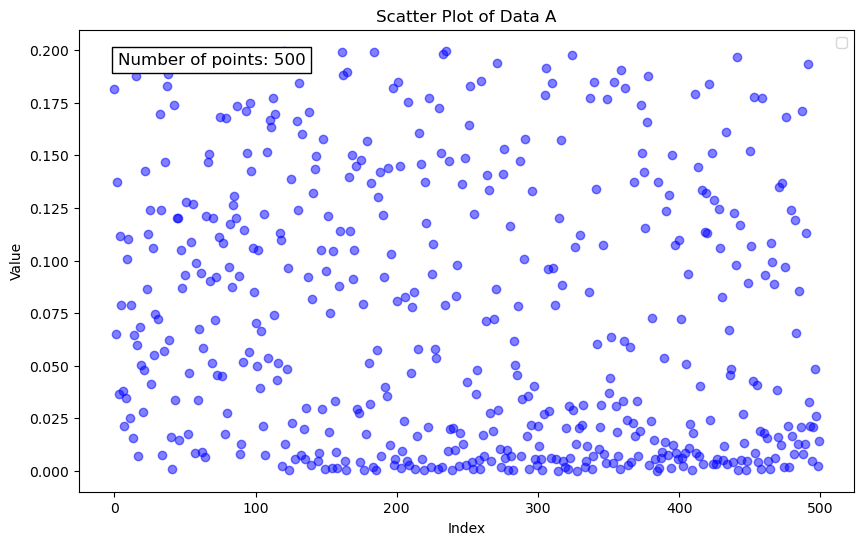

In [9]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


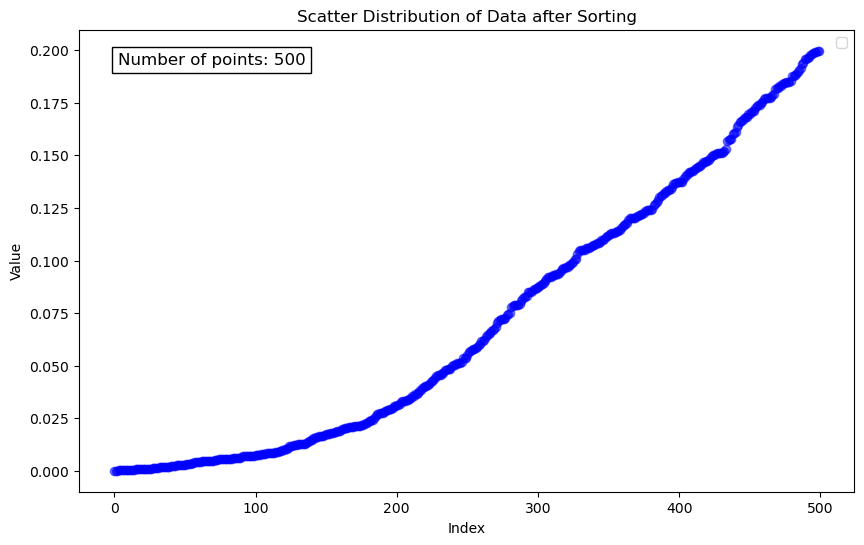

In [10]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.005690107930266635, 0.006116484726010903, 0.005485640371592281, 0.005743726106880352, 0.005011285726030775, 0.005567828387299564, 0.005909981772654383, 0.004728796541059382, 0.005395462696532851, 0.006633545413138348]
Error u of fuhe active learning(LHS sampling): 5.628286e-03
[0.00048009631103501145, 0.0005189489409135313, 0.000494949305846597, 0.0005014259155474356, 0.00042318024585024185, 0.0005131666629501122, 0.000978311453276491, 0.0003977496079815225, 0.000455032939767883, 0.0005578943709376725]
MAE of fuhe active learning(LHS sampling): 5.320756e-04
[3.9573678752062195e-06, 4.572490672891559e-06, 3.678170494737573e-06, 4.03266574388657e-06, 3.0693541080310715e-06, 3.7890311633108858e-06, 4.268701753288063e-06, 2.7330143785372575e-06, 3.5580961353923524e-06, 5.378343424869466e-06]
MSE of fuhe active learning(LHS sampling): 3.903724e-06
[34.97809, 5.620315, 33.911507, 0.6807212, 9.76399, 0.00017943766, 0.00031451473, 0.00034023926, 0.00015528002, 1.0244126]
Chaos of fuhe activ

[0.005690107930266635, 0.006116484726010903, 0.005485640371592281, 0.005743726106880352, 0.005011285726030775, 0.005567828387299564, 0.005909981772654383, 0.004728796541059382, 0.005395462696532851, 0.006633545413138348]
mean Error u: 5.628286e-03
Variance Error u: 2.613366e-07


/tmp/ipykernel_1460319/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


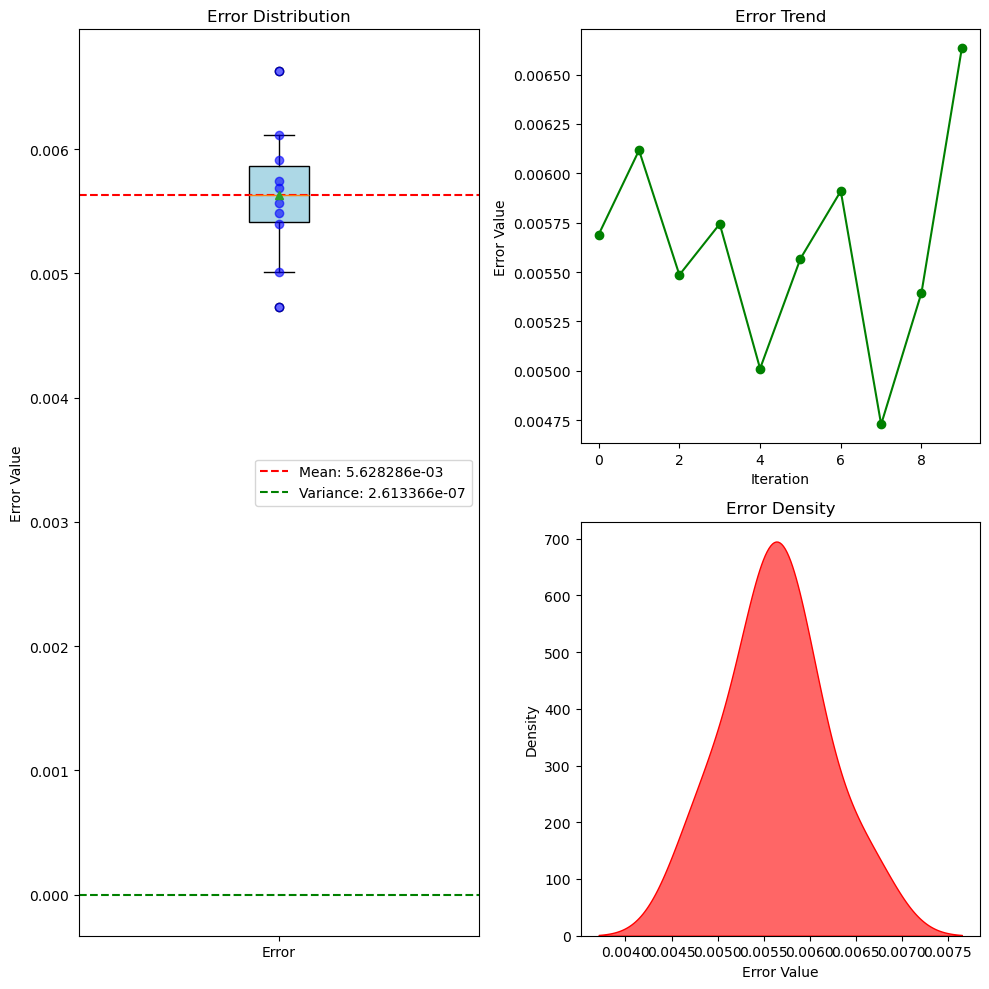

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00048009631103501145, 0.0005189489409135313, 0.000494949305846597, 0.0005014259155474356, 0.00042318024585024185, 0.0005131666629501122, 0.000978311453276491, 0.0003977496079815225, 0.000455032939767883, 0.0005578943709376725]
mean MAE: 5.320756e-04
Variance MAE: 2.411798e-08


/tmp/ipykernel_1460319/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


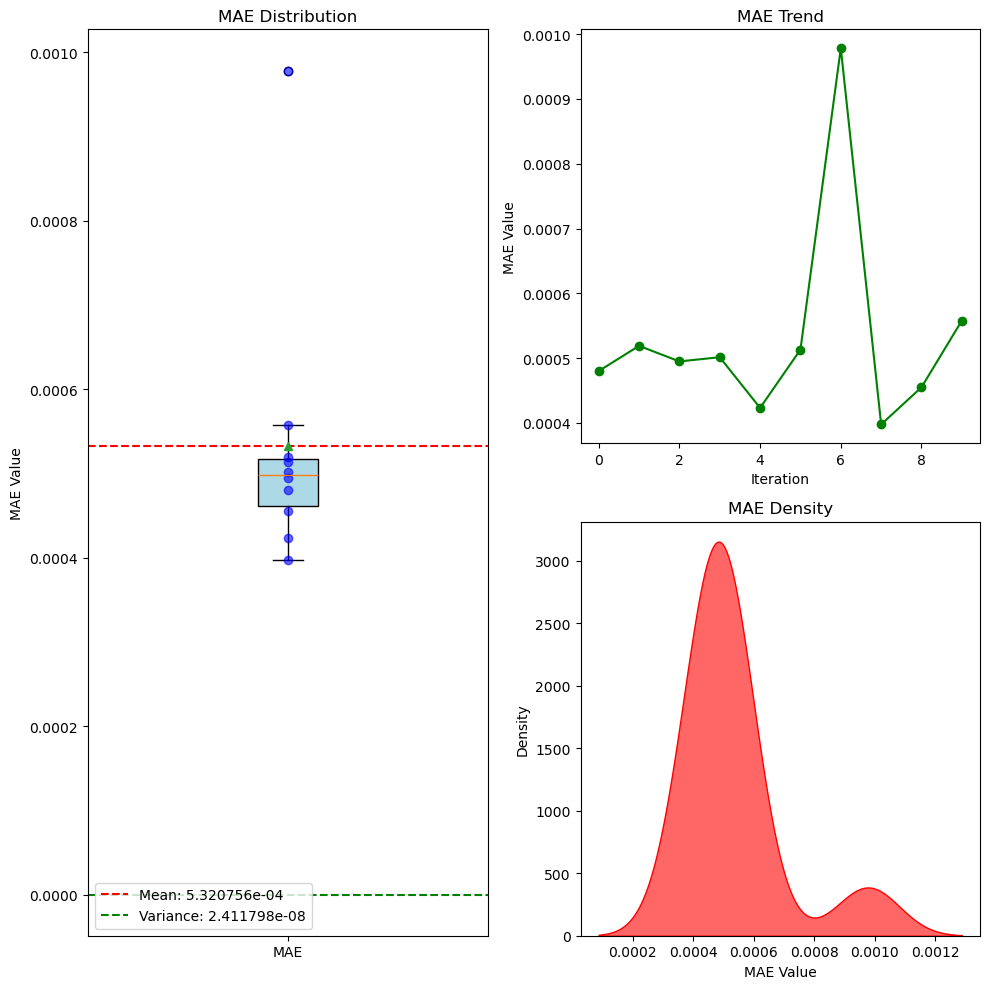

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.9573678752062195e-06, 4.572490672891559e-06, 3.678170494737573e-06, 4.03266574388657e-06, 3.0693541080310715e-06, 3.7890311633108858e-06, 4.268701753288063e-06, 2.7330143785372575e-06, 3.5580961353923524e-06, 5.378343424869466e-06]
mean MSE: 3.903724e-06
Variance MSE: 5.024685e-13


/tmp/ipykernel_1460319/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


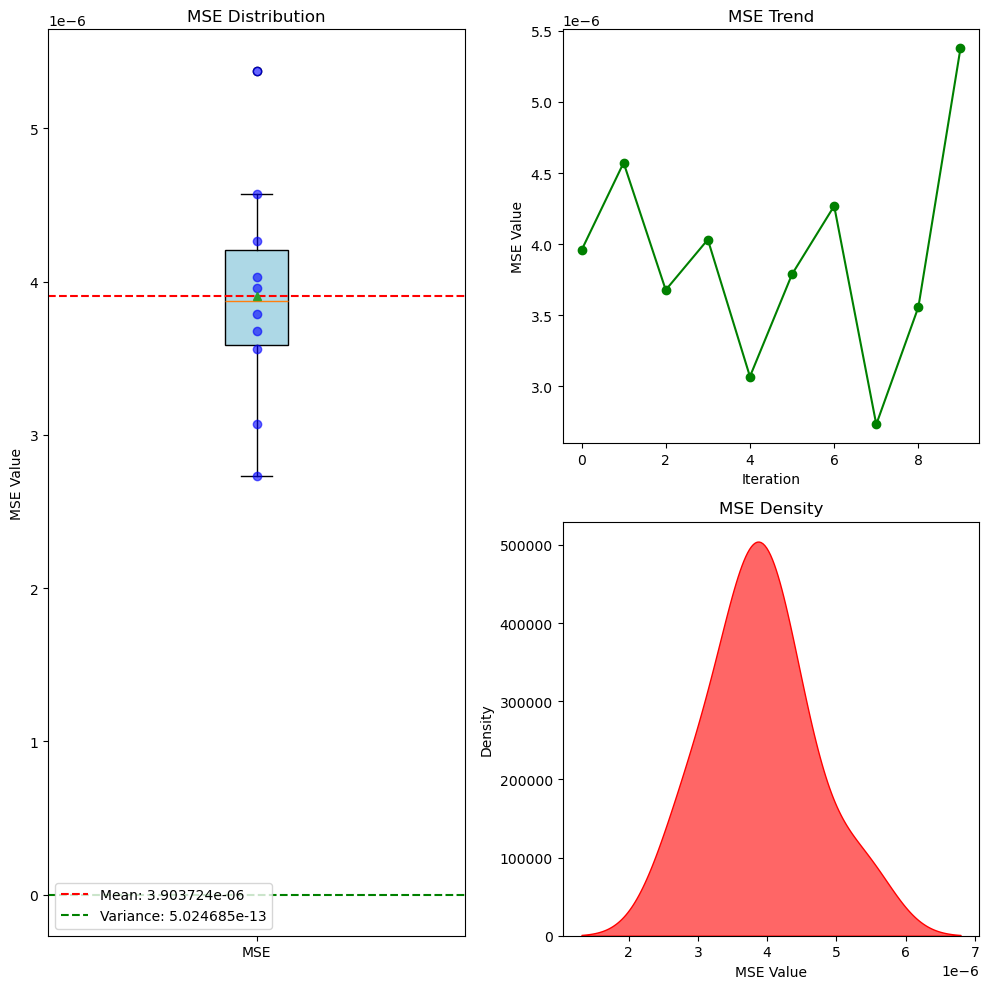

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[34.97809, 5.620315, 33.911507, 0.6807212, 9.76399, 0.00017943766, 0.00031451473, 0.00034023926, 0.00015528002, 1.0244126]
mean CHAOS: 8.598001e+00
Variance CHAOS: 1.762637e+02


/tmp/ipykernel_1460319/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


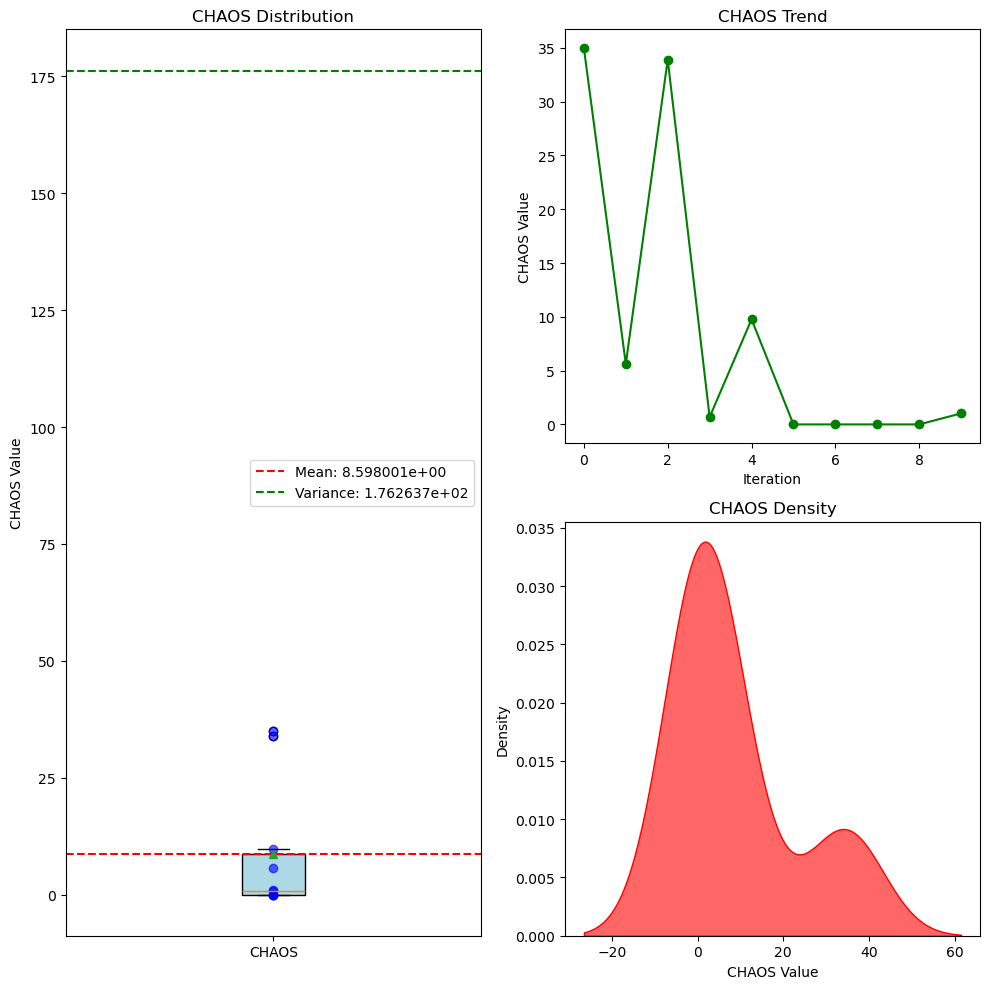

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00044037966, 0.00045493618, 0.00051655585, 0.0004193156, 0.00040521938, 0.00045661686, 0.0004405505, 0.0004048403, 0.0005015226, 0.0004306931]
mean RESIDUAL: 4.470630e-04
Variance RESIDUAL: 1.260699e-09


/tmp/ipykernel_1460319/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


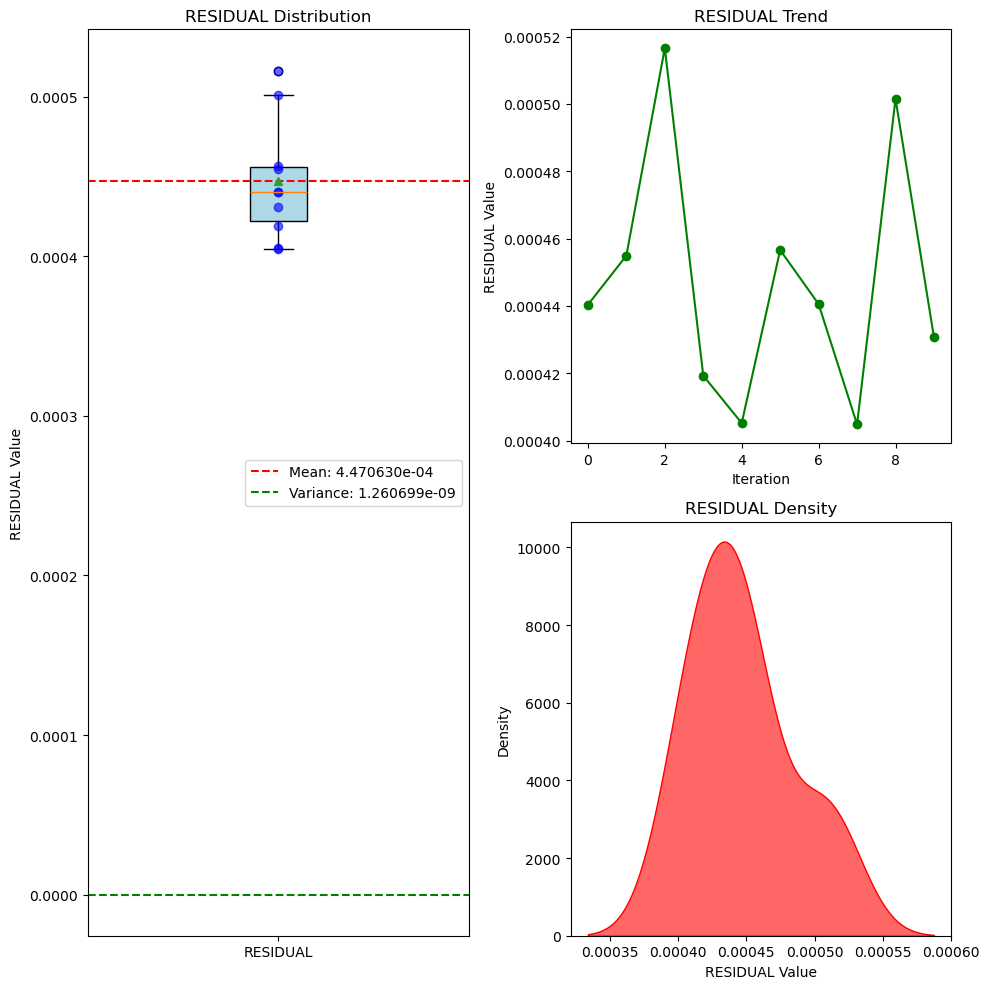

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.80451282e+03 1.72034912e+03 1.65058423e+03 ... 1.24188615e-02
 1.24186659e-02 1.24183875e-02]


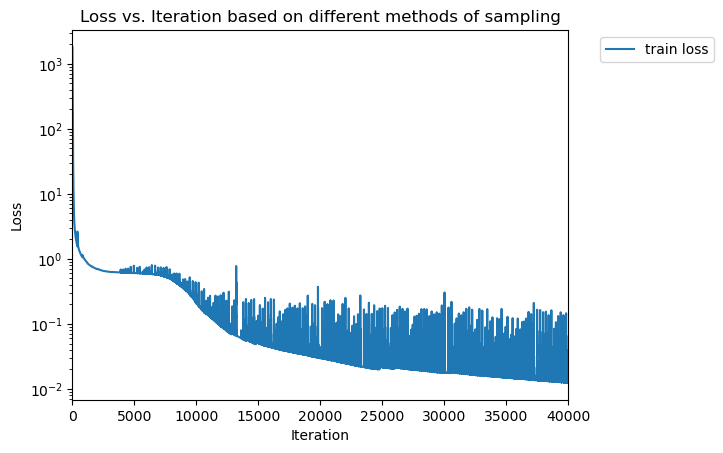

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.959630  0.010234  0.014535  0.014848  0.000191  0.000181  0.000262   
1  0.950985  0.012386  0.017761  0.017820  0.000265  0.000252  0.000367   
2  0.942799  0.014405  0.020818  0.020595  0.000349  0.000333  0.000486   
3  0.934982  0.016316  0.023738  0.023208  0.000443  0.000422  0.000620   
4  0.927491  0.018131  0.026537  0.025677  0.000545  0.000519  0.000765   

    state_8   state_9  state_10  state_11      state_12  
0  0.000101  0.000009  0.000004  0.000005  2.944762e-07  
1  0.000141  0.000011  0.000005  0.000006  3.528355e-07  
2  0.000186  0.000014  0.000006  0.000008  4.140158e-07  
3  0.000236  0.000018  0.000007  0.000010  4.798637e-07  
4  0.000291  0.000022  0.000009  0.000013  5.519717e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757839  0.053038  0.094723  0.068892  0.006639  0.004811  0.008611   
496  0.757838  0.053038  0.094724  0.068891  0.

Text(0, 0.5, 'Probability')

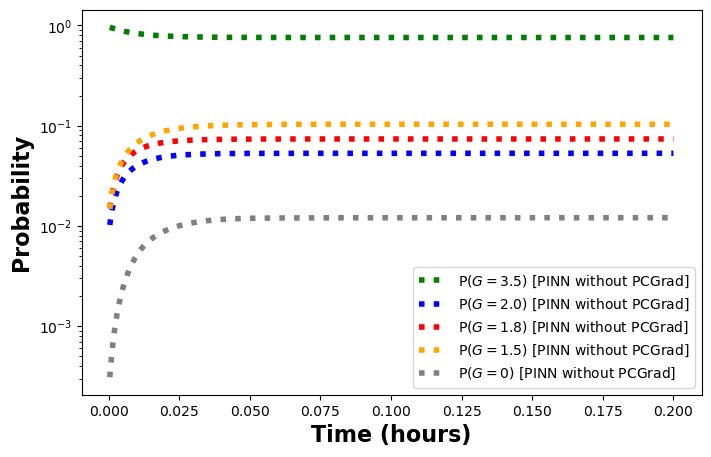

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

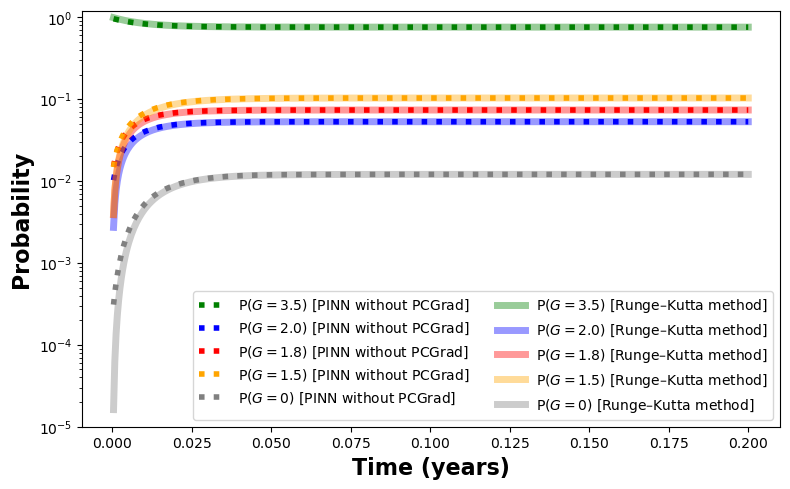

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 2.6891717124347332e-05
RMSE of between PINN without PCGrad and the analytical solution is 2.689171712434573e-05


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0016050231812459142
RMSE of between PINN without PCGrad and the analytical solution is 0.0016050231812457453
